In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
from imblearn.metrics import geometric_mean_score
from metrics import *
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from dataset import *
from utils import *
from models import *

# 1. cov-abdab

## 1.1 EDA

current：GT 抗体-抗原
- 输入抗原，复现/重构抗体
- diff？

refineGNN
- framework
- CDR H3

current：MEAN
- 输入：离CDR H1~H3最近的48个AA + 轻链 + framework
- 生成：CDR H1/H2/H3

ideal：输入抗原chain（no sturcture） asdsbdjkasdkjsah
- 生成抗体

ideal：输入抗原链
- 找epitope
- 根据epitope设计paratope（CDR）= generation + docking
- 根据CDR完善补全整条抗体链

In [2]:
data = pd.read_csv("../SARS-SAbDab_Shaun/CoV-AbDab_extract.csv")
data

,Index,AB_name,Class,Paratope,Epitope
0,1,m396,0,SYTWGGITILIANYQRDTVMGGSKWDSSDY,FSTFRGDEVRNNGQPTYGVGYQY
1,2,80R,0,SYAVISYDRDRSYDRVRSNDSTRSGSGSDFTTSRSW,RDVGGYNLYLFKGFNCYFLQSYGQPTYGVYQ
2,3,F26G19,0,YVSYTTYRYPGNDTTTEGIPQL,AFSTGDRWNNNPTYGVGYQY
3,4,1AF10,0,NWRENRYDPYYAMDIQHYQQTDSWPT,FIVKNKCVFTGVLTDIATDLDITPCSFGGSYQGVNRAGCIG
4,5,6D3,1,WHEDDYINYEYGLLAQNNFYTY,NVFAEHVNNSS
...,...,...,...,...,...
305,306,scFv_E4,1,VSGVTSSNYYPGGSYRDLSEKDVIQGISYSGQNS,RDQTGNDYYLFRKSNYQAGSTFNYFPLQSYGYGVGY
306,307,N3113,1,YEALEWSYHSRTYNPSWASGSTGDW,VATRFASYAWNKSKGGNYNYLRITEINGVKFLQS
307,308,N3113.1,1,QWYSRYNPSWASGST,ATRFASYANKDKVGNYNYLYITEINGVKFPLQSYG
308,309,RBD-chAb-15,1,GHWTTWGGSTNGYYV,YASFSTFKRGDRAWNTYGVGYQPY


In [3]:
len1 = []
len2 = []

for i in range(data.shape[0]):
    len1.append(len(data["Paratope"].iloc[i]))
    len2.append(len(data["Epitope"].iloc[i]))
    
np.mean(len1), np.std(len1), np.max(len1), np.min(len1)

(24.767741935483873, 7.183600817667714, 60, 2)

In [4]:
np.mean(len2), np.std(len2), np.max(len2), np.min(len2)

(24.738709677419354, 9.685678733502161, 75, 4)

(array([  3.,  14.,  53., 105.,  74.,  47.,  12.,   1.,   0.,   1.]),
 array([ 2. ,  7.8, 13.6, 19.4, 25.2, 31. , 36.8, 42.6, 48.4, 54.2, 60. ]),
 <BarContainer object of 10 artists>)

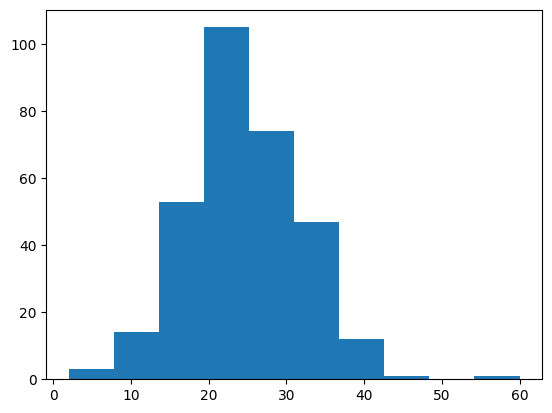

In [5]:
plt.hist(len1)

In [6]:
max(len1)

60

(array([ 21.,  54., 112.,  69.,  36.,  12.,   2.,   1.,   2.,   1.]),
 array([ 4. , 11.1, 18.2, 25.3, 32.4, 39.5, 46.6, 53.7, 60.8, 67.9, 75. ]),
 <BarContainer object of 10 artists>)

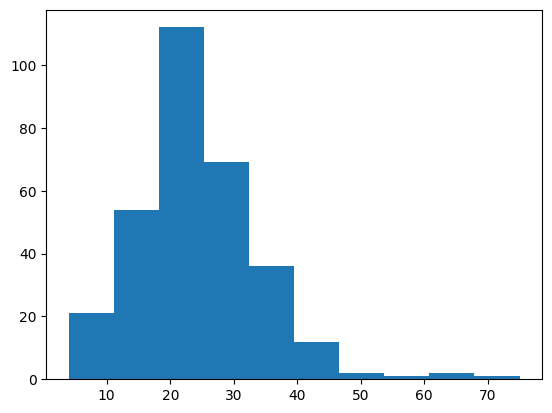

In [7]:
plt.hist(len2)

In [8]:
max(len2)

75

<AxesSubplot:>

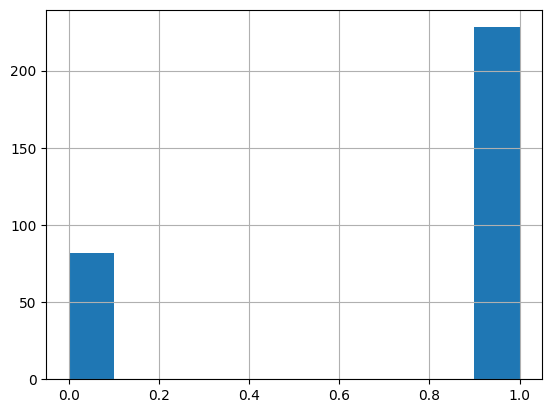

In [9]:
data["Class"].hist()

In [10]:
len(data["Paratope"].unique())

310

In [11]:
len(data["Epitope"].unique())

306

# Fine-tuning

In [15]:
clip_norm = 1

# model name
# model_name = "demo"
# model_name = "masonscnn"
# model_name = "lstm"

# model_name = "InteractTransformer"
# model_name = "InteractCoAttnTransformer"

# model_name = "InteractTransformerLSTM"

# model_name = "SetTransformer"
# model_name = "SetCoAttnTransformer"

# model_name = "SetModel"
# model_name = "SetCoAttnModel"
# model_name = "SetModel_ablation"

# model_name = "FTransformer"

# model_name = "EnsembleModel"
model_name = "PESI"

use_fine_tune = True
# use_fine_tune = False

fix_FE = True
# fix_FE = False

if use_fine_tune==True:
    model_name += "_ft"

os.makedirs("./results/CoV-AbDab/{}/".format(model_name), exist_ok=True)

# model_list = [
#     "InteractCoattnTransformer", 
#     "SetTransformer", 
#     "SetCoAttnTransformer", 
#     "SetModel", 
#     "SetCoAttnModel"
# ]

kfold_labels = []
kfold_preds = []

for k_iter in range(10):
    
    print("=========================================================")
    print("fold {} as val set".format(k_iter))
    
    train_dataset = SeqDataset(data_path="../SARS-SAbDab_Shaun/CoV-AbDab_extract.csv", \
                     kfold=10, holdout_fold=k_iter, is_train_test_full="train")
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=False, \
                                               collate_fn=my_collate_fn2)

    test_dataset = SeqDataset(data_path="../SARS-SAbDab_Shaun/CoV-AbDab_extract.csv", \
                     kfold=10, holdout_fold=k_iter, is_train_test_full="test")
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, \
                                               collate_fn=my_collate_fn1)

    if model_name=="demo":
        model = BiLSTM_demo(embed_size=32, hidden=64, num_layers=1, dropout=0.5, use_pretrain=False).cuda()
        
        epochs = 100
        lr = 6e-5
        
    elif model_name=="masonscnn":
        model = MasonsCNN(amino_ft_dim=len(vocab), 
                          max_antibody_len=100, 
                          max_virus_len=100, 
                          h_dim=512, 
                          dropout=0.1).cuda()
        epochs = 100
        lr = 1e-4
        l2_coef = 5e-4
        
    elif model_name=="masonscnn_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/masonscnn/model_best.pth")

        if fix_FE==True:
            for name, param in model.cnnmodule.named_parameters():
                param.requires_grad = False
            for name, param in model.cnnmodule2.named_parameters():
                param.requires_grad = False


        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4

    elif model_name=="lstm":
        model = BiLSTM(embed_size=32, 
                       hidden=64, 
                       num_layers=1, 
                       dropout=0.5, 
                       use_pretrain=False).cuda()

        epochs = 300
        lr = 1e-4
        l2_coef = 5e-4

    elif model_name=="lstm_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/lstm/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.LSTM_para.named_parameters():
                param.requires_grad = False
            for name, param in model.LSTM_epi.named_parameters():
                param.requires_grad = False
        
        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4
    
    elif model_name=="InteractTransformer":
        model = InteractTransformer(embed_size=32, 
                                    num_encoder_layers=1, 
                                    nhead=2, 
                                    dropout=0.3, 
                                    use_coattn=False).cuda()
        epochs = 200
        lr = 3e-5
        
    elif model_name=="InteractTransformer_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/InteractTransformer/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.transformer_para.named_parameters():
                param.requires_grad = False
            for name, param in model.transformer_epi.named_parameters():
                param.requires_grad = False

        epochs = 1000
        lr = 1e-4
        l2_coef = 5e-4
                
    elif model_name=="InteractCoAttnTransformer":
        model = InteractTransformer(embed_size=32, 
                                    num_encoder_layers=1, 
                                    nhead=2, 
                                    dropout=0.5, 
                                    use_coattn=True).cuda()
        epochs = 200
        lr = 3e-5
        
    elif model_name=="InteractCoAttnTransformer_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/InteractCoAttnTransformer/model_best.pth")
        model.train()
    
        if fix_FE==True:
            for name, param in model.transformer_para.named_parameters():
                param.requires_grad = False
            for name, param in model.transformer_epi.named_parameters():
                param.requires_grad = False
        
        epochs = 1500
        lr = 6e-5
        l2_coef = 5e-4

    elif model_name=="InteractTransformerLSTM":
        model = InteractTransformerLSTM(embed_size=32, 
                                        hidden=64, 
                                        num_encoder_layers=1, 
                                        num_lstm_layers=1, 
                                        nhead=2, 
                                        dropout=0.5, 
                                        use_coattn=True).cuda()
        epochs = 200
        lr = 6e-5

    elif model_name=="InteractTransformerLSTM_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/InteractTransformerLSTM/model_best.pth")
        model.train()
        
        epochs = 200
        lr = 6e-5
                
    elif model_name=="SetTransformer":
        model = SetTransformer(dim_input=32, 
                               num_outputs=32, 
                               dim_output=32, 
                               dim_hidden=64, 
                               num_inds=6, 
                               num_heads=4, 
                               ln=True, 
                               dropout=0.5, 
                               use_coattn=False, 
                               share=False).cuda()
        
        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4
        
    elif model_name=="SetTransformer_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/SetTransformer/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.para_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.para_dec.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_dec.named_parameters():
                param.requires_grad = False
        
        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4
        
    elif model_name=="SetCoAttnTransformer":
        model = SetTransformer(dim_input=32, 
                               num_outputs=32, 
                               dim_output=32, 
                               dim_hidden=64, 
                               num_inds=6, 
                               num_heads=4, 
                               ln=True, 
                               dropout=0.5, 
                               use_coattn=True).cuda()
        epochs = 500
        lr = 1e-4
        
    elif model_name=="SetCoAttnTransformer_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/SetCoAttnTransformer/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.para_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.para_dec.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_dec.named_parameters():
                param.requires_grad = False
        
        epochs = 500
        lr = 1e-4
        l2_coef = 5e-4
        
        
    elif model_name=="SetModel":
        model = SetModel(embed_size=32, 
                         hidden=64, 
                         num_layers=1, 
                         dropout=0.3, 
                         k4kmer=3, 
                         use_pretrain=False, 
                         use_coattn=False, 
                         seq_encoder_type="transformer", 
                         num_heads=2, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        
        epochs = 200
        lr = 3e-5
        l2_coef = 5e-4
        
    elif model_name=="SetModel_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/SetModel/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.para_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.para_dec.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_dec.named_parameters():
                param.requires_grad = False
        
        epochs = 200
        lr = 3e-5
        l2_coef = 5e-4
    
    elif model_name=="SetCoAttnModel":
        model = SetModel(embed_size=32, 
                         hidden=64, 
                         num_layers=1, 
                         dropout=0.3, 
                         k4kmer=3, 
                         use_pretrain=False, 
                         use_coattn=True, 
                         seq_encoder_type="transformer", 
                         num_heads=2, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        epochs = 200
        lr = 3e-5
    
    elif model_name=="SetCoAttnModel_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/SetCoAttnModel/model_best.pth")
        model.train()
        
        if fix_FE==True:
            for name, param in model.para_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.para_dec.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_enc.named_parameters():
                param.requires_grad = False
            for name, param in model.epi_dec.named_parameters():
                param.requires_grad = False
        
        epochs = 200
        lr = 3e-5
        l2_coef = 5e-4
        
    elif model_name=="SetModel_ablation":
        model = SetModel_ablation(embed_size=32, 
                         hidden=64, 
                         num_layers=2, 
                         dropout=0.5, 
                         k4kmer=7, 
                         use_pretrain=False, 
                         use_coattn=False, 
                         use_kmer_embed=True, 
                         use_seq_encoder=False, 
                         seq_encoder_type="lstm", 
                         num_heads=4, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        epochs = 150
        lr = 6e-5
        
    elif model_name=="FTransformer":
        model = FTransformer(embed_size=32, 
                             hidden=64, 
                             num_layers=2, 
                             dropout=0.5, 
                             k4kmer=3, 
                             use_pretrain=False, 
                             use_coattn=True, 
                             seq_encoder_type="transformer", 
                             num_heads=2).cuda()
        
        epochs = 100
        lr = 3e-5
        
    elif model_name=="EnsembleModel":
        model = EnsembleModel(embed_size=16, 
                      hidden=64, 
                      max_len=100, 
                      num_encoder_layers=1, 
                      num_heads=2, 
                      num_inds=6, 
                      num_outputs=6, 
                      ln=True, 
                      dropout=0.5, 
                      use_coattn=True).cuda()
        
        epochs = 500
        lr = 1e-5
        
    elif model_name=="EnsembleModel_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/EnsembleModel/model_best.pth")
        model.train()
        
        epochs = 500
        lr = 1e-4
        
    elif model_name=="PESI":
#         model = PESI(embed_size=7, 
#                      hidden=512, 
#                      max_len=100, 
#                      num_heads=2, 
#                      num_inds=6, 
#                      num_outputs=6, 
#                      ln=True, 
#                      dropout=0.5, 
#                      use_coattn=True).cuda()
        model = PESI(embed_size=8, 
                     hidden=64, 
                     max_len=100, 
                     num_heads=2, 
                     num_inds=6, 
                     num_outputs=6, 
                     ln=True, 
                     dropout=0.5, 
                     use_coattn=True).cuda()
        
        epochs = 200
        lr = 5e-5
#         wd = 3e-4
        l2_coef = 5e-4
        
    elif model_name=="PESI_ft":
        model = torch.load("./results/SAbDab/full/seq1_neg0/PESI/model_best.pth")
        model.train()
        
        # freeze frame feature extractor
        for name, param in model.Frame_para.named_parameters():
            param.requires_grad = False
        for name, param in model.Frame_epi.named_parameters():
            param.requires_grad = False
            
        # freeze frame feature extractor        
        for name, param in model.Set_para.named_parameters():
            param.requires_grad = False
        for name, param in model.Set_epi.named_parameters():
            param.requires_grad = False
        
        epochs = 500
        lr = 3e-5
        l2_coef = 5e-4

    else:
        print("wrong model name!!!")
        break

    print("model parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)#, weight_decay=wd)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6, last_epoch=-1)

    loss_buf = []
    val_loss_buf = []
    val_acc_buf = []
    val_f1_buf = []
    val_auc_buf = []
    val_gmean_buf = []
    val_mcc_buf = []
    best_val_loss = float("inf")
    
    for epoch in range(epochs):

        loss_tmp = []
        for i, (para, epi, label) in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()

            pred = model(para, epi)

            loss = criterion(pred.view(-1), label.view(-1).cuda())
            
            param_l2_loss = 0
            for name, param in model.named_parameters():
                if 'bias' not in name:
                    param_l2_loss += torch.norm(param, p=2)
            param_l2_loss = l2_coef * param_l2_loss
            loss += param_l2_loss

            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)

            optimizer.step()

            loss_tmp.append(loss.item())
        
        loss_buf.append(np.mean(loss_tmp))

    #     scheduler.step()
        print("lr: ", optimizer.param_groups[0]['lr'])

        with torch.no_grad():

            model.eval()

            preds = []
            labels = []
            val_loss_tmp = []
            for i, (para, epi, label) in enumerate(test_loader):

                pred = model(para, epi)
                val_loss = criterion(pred.view(-1), label.view(-1).cuda())

                preds.append(pred.detach().cpu().view(-1))
                labels.append(label.view(-1))
                val_loss_tmp.append(val_loss.item())
            
            preds = torch.stack(preds, axis=1).view(-1)
            labels = torch.stack(labels, axis=1).view(-1)

#             acc = accuracy_score(y_true=labels, y_pred=torch.round(preds))
#             f1 = f1_score(y_true=labels, y_pred=torch.round(preds))
#             auc = roc_auc_score(y_true=labels, y_score=preds)

            acc, f1, auc, gmean, mcc = evaluate_metrics(pred_proba=preds, label=labels)

            val_acc_buf.append(acc)
            val_f1_buf.append(f1)
            val_auc_buf.append(auc)
            val_gmean_buf.append(gmean)
            val_mcc_buf.append(mcc)
            val_loss_buf.append(np.mean(val_loss_tmp))

            print("Epoch {}: \n Train Loss\t{:.4f} \n Val Loss\t{:.4f} \n Val Acc\t{:.4f} \n Val F1\t\t{:.4f} \n Val AUC\t{:.4f} \n Val GMean\t{:.4f} \n Val MCC\t{:.4f}".format(epoch, np.mean(loss_buf), np.mean(val_loss_buf), acc, f1, auc, gmean, mcc))
            
            if np.mean(val_loss_tmp)<best_val_loss:
                best_val_loss = np.mean(val_loss_tmp)
                torch.save(model, "./results/CoV-AbDab/{}/model_{}_best.pth".format(model_name, k_iter))
                np.save("./results/CoV-AbDab/{}/val_acc_{}_best.npy".format(model_name, k_iter), acc)
                np.save("./results/CoV-AbDab/{}/val_f1_{}_best.npy".format(model_name, k_iter), f1)
                np.save("./results/CoV-AbDab/{}/val_auc_{}_best.npy".format(model_name, k_iter), auc)
                np.save("./results/CoV-AbDab/{}/val_gmean_{}_best.npy".format(model_name, k_iter), gmean)
                np.save("./results/CoV-AbDab/{}/val_mcc_{}_best.npy".format(model_name, k_iter), mcc)

        model.train()
    
    torch.save(model, "./results/CoV-AbDab/{}/model_{}.pth".format(model_name, k_iter))
    np.save("./results/CoV-AbDab/{}/loss_buf_{}.npy".format(model_name, k_iter), np.array(loss_buf))
    np.save("./results/CoV-AbDab/{}/val_loss_buf_{}.npy".format(model_name, k_iter), np.array(val_loss_buf))
    np.save("./results/CoV-AbDab/{}/val_acc_buf_{}.npy".format(model_name, k_iter), np.array(val_acc_buf))
    np.save("./results/CoV-AbDab/{}/val_f1_buf_{}.npy".format(model_name, k_iter), np.array(val_f1_buf))
    np.save("./results/CoV-AbDab/{}/val_auc_buf_{}.npy".format(model_name, k_iter), np.array(val_auc_buf))
    np.save("./results/CoV-AbDab/{}/val_gmean_buf_{}.npy".format(model_name, k_iter), np.array(val_gmean_buf))
    np.save("./results/CoV-AbDab/{}/val_mcc_buf_{}.npy".format(model_name, k_iter), np.array(val_mcc_buf))
    
    
    kfold_labels.append(labels)
    kfold_preds.append(preds)
    
#     break

fold 0 as val set
model parameters:  33434


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.22it/s]


lr:  3e-05
Epoch 0: 
 Train Loss	1.0496 
 Val Loss	1.1179 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.5619 
 Val GMean	0.6473 
 Val MCC	0.3068


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.47it/s]


lr:  3e-05
Epoch 1: 
 Train Loss	0.9994 
 Val Loss	1.1101 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.5524 
 Val GMean	0.6473 
 Val MCC	0.3068


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.49it/s]


lr:  3e-05
Epoch 2: 
 Train Loss	0.9676 
 Val Loss	1.1017 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.5429 
 Val GMean	0.6473 
 Val MCC	0.3068


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.85it/s]


lr:  3e-05
Epoch 3: 
 Train Loss	0.9458 
 Val Loss	1.0950 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.5381 
 Val GMean	0.6473 
 Val MCC	0.3068


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.29it/s]


lr:  3e-05
Epoch 4: 
 Train Loss	0.9303 
 Val Loss	1.0879 
 Val Acc	0.5806 
 Val F1		0.6286 
 Val AUC	0.5381 
 Val GMean	0.6055 
 Val MCC	0.2102


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.68it/s]


lr:  3e-05
Epoch 5: 
 Train Loss	0.9249 
 Val Loss	1.0812 
 Val Acc	0.5484 
 Val F1		0.6111 
 Val AUC	0.5429 
 Val GMean	0.5606 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.13it/s]


lr:  3e-05
Epoch 6: 
 Train Loss	0.9171 
 Val Loss	1.0760 
 Val Acc	0.5484 
 Val F1		0.6111 
 Val AUC	0.5429 
 Val GMean	0.5606 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.86it/s]


lr:  3e-05
Epoch 7: 
 Train Loss	0.9071 
 Val Loss	1.0712 
 Val Acc	0.5484 
 Val F1		0.6111 
 Val AUC	0.5429 
 Val GMean	0.5606 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.37it/s]


lr:  3e-05
Epoch 8: 
 Train Loss	0.8996 
 Val Loss	1.0667 
 Val Acc	0.5484 
 Val F1		0.6111 
 Val AUC	0.5429 
 Val GMean	0.5606 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.12it/s]


lr:  3e-05
Epoch 9: 
 Train Loss	0.8938 
 Val Loss	1.0621 
 Val Acc	0.5484 
 Val F1		0.6111 
 Val AUC	0.5429 
 Val GMean	0.5606 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.59it/s]


lr:  3e-05
Epoch 10: 
 Train Loss	0.8866 
 Val Loss	1.0577 
 Val Acc	0.5484 
 Val F1		0.6111 
 Val AUC	0.5476 
 Val GMean	0.5606 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.90it/s]


lr:  3e-05
Epoch 11: 
 Train Loss	0.8801 
 Val Loss	1.0534 
 Val Acc	0.5484 
 Val F1		0.6111 
 Val AUC	0.5476 
 Val GMean	0.5606 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.34it/s]


lr:  3e-05
Epoch 12: 
 Train Loss	0.8768 
 Val Loss	1.0493 
 Val Acc	0.5484 
 Val F1		0.6111 
 Val AUC	0.5476 
 Val GMean	0.5606 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.91it/s]


lr:  3e-05
Epoch 13: 
 Train Loss	0.8733 
 Val Loss	1.0454 
 Val Acc	0.5484 
 Val F1		0.6111 
 Val AUC	0.5429 
 Val GMean	0.5606 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.60it/s]


lr:  3e-05
Epoch 14: 
 Train Loss	0.8676 
 Val Loss	1.0417 
 Val Acc	0.5484 
 Val F1		0.6111 
 Val AUC	0.5429 
 Val GMean	0.5606 
 Val MCC	0.1158


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.23it/s]


lr:  3e-05
Epoch 15: 
 Train Loss	0.8649 
 Val Loss	1.0384 
 Val Acc	0.5161 
 Val F1		0.5946 
 Val AUC	0.5429 
 Val GMean	0.5118 
 Val MCC	0.0223


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 82.31it/s]


lr:  3e-05
Epoch 16: 
 Train Loss	0.8625 
 Val Loss	1.0351 
 Val Acc	0.5161 
 Val F1		0.5946 
 Val AUC	0.5381 
 Val GMean	0.5118 
 Val MCC	0.0223


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.36it/s]


lr:  3e-05
Epoch 17: 
 Train Loss	0.8620 
 Val Loss	1.0320 
 Val Acc	0.5161 
 Val F1		0.5946 
 Val AUC	0.5381 
 Val GMean	0.5118 
 Val MCC	0.0223


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.47it/s]


lr:  3e-05
Epoch 18: 
 Train Loss	0.8596 
 Val Loss	1.0292 
 Val Acc	0.5161 
 Val F1		0.5946 
 Val AUC	0.5429 
 Val GMean	0.5118 
 Val MCC	0.0223


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.18it/s]


lr:  3e-05
Epoch 19: 
 Train Loss	0.8567 
 Val Loss	1.0264 
 Val Acc	0.5161 
 Val F1		0.5946 
 Val AUC	0.5429 
 Val GMean	0.5118 
 Val MCC	0.0223


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.77it/s]


lr:  3e-05
Epoch 20: 
 Train Loss	0.8540 
 Val Loss	1.0240 
 Val Acc	0.5161 
 Val F1		0.5946 
 Val AUC	0.5333 
 Val GMean	0.5118 
 Val MCC	0.0223


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.92it/s]


lr:  3e-05
Epoch 21: 
 Train Loss	0.8525 
 Val Loss	1.0218 
 Val Acc	0.4839 
 Val F1		0.5789 
 Val AUC	0.5333 
 Val GMean	0.4577 
 Val MCC	-0.0716


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.46it/s]


lr:  3e-05
Epoch 22: 
 Train Loss	0.8492 
 Val Loss	1.0197 
 Val Acc	0.4839 
 Val F1		0.5789 
 Val AUC	0.5333 
 Val GMean	0.4577 
 Val MCC	-0.0716


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.09it/s]


lr:  3e-05
Epoch 23: 
 Train Loss	0.8469 
 Val Loss	1.0176 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5333 
 Val GMean	0.4781 
 Val MCC	-0.0271


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  3e-05
Epoch 24: 
 Train Loss	0.8441 
 Val Loss	1.0157 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5381 
 Val GMean	0.4781 
 Val MCC	-0.0271


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.25it/s]


lr:  3e-05
Epoch 25: 
 Train Loss	0.8425 
 Val Loss	1.0139 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5381 
 Val GMean	0.4781 
 Val MCC	-0.0271


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.43it/s]


lr:  3e-05
Epoch 26: 
 Train Loss	0.8419 
 Val Loss	1.0121 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5381 
 Val GMean	0.4781 
 Val MCC	-0.0271


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.56it/s]


lr:  3e-05
Epoch 27: 
 Train Loss	0.8398 
 Val Loss	1.0104 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5381 
 Val GMean	0.4781 
 Val MCC	-0.0271


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.16it/s]


lr:  3e-05
Epoch 28: 
 Train Loss	0.8388 
 Val Loss	1.0088 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5381 
 Val GMean	0.4781 
 Val MCC	-0.0271


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.09it/s]


lr:  3e-05
Epoch 29: 
 Train Loss	0.8376 
 Val Loss	1.0073 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5333 
 Val GMean	0.4781 
 Val MCC	-0.0271


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.90it/s]


lr:  3e-05
Epoch 30: 
 Train Loss	0.8358 
 Val Loss	1.0061 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5333 
 Val GMean	0.4781 
 Val MCC	-0.0271


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.22it/s]


lr:  3e-05
Epoch 31: 
 Train Loss	0.8337 
 Val Loss	1.0050 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5333 
 Val GMean	0.4781 
 Val MCC	-0.0271


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.81it/s]


lr:  3e-05
Epoch 32: 
 Train Loss	0.8331 
 Val Loss	1.0041 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5333 
 Val GMean	0.4781 
 Val MCC	-0.0271


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.78it/s]


lr:  3e-05
Epoch 33: 
 Train Loss	0.8318 
 Val Loss	1.0032 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5381 
 Val GMean	0.4781 
 Val MCC	-0.0271


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.72it/s]


lr:  3e-05
Epoch 34: 
 Train Loss	0.8307 
 Val Loss	1.0023 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5381 
 Val GMean	0.4781 
 Val MCC	-0.0271


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.89it/s]


lr:  3e-05
Epoch 35: 
 Train Loss	0.8289 
 Val Loss	1.0014 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5381 
 Val GMean	0.4781 
 Val MCC	-0.0271


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.65it/s]


lr:  3e-05
Epoch 36: 
 Train Loss	0.8280 
 Val Loss	1.0005 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5381 
 Val GMean	0.4781 
 Val MCC	-0.0271


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 82.06it/s]


lr:  3e-05
Epoch 37: 
 Train Loss	0.8265 
 Val Loss	0.9996 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5381 
 Val GMean	0.4781 
 Val MCC	-0.0271


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 82.02it/s]


lr:  3e-05
Epoch 38: 
 Train Loss	0.8249 
 Val Loss	0.9987 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5429 
 Val GMean	0.4976 
 Val MCC	0.0183


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.78it/s]


lr:  3e-05
Epoch 39: 
 Train Loss	0.8236 
 Val Loss	0.9978 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5429 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 82.27it/s]


lr:  3e-05
Epoch 40: 
 Train Loss	0.8224 
 Val Loss	0.9970 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5476 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.77it/s]


lr:  3e-05
Epoch 41: 
 Train Loss	0.8216 
 Val Loss	0.9963 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5429 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.38it/s]


lr:  3e-05
Epoch 42: 
 Train Loss	0.8205 
 Val Loss	0.9955 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5476 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.89it/s]


lr:  3e-05
Epoch 43: 
 Train Loss	0.8194 
 Val Loss	0.9948 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5476 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.72it/s]


lr:  3e-05
Epoch 44: 
 Train Loss	0.8187 
 Val Loss	0.9941 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5524 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.89it/s]


lr:  3e-05
Epoch 45: 
 Train Loss	0.8177 
 Val Loss	0.9935 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5524 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.29it/s]


lr:  3e-05
Epoch 46: 
 Train Loss	0.8167 
 Val Loss	0.9929 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5571 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.97it/s]


lr:  3e-05
Epoch 47: 
 Train Loss	0.8157 
 Val Loss	0.9923 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5571 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.48it/s]


lr:  3e-05
Epoch 48: 
 Train Loss	0.8152 
 Val Loss	0.9918 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5571 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.65it/s]


lr:  3e-05
Epoch 49: 
 Train Loss	0.8143 
 Val Loss	0.9913 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5619 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.17it/s]


lr:  3e-05
Epoch 50: 
 Train Loss	0.8138 
 Val Loss	0.9909 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5667 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.76it/s]


lr:  3e-05
Epoch 51: 
 Train Loss	0.8130 
 Val Loss	0.9904 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5667 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.07it/s]


lr:  3e-05
Epoch 52: 
 Train Loss	0.8120 
 Val Loss	0.9900 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5619 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.79it/s]


lr:  3e-05
Epoch 53: 
 Train Loss	0.8114 
 Val Loss	0.9896 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5667 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  3e-05
Epoch 54: 
 Train Loss	0.8107 
 Val Loss	0.9893 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5667 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.27it/s]


lr:  3e-05
Epoch 55: 
 Train Loss	0.8100 
 Val Loss	0.9889 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5667 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.32it/s]


lr:  3e-05
Epoch 56: 
 Train Loss	0.8093 
 Val Loss	0.9886 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5667 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.17it/s]


lr:  3e-05
Epoch 57: 
 Train Loss	0.8088 
 Val Loss	0.9884 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5667 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.91it/s]


lr:  3e-05
Epoch 58: 
 Train Loss	0.8082 
 Val Loss	0.9881 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5667 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.02it/s]


lr:  3e-05
Epoch 59: 
 Train Loss	0.8075 
 Val Loss	0.9878 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5714 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.96it/s]


lr:  3e-05
Epoch 60: 
 Train Loss	0.8072 
 Val Loss	0.9876 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5762 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.42it/s]


lr:  3e-05
Epoch 61: 
 Train Loss	0.8068 
 Val Loss	0.9874 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5762 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.33it/s]


lr:  3e-05
Epoch 62: 
 Train Loss	0.8059 
 Val Loss	0.9872 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5762 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.36it/s]


lr:  3e-05
Epoch 63: 
 Train Loss	0.8050 
 Val Loss	0.9870 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5762 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  3e-05
Epoch 64: 
 Train Loss	0.8042 
 Val Loss	0.9869 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5762 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.93it/s]


lr:  3e-05
Epoch 65: 
 Train Loss	0.8036 
 Val Loss	0.9868 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5762 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.87it/s]


lr:  3e-05
Epoch 66: 
 Train Loss	0.8029 
 Val Loss	0.9867 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5810 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.70it/s]


lr:  3e-05
Epoch 67: 
 Train Loss	0.8021 
 Val Loss	0.9865 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5905 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.47it/s]


lr:  3e-05
Epoch 68: 
 Train Loss	0.8015 
 Val Loss	0.9864 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5905 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.39it/s]


lr:  3e-05
Epoch 69: 
 Train Loss	0.8008 
 Val Loss	0.9863 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5952 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.60it/s]


lr:  3e-05
Epoch 70: 
 Train Loss	0.8003 
 Val Loss	0.9862 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5952 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  3e-05
Epoch 71: 
 Train Loss	0.7996 
 Val Loss	0.9860 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5952 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.29it/s]


lr:  3e-05
Epoch 72: 
 Train Loss	0.7989 
 Val Loss	0.9860 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5952 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.37it/s]


lr:  3e-05
Epoch 73: 
 Train Loss	0.7987 
 Val Loss	0.9859 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5952 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  3e-05
Epoch 74: 
 Train Loss	0.7981 
 Val Loss	0.9859 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6000 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  3e-05
Epoch 75: 
 Train Loss	0.7975 
 Val Loss	0.9858 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6000 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.13it/s]


lr:  3e-05
Epoch 76: 
 Train Loss	0.7969 
 Val Loss	0.9858 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6000 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  3e-05
Epoch 77: 
 Train Loss	0.7963 
 Val Loss	0.9858 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6000 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.38it/s]


lr:  3e-05
Epoch 78: 
 Train Loss	0.7956 
 Val Loss	0.9858 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6000 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.98it/s]


lr:  3e-05
Epoch 79: 
 Train Loss	0.7954 
 Val Loss	0.9859 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6000 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.55it/s]


lr:  3e-05
Epoch 80: 
 Train Loss	0.7948 
 Val Loss	0.9860 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6000 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.58it/s]


lr:  3e-05
Epoch 81: 
 Train Loss	0.7944 
 Val Loss	0.9862 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6000 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.90it/s]


lr:  3e-05
Epoch 82: 
 Train Loss	0.7941 
 Val Loss	0.9863 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6000 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.18it/s]


lr:  3e-05
Epoch 83: 
 Train Loss	0.7936 
 Val Loss	0.9864 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6000 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.04it/s]


lr:  3e-05
Epoch 84: 
 Train Loss	0.7930 
 Val Loss	0.9866 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6000 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.67it/s]


lr:  3e-05
Epoch 85: 
 Train Loss	0.7924 
 Val Loss	0.9868 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6000 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.11it/s]


lr:  3e-05
Epoch 86: 
 Train Loss	0.7919 
 Val Loss	0.9869 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5952 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.73it/s]


lr:  3e-05
Epoch 87: 
 Train Loss	0.7913 
 Val Loss	0.9871 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6000 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.52it/s]


lr:  3e-05
Epoch 88: 
 Train Loss	0.7907 
 Val Loss	0.9872 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6000 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.58it/s]


lr:  3e-05
Epoch 89: 
 Train Loss	0.7901 
 Val Loss	0.9874 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5952 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.07it/s]


lr:  3e-05
Epoch 90: 
 Train Loss	0.7895 
 Val Loss	0.9876 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6000 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.62it/s]


lr:  3e-05
Epoch 91: 
 Train Loss	0.7889 
 Val Loss	0.9879 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6000 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.32it/s]


lr:  3e-05
Epoch 92: 
 Train Loss	0.7884 
 Val Loss	0.9882 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6000 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.63it/s]


lr:  3e-05
Epoch 93: 
 Train Loss	0.7879 
 Val Loss	0.9885 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.6000 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.74it/s]


lr:  3e-05
Epoch 94: 
 Train Loss	0.7874 
 Val Loss	0.9888 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5952 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.09it/s]


lr:  3e-05
Epoch 95: 
 Train Loss	0.7868 
 Val Loss	0.9891 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5952 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.20it/s]


lr:  3e-05
Epoch 96: 
 Train Loss	0.7862 
 Val Loss	0.9895 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5952 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.93it/s]


lr:  3e-05
Epoch 97: 
 Train Loss	0.7857 
 Val Loss	0.9899 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5952 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.64it/s]


lr:  3e-05
Epoch 98: 
 Train Loss	0.7852 
 Val Loss	0.9903 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.5905 
 Val GMean	0.5164 
 Val MCC	0.0651


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.16it/s]


lr:  3e-05
Epoch 99: 
 Train Loss	0.7846 
 Val Loss	0.9907 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5857 
 Val GMean	0.4976 
 Val MCC	0.0183


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.44it/s]


lr:  3e-05
Epoch 100: 
 Train Loss	0.7841 
 Val Loss	0.9912 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5905 
 Val GMean	0.4976 
 Val MCC	0.0183


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.49it/s]


lr:  3e-05
Epoch 101: 
 Train Loss	0.7837 
 Val Loss	0.9916 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5905 
 Val GMean	0.4976 
 Val MCC	0.0183


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.74it/s]


lr:  3e-05
Epoch 102: 
 Train Loss	0.7832 
 Val Loss	0.9920 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5905 
 Val GMean	0.4976 
 Val MCC	0.0183


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.67it/s]


lr:  3e-05
Epoch 103: 
 Train Loss	0.7827 
 Val Loss	0.9925 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5952 
 Val GMean	0.4976 
 Val MCC	0.0183


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.25it/s]


lr:  3e-05
Epoch 104: 
 Train Loss	0.7821 
 Val Loss	0.9929 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5952 
 Val GMean	0.4976 
 Val MCC	0.0183


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.27it/s]


lr:  3e-05
Epoch 105: 
 Train Loss	0.7815 
 Val Loss	0.9933 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.6048 
 Val GMean	0.4976 
 Val MCC	0.0183


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.82it/s]


lr:  3e-05
Epoch 106: 
 Train Loss	0.7810 
 Val Loss	0.9938 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.6095 
 Val GMean	0.4976 
 Val MCC	0.0183


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.36it/s]


lr:  3e-05
Epoch 107: 
 Train Loss	0.7804 
 Val Loss	0.9942 
 Val Acc	0.5806 
 Val F1		0.6667 
 Val AUC	0.6095 
 Val GMean	0.5563 
 Val MCC	0.1128


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.19it/s]


lr:  3e-05
Epoch 108: 
 Train Loss	0.7798 
 Val Loss	0.9947 
 Val Acc	0.5806 
 Val F1		0.6667 
 Val AUC	0.6095 
 Val GMean	0.5563 
 Val MCC	0.1128


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.28it/s]


lr:  3e-05
Epoch 109: 
 Train Loss	0.7793 
 Val Loss	0.9952 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6143 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.23it/s]


lr:  3e-05
Epoch 110: 
 Train Loss	0.7788 
 Val Loss	0.9957 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6286 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.58it/s]


lr:  3e-05
Epoch 111: 
 Train Loss	0.7783 
 Val Loss	0.9962 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6286 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.41it/s]


lr:  3e-05
Epoch 112: 
 Train Loss	0.7779 
 Val Loss	0.9967 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6238 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.45it/s]


lr:  3e-05
Epoch 113: 
 Train Loss	0.7775 
 Val Loss	0.9973 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6238 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.93it/s]


lr:  3e-05
Epoch 114: 
 Train Loss	0.7770 
 Val Loss	0.9979 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6238 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.68it/s]


lr:  3e-05
Epoch 115: 
 Train Loss	0.7765 
 Val Loss	0.9984 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6286 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.14it/s]


lr:  3e-05
Epoch 116: 
 Train Loss	0.7761 
 Val Loss	0.9989 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6333 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.77it/s]


lr:  3e-05
Epoch 117: 
 Train Loss	0.7758 
 Val Loss	0.9995 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6286 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.70it/s]


lr:  3e-05
Epoch 118: 
 Train Loss	0.7754 
 Val Loss	1.0000 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6333 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.72it/s]


lr:  3e-05
Epoch 119: 
 Train Loss	0.7749 
 Val Loss	1.0006 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6333 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.28it/s]


lr:  3e-05
Epoch 120: 
 Train Loss	0.7744 
 Val Loss	1.0011 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6381 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.13it/s]


lr:  3e-05
Epoch 121: 
 Train Loss	0.7740 
 Val Loss	1.0016 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6381 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.40it/s]


lr:  3e-05
Epoch 122: 
 Train Loss	0.7736 
 Val Loss	1.0022 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6381 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.52it/s]


lr:  3e-05
Epoch 123: 
 Train Loss	0.7730 
 Val Loss	1.0029 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6429 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.84it/s]


lr:  3e-05
Epoch 124: 
 Train Loss	0.7726 
 Val Loss	1.0035 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6429 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.91it/s]


lr:  3e-05
Epoch 125: 
 Train Loss	0.7721 
 Val Loss	1.0041 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6476 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.46it/s]


lr:  3e-05
Epoch 126: 
 Train Loss	0.7716 
 Val Loss	1.0048 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6476 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.48it/s]


lr:  3e-05
Epoch 127: 
 Train Loss	0.7711 
 Val Loss	1.0055 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6524 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.38it/s]


lr:  3e-05
Epoch 128: 
 Train Loss	0.7707 
 Val Loss	1.0062 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6571 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.10it/s]


lr:  3e-05
Epoch 129: 
 Train Loss	0.7702 
 Val Loss	1.0068 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6571 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.40it/s]


lr:  3e-05
Epoch 130: 
 Train Loss	0.7698 
 Val Loss	1.0076 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6571 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.54it/s]


lr:  3e-05
Epoch 131: 
 Train Loss	0.7693 
 Val Loss	1.0083 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6571 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.83it/s]


lr:  3e-05
Epoch 132: 
 Train Loss	0.7688 
 Val Loss	1.0091 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6524 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.04it/s]


lr:  3e-05
Epoch 133: 
 Train Loss	0.7682 
 Val Loss	1.0099 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6524 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.06it/s]


lr:  3e-05
Epoch 134: 
 Train Loss	0.7678 
 Val Loss	1.0108 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6571 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.12it/s]


lr:  3e-05
Epoch 135: 
 Train Loss	0.7674 
 Val Loss	1.0116 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6571 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.98it/s]


lr:  3e-05
Epoch 136: 
 Train Loss	0.7669 
 Val Loss	1.0125 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6571 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.35it/s]


lr:  3e-05
Epoch 137: 
 Train Loss	0.7665 
 Val Loss	1.0134 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6571 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.36it/s]


lr:  3e-05
Epoch 138: 
 Train Loss	0.7660 
 Val Loss	1.0142 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6619 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.39it/s]


lr:  3e-05
Epoch 139: 
 Train Loss	0.7657 
 Val Loss	1.0150 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6619 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.69it/s]


lr:  3e-05
Epoch 140: 
 Train Loss	0.7652 
 Val Loss	1.0159 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6571 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.99it/s]


lr:  3e-05
Epoch 141: 
 Train Loss	0.7648 
 Val Loss	1.0167 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6571 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.89it/s]


lr:  3e-05
Epoch 142: 
 Train Loss	0.7643 
 Val Loss	1.0175 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6571 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.30it/s]


lr:  3e-05
Epoch 143: 
 Train Loss	0.7639 
 Val Loss	1.0183 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6571 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.62it/s]


lr:  3e-05
Epoch 144: 
 Train Loss	0.7634 
 Val Loss	1.0192 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6524 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.60it/s]


lr:  3e-05
Epoch 145: 
 Train Loss	0.7630 
 Val Loss	1.0201 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6524 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.53it/s]


lr:  3e-05
Epoch 146: 
 Train Loss	0.7625 
 Val Loss	1.0210 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6571 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.26it/s]


lr:  3e-05
Epoch 147: 
 Train Loss	0.7621 
 Val Loss	1.0220 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6619 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.28it/s]


lr:  3e-05
Epoch 148: 
 Train Loss	0.7616 
 Val Loss	1.0229 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6619 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.34it/s]


lr:  3e-05
Epoch 149: 
 Train Loss	0.7612 
 Val Loss	1.0239 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6619 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.99it/s]


lr:  3e-05
Epoch 150: 
 Train Loss	0.7608 
 Val Loss	1.0248 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6619 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.40it/s]


lr:  3e-05
Epoch 151: 
 Train Loss	0.7603 
 Val Loss	1.0258 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6619 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.05it/s]


lr:  3e-05
Epoch 152: 
 Train Loss	0.7598 
 Val Loss	1.0269 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6667 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.64it/s]


lr:  3e-05
Epoch 153: 
 Train Loss	0.7594 
 Val Loss	1.0279 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6667 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.28it/s]


lr:  3e-05
Epoch 154: 
 Train Loss	0.7589 
 Val Loss	1.0290 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6714 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.66it/s]


lr:  3e-05
Epoch 155: 
 Train Loss	0.7583 
 Val Loss	1.0300 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6667 
 Val GMean	0.5855 
 Val MCC	0.1604


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.78it/s]


lr:  3e-05
Epoch 156: 
 Train Loss	0.7579 
 Val Loss	1.0311 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6667 
 Val GMean	0.6325 
 Val MCC	0.2539


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.29it/s]


lr:  3e-05
Epoch 157: 
 Train Loss	0.7574 
 Val Loss	1.0321 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6667 
 Val GMean	0.6325 
 Val MCC	0.2539


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 82.18it/s]


lr:  3e-05
Epoch 158: 
 Train Loss	0.7570 
 Val Loss	1.0331 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6667 
 Val GMean	0.6325 
 Val MCC	0.2539


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.20it/s]


lr:  3e-05
Epoch 159: 
 Train Loss	0.7566 
 Val Loss	1.0342 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6714 
 Val GMean	0.6325 
 Val MCC	0.2539


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.13it/s]


lr:  3e-05
Epoch 160: 
 Train Loss	0.7561 
 Val Loss	1.0352 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6714 
 Val GMean	0.6325 
 Val MCC	0.2539


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.40it/s]


lr:  3e-05
Epoch 161: 
 Train Loss	0.7557 
 Val Loss	1.0363 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6667 
 Val GMean	0.6325 
 Val MCC	0.2539


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.73it/s]


lr:  3e-05
Epoch 162: 
 Train Loss	0.7551 
 Val Loss	1.0374 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6667 
 Val GMean	0.6325 
 Val MCC	0.2539


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.23it/s]


lr:  3e-05
Epoch 163: 
 Train Loss	0.7548 
 Val Loss	1.0385 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6667 
 Val GMean	0.6325 
 Val MCC	0.2539


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.77it/s]


lr:  3e-05
Epoch 164: 
 Train Loss	0.7543 
 Val Loss	1.0396 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6714 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.13it/s]


lr:  3e-05
Epoch 165: 
 Train Loss	0.7538 
 Val Loss	1.0408 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6714 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.38it/s]


lr:  3e-05
Epoch 166: 
 Train Loss	0.7533 
 Val Loss	1.0419 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6714 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.56it/s]


lr:  3e-05
Epoch 167: 
 Train Loss	0.7529 
 Val Loss	1.0430 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6714 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.30it/s]


lr:  3e-05
Epoch 168: 
 Train Loss	0.7524 
 Val Loss	1.0442 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6762 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.31it/s]


lr:  3e-05
Epoch 169: 
 Train Loss	0.7519 
 Val Loss	1.0453 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6762 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.49it/s]


lr:  3e-05
Epoch 170: 
 Train Loss	0.7515 
 Val Loss	1.0465 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6762 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.55it/s]


lr:  3e-05
Epoch 171: 
 Train Loss	0.7510 
 Val Loss	1.0478 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6762 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 82.00it/s]


lr:  3e-05
Epoch 172: 
 Train Loss	0.7505 
 Val Loss	1.0489 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6810 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.63it/s]


lr:  3e-05
Epoch 173: 
 Train Loss	0.7500 
 Val Loss	1.0502 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6762 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.54it/s]


lr:  3e-05
Epoch 174: 
 Train Loss	0.7495 
 Val Loss	1.0514 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6762 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.86it/s]


lr:  3e-05
Epoch 175: 
 Train Loss	0.7491 
 Val Loss	1.0526 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6762 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.39it/s]


lr:  3e-05
Epoch 176: 
 Train Loss	0.7486 
 Val Loss	1.0539 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6762 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.60it/s]


lr:  3e-05
Epoch 177: 
 Train Loss	0.7482 
 Val Loss	1.0551 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6762 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.83it/s]


lr:  3e-05
Epoch 178: 
 Train Loss	0.7478 
 Val Loss	1.0564 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6762 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.20it/s]


lr:  3e-05
Epoch 179: 
 Train Loss	0.7474 
 Val Loss	1.0576 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6762 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.50it/s]


lr:  3e-05
Epoch 180: 
 Train Loss	0.7469 
 Val Loss	1.0589 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6762 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.27it/s]


lr:  3e-05
Epoch 181: 
 Train Loss	0.7465 
 Val Loss	1.0602 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6762 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  3e-05
Epoch 182: 
 Train Loss	0.7460 
 Val Loss	1.0615 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6810 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.17it/s]


lr:  3e-05
Epoch 183: 
 Train Loss	0.7455 
 Val Loss	1.0628 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6810 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.44it/s]


lr:  3e-05
Epoch 184: 
 Train Loss	0.7452 
 Val Loss	1.0642 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6810 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.22it/s]


lr:  3e-05
Epoch 185: 
 Train Loss	0.7449 
 Val Loss	1.0655 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6762 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.70it/s]


lr:  3e-05
Epoch 186: 
 Train Loss	0.7445 
 Val Loss	1.0668 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6762 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.40it/s]


lr:  3e-05
Epoch 187: 
 Train Loss	0.7440 
 Val Loss	1.0682 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6762 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.73it/s]


lr:  3e-05
Epoch 188: 
 Train Loss	0.7435 
 Val Loss	1.0695 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6810 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.44it/s]


lr:  3e-05
Epoch 189: 
 Train Loss	0.7431 
 Val Loss	1.0708 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6857 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.95it/s]


lr:  3e-05
Epoch 190: 
 Train Loss	0.7426 
 Val Loss	1.0721 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6857 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.06it/s]


lr:  3e-05
Epoch 191: 
 Train Loss	0.7423 
 Val Loss	1.0734 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6857 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.50it/s]


lr:  3e-05
Epoch 192: 
 Train Loss	0.7419 
 Val Loss	1.0747 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6857 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.85it/s]


lr:  3e-05
Epoch 193: 
 Train Loss	0.7413 
 Val Loss	1.0761 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6857 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.41it/s]


lr:  3e-05
Epoch 194: 
 Train Loss	0.7409 
 Val Loss	1.0774 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6857 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.77it/s]


lr:  3e-05
Epoch 195: 
 Train Loss	0.7405 
 Val Loss	1.0788 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6857 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.54it/s]


lr:  3e-05
Epoch 196: 
 Train Loss	0.7401 
 Val Loss	1.0802 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6810 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.97it/s]


lr:  3e-05
Epoch 197: 
 Train Loss	0.7397 
 Val Loss	1.0816 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6810 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.41it/s]


lr:  3e-05
Epoch 198: 
 Train Loss	0.7392 
 Val Loss	1.0831 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6810 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.58it/s]


lr:  3e-05
Epoch 199: 
 Train Loss	0.7387 
 Val Loss	1.0845 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6857 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.51it/s]


lr:  3e-05
Epoch 200: 
 Train Loss	0.7383 
 Val Loss	1.0860 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6810 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.09it/s]


lr:  3e-05
Epoch 201: 
 Train Loss	0.7379 
 Val Loss	1.0874 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6810 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.52it/s]


lr:  3e-05
Epoch 202: 
 Train Loss	0.7374 
 Val Loss	1.0889 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6857 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.17it/s]


lr:  3e-05
Epoch 203: 
 Train Loss	0.7369 
 Val Loss	1.0903 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6857 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.15it/s]


lr:  3e-05
Epoch 204: 
 Train Loss	0.7365 
 Val Loss	1.0918 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6857 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.27it/s]


lr:  3e-05
Epoch 205: 
 Train Loss	0.7362 
 Val Loss	1.0932 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6857 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.13it/s]


lr:  3e-05
Epoch 206: 
 Train Loss	0.7358 
 Val Loss	1.0946 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6857 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.87it/s]


lr:  3e-05
Epoch 207: 
 Train Loss	0.7354 
 Val Loss	1.0960 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6857 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.12it/s]


lr:  3e-05
Epoch 208: 
 Train Loss	0.7350 
 Val Loss	1.0975 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6857 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.74it/s]


lr:  3e-05
Epoch 209: 
 Train Loss	0.7346 
 Val Loss	1.0989 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6857 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.83it/s]


lr:  3e-05
Epoch 210: 
 Train Loss	0.7343 
 Val Loss	1.1004 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6857 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.45it/s]


lr:  3e-05
Epoch 211: 
 Train Loss	0.7339 
 Val Loss	1.1018 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6857 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.77it/s]


lr:  3e-05
Epoch 212: 
 Train Loss	0.7335 
 Val Loss	1.1033 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6857 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.58it/s]


lr:  3e-05
Epoch 213: 
 Train Loss	0.7331 
 Val Loss	1.1048 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6857 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.33it/s]


lr:  3e-05
Epoch 214: 
 Train Loss	0.7327 
 Val Loss	1.1062 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6857 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.99it/s]


lr:  3e-05
Epoch 215: 
 Train Loss	0.7322 
 Val Loss	1.1076 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6857 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.75it/s]


lr:  3e-05
Epoch 216: 
 Train Loss	0.7318 
 Val Loss	1.1091 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6857 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.01it/s]


lr:  3e-05
Epoch 217: 
 Train Loss	0.7314 
 Val Loss	1.1106 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6810 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.22it/s]


lr:  3e-05
Epoch 218: 
 Train Loss	0.7309 
 Val Loss	1.1121 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6810 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.40it/s]


lr:  3e-05
Epoch 219: 
 Train Loss	0.7305 
 Val Loss	1.1136 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6810 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.97it/s]


lr:  3e-05
Epoch 220: 
 Train Loss	0.7301 
 Val Loss	1.1151 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6810 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.33it/s]


lr:  3e-05
Epoch 221: 
 Train Loss	0.7296 
 Val Loss	1.1166 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6762 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.42it/s]


lr:  3e-05
Epoch 222: 
 Train Loss	0.7292 
 Val Loss	1.1181 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6762 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.46it/s]


lr:  3e-05
Epoch 223: 
 Train Loss	0.7288 
 Val Loss	1.1197 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6810 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.22it/s]


lr:  3e-05
Epoch 224: 
 Train Loss	0.7284 
 Val Loss	1.1213 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6762 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.02it/s]


lr:  3e-05
Epoch 225: 
 Train Loss	0.7279 
 Val Loss	1.1229 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6762 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.15it/s]


lr:  3e-05
Epoch 226: 
 Train Loss	0.7275 
 Val Loss	1.1245 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6810 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.11it/s]


lr:  3e-05
Epoch 227: 
 Train Loss	0.7271 
 Val Loss	1.1262 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6810 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.20it/s]


lr:  3e-05
Epoch 228: 
 Train Loss	0.7267 
 Val Loss	1.1278 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6810 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.15it/s]


lr:  3e-05
Epoch 229: 
 Train Loss	0.7263 
 Val Loss	1.1294 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6810 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.96it/s]


lr:  3e-05
Epoch 230: 
 Train Loss	0.7260 
 Val Loss	1.1310 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6810 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.89it/s]


lr:  3e-05
Epoch 231: 
 Train Loss	0.7255 
 Val Loss	1.1327 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6810 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.35it/s]


lr:  3e-05
Epoch 232: 
 Train Loss	0.7251 
 Val Loss	1.1343 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6857 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.21it/s]


lr:  3e-05
Epoch 233: 
 Train Loss	0.7247 
 Val Loss	1.1359 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6857 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.44it/s]


lr:  3e-05
Epoch 234: 
 Train Loss	0.7243 
 Val Loss	1.1376 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6857 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.95it/s]


lr:  3e-05
Epoch 235: 
 Train Loss	0.7239 
 Val Loss	1.1392 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6857 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.66it/s]


lr:  3e-05
Epoch 236: 
 Train Loss	0.7235 
 Val Loss	1.1409 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6810 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.44it/s]


lr:  3e-05
Epoch 237: 
 Train Loss	0.7231 
 Val Loss	1.1426 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6810 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.63it/s]


lr:  3e-05
Epoch 238: 
 Train Loss	0.7228 
 Val Loss	1.1442 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6810 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.58it/s]


lr:  3e-05
Epoch 239: 
 Train Loss	0.7224 
 Val Loss	1.1458 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6810 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.91it/s]


lr:  3e-05
Epoch 240: 
 Train Loss	0.7220 
 Val Loss	1.1475 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6810 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.67it/s]


lr:  3e-05
Epoch 241: 
 Train Loss	0.7216 
 Val Loss	1.1492 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6810 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.81it/s]


lr:  3e-05
Epoch 242: 
 Train Loss	0.7212 
 Val Loss	1.1509 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6810 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.32it/s]


lr:  3e-05
Epoch 243: 
 Train Loss	0.7208 
 Val Loss	1.1526 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6810 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.26it/s]


lr:  3e-05
Epoch 244: 
 Train Loss	0.7204 
 Val Loss	1.1544 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6810 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.96it/s]


lr:  3e-05
Epoch 245: 
 Train Loss	0.7200 
 Val Loss	1.1561 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6810 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.81it/s]


lr:  3e-05
Epoch 246: 
 Train Loss	0.7196 
 Val Loss	1.1579 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6762 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.40it/s]


lr:  3e-05
Epoch 247: 
 Train Loss	0.7192 
 Val Loss	1.1596 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6714 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.96it/s]


lr:  3e-05
Epoch 248: 
 Train Loss	0.7188 
 Val Loss	1.1614 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6714 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.35it/s]


lr:  3e-05
Epoch 249: 
 Train Loss	0.7184 
 Val Loss	1.1631 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6667 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.98it/s]


lr:  3e-05
Epoch 250: 
 Train Loss	0.7180 
 Val Loss	1.1649 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6714 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.29it/s]


lr:  3e-05
Epoch 251: 
 Train Loss	0.7176 
 Val Loss	1.1667 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6667 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.84it/s]


lr:  3e-05
Epoch 252: 
 Train Loss	0.7172 
 Val Loss	1.1684 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6714 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.48it/s]


lr:  3e-05
Epoch 253: 
 Train Loss	0.7169 
 Val Loss	1.1702 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6667 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.40it/s]


lr:  3e-05
Epoch 254: 
 Train Loss	0.7165 
 Val Loss	1.1720 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6667 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.64it/s]


lr:  3e-05
Epoch 255: 
 Train Loss	0.7162 
 Val Loss	1.1738 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6714 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.62it/s]


lr:  3e-05
Epoch 256: 
 Train Loss	0.7158 
 Val Loss	1.1756 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6667 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.42it/s]


lr:  3e-05
Epoch 257: 
 Train Loss	0.7154 
 Val Loss	1.1773 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6619 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.82it/s]


lr:  3e-05
Epoch 258: 
 Train Loss	0.7150 
 Val Loss	1.1791 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6667 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.04it/s]


lr:  3e-05
Epoch 259: 
 Train Loss	0.7147 
 Val Loss	1.1809 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6714 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.28it/s]


lr:  3e-05
Epoch 260: 
 Train Loss	0.7143 
 Val Loss	1.1828 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6667 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.41it/s]


lr:  3e-05
Epoch 261: 
 Train Loss	0.7139 
 Val Loss	1.1846 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6714 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.57it/s]


lr:  3e-05
Epoch 262: 
 Train Loss	0.7136 
 Val Loss	1.1864 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6667 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 83.18it/s]


lr:  3e-05
Epoch 263: 
 Train Loss	0.7132 
 Val Loss	1.1882 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6667 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.14it/s]


lr:  3e-05
Epoch 264: 
 Train Loss	0.7128 
 Val Loss	1.1899 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6714 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.27it/s]


lr:  3e-05
Epoch 265: 
 Train Loss	0.7125 
 Val Loss	1.1917 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6619 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.41it/s]


lr:  3e-05
Epoch 266: 
 Train Loss	0.7121 
 Val Loss	1.1935 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6619 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.57it/s]


lr:  3e-05
Epoch 267: 
 Train Loss	0.7117 
 Val Loss	1.1953 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6619 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.42it/s]


lr:  3e-05
Epoch 268: 
 Train Loss	0.7113 
 Val Loss	1.1972 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6619 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.21it/s]


lr:  3e-05
Epoch 269: 
 Train Loss	0.7110 
 Val Loss	1.1990 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6619 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.39it/s]


lr:  3e-05
Epoch 270: 
 Train Loss	0.7106 
 Val Loss	1.2008 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6619 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.13it/s]


lr:  3e-05
Epoch 271: 
 Train Loss	0.7103 
 Val Loss	1.2027 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6619 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.72it/s]


lr:  3e-05
Epoch 272: 
 Train Loss	0.7099 
 Val Loss	1.2045 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6619 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.71it/s]


lr:  3e-05
Epoch 273: 
 Train Loss	0.7095 
 Val Loss	1.2064 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6619 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.65it/s]


lr:  3e-05
Epoch 274: 
 Train Loss	0.7092 
 Val Loss	1.2082 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6667 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.70it/s]


lr:  3e-05
Epoch 275: 
 Train Loss	0.7088 
 Val Loss	1.2100 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6667 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.91it/s]


lr:  3e-05
Epoch 276: 
 Train Loss	0.7084 
 Val Loss	1.2118 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6619 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.59it/s]


lr:  3e-05
Epoch 277: 
 Train Loss	0.7081 
 Val Loss	1.2136 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6524 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.00it/s]


lr:  3e-05
Epoch 278: 
 Train Loss	0.7078 
 Val Loss	1.2154 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6571 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.41it/s]


lr:  3e-05
Epoch 279: 
 Train Loss	0.7074 
 Val Loss	1.2172 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6476 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.95it/s]


lr:  3e-05
Epoch 280: 
 Train Loss	0.7071 
 Val Loss	1.2190 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6476 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.60it/s]


lr:  3e-05
Epoch 281: 
 Train Loss	0.7067 
 Val Loss	1.2208 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6429 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.61it/s]


lr:  3e-05
Epoch 282: 
 Train Loss	0.7064 
 Val Loss	1.2226 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6429 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.21it/s]


lr:  3e-05
Epoch 283: 
 Train Loss	0.7061 
 Val Loss	1.2243 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6476 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.39it/s]


lr:  3e-05
Epoch 284: 
 Train Loss	0.7057 
 Val Loss	1.2261 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6476 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.91it/s]


lr:  3e-05
Epoch 285: 
 Train Loss	0.7053 
 Val Loss	1.2279 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6429 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.72it/s]


lr:  3e-05
Epoch 286: 
 Train Loss	0.7049 
 Val Loss	1.2296 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6476 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.05it/s]


lr:  3e-05
Epoch 287: 
 Train Loss	0.7045 
 Val Loss	1.2314 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6476 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.32it/s]


lr:  3e-05
Epoch 288: 
 Train Loss	0.7042 
 Val Loss	1.2332 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6524 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.63it/s]


lr:  3e-05
Epoch 289: 
 Train Loss	0.7038 
 Val Loss	1.2350 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6476 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.05it/s]


lr:  3e-05
Epoch 290: 
 Train Loss	0.7034 
 Val Loss	1.2368 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6571 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.18it/s]


lr:  3e-05
Epoch 291: 
 Train Loss	0.7031 
 Val Loss	1.2386 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6571 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.35it/s]


lr:  3e-05
Epoch 292: 
 Train Loss	0.7027 
 Val Loss	1.2404 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6500 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.00it/s]


lr:  3e-05
Epoch 293: 
 Train Loss	0.7024 
 Val Loss	1.2422 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6571 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.09it/s]


lr:  3e-05
Epoch 294: 
 Train Loss	0.7020 
 Val Loss	1.2441 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6571 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.32it/s]


lr:  3e-05
Epoch 295: 
 Train Loss	0.7017 
 Val Loss	1.2459 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6571 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.50it/s]


lr:  3e-05
Epoch 296: 
 Train Loss	0.7013 
 Val Loss	1.2477 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6524 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.53it/s]


lr:  3e-05
Epoch 297: 
 Train Loss	0.7010 
 Val Loss	1.2495 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6524 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.67it/s]


lr:  3e-05
Epoch 298: 
 Train Loss	0.7006 
 Val Loss	1.2514 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6524 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.97it/s]


lr:  3e-05
Epoch 299: 
 Train Loss	0.7002 
 Val Loss	1.2531 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6571 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.21it/s]


lr:  3e-05
Epoch 300: 
 Train Loss	0.6999 
 Val Loss	1.2549 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6571 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.45it/s]


lr:  3e-05
Epoch 301: 
 Train Loss	0.6995 
 Val Loss	1.2567 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6571 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.47it/s]


lr:  3e-05
Epoch 302: 
 Train Loss	0.6992 
 Val Loss	1.2585 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6524 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.05it/s]


lr:  3e-05
Epoch 303: 
 Train Loss	0.6988 
 Val Loss	1.2603 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6524 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.14it/s]


lr:  3e-05
Epoch 304: 
 Train Loss	0.6984 
 Val Loss	1.2621 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6524 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.78it/s]


lr:  3e-05
Epoch 305: 
 Train Loss	0.6981 
 Val Loss	1.2639 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6524 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.02it/s]


lr:  3e-05
Epoch 306: 
 Train Loss	0.6977 
 Val Loss	1.2657 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6524 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.25it/s]


lr:  3e-05
Epoch 307: 
 Train Loss	0.6974 
 Val Loss	1.2675 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6524 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.32it/s]


lr:  3e-05
Epoch 308: 
 Train Loss	0.6971 
 Val Loss	1.2693 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6524 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.68it/s]


lr:  3e-05
Epoch 309: 
 Train Loss	0.6968 
 Val Loss	1.2710 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.88it/s]


lr:  3e-05
Epoch 310: 
 Train Loss	0.6965 
 Val Loss	1.2728 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 82.33it/s]


lr:  3e-05
Epoch 311: 
 Train Loss	0.6962 
 Val Loss	1.2745 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.84it/s]


lr:  3e-05
Epoch 312: 
 Train Loss	0.6959 
 Val Loss	1.2762 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.37it/s]


lr:  3e-05
Epoch 313: 
 Train Loss	0.6956 
 Val Loss	1.2780 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6524 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.99it/s]


lr:  3e-05
Epoch 314: 
 Train Loss	0.6952 
 Val Loss	1.2798 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6524 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.73it/s]


lr:  3e-05
Epoch 315: 
 Train Loss	0.6948 
 Val Loss	1.2816 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6524 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.79it/s]


lr:  3e-05
Epoch 316: 
 Train Loss	0.6945 
 Val Loss	1.2834 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6476 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.36it/s]


lr:  3e-05
Epoch 317: 
 Train Loss	0.6942 
 Val Loss	1.2852 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6476 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.80it/s]


lr:  3e-05
Epoch 318: 
 Train Loss	0.6939 
 Val Loss	1.2871 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6524 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.15it/s]


lr:  3e-05
Epoch 319: 
 Train Loss	0.6936 
 Val Loss	1.2889 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6524 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.59it/s]


lr:  3e-05
Epoch 320: 
 Train Loss	0.6933 
 Val Loss	1.2908 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6571 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.52it/s]


lr:  3e-05
Epoch 321: 
 Train Loss	0.6929 
 Val Loss	1.2926 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6524 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.79it/s]


lr:  3e-05
Epoch 322: 
 Train Loss	0.6926 
 Val Loss	1.2944 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6429 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.69it/s]


lr:  3e-05
Epoch 323: 
 Train Loss	0.6922 
 Val Loss	1.2962 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6452 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.40it/s]


lr:  3e-05
Epoch 324: 
 Train Loss	0.6919 
 Val Loss	1.2980 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6452 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.62it/s]


lr:  3e-05
Epoch 325: 
 Train Loss	0.6916 
 Val Loss	1.2998 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6476 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.67it/s]


lr:  3e-05
Epoch 326: 
 Train Loss	0.6913 
 Val Loss	1.3016 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6452 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.55it/s]


lr:  3e-05
Epoch 327: 
 Train Loss	0.6909 
 Val Loss	1.3034 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6405 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.17it/s]


lr:  3e-05
Epoch 328: 
 Train Loss	0.6906 
 Val Loss	1.3052 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6452 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.21it/s]


lr:  3e-05
Epoch 329: 
 Train Loss	0.6904 
 Val Loss	1.3070 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6476 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.07it/s]


lr:  3e-05
Epoch 330: 
 Train Loss	0.6900 
 Val Loss	1.3088 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6476 
 Val GMean	0.6325 
 Val MCC	0.2526


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.61it/s]


lr:  3e-05
Epoch 331: 
 Train Loss	0.6897 
 Val Loss	1.3106 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6476 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.71it/s]


lr:  3e-05
Epoch 332: 
 Train Loss	0.6894 
 Val Loss	1.3124 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.77it/s]


lr:  3e-05
Epoch 333: 
 Train Loss	0.6891 
 Val Loss	1.3142 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.25it/s]


lr:  3e-05
Epoch 334: 
 Train Loss	0.6887 
 Val Loss	1.3160 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.76it/s]


lr:  3e-05
Epoch 335: 
 Train Loss	0.6883 
 Val Loss	1.3178 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.84it/s]


lr:  3e-05
Epoch 336: 
 Train Loss	0.6880 
 Val Loss	1.3197 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6571 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.52it/s]


lr:  3e-05
Epoch 337: 
 Train Loss	0.6876 
 Val Loss	1.3215 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.10it/s]


lr:  3e-05
Epoch 338: 
 Train Loss	0.6873 
 Val Loss	1.3234 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.92it/s]


lr:  3e-05
Epoch 339: 
 Train Loss	0.6870 
 Val Loss	1.3253 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.28it/s]


lr:  3e-05
Epoch 340: 
 Train Loss	0.6867 
 Val Loss	1.3271 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.54it/s]


lr:  3e-05
Epoch 341: 
 Train Loss	0.6863 
 Val Loss	1.3290 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6571 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.92it/s]


lr:  3e-05
Epoch 342: 
 Train Loss	0.6860 
 Val Loss	1.3308 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6571 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.43it/s]


lr:  3e-05
Epoch 343: 
 Train Loss	0.6857 
 Val Loss	1.3327 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.82it/s]


lr:  3e-05
Epoch 344: 
 Train Loss	0.6855 
 Val Loss	1.3346 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.06it/s]


lr:  3e-05
Epoch 345: 
 Train Loss	0.6852 
 Val Loss	1.3365 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6429 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.91it/s]


lr:  3e-05
Epoch 346: 
 Train Loss	0.6849 
 Val Loss	1.3384 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6429 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.16it/s]


lr:  3e-05
Epoch 347: 
 Train Loss	0.6845 
 Val Loss	1.3402 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6429 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.04it/s]


lr:  3e-05
Epoch 348: 
 Train Loss	0.6843 
 Val Loss	1.3421 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6476 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.48it/s]


lr:  3e-05
Epoch 349: 
 Train Loss	0.6839 
 Val Loss	1.3440 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.79it/s]


lr:  3e-05
Epoch 350: 
 Train Loss	0.6836 
 Val Loss	1.3458 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.68it/s]


lr:  3e-05
Epoch 351: 
 Train Loss	0.6832 
 Val Loss	1.3477 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6571 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.19it/s]


lr:  3e-05
Epoch 352: 
 Train Loss	0.6829 
 Val Loss	1.3495 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6571 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.87it/s]


lr:  3e-05
Epoch 353: 
 Train Loss	0.6826 
 Val Loss	1.3514 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6476 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.35it/s]


lr:  3e-05
Epoch 354: 
 Train Loss	0.6823 
 Val Loss	1.3532 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6548 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.40it/s]


lr:  3e-05
Epoch 355: 
 Train Loss	0.6820 
 Val Loss	1.3551 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6452 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.05it/s]


lr:  3e-05
Epoch 356: 
 Train Loss	0.6817 
 Val Loss	1.3570 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6500 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.15it/s]


lr:  3e-05
Epoch 357: 
 Train Loss	0.6813 
 Val Loss	1.3588 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6500 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.21it/s]


lr:  3e-05
Epoch 358: 
 Train Loss	0.6810 
 Val Loss	1.3607 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6571 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.25it/s]


lr:  3e-05
Epoch 359: 
 Train Loss	0.6807 
 Val Loss	1.3626 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.76it/s]


lr:  3e-05
Epoch 360: 
 Train Loss	0.6805 
 Val Loss	1.3644 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6500 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.71it/s]


lr:  3e-05
Epoch 361: 
 Train Loss	0.6801 
 Val Loss	1.3662 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.05it/s]


lr:  3e-05
Epoch 362: 
 Train Loss	0.6798 
 Val Loss	1.3681 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.88it/s]


lr:  3e-05
Epoch 363: 
 Train Loss	0.6795 
 Val Loss	1.3699 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.29it/s]


lr:  3e-05
Epoch 364: 
 Train Loss	0.6792 
 Val Loss	1.3718 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6500 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.22it/s]


lr:  3e-05
Epoch 365: 
 Train Loss	0.6789 
 Val Loss	1.3737 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.38it/s]


lr:  3e-05
Epoch 366: 
 Train Loss	0.6786 
 Val Loss	1.3755 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6571 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.28it/s]


lr:  3e-05
Epoch 367: 
 Train Loss	0.6783 
 Val Loss	1.3774 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6571 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.53it/s]


lr:  3e-05
Epoch 368: 
 Train Loss	0.6780 
 Val Loss	1.3793 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.83it/s]


lr:  3e-05
Epoch 369: 
 Train Loss	0.6777 
 Val Loss	1.3811 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6571 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.53it/s]


lr:  3e-05
Epoch 370: 
 Train Loss	0.6774 
 Val Loss	1.3830 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.81it/s]


lr:  3e-05
Epoch 371: 
 Train Loss	0.6772 
 Val Loss	1.3850 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  3e-05
Epoch 372: 
 Train Loss	0.6769 
 Val Loss	1.3869 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.06it/s]


lr:  3e-05
Epoch 373: 
 Train Loss	0.6766 
 Val Loss	1.3888 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.46it/s]


lr:  3e-05
Epoch 374: 
 Train Loss	0.6763 
 Val Loss	1.3907 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.65it/s]


lr:  3e-05
Epoch 375: 
 Train Loss	0.6760 
 Val Loss	1.3926 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.81it/s]


lr:  3e-05
Epoch 376: 
 Train Loss	0.6757 
 Val Loss	1.3945 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.61it/s]


lr:  3e-05
Epoch 377: 
 Train Loss	0.6754 
 Val Loss	1.3964 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.23it/s]


lr:  3e-05
Epoch 378: 
 Train Loss	0.6751 
 Val Loss	1.3982 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.54it/s]


lr:  3e-05
Epoch 379: 
 Train Loss	0.6748 
 Val Loss	1.4001 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.97it/s]


lr:  3e-05
Epoch 380: 
 Train Loss	0.6745 
 Val Loss	1.4020 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6548 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.92it/s]


lr:  3e-05
Epoch 381: 
 Train Loss	0.6742 
 Val Loss	1.4039 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6571 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.10it/s]


lr:  3e-05
Epoch 382: 
 Train Loss	0.6739 
 Val Loss	1.4058 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6571 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.73it/s]


lr:  3e-05
Epoch 383: 
 Train Loss	0.6737 
 Val Loss	1.4077 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6571 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.15it/s]


lr:  3e-05
Epoch 384: 
 Train Loss	0.6734 
 Val Loss	1.4096 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6571 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.11it/s]


lr:  3e-05
Epoch 385: 
 Train Loss	0.6731 
 Val Loss	1.4116 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6548 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.16it/s]


lr:  3e-05
Epoch 386: 
 Train Loss	0.6728 
 Val Loss	1.4135 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6548 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.58it/s]


lr:  3e-05
Epoch 387: 
 Train Loss	0.6726 
 Val Loss	1.4153 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6548 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.76it/s]


lr:  3e-05
Epoch 388: 
 Train Loss	0.6723 
 Val Loss	1.4172 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6548 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.97it/s]


lr:  3e-05
Epoch 389: 
 Train Loss	0.6720 
 Val Loss	1.4192 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6548 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.49it/s]


lr:  3e-05
Epoch 390: 
 Train Loss	0.6717 
 Val Loss	1.4211 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6571 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.82it/s]


lr:  3e-05
Epoch 391: 
 Train Loss	0.6714 
 Val Loss	1.4229 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6571 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.05it/s]


lr:  3e-05
Epoch 392: 
 Train Loss	0.6711 
 Val Loss	1.4248 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6548 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.19it/s]


lr:  3e-05
Epoch 393: 
 Train Loss	0.6709 
 Val Loss	1.4267 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6548 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.30it/s]


lr:  3e-05
Epoch 394: 
 Train Loss	0.6707 
 Val Loss	1.4286 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.14it/s]


lr:  3e-05
Epoch 395: 
 Train Loss	0.6704 
 Val Loss	1.4305 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6548 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.80it/s]


lr:  3e-05
Epoch 396: 
 Train Loss	0.6701 
 Val Loss	1.4323 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6548 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.64it/s]


lr:  3e-05
Epoch 397: 
 Train Loss	0.6698 
 Val Loss	1.4342 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6571 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.80it/s]


lr:  3e-05
Epoch 398: 
 Train Loss	0.6696 
 Val Loss	1.4361 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6571 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.84it/s]


lr:  3e-05
Epoch 399: 
 Train Loss	0.6693 
 Val Loss	1.4380 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6571 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.92it/s]


lr:  3e-05
Epoch 400: 
 Train Loss	0.6690 
 Val Loss	1.4398 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6571 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.09it/s]


lr:  3e-05
Epoch 401: 
 Train Loss	0.6688 
 Val Loss	1.4416 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6571 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.97it/s]


lr:  3e-05
Epoch 402: 
 Train Loss	0.6686 
 Val Loss	1.4435 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6571 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.12it/s]


lr:  3e-05
Epoch 403: 
 Train Loss	0.6683 
 Val Loss	1.4454 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6571 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.32it/s]


lr:  3e-05
Epoch 404: 
 Train Loss	0.6681 
 Val Loss	1.4474 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.17it/s]


lr:  3e-05
Epoch 405: 
 Train Loss	0.6679 
 Val Loss	1.4493 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.41it/s]


lr:  3e-05
Epoch 406: 
 Train Loss	0.6676 
 Val Loss	1.4512 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6571 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.94it/s]


lr:  3e-05
Epoch 407: 
 Train Loss	0.6673 
 Val Loss	1.4530 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6571 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.60it/s]


lr:  3e-05
Epoch 408: 
 Train Loss	0.6671 
 Val Loss	1.4549 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6571 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.91it/s]


lr:  3e-05
Epoch 409: 
 Train Loss	0.6668 
 Val Loss	1.4568 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6571 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.87it/s]


lr:  3e-05
Epoch 410: 
 Train Loss	0.6665 
 Val Loss	1.4587 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6619 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.13it/s]


lr:  3e-05
Epoch 411: 
 Train Loss	0.6662 
 Val Loss	1.4606 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6619 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.03it/s]


lr:  3e-05
Epoch 412: 
 Train Loss	0.6659 
 Val Loss	1.4625 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6571 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.14it/s]


lr:  3e-05
Epoch 413: 
 Train Loss	0.6657 
 Val Loss	1.4643 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6571 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.56it/s]


lr:  3e-05
Epoch 414: 
 Train Loss	0.6654 
 Val Loss	1.4662 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6524 
 Val GMean	0.6094 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.52it/s]


lr:  3e-05
Epoch 415: 
 Train Loss	0.6652 
 Val Loss	1.4681 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6524 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.17it/s]


lr:  3e-05
Epoch 416: 
 Train Loss	0.6650 
 Val Loss	1.4699 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6524 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.01it/s]


lr:  3e-05
Epoch 417: 
 Train Loss	0.6648 
 Val Loss	1.4718 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6524 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.13it/s]


lr:  3e-05
Epoch 418: 
 Train Loss	0.6645 
 Val Loss	1.4736 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6524 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.75it/s]


lr:  3e-05
Epoch 419: 
 Train Loss	0.6643 
 Val Loss	1.4755 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6524 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.78it/s]


lr:  3e-05
Epoch 420: 
 Train Loss	0.6640 
 Val Loss	1.4773 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6524 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.63it/s]


lr:  3e-05
Epoch 421: 
 Train Loss	0.6638 
 Val Loss	1.4792 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6524 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.01it/s]


lr:  3e-05
Epoch 422: 
 Train Loss	0.6636 
 Val Loss	1.4810 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6524 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.24it/s]


lr:  3e-05
Epoch 423: 
 Train Loss	0.6633 
 Val Loss	1.4828 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6524 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.51it/s]


lr:  3e-05
Epoch 424: 
 Train Loss	0.6630 
 Val Loss	1.4846 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6524 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.85it/s]


lr:  3e-05
Epoch 425: 
 Train Loss	0.6629 
 Val Loss	1.4865 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6524 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.21it/s]


lr:  3e-05
Epoch 426: 
 Train Loss	0.6626 
 Val Loss	1.4883 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6524 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.52it/s]


lr:  3e-05
Epoch 427: 
 Train Loss	0.6624 
 Val Loss	1.4902 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6524 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.76it/s]


lr:  3e-05
Epoch 428: 
 Train Loss	0.6621 
 Val Loss	1.4920 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6524 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.61it/s]


lr:  3e-05
Epoch 429: 
 Train Loss	0.6619 
 Val Loss	1.4939 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6476 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.23it/s]


lr:  3e-05
Epoch 430: 
 Train Loss	0.6616 
 Val Loss	1.4957 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6476 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.41it/s]


lr:  3e-05
Epoch 431: 
 Train Loss	0.6614 
 Val Loss	1.4975 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6476 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.28it/s]


lr:  3e-05
Epoch 432: 
 Train Loss	0.6612 
 Val Loss	1.4992 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6476 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.69it/s]


lr:  3e-05
Epoch 433: 
 Train Loss	0.6609 
 Val Loss	1.5010 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6476 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.97it/s]


lr:  3e-05
Epoch 434: 
 Train Loss	0.6607 
 Val Loss	1.5028 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6476 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.81it/s]


lr:  3e-05
Epoch 435: 
 Train Loss	0.6604 
 Val Loss	1.5046 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6476 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.11it/s]


lr:  3e-05
Epoch 436: 
 Train Loss	0.6602 
 Val Loss	1.5064 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6476 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.35it/s]


lr:  3e-05
Epoch 437: 
 Train Loss	0.6600 
 Val Loss	1.5082 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6476 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.56it/s]


lr:  3e-05
Epoch 438: 
 Train Loss	0.6597 
 Val Loss	1.5100 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6476 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.42it/s]


lr:  3e-05
Epoch 439: 
 Train Loss	0.6595 
 Val Loss	1.5118 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6429 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.46it/s]


lr:  3e-05
Epoch 440: 
 Train Loss	0.6593 
 Val Loss	1.5136 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6429 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.27it/s]


lr:  3e-05
Epoch 441: 
 Train Loss	0.6590 
 Val Loss	1.5154 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6429 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.13it/s]


lr:  3e-05
Epoch 442: 
 Train Loss	0.6587 
 Val Loss	1.5172 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6476 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.93it/s]


lr:  3e-05
Epoch 443: 
 Train Loss	0.6585 
 Val Loss	1.5190 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6476 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.56it/s]


lr:  3e-05
Epoch 444: 
 Train Loss	0.6583 
 Val Loss	1.5208 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6476 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.55it/s]


lr:  3e-05
Epoch 445: 
 Train Loss	0.6580 
 Val Loss	1.5226 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6476 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  3e-05
Epoch 446: 
 Train Loss	0.6578 
 Val Loss	1.5245 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6429 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.52it/s]


lr:  3e-05
Epoch 447: 
 Train Loss	0.6575 
 Val Loss	1.5263 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6476 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.98it/s]


lr:  3e-05
Epoch 448: 
 Train Loss	0.6573 
 Val Loss	1.5282 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6429 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.45it/s]


lr:  3e-05
Epoch 449: 
 Train Loss	0.6570 
 Val Loss	1.5300 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6476 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.42it/s]


lr:  3e-05
Epoch 450: 
 Train Loss	0.6568 
 Val Loss	1.5318 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6476 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.91it/s]


lr:  3e-05
Epoch 451: 
 Train Loss	0.6565 
 Val Loss	1.5337 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6476 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.59it/s]


lr:  3e-05
Epoch 452: 
 Train Loss	0.6563 
 Val Loss	1.5355 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6476 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.61it/s]


lr:  3e-05
Epoch 453: 
 Train Loss	0.6561 
 Val Loss	1.5373 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6524 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.51it/s]


lr:  3e-05
Epoch 454: 
 Train Loss	0.6558 
 Val Loss	1.5391 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6524 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.43it/s]


lr:  3e-05
Epoch 455: 
 Train Loss	0.6556 
 Val Loss	1.5408 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6571 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.22it/s]


lr:  3e-05
Epoch 456: 
 Train Loss	0.6554 
 Val Loss	1.5426 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6571 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.00it/s]


lr:  3e-05
Epoch 457: 
 Train Loss	0.6552 
 Val Loss	1.5443 
 Val Acc	0.6452 
 Val F1		0.7027 
 Val AUC	0.6571 
 Val GMean	0.6583 
 Val MCC	0.2984


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.47it/s]


lr:  3e-05
Epoch 458: 
 Train Loss	0.6550 
 Val Loss	1.5460 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6524 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.84it/s]


lr:  3e-05
Epoch 459: 
 Train Loss	0.6548 
 Val Loss	1.5478 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6524 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.62it/s]


lr:  3e-05
Epoch 460: 
 Train Loss	0.6546 
 Val Loss	1.5496 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6524 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.53it/s]


lr:  3e-05
Epoch 461: 
 Train Loss	0.6543 
 Val Loss	1.5513 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6524 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.70it/s]


lr:  3e-05
Epoch 462: 
 Train Loss	0.6541 
 Val Loss	1.5530 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6524 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.55it/s]


lr:  3e-05
Epoch 463: 
 Train Loss	0.6539 
 Val Loss	1.5548 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6524 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.45it/s]


lr:  3e-05
Epoch 464: 
 Train Loss	0.6536 
 Val Loss	1.5565 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6524 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.09it/s]


lr:  3e-05
Epoch 465: 
 Train Loss	0.6534 
 Val Loss	1.5582 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6524 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.22it/s]


lr:  3e-05
Epoch 466: 
 Train Loss	0.6531 
 Val Loss	1.5599 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6571 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.49it/s]


lr:  3e-05
Epoch 467: 
 Train Loss	0.6529 
 Val Loss	1.5616 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6524 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.53it/s]


lr:  3e-05
Epoch 468: 
 Train Loss	0.6527 
 Val Loss	1.5633 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6524 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.97it/s]


lr:  3e-05
Epoch 469: 
 Train Loss	0.6524 
 Val Loss	1.5650 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6571 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.72it/s]


lr:  3e-05
Epoch 470: 
 Train Loss	0.6522 
 Val Loss	1.5667 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6571 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.72it/s]


lr:  3e-05
Epoch 471: 
 Train Loss	0.6520 
 Val Loss	1.5684 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6524 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.55it/s]


lr:  3e-05
Epoch 472: 
 Train Loss	0.6518 
 Val Loss	1.5701 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6524 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.22it/s]


lr:  3e-05
Epoch 473: 
 Train Loss	0.6515 
 Val Loss	1.5717 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6524 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.09it/s]


lr:  3e-05
Epoch 474: 
 Train Loss	0.6513 
 Val Loss	1.5734 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6619 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.55it/s]


lr:  3e-05
Epoch 475: 
 Train Loss	0.6511 
 Val Loss	1.5751 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6548 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.98it/s]


lr:  3e-05
Epoch 476: 
 Train Loss	0.6509 
 Val Loss	1.5767 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6548 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.55it/s]


lr:  3e-05
Epoch 477: 
 Train Loss	0.6507 
 Val Loss	1.5784 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6571 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.79it/s]


lr:  3e-05
Epoch 478: 
 Train Loss	0.6505 
 Val Loss	1.5801 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6500 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.77it/s]


lr:  3e-05
Epoch 479: 
 Train Loss	0.6502 
 Val Loss	1.5817 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6452 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.90it/s]


lr:  3e-05
Epoch 480: 
 Train Loss	0.6500 
 Val Loss	1.5834 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6476 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.12it/s]


lr:  3e-05
Epoch 481: 
 Train Loss	0.6498 
 Val Loss	1.5850 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6524 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.66it/s]


lr:  3e-05
Epoch 482: 
 Train Loss	0.6496 
 Val Loss	1.5867 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6571 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.43it/s]


lr:  3e-05
Epoch 483: 
 Train Loss	0.6493 
 Val Loss	1.5883 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6524 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.77it/s]


lr:  3e-05
Epoch 484: 
 Train Loss	0.6491 
 Val Loss	1.5900 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6571 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.38it/s]


lr:  3e-05
Epoch 485: 
 Train Loss	0.6488 
 Val Loss	1.5917 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6571 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.17it/s]


lr:  3e-05
Epoch 486: 
 Train Loss	0.6486 
 Val Loss	1.5934 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6571 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.26it/s]


lr:  3e-05
Epoch 487: 
 Train Loss	0.6484 
 Val Loss	1.5951 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6619 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.85it/s]


lr:  3e-05
Epoch 488: 
 Train Loss	0.6482 
 Val Loss	1.5968 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6619 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 82.12it/s]


lr:  3e-05
Epoch 489: 
 Train Loss	0.6480 
 Val Loss	1.5985 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6619 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.60it/s]


lr:  3e-05
Epoch 490: 
 Train Loss	0.6478 
 Val Loss	1.6002 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6619 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.74it/s]


lr:  3e-05
Epoch 491: 
 Train Loss	0.6476 
 Val Loss	1.6019 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6571 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.36it/s]


lr:  3e-05
Epoch 492: 
 Train Loss	0.6474 
 Val Loss	1.6036 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6571 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.43it/s]


lr:  3e-05
Epoch 493: 
 Train Loss	0.6472 
 Val Loss	1.6052 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6571 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.08it/s]


lr:  3e-05
Epoch 494: 
 Train Loss	0.6469 
 Val Loss	1.6069 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6619 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.45it/s]


lr:  3e-05
Epoch 495: 
 Train Loss	0.6467 
 Val Loss	1.6085 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6619 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.24it/s]


lr:  3e-05
Epoch 496: 
 Train Loss	0.6465 
 Val Loss	1.6101 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6548 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.15it/s]


lr:  3e-05
Epoch 497: 
 Train Loss	0.6463 
 Val Loss	1.6117 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6619 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.44it/s]


lr:  3e-05
Epoch 498: 
 Train Loss	0.6461 
 Val Loss	1.6133 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6571 
 Val GMean	0.6831 
 Val MCC	0.3444


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.61it/s]


lr:  3e-05
Epoch 499: 
 Train Loss	0.6459 
 Val Loss	1.6150 
 Val Acc	0.6774 
 Val F1		0.7368 
 Val AUC	0.6571 
 Val GMean	0.6831 
 Val MCC	0.3444
fold 1 as val set
model parameters:  33434


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.28it/s]


lr:  3e-05
Epoch 0: 
 Train Loss	1.0088 
 Val Loss	1.2837 
 Val Acc	0.3871 
 Val F1		0.4571 
 Val AUC	0.4636 
 Val GMean	0.3814 
 Val MCC	-0.2263


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.28it/s]


lr:  3e-05
Epoch 1: 
 Train Loss	0.9949 
 Val Loss	1.2700 
 Val Acc	0.3871 
 Val F1		0.4571 
 Val AUC	0.4682 
 Val GMean	0.3814 
 Val MCC	-0.2263


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.78it/s]


lr:  3e-05
Epoch 2: 
 Train Loss	0.9667 
 Val Loss	1.2582 
 Val Acc	0.3871 
 Val F1		0.4571 
 Val AUC	0.4727 
 Val GMean	0.3814 
 Val MCC	-0.2263


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.18it/s]


lr:  3e-05
Epoch 3: 
 Train Loss	0.9510 
 Val Loss	1.2510 
 Val Acc	0.3871 
 Val F1		0.4571 
 Val AUC	0.4727 
 Val GMean	0.3814 
 Val MCC	-0.2263


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.99it/s]


lr:  3e-05
Epoch 4: 
 Train Loss	0.9319 
 Val Loss	1.2445 
 Val Acc	0.3871 
 Val F1		0.4571 
 Val AUC	0.4727 
 Val GMean	0.3814 
 Val MCC	-0.2263


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.45it/s]


lr:  3e-05
Epoch 5: 
 Train Loss	0.9214 
 Val Loss	1.2383 
 Val Acc	0.3548 
 Val F1		0.4444 
 Val AUC	0.4727 
 Val GMean	0.3303 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.19it/s]


lr:  3e-05
Epoch 6: 
 Train Loss	0.9134 
 Val Loss	1.2329 
 Val Acc	0.3548 
 Val F1		0.4444 
 Val AUC	0.4682 
 Val GMean	0.3303 
 Val MCC	-0.3133


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.93it/s]


lr:  3e-05
Epoch 7: 
 Train Loss	0.9069 
 Val Loss	1.2282 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4682 
 Val GMean	0.3503 
 Val MCC	-0.2666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.49it/s]


lr:  3e-05
Epoch 8: 
 Train Loss	0.9027 
 Val Loss	1.2240 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4727 
 Val GMean	0.3503 
 Val MCC	-0.2666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.37it/s]


lr:  3e-05
Epoch 9: 
 Train Loss	0.8973 
 Val Loss	1.2199 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4682 
 Val GMean	0.3693 
 Val MCC	-0.2204


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.44it/s]


lr:  3e-05
Epoch 10: 
 Train Loss	0.8898 
 Val Loss	1.2156 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4682 
 Val GMean	0.3873 
 Val MCC	-0.1741


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.81it/s]


lr:  3e-05
Epoch 11: 
 Train Loss	0.8861 
 Val Loss	1.2115 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4773 
 Val GMean	0.3873 
 Val MCC	-0.1741


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.89it/s]


lr:  3e-05
Epoch 12: 
 Train Loss	0.8817 
 Val Loss	1.2076 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4818 
 Val GMean	0.3873 
 Val MCC	-0.1741


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.82it/s]


lr:  3e-05
Epoch 13: 
 Train Loss	0.8791 
 Val Loss	1.2043 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4818 
 Val GMean	0.3873 
 Val MCC	-0.1741


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.99it/s]


lr:  3e-05
Epoch 14: 
 Train Loss	0.8765 
 Val Loss	1.2011 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4818 
 Val GMean	0.3873 
 Val MCC	-0.1741


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.46it/s]


lr:  3e-05
Epoch 15: 
 Train Loss	0.8742 
 Val Loss	1.1979 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4818 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.97it/s]


lr:  3e-05
Epoch 16: 
 Train Loss	0.8704 
 Val Loss	1.1950 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4864 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.89it/s]


lr:  3e-05
Epoch 17: 
 Train Loss	0.8678 
 Val Loss	1.1925 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4818 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.95it/s]


lr:  3e-05
Epoch 18: 
 Train Loss	0.8651 
 Val Loss	1.1903 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4818 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.14it/s]


lr:  3e-05
Epoch 19: 
 Train Loss	0.8625 
 Val Loss	1.1881 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4818 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.26it/s]


lr:  3e-05
Epoch 20: 
 Train Loss	0.8596 
 Val Loss	1.1863 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4818 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.37it/s]


lr:  3e-05
Epoch 21: 
 Train Loss	0.8579 
 Val Loss	1.1844 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4818 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.17it/s]


lr:  3e-05
Epoch 22: 
 Train Loss	0.8557 
 Val Loss	1.1825 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4864 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.36it/s]


lr:  3e-05
Epoch 23: 
 Train Loss	0.8539 
 Val Loss	1.1808 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4909 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.32it/s]


lr:  3e-05
Epoch 24: 
 Train Loss	0.8533 
 Val Loss	1.1793 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4955 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.14it/s]


lr:  3e-05
Epoch 25: 
 Train Loss	0.8517 
 Val Loss	1.1775 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5000 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.69it/s]


lr:  3e-05
Epoch 26: 
 Train Loss	0.8501 
 Val Loss	1.1756 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5045 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.42it/s]


lr:  3e-05
Epoch 27: 
 Train Loss	0.8494 
 Val Loss	1.1738 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5045 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.71it/s]


lr:  3e-05
Epoch 28: 
 Train Loss	0.8482 
 Val Loss	1.1720 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5091 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.99it/s]


lr:  3e-05
Epoch 29: 
 Train Loss	0.8474 
 Val Loss	1.1704 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5045 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.62it/s]


lr:  3e-05
Epoch 30: 
 Train Loss	0.8464 
 Val Loss	1.1689 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4909 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.50it/s]


lr:  3e-05
Epoch 31: 
 Train Loss	0.8453 
 Val Loss	1.1675 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4955 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.03it/s]


lr:  3e-05
Epoch 32: 
 Train Loss	0.8447 
 Val Loss	1.1663 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4955 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.92it/s]


lr:  3e-05
Epoch 33: 
 Train Loss	0.8433 
 Val Loss	1.1651 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4909 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.09it/s]


lr:  3e-05
Epoch 34: 
 Train Loss	0.8430 
 Val Loss	1.1641 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4909 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.64it/s]


lr:  3e-05
Epoch 35: 
 Train Loss	0.8426 
 Val Loss	1.1633 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4818 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.75it/s]


lr:  3e-05
Epoch 36: 
 Train Loss	0.8417 
 Val Loss	1.1624 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4818 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.41it/s]


lr:  3e-05
Epoch 37: 
 Train Loss	0.8401 
 Val Loss	1.1616 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4818 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.69it/s]


lr:  3e-05
Epoch 38: 
 Train Loss	0.8390 
 Val Loss	1.1609 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4864 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.48it/s]


lr:  3e-05
Epoch 39: 
 Train Loss	0.8384 
 Val Loss	1.1602 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4864 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.10it/s]


lr:  3e-05
Epoch 40: 
 Train Loss	0.8378 
 Val Loss	1.1594 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4864 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.70it/s]


lr:  3e-05
Epoch 41: 
 Train Loss	0.8370 
 Val Loss	1.1586 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4955 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.30it/s]


lr:  3e-05
Epoch 42: 
 Train Loss	0.8359 
 Val Loss	1.1580 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4955 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  3e-05
Epoch 43: 
 Train Loss	0.8351 
 Val Loss	1.1575 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4909 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.07it/s]


lr:  3e-05
Epoch 44: 
 Train Loss	0.8342 
 Val Loss	1.1571 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4909 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.52it/s]


lr:  3e-05
Epoch 45: 
 Train Loss	0.8334 
 Val Loss	1.1568 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4909 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.40it/s]


lr:  3e-05
Epoch 46: 
 Train Loss	0.8329 
 Val Loss	1.1566 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4909 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.79it/s]


lr:  3e-05
Epoch 47: 
 Train Loss	0.8322 
 Val Loss	1.1563 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4818 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.16it/s]


lr:  3e-05
Epoch 48: 
 Train Loss	0.8313 
 Val Loss	1.1560 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4864 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.34it/s]


lr:  3e-05
Epoch 49: 
 Train Loss	0.8307 
 Val Loss	1.1558 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4864 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.07it/s]


lr:  3e-05
Epoch 50: 
 Train Loss	0.8296 
 Val Loss	1.1557 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4864 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.75it/s]


lr:  3e-05
Epoch 51: 
 Train Loss	0.8289 
 Val Loss	1.1558 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4864 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  3e-05
Epoch 52: 
 Train Loss	0.8280 
 Val Loss	1.1558 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4864 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.55it/s]


lr:  3e-05
Epoch 53: 
 Train Loss	0.8273 
 Val Loss	1.1559 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4909 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.05it/s]


lr:  3e-05
Epoch 54: 
 Train Loss	0.8266 
 Val Loss	1.1561 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4955 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.06it/s]


lr:  3e-05
Epoch 55: 
 Train Loss	0.8253 
 Val Loss	1.1564 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4955 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.87it/s]


lr:  3e-05
Epoch 56: 
 Train Loss	0.8242 
 Val Loss	1.1569 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4955 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.42it/s]


lr:  3e-05
Epoch 57: 
 Train Loss	0.8239 
 Val Loss	1.1572 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4955 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.89it/s]


lr:  3e-05
Epoch 58: 
 Train Loss	0.8235 
 Val Loss	1.1575 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4955 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.70it/s]


lr:  3e-05
Epoch 59: 
 Train Loss	0.8232 
 Val Loss	1.1579 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4955 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.42it/s]


lr:  3e-05
Epoch 60: 
 Train Loss	0.8228 
 Val Loss	1.1583 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4955 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.28it/s]


lr:  3e-05
Epoch 61: 
 Train Loss	0.8221 
 Val Loss	1.1588 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4955 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.04it/s]


lr:  3e-05
Epoch 62: 
 Train Loss	0.8218 
 Val Loss	1.1592 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4909 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.28it/s]


lr:  3e-05
Epoch 63: 
 Train Loss	0.8211 
 Val Loss	1.1596 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4955 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.89it/s]


lr:  3e-05
Epoch 64: 
 Train Loss	0.8207 
 Val Loss	1.1599 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4909 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.12it/s]


lr:  3e-05
Epoch 65: 
 Train Loss	0.8200 
 Val Loss	1.1602 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4864 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.66it/s]


lr:  3e-05
Epoch 66: 
 Train Loss	0.8198 
 Val Loss	1.1606 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4864 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.03it/s]


lr:  3e-05
Epoch 67: 
 Train Loss	0.8189 
 Val Loss	1.1611 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4909 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.56it/s]


lr:  3e-05
Epoch 68: 
 Train Loss	0.8181 
 Val Loss	1.1617 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4909 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.36it/s]


lr:  3e-05
Epoch 69: 
 Train Loss	0.8177 
 Val Loss	1.1623 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4864 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.23it/s]


lr:  3e-05
Epoch 70: 
 Train Loss	0.8170 
 Val Loss	1.1629 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4864 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.26it/s]


lr:  3e-05
Epoch 71: 
 Train Loss	0.8164 
 Val Loss	1.1635 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4864 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.78it/s]


lr:  3e-05
Epoch 72: 
 Train Loss	0.8160 
 Val Loss	1.1640 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4864 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.33it/s]


lr:  3e-05
Epoch 73: 
 Train Loss	0.8154 
 Val Loss	1.1644 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4864 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.94it/s]


lr:  3e-05
Epoch 74: 
 Train Loss	0.8148 
 Val Loss	1.1647 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4955 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.35it/s]


lr:  3e-05
Epoch 75: 
 Train Loss	0.8143 
 Val Loss	1.1650 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4909 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.68it/s]


lr:  3e-05
Epoch 76: 
 Train Loss	0.8142 
 Val Loss	1.1654 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4955 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.73it/s]


lr:  3e-05
Epoch 77: 
 Train Loss	0.8136 
 Val Loss	1.1659 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5000 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.55it/s]


lr:  3e-05
Epoch 78: 
 Train Loss	0.8132 
 Val Loss	1.1664 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5045 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.76it/s]


lr:  3e-05
Epoch 79: 
 Train Loss	0.8127 
 Val Loss	1.1670 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4909 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.84it/s]


lr:  3e-05
Epoch 80: 
 Train Loss	0.8120 
 Val Loss	1.1676 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4818 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.38it/s]


lr:  3e-05
Epoch 81: 
 Train Loss	0.8112 
 Val Loss	1.1682 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4909 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.58it/s]


lr:  3e-05
Epoch 82: 
 Train Loss	0.8107 
 Val Loss	1.1688 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4909 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.83it/s]


lr:  3e-05
Epoch 83: 
 Train Loss	0.8102 
 Val Loss	1.1695 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4864 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.03it/s]


lr:  3e-05
Epoch 84: 
 Train Loss	0.8096 
 Val Loss	1.1703 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4909 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  3e-05
Epoch 85: 
 Train Loss	0.8090 
 Val Loss	1.1712 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4909 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.37it/s]


lr:  3e-05
Epoch 86: 
 Train Loss	0.8087 
 Val Loss	1.1721 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4909 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.70it/s]


lr:  3e-05
Epoch 87: 
 Train Loss	0.8082 
 Val Loss	1.1730 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4909 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.88it/s]


lr:  3e-05
Epoch 88: 
 Train Loss	0.8077 
 Val Loss	1.1738 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4864 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.25it/s]


lr:  3e-05
Epoch 89: 
 Train Loss	0.8073 
 Val Loss	1.1746 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4955 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.71it/s]


lr:  3e-05
Epoch 90: 
 Train Loss	0.8069 
 Val Loss	1.1753 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5045 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.42it/s]


lr:  3e-05
Epoch 91: 
 Train Loss	0.8062 
 Val Loss	1.1760 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5045 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.68it/s]


lr:  3e-05
Epoch 92: 
 Train Loss	0.8056 
 Val Loss	1.1766 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5045 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.95it/s]


lr:  3e-05
Epoch 93: 
 Train Loss	0.8052 
 Val Loss	1.1774 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5045 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.07it/s]


lr:  3e-05
Epoch 94: 
 Train Loss	0.8048 
 Val Loss	1.1782 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5045 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.77it/s]


lr:  3e-05
Epoch 95: 
 Train Loss	0.8041 
 Val Loss	1.1789 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5045 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.09it/s]


lr:  3e-05
Epoch 96: 
 Train Loss	0.8035 
 Val Loss	1.1797 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5045 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.58it/s]


lr:  3e-05
Epoch 97: 
 Train Loss	0.8031 
 Val Loss	1.1805 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5091 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.26it/s]


lr:  3e-05
Epoch 98: 
 Train Loss	0.8026 
 Val Loss	1.1813 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5000 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.93it/s]


lr:  3e-05
Epoch 99: 
 Train Loss	0.8021 
 Val Loss	1.1821 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5045 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.33it/s]


lr:  3e-05
Epoch 100: 
 Train Loss	0.8014 
 Val Loss	1.1830 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5045 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.89it/s]


lr:  3e-05
Epoch 101: 
 Train Loss	0.8011 
 Val Loss	1.1839 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5000 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.29it/s]


lr:  3e-05
Epoch 102: 
 Train Loss	0.8007 
 Val Loss	1.1848 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5091 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.69it/s]


lr:  3e-05
Epoch 103: 
 Train Loss	0.8004 
 Val Loss	1.1857 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5091 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.67it/s]


lr:  3e-05
Epoch 104: 
 Train Loss	0.7999 
 Val Loss	1.1866 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5091 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.80it/s]


lr:  3e-05
Epoch 105: 
 Train Loss	0.7994 
 Val Loss	1.1874 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5091 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.44it/s]


lr:  3e-05
Epoch 106: 
 Train Loss	0.7988 
 Val Loss	1.1882 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5091 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.44it/s]


lr:  3e-05
Epoch 107: 
 Train Loss	0.7982 
 Val Loss	1.1890 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5045 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.79it/s]


lr:  3e-05
Epoch 108: 
 Train Loss	0.7977 
 Val Loss	1.1898 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5091 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.69it/s]


lr:  3e-05
Epoch 109: 
 Train Loss	0.7972 
 Val Loss	1.1907 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5091 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.19it/s]


lr:  3e-05
Epoch 110: 
 Train Loss	0.7969 
 Val Loss	1.1914 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5091 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.67it/s]


lr:  3e-05
Epoch 111: 
 Train Loss	0.7963 
 Val Loss	1.1922 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5091 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.22it/s]


lr:  3e-05
Epoch 112: 
 Train Loss	0.7959 
 Val Loss	1.1930 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5045 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.18it/s]


lr:  3e-05
Epoch 113: 
 Train Loss	0.7955 
 Val Loss	1.1938 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5091 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.83it/s]


lr:  3e-05
Epoch 114: 
 Train Loss	0.7951 
 Val Loss	1.1946 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5091 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.67it/s]


lr:  3e-05
Epoch 115: 
 Train Loss	0.7948 
 Val Loss	1.1954 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5045 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.33it/s]


lr:  3e-05
Epoch 116: 
 Train Loss	0.7944 
 Val Loss	1.1962 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5045 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.63it/s]


lr:  3e-05
Epoch 117: 
 Train Loss	0.7940 
 Val Loss	1.1971 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5136 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.70it/s]


lr:  3e-05
Epoch 118: 
 Train Loss	0.7935 
 Val Loss	1.1979 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5136 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.96it/s]


lr:  3e-05
Epoch 119: 
 Train Loss	0.7932 
 Val Loss	1.1987 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5136 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.24it/s]


lr:  3e-05
Epoch 120: 
 Train Loss	0.7927 
 Val Loss	1.1996 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5136 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.84it/s]


lr:  3e-05
Epoch 121: 
 Train Loss	0.7923 
 Val Loss	1.2005 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5136 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.16it/s]


lr:  3e-05
Epoch 122: 
 Train Loss	0.7918 
 Val Loss	1.2013 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5136 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.28it/s]


lr:  3e-05
Epoch 123: 
 Train Loss	0.7913 
 Val Loss	1.2022 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5136 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.54it/s]


lr:  3e-05
Epoch 124: 
 Train Loss	0.7909 
 Val Loss	1.2031 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5136 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.91it/s]


lr:  3e-05
Epoch 125: 
 Train Loss	0.7904 
 Val Loss	1.2041 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5182 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.75it/s]


lr:  3e-05
Epoch 126: 
 Train Loss	0.7900 
 Val Loss	1.2052 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5136 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.19it/s]


lr:  3e-05
Epoch 127: 
 Train Loss	0.7896 
 Val Loss	1.2063 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5136 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.17it/s]


lr:  3e-05
Epoch 128: 
 Train Loss	0.7891 
 Val Loss	1.2074 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5136 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.69it/s]


lr:  3e-05
Epoch 129: 
 Train Loss	0.7885 
 Val Loss	1.2085 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5136 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.46it/s]


lr:  3e-05
Epoch 130: 
 Train Loss	0.7882 
 Val Loss	1.2096 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5136 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.18it/s]


lr:  3e-05
Epoch 131: 
 Train Loss	0.7877 
 Val Loss	1.2107 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5136 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.32it/s]


lr:  3e-05
Epoch 132: 
 Train Loss	0.7872 
 Val Loss	1.2118 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5182 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.29it/s]


lr:  3e-05
Epoch 133: 
 Train Loss	0.7869 
 Val Loss	1.2129 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5182 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.29it/s]


lr:  3e-05
Epoch 134: 
 Train Loss	0.7863 
 Val Loss	1.2139 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5227 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.73it/s]


lr:  3e-05
Epoch 135: 
 Train Loss	0.7860 
 Val Loss	1.2150 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5227 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.74it/s]


lr:  3e-05
Epoch 136: 
 Train Loss	0.7855 
 Val Loss	1.2161 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5227 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.10it/s]


lr:  3e-05
Epoch 137: 
 Train Loss	0.7850 
 Val Loss	1.2171 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5227 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.52it/s]


lr:  3e-05
Epoch 138: 
 Train Loss	0.7846 
 Val Loss	1.2182 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5227 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.51it/s]


lr:  3e-05
Epoch 139: 
 Train Loss	0.7842 
 Val Loss	1.2193 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5227 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.30it/s]


lr:  3e-05
Epoch 140: 
 Train Loss	0.7837 
 Val Loss	1.2204 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5227 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.31it/s]


lr:  3e-05
Epoch 141: 
 Train Loss	0.7832 
 Val Loss	1.2215 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5227 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.16it/s]


lr:  3e-05
Epoch 142: 
 Train Loss	0.7828 
 Val Loss	1.2226 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5273 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.37it/s]


lr:  3e-05
Epoch 143: 
 Train Loss	0.7824 
 Val Loss	1.2236 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5273 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.53it/s]


lr:  3e-05
Epoch 144: 
 Train Loss	0.7819 
 Val Loss	1.2247 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5273 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.02it/s]


lr:  3e-05
Epoch 145: 
 Train Loss	0.7814 
 Val Loss	1.2257 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5273 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.94it/s]


lr:  3e-05
Epoch 146: 
 Train Loss	0.7810 
 Val Loss	1.2267 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5273 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.49it/s]


lr:  3e-05
Epoch 147: 
 Train Loss	0.7806 
 Val Loss	1.2277 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5273 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.47it/s]


lr:  3e-05
Epoch 148: 
 Train Loss	0.7801 
 Val Loss	1.2288 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5273 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.45it/s]


lr:  3e-05
Epoch 149: 
 Train Loss	0.7798 
 Val Loss	1.2299 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5273 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.83it/s]


lr:  3e-05
Epoch 150: 
 Train Loss	0.7793 
 Val Loss	1.2310 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5273 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.91it/s]


lr:  3e-05
Epoch 151: 
 Train Loss	0.7790 
 Val Loss	1.2322 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5273 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.56it/s]


lr:  3e-05
Epoch 152: 
 Train Loss	0.7787 
 Val Loss	1.2334 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5273 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.99it/s]


lr:  3e-05
Epoch 153: 
 Train Loss	0.7781 
 Val Loss	1.2345 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5273 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.69it/s]


lr:  3e-05
Epoch 154: 
 Train Loss	0.7777 
 Val Loss	1.2356 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5273 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.05it/s]


lr:  3e-05
Epoch 155: 
 Train Loss	0.7772 
 Val Loss	1.2368 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5227 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.23it/s]


lr:  3e-05
Epoch 156: 
 Train Loss	0.7768 
 Val Loss	1.2379 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5227 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.77it/s]


lr:  3e-05
Epoch 157: 
 Train Loss	0.7764 
 Val Loss	1.2391 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5227 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.16it/s]


lr:  3e-05
Epoch 158: 
 Train Loss	0.7760 
 Val Loss	1.2403 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5227 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.22it/s]


lr:  3e-05
Epoch 159: 
 Train Loss	0.7755 
 Val Loss	1.2414 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5227 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.17it/s]


lr:  3e-05
Epoch 160: 
 Train Loss	0.7751 
 Val Loss	1.2426 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5227 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.99it/s]


lr:  3e-05
Epoch 161: 
 Train Loss	0.7747 
 Val Loss	1.2438 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5227 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.98it/s]


lr:  3e-05
Epoch 162: 
 Train Loss	0.7744 
 Val Loss	1.2450 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5227 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.50it/s]


lr:  3e-05
Epoch 163: 
 Train Loss	0.7740 
 Val Loss	1.2462 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5227 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.97it/s]


lr:  3e-05
Epoch 164: 
 Train Loss	0.7735 
 Val Loss	1.2474 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5273 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.56it/s]


lr:  3e-05
Epoch 165: 
 Train Loss	0.7731 
 Val Loss	1.2487 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5273 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.06it/s]


lr:  3e-05
Epoch 166: 
 Train Loss	0.7727 
 Val Loss	1.2499 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5273 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.29it/s]


lr:  3e-05
Epoch 167: 
 Train Loss	0.7723 
 Val Loss	1.2511 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5273 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.22it/s]


lr:  3e-05
Epoch 168: 
 Train Loss	0.7718 
 Val Loss	1.2524 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5273 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.84it/s]


lr:  3e-05
Epoch 169: 
 Train Loss	0.7714 
 Val Loss	1.2536 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5273 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  3e-05
Epoch 170: 
 Train Loss	0.7709 
 Val Loss	1.2549 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5273 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.40it/s]


lr:  3e-05
Epoch 171: 
 Train Loss	0.7705 
 Val Loss	1.2563 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5273 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.47it/s]


lr:  3e-05
Epoch 172: 
 Train Loss	0.7700 
 Val Loss	1.2575 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5273 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.73it/s]


lr:  3e-05
Epoch 173: 
 Train Loss	0.7696 
 Val Loss	1.2588 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5273 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.70it/s]


lr:  3e-05
Epoch 174: 
 Train Loss	0.7693 
 Val Loss	1.2601 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5273 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.04it/s]


lr:  3e-05
Epoch 175: 
 Train Loss	0.7688 
 Val Loss	1.2614 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5273 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.08it/s]


lr:  3e-05
Epoch 176: 
 Train Loss	0.7683 
 Val Loss	1.2627 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5318 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  3e-05
Epoch 177: 
 Train Loss	0.7678 
 Val Loss	1.2640 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5318 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.05it/s]


lr:  3e-05
Epoch 178: 
 Train Loss	0.7675 
 Val Loss	1.2652 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5318 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.90it/s]


lr:  3e-05
Epoch 179: 
 Train Loss	0.7671 
 Val Loss	1.2665 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5318 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.23it/s]


lr:  3e-05
Epoch 180: 
 Train Loss	0.7667 
 Val Loss	1.2678 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5318 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.46it/s]


lr:  3e-05
Epoch 181: 
 Train Loss	0.7662 
 Val Loss	1.2691 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5364 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.04it/s]


lr:  3e-05
Epoch 182: 
 Train Loss	0.7658 
 Val Loss	1.2705 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5318 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.62it/s]


lr:  3e-05
Epoch 183: 
 Train Loss	0.7655 
 Val Loss	1.2718 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5318 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.27it/s]


lr:  3e-05
Epoch 184: 
 Train Loss	0.7651 
 Val Loss	1.2732 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5318 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.84it/s]


lr:  3e-05
Epoch 185: 
 Train Loss	0.7647 
 Val Loss	1.2745 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5318 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.77it/s]


lr:  3e-05
Epoch 186: 
 Train Loss	0.7643 
 Val Loss	1.2759 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5364 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.07it/s]


lr:  3e-05
Epoch 187: 
 Train Loss	0.7639 
 Val Loss	1.2773 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5364 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.27it/s]


lr:  3e-05
Epoch 188: 
 Train Loss	0.7635 
 Val Loss	1.2786 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5409 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.34it/s]


lr:  3e-05
Epoch 189: 
 Train Loss	0.7630 
 Val Loss	1.2800 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5409 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.37it/s]


lr:  3e-05
Epoch 190: 
 Train Loss	0.7626 
 Val Loss	1.2814 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5409 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  3e-05
Epoch 191: 
 Train Loss	0.7623 
 Val Loss	1.2828 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5409 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.38it/s]


lr:  3e-05
Epoch 192: 
 Train Loss	0.7619 
 Val Loss	1.2842 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5409 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.67it/s]


lr:  3e-05
Epoch 193: 
 Train Loss	0.7614 
 Val Loss	1.2856 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5455 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.78it/s]


lr:  3e-05
Epoch 194: 
 Train Loss	0.7611 
 Val Loss	1.2870 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5409 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.75it/s]


lr:  3e-05
Epoch 195: 
 Train Loss	0.7607 
 Val Loss	1.2884 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5409 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.56it/s]


lr:  3e-05
Epoch 196: 
 Train Loss	0.7603 
 Val Loss	1.2898 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5455 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.75it/s]


lr:  3e-05
Epoch 197: 
 Train Loss	0.7599 
 Val Loss	1.2912 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5500 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.32it/s]


lr:  3e-05
Epoch 198: 
 Train Loss	0.7595 
 Val Loss	1.2926 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5500 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.07it/s]


lr:  3e-05
Epoch 199: 
 Train Loss	0.7591 
 Val Loss	1.2940 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5500 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.01it/s]


lr:  3e-05
Epoch 200: 
 Train Loss	0.7587 
 Val Loss	1.2954 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5455 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.89it/s]


lr:  3e-05
Epoch 201: 
 Train Loss	0.7583 
 Val Loss	1.2968 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5455 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.48it/s]


lr:  3e-05
Epoch 202: 
 Train Loss	0.7579 
 Val Loss	1.2983 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5455 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.05it/s]


lr:  3e-05
Epoch 203: 
 Train Loss	0.7575 
 Val Loss	1.2997 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5455 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.18it/s]


lr:  3e-05
Epoch 204: 
 Train Loss	0.7572 
 Val Loss	1.3011 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5545 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.81it/s]


lr:  3e-05
Epoch 205: 
 Train Loss	0.7567 
 Val Loss	1.3025 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5591 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.04it/s]


lr:  3e-05
Epoch 206: 
 Train Loss	0.7564 
 Val Loss	1.3039 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5545 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.68it/s]


lr:  3e-05
Epoch 207: 
 Train Loss	0.7560 
 Val Loss	1.3053 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5591 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.87it/s]


lr:  3e-05
Epoch 208: 
 Train Loss	0.7556 
 Val Loss	1.3067 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5591 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.68it/s]


lr:  3e-05
Epoch 209: 
 Train Loss	0.7552 
 Val Loss	1.3080 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5500 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.24it/s]


lr:  3e-05
Epoch 210: 
 Train Loss	0.7548 
 Val Loss	1.3094 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5591 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.78it/s]


lr:  3e-05
Epoch 211: 
 Train Loss	0.7544 
 Val Loss	1.3107 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5636 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.29it/s]


lr:  3e-05
Epoch 212: 
 Train Loss	0.7541 
 Val Loss	1.3120 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5636 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.75it/s]


lr:  3e-05
Epoch 213: 
 Train Loss	0.7536 
 Val Loss	1.3134 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.87it/s]


lr:  3e-05
Epoch 214: 
 Train Loss	0.7533 
 Val Loss	1.3147 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.07it/s]


lr:  3e-05
Epoch 215: 
 Train Loss	0.7530 
 Val Loss	1.3161 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.23it/s]


lr:  3e-05
Epoch 216: 
 Train Loss	0.7526 
 Val Loss	1.3174 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.37it/s]


lr:  3e-05
Epoch 217: 
 Train Loss	0.7522 
 Val Loss	1.3188 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.61it/s]


lr:  3e-05
Epoch 218: 
 Train Loss	0.7518 
 Val Loss	1.3202 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.05it/s]


lr:  3e-05
Epoch 219: 
 Train Loss	0.7514 
 Val Loss	1.3217 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5636 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.22it/s]


lr:  3e-05
Epoch 220: 
 Train Loss	0.7511 
 Val Loss	1.3231 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.71it/s]


lr:  3e-05
Epoch 221: 
 Train Loss	0.7507 
 Val Loss	1.3245 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.91it/s]


lr:  3e-05
Epoch 222: 
 Train Loss	0.7504 
 Val Loss	1.3259 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.96it/s]


lr:  3e-05
Epoch 223: 
 Train Loss	0.7502 
 Val Loss	1.3273 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.13it/s]


lr:  3e-05
Epoch 224: 
 Train Loss	0.7499 
 Val Loss	1.3287 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.53it/s]


lr:  3e-05
Epoch 225: 
 Train Loss	0.7496 
 Val Loss	1.3301 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.68it/s]


lr:  3e-05
Epoch 226: 
 Train Loss	0.7492 
 Val Loss	1.3315 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.37it/s]


lr:  3e-05
Epoch 227: 
 Train Loss	0.7489 
 Val Loss	1.3329 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.89it/s]


lr:  3e-05
Epoch 228: 
 Train Loss	0.7486 
 Val Loss	1.3343 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.79it/s]


lr:  3e-05
Epoch 229: 
 Train Loss	0.7482 
 Val Loss	1.3356 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.59it/s]


lr:  3e-05
Epoch 230: 
 Train Loss	0.7480 
 Val Loss	1.3371 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.24it/s]


lr:  3e-05
Epoch 231: 
 Train Loss	0.7477 
 Val Loss	1.3385 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.74it/s]


lr:  3e-05
Epoch 232: 
 Train Loss	0.7473 
 Val Loss	1.3399 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.81it/s]


lr:  3e-05
Epoch 233: 
 Train Loss	0.7469 
 Val Loss	1.3414 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.05it/s]


lr:  3e-05
Epoch 234: 
 Train Loss	0.7465 
 Val Loss	1.3429 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.03it/s]


lr:  3e-05
Epoch 235: 
 Train Loss	0.7462 
 Val Loss	1.3443 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.69it/s]


lr:  3e-05
Epoch 236: 
 Train Loss	0.7460 
 Val Loss	1.3458 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.75it/s]


lr:  3e-05
Epoch 237: 
 Train Loss	0.7457 
 Val Loss	1.3473 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.62it/s]


lr:  3e-05
Epoch 238: 
 Train Loss	0.7453 
 Val Loss	1.3488 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.97it/s]


lr:  3e-05
Epoch 239: 
 Train Loss	0.7449 
 Val Loss	1.3503 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.61it/s]


lr:  3e-05
Epoch 240: 
 Train Loss	0.7446 
 Val Loss	1.3518 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.13it/s]


lr:  3e-05
Epoch 241: 
 Train Loss	0.7442 
 Val Loss	1.3533 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.02it/s]


lr:  3e-05
Epoch 242: 
 Train Loss	0.7439 
 Val Loss	1.3548 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.96it/s]


lr:  3e-05
Epoch 243: 
 Train Loss	0.7435 
 Val Loss	1.3563 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.84it/s]


lr:  3e-05
Epoch 244: 
 Train Loss	0.7432 
 Val Loss	1.3578 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.44it/s]


lr:  3e-05
Epoch 245: 
 Train Loss	0.7428 
 Val Loss	1.3593 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5636 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.54it/s]


lr:  3e-05
Epoch 246: 
 Train Loss	0.7425 
 Val Loss	1.3607 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5636 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.50it/s]


lr:  3e-05
Epoch 247: 
 Train Loss	0.7423 
 Val Loss	1.3621 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5636 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.98it/s]


lr:  3e-05
Epoch 248: 
 Train Loss	0.7420 
 Val Loss	1.3635 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5636 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.37it/s]


lr:  3e-05
Epoch 249: 
 Train Loss	0.7416 
 Val Loss	1.3649 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5636 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.69it/s]


lr:  3e-05
Epoch 250: 
 Train Loss	0.7413 
 Val Loss	1.3664 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5636 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.26it/s]


lr:  3e-05
Epoch 251: 
 Train Loss	0.7410 
 Val Loss	1.3678 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.60it/s]


lr:  3e-05
Epoch 252: 
 Train Loss	0.7406 
 Val Loss	1.3693 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.98it/s]


lr:  3e-05
Epoch 253: 
 Train Loss	0.7403 
 Val Loss	1.3707 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.69it/s]


lr:  3e-05
Epoch 254: 
 Train Loss	0.7400 
 Val Loss	1.3722 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.68it/s]


lr:  3e-05
Epoch 255: 
 Train Loss	0.7397 
 Val Loss	1.3737 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.07it/s]


lr:  3e-05
Epoch 256: 
 Train Loss	0.7394 
 Val Loss	1.3751 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.11it/s]


lr:  3e-05
Epoch 257: 
 Train Loss	0.7390 
 Val Loss	1.3765 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.29it/s]


lr:  3e-05
Epoch 258: 
 Train Loss	0.7388 
 Val Loss	1.3779 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.30it/s]


lr:  3e-05
Epoch 259: 
 Train Loss	0.7385 
 Val Loss	1.3792 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.18it/s]


lr:  3e-05
Epoch 260: 
 Train Loss	0.7383 
 Val Loss	1.3806 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.58it/s]


lr:  3e-05
Epoch 261: 
 Train Loss	0.7379 
 Val Loss	1.3820 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.07it/s]


lr:  3e-05
Epoch 262: 
 Train Loss	0.7377 
 Val Loss	1.3833 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.56it/s]


lr:  3e-05
Epoch 263: 
 Train Loss	0.7374 
 Val Loss	1.3846 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.00it/s]


lr:  3e-05
Epoch 264: 
 Train Loss	0.7371 
 Val Loss	1.3860 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.30it/s]


lr:  3e-05
Epoch 265: 
 Train Loss	0.7367 
 Val Loss	1.3873 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.77it/s]


lr:  3e-05
Epoch 266: 
 Train Loss	0.7365 
 Val Loss	1.3886 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.78it/s]


lr:  3e-05
Epoch 267: 
 Train Loss	0.7362 
 Val Loss	1.3899 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.25it/s]


lr:  3e-05
Epoch 268: 
 Train Loss	0.7360 
 Val Loss	1.3913 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5727 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.59it/s]


lr:  3e-05
Epoch 269: 
 Train Loss	0.7357 
 Val Loss	1.3926 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.59it/s]


lr:  3e-05
Epoch 270: 
 Train Loss	0.7354 
 Val Loss	1.3940 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.68it/s]


lr:  3e-05
Epoch 271: 
 Train Loss	0.7352 
 Val Loss	1.3953 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.84it/s]


lr:  3e-05
Epoch 272: 
 Train Loss	0.7349 
 Val Loss	1.3966 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5727 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.35it/s]


lr:  3e-05
Epoch 273: 
 Train Loss	0.7346 
 Val Loss	1.3979 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5727 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.25it/s]


lr:  3e-05
Epoch 274: 
 Train Loss	0.7342 
 Val Loss	1.3992 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5727 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.14it/s]


lr:  3e-05
Epoch 275: 
 Train Loss	0.7339 
 Val Loss	1.4005 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5727 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.65it/s]


lr:  3e-05
Epoch 276: 
 Train Loss	0.7336 
 Val Loss	1.4018 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5727 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.28it/s]


lr:  3e-05
Epoch 277: 
 Train Loss	0.7334 
 Val Loss	1.4031 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5727 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.54it/s]


lr:  3e-05
Epoch 278: 
 Train Loss	0.7332 
 Val Loss	1.4044 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5727 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.84it/s]


lr:  3e-05
Epoch 279: 
 Train Loss	0.7330 
 Val Loss	1.4057 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5727 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.74it/s]


lr:  3e-05
Epoch 280: 
 Train Loss	0.7328 
 Val Loss	1.4070 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.27it/s]


lr:  3e-05
Epoch 281: 
 Train Loss	0.7325 
 Val Loss	1.4083 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5727 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.51it/s]


lr:  3e-05
Epoch 282: 
 Train Loss	0.7322 
 Val Loss	1.4096 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5727 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.50it/s]


lr:  3e-05
Epoch 283: 
 Train Loss	0.7319 
 Val Loss	1.4110 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5727 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.45it/s]


lr:  3e-05
Epoch 284: 
 Train Loss	0.7317 
 Val Loss	1.4123 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5727 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.05it/s]


lr:  3e-05
Epoch 285: 
 Train Loss	0.7314 
 Val Loss	1.4137 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5727 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.13it/s]


lr:  3e-05
Epoch 286: 
 Train Loss	0.7312 
 Val Loss	1.4150 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5727 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.13it/s]


lr:  3e-05
Epoch 287: 
 Train Loss	0.7309 
 Val Loss	1.4163 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5727 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.39it/s]


lr:  3e-05
Epoch 288: 
 Train Loss	0.7306 
 Val Loss	1.4176 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5727 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.79it/s]


lr:  3e-05
Epoch 289: 
 Train Loss	0.7303 
 Val Loss	1.4189 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5727 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.68it/s]


lr:  3e-05
Epoch 290: 
 Train Loss	0.7300 
 Val Loss	1.4202 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5727 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.14it/s]


lr:  3e-05
Epoch 291: 
 Train Loss	0.7297 
 Val Loss	1.4215 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5727 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.74it/s]


lr:  3e-05
Epoch 292: 
 Train Loss	0.7294 
 Val Loss	1.4228 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5727 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.55it/s]


lr:  3e-05
Epoch 293: 
 Train Loss	0.7292 
 Val Loss	1.4240 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5727 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.30it/s]


lr:  3e-05
Epoch 294: 
 Train Loss	0.7290 
 Val Loss	1.4253 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5773 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.12it/s]


lr:  3e-05
Epoch 295: 
 Train Loss	0.7287 
 Val Loss	1.4266 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5727 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.79it/s]


lr:  3e-05
Epoch 296: 
 Train Loss	0.7284 
 Val Loss	1.4278 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5773 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.52it/s]


lr:  3e-05
Epoch 297: 
 Train Loss	0.7281 
 Val Loss	1.4291 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5773 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.05it/s]


lr:  3e-05
Epoch 298: 
 Train Loss	0.7278 
 Val Loss	1.4303 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5773 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.49it/s]


lr:  3e-05
Epoch 299: 
 Train Loss	0.7276 
 Val Loss	1.4315 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5727 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.60it/s]


lr:  3e-05
Epoch 300: 
 Train Loss	0.7274 
 Val Loss	1.4328 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.92it/s]


lr:  3e-05
Epoch 301: 
 Train Loss	0.7272 
 Val Loss	1.4341 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.50it/s]


lr:  3e-05
Epoch 302: 
 Train Loss	0.7269 
 Val Loss	1.4353 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.50it/s]


lr:  3e-05
Epoch 303: 
 Train Loss	0.7267 
 Val Loss	1.4366 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.01it/s]


lr:  3e-05
Epoch 304: 
 Train Loss	0.7263 
 Val Loss	1.4379 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5727 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.16it/s]


lr:  3e-05
Epoch 305: 
 Train Loss	0.7260 
 Val Loss	1.4392 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.93it/s]


lr:  3e-05
Epoch 306: 
 Train Loss	0.7258 
 Val Loss	1.4404 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5818 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.72it/s]


lr:  3e-05
Epoch 307: 
 Train Loss	0.7255 
 Val Loss	1.4417 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5773 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.54it/s]


lr:  3e-05
Epoch 308: 
 Train Loss	0.7253 
 Val Loss	1.4430 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5773 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.61it/s]


lr:  3e-05
Epoch 309: 
 Train Loss	0.7250 
 Val Loss	1.4443 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5773 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.35it/s]


lr:  3e-05
Epoch 310: 
 Train Loss	0.7247 
 Val Loss	1.4456 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5727 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.85it/s]


lr:  3e-05
Epoch 311: 
 Train Loss	0.7245 
 Val Loss	1.4468 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5773 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.89it/s]


lr:  3e-05
Epoch 312: 
 Train Loss	0.7243 
 Val Loss	1.4481 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5773 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.38it/s]


lr:  3e-05
Epoch 313: 
 Train Loss	0.7240 
 Val Loss	1.4493 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5773 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.84it/s]


lr:  3e-05
Epoch 314: 
 Train Loss	0.7238 
 Val Loss	1.4505 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5773 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.41it/s]


lr:  3e-05
Epoch 315: 
 Train Loss	0.7235 
 Val Loss	1.4517 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5773 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.58it/s]


lr:  3e-05
Epoch 316: 
 Train Loss	0.7233 
 Val Loss	1.4529 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5773 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.57it/s]


lr:  3e-05
Epoch 317: 
 Train Loss	0.7231 
 Val Loss	1.4541 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5773 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.35it/s]


lr:  3e-05
Epoch 318: 
 Train Loss	0.7229 
 Val Loss	1.4553 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5818 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.66it/s]


lr:  3e-05
Epoch 319: 
 Train Loss	0.7226 
 Val Loss	1.4564 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5818 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.10it/s]


lr:  3e-05
Epoch 320: 
 Train Loss	0.7223 
 Val Loss	1.4576 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5818 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  3e-05
Epoch 321: 
 Train Loss	0.7220 
 Val Loss	1.4588 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5818 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.67it/s]


lr:  3e-05
Epoch 322: 
 Train Loss	0.7218 
 Val Loss	1.4600 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5818 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.41it/s]


lr:  3e-05
Epoch 323: 
 Train Loss	0.7216 
 Val Loss	1.4612 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5818 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.88it/s]


lr:  3e-05
Epoch 324: 
 Train Loss	0.7214 
 Val Loss	1.4624 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5818 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.33it/s]


lr:  3e-05
Epoch 325: 
 Train Loss	0.7211 
 Val Loss	1.4636 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5818 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.60it/s]


lr:  3e-05
Epoch 326: 
 Train Loss	0.7209 
 Val Loss	1.4648 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5818 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.91it/s]


lr:  3e-05
Epoch 327: 
 Train Loss	0.7206 
 Val Loss	1.4660 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5818 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.65it/s]


lr:  3e-05
Epoch 328: 
 Train Loss	0.7203 
 Val Loss	1.4671 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5773 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.38it/s]


lr:  3e-05
Epoch 329: 
 Train Loss	0.7201 
 Val Loss	1.4683 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5773 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.37it/s]


lr:  3e-05
Epoch 330: 
 Train Loss	0.7199 
 Val Loss	1.4695 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5773 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.99it/s]


lr:  3e-05
Epoch 331: 
 Train Loss	0.7196 
 Val Loss	1.4706 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5773 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.04it/s]


lr:  3e-05
Epoch 332: 
 Train Loss	0.7193 
 Val Loss	1.4718 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5773 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.57it/s]


lr:  3e-05
Epoch 333: 
 Train Loss	0.7191 
 Val Loss	1.4729 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5773 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.02it/s]


lr:  3e-05
Epoch 334: 
 Train Loss	0.7188 
 Val Loss	1.4740 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5773 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.18it/s]


lr:  3e-05
Epoch 335: 
 Train Loss	0.7186 
 Val Loss	1.4752 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5773 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.70it/s]


lr:  3e-05
Epoch 336: 
 Train Loss	0.7184 
 Val Loss	1.4763 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5773 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.54it/s]


lr:  3e-05
Epoch 337: 
 Train Loss	0.7182 
 Val Loss	1.4774 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5773 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.65it/s]


lr:  3e-05
Epoch 338: 
 Train Loss	0.7179 
 Val Loss	1.4785 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5773 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.44it/s]


lr:  3e-05
Epoch 339: 
 Train Loss	0.7177 
 Val Loss	1.4797 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5773 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.31it/s]


lr:  3e-05
Epoch 340: 
 Train Loss	0.7175 
 Val Loss	1.4808 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5773 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.52it/s]


lr:  3e-05
Epoch 341: 
 Train Loss	0.7173 
 Val Loss	1.4820 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5773 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.00it/s]


lr:  3e-05
Epoch 342: 
 Train Loss	0.7170 
 Val Loss	1.4831 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5727 
 Val GMean	0.4671 
 Val MCC	-0.0357


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.88it/s]


lr:  3e-05
Epoch 343: 
 Train Loss	0.7168 
 Val Loss	1.4843 
 Val Acc	0.4839 
 Val F1		0.5789 
 Val AUC	0.5727 
 Val GMean	0.4472 
 Val MCC	-0.0837


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.04it/s]


lr:  3e-05
Epoch 344: 
 Train Loss	0.7165 
 Val Loss	1.4854 
 Val Acc	0.4839 
 Val F1		0.5789 
 Val AUC	0.5773 
 Val GMean	0.4472 
 Val MCC	-0.0837


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.23it/s]


lr:  3e-05
Epoch 345: 
 Train Loss	0.7162 
 Val Loss	1.4866 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5818 
 Val GMean	0.4671 
 Val MCC	-0.0357


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.33it/s]


lr:  3e-05
Epoch 346: 
 Train Loss	0.7160 
 Val Loss	1.4877 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5818 
 Val GMean	0.4671 
 Val MCC	-0.0357


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.15it/s]


lr:  3e-05
Epoch 347: 
 Train Loss	0.7157 
 Val Loss	1.4889 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5818 
 Val GMean	0.4671 
 Val MCC	-0.0357


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.76it/s]


lr:  3e-05
Epoch 348: 
 Train Loss	0.7154 
 Val Loss	1.4900 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5818 
 Val GMean	0.4671 
 Val MCC	-0.0357


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.71it/s]


lr:  3e-05
Epoch 349: 
 Train Loss	0.7152 
 Val Loss	1.4911 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5818 
 Val GMean	0.4671 
 Val MCC	-0.0357


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.99it/s]


lr:  3e-05
Epoch 350: 
 Train Loss	0.7150 
 Val Loss	1.4923 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5818 
 Val GMean	0.4671 
 Val MCC	-0.0357


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.59it/s]


lr:  3e-05
Epoch 351: 
 Train Loss	0.7148 
 Val Loss	1.4934 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5818 
 Val GMean	0.4671 
 Val MCC	-0.0357


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.51it/s]


lr:  3e-05
Epoch 352: 
 Train Loss	0.7147 
 Val Loss	1.4945 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5818 
 Val GMean	0.4671 
 Val MCC	-0.0357


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.75it/s]


lr:  3e-05
Epoch 353: 
 Train Loss	0.7144 
 Val Loss	1.4956 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5773 
 Val GMean	0.4671 
 Val MCC	-0.0357


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.58it/s]


lr:  3e-05
Epoch 354: 
 Train Loss	0.7141 
 Val Loss	1.4967 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5682 
 Val GMean	0.4671 
 Val MCC	-0.0357


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.50it/s]


lr:  3e-05
Epoch 355: 
 Train Loss	0.7139 
 Val Loss	1.4979 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5682 
 Val GMean	0.4671 
 Val MCC	-0.0357


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.92it/s]


lr:  3e-05
Epoch 356: 
 Train Loss	0.7137 
 Val Loss	1.4991 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5636 
 Val GMean	0.4671 
 Val MCC	-0.0357


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.90it/s]


lr:  3e-05
Epoch 357: 
 Train Loss	0.7135 
 Val Loss	1.5003 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.5591 
 Val GMean	0.4671 
 Val MCC	-0.0357


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.81it/s]


lr:  3e-05
Epoch 358: 
 Train Loss	0.7133 
 Val Loss	1.5016 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5591 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.82it/s]


lr:  3e-05
Epoch 359: 
 Train Loss	0.7130 
 Val Loss	1.5028 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5591 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.02it/s]


lr:  3e-05
Epoch 360: 
 Train Loss	0.7128 
 Val Loss	1.5041 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5545 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.73it/s]


lr:  3e-05
Epoch 361: 
 Train Loss	0.7125 
 Val Loss	1.5053 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5545 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.34it/s]


lr:  3e-05
Epoch 362: 
 Train Loss	0.7123 
 Val Loss	1.5066 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5591 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.95it/s]


lr:  3e-05
Epoch 363: 
 Train Loss	0.7121 
 Val Loss	1.5078 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5545 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.23it/s]


lr:  3e-05
Epoch 364: 
 Train Loss	0.7119 
 Val Loss	1.5091 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5500 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.55it/s]


lr:  3e-05
Epoch 365: 
 Train Loss	0.7117 
 Val Loss	1.5104 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5545 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.16it/s]


lr:  3e-05
Epoch 366: 
 Train Loss	0.7114 
 Val Loss	1.5116 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.5545 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.82it/s]


lr:  3e-05
Epoch 367: 
 Train Loss	0.7112 
 Val Loss	1.5129 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5545 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.65it/s]


lr:  3e-05
Epoch 368: 
 Train Loss	0.7110 
 Val Loss	1.5141 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5500 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.89it/s]


lr:  3e-05
Epoch 369: 
 Train Loss	0.7108 
 Val Loss	1.5153 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5545 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.07it/s]


lr:  3e-05
Epoch 370: 
 Train Loss	0.7106 
 Val Loss	1.5166 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5545 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.08it/s]


lr:  3e-05
Epoch 371: 
 Train Loss	0.7104 
 Val Loss	1.5179 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5500 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.14it/s]


lr:  3e-05
Epoch 372: 
 Train Loss	0.7101 
 Val Loss	1.5191 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5545 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.13it/s]


lr:  3e-05
Epoch 373: 
 Train Loss	0.7099 
 Val Loss	1.5205 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5545 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.29it/s]


lr:  3e-05
Epoch 374: 
 Train Loss	0.7097 
 Val Loss	1.5218 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5455 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.73it/s]


lr:  3e-05
Epoch 375: 
 Train Loss	0.7095 
 Val Loss	1.5232 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5455 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.51it/s]


lr:  3e-05
Epoch 376: 
 Train Loss	0.7093 
 Val Loss	1.5246 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5455 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.71it/s]


lr:  3e-05
Epoch 377: 
 Train Loss	0.7091 
 Val Loss	1.5259 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5455 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.98it/s]


lr:  3e-05
Epoch 378: 
 Train Loss	0.7089 
 Val Loss	1.5273 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5455 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.40it/s]


lr:  3e-05
Epoch 379: 
 Train Loss	0.7086 
 Val Loss	1.5288 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5455 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.94it/s]


lr:  3e-05
Epoch 380: 
 Train Loss	0.7085 
 Val Loss	1.5302 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5455 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  3e-05
Epoch 381: 
 Train Loss	0.7082 
 Val Loss	1.5316 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5455 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.95it/s]


lr:  3e-05
Epoch 382: 
 Train Loss	0.7080 
 Val Loss	1.5331 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5455 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.17it/s]


lr:  3e-05
Epoch 383: 
 Train Loss	0.7077 
 Val Loss	1.5345 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5455 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.52it/s]


lr:  3e-05
Epoch 384: 
 Train Loss	0.7075 
 Val Loss	1.5359 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5500 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.66it/s]


lr:  3e-05
Epoch 385: 
 Train Loss	0.7073 
 Val Loss	1.5374 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5500 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.25it/s]


lr:  3e-05
Epoch 386: 
 Train Loss	0.7070 
 Val Loss	1.5389 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5545 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.68it/s]


lr:  3e-05
Epoch 387: 
 Train Loss	0.7068 
 Val Loss	1.5403 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5545 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.25it/s]


lr:  3e-05
Epoch 388: 
 Train Loss	0.7066 
 Val Loss	1.5418 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5545 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.63it/s]


lr:  3e-05
Epoch 389: 
 Train Loss	0.7064 
 Val Loss	1.5433 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5545 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.03it/s]


lr:  3e-05
Epoch 390: 
 Train Loss	0.7061 
 Val Loss	1.5448 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5545 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.16it/s]


lr:  3e-05
Epoch 391: 
 Train Loss	0.7060 
 Val Loss	1.5463 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5545 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.47it/s]


lr:  3e-05
Epoch 392: 
 Train Loss	0.7057 
 Val Loss	1.5478 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5591 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.23it/s]


lr:  3e-05
Epoch 393: 
 Train Loss	0.7055 
 Val Loss	1.5494 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5591 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.91it/s]


lr:  3e-05
Epoch 394: 
 Train Loss	0.7053 
 Val Loss	1.5509 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5591 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.58it/s]


lr:  3e-05
Epoch 395: 
 Train Loss	0.7050 
 Val Loss	1.5525 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5591 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.22it/s]


lr:  3e-05
Epoch 396: 
 Train Loss	0.7048 
 Val Loss	1.5540 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5545 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.23it/s]


lr:  3e-05
Epoch 397: 
 Train Loss	0.7046 
 Val Loss	1.5556 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5545 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.53it/s]


lr:  3e-05
Epoch 398: 
 Train Loss	0.7043 
 Val Loss	1.5572 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5545 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.91it/s]


lr:  3e-05
Epoch 399: 
 Train Loss	0.7041 
 Val Loss	1.5588 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5545 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.35it/s]


lr:  3e-05
Epoch 400: 
 Train Loss	0.7039 
 Val Loss	1.5604 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5545 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.42it/s]


lr:  3e-05
Epoch 401: 
 Train Loss	0.7037 
 Val Loss	1.5620 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5591 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.82it/s]


lr:  3e-05
Epoch 402: 
 Train Loss	0.7035 
 Val Loss	1.5636 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5591 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.72it/s]


lr:  3e-05
Epoch 403: 
 Train Loss	0.7033 
 Val Loss	1.5651 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5591 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  3e-05
Epoch 404: 
 Train Loss	0.7031 
 Val Loss	1.5667 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5591 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.38it/s]


lr:  3e-05
Epoch 405: 
 Train Loss	0.7029 
 Val Loss	1.5682 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5591 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.02it/s]


lr:  3e-05
Epoch 406: 
 Train Loss	0.7027 
 Val Loss	1.5698 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5591 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.33it/s]


lr:  3e-05
Epoch 407: 
 Train Loss	0.7025 
 Val Loss	1.5714 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5636 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.89it/s]


lr:  3e-05
Epoch 408: 
 Train Loss	0.7023 
 Val Loss	1.5730 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.18it/s]


lr:  3e-05
Epoch 409: 
 Train Loss	0.7021 
 Val Loss	1.5747 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.20it/s]


lr:  3e-05
Epoch 410: 
 Train Loss	0.7019 
 Val Loss	1.5763 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.02it/s]


lr:  3e-05
Epoch 411: 
 Train Loss	0.7018 
 Val Loss	1.5778 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5636 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.09it/s]


lr:  3e-05
Epoch 412: 
 Train Loss	0.7015 
 Val Loss	1.5794 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.81it/s]


lr:  3e-05
Epoch 413: 
 Train Loss	0.7013 
 Val Loss	1.5810 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5636 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.70it/s]


lr:  3e-05
Epoch 414: 
 Train Loss	0.7011 
 Val Loss	1.5827 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5636 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.94it/s]


lr:  3e-05
Epoch 415: 
 Train Loss	0.7009 
 Val Loss	1.5843 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5636 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.67it/s]


lr:  3e-05
Epoch 416: 
 Train Loss	0.7007 
 Val Loss	1.5859 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5636 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.40it/s]


lr:  3e-05
Epoch 417: 
 Train Loss	0.7005 
 Val Loss	1.5875 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.19it/s]


lr:  3e-05
Epoch 418: 
 Train Loss	0.7003 
 Val Loss	1.5891 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.49it/s]


lr:  3e-05
Epoch 419: 
 Train Loss	0.7002 
 Val Loss	1.5908 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.10it/s]


lr:  3e-05
Epoch 420: 
 Train Loss	0.7000 
 Val Loss	1.5924 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.30it/s]


lr:  3e-05
Epoch 421: 
 Train Loss	0.6998 
 Val Loss	1.5940 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.36it/s]


lr:  3e-05
Epoch 422: 
 Train Loss	0.6996 
 Val Loss	1.5957 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.12it/s]


lr:  3e-05
Epoch 423: 
 Train Loss	0.6994 
 Val Loss	1.5973 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.84it/s]


lr:  3e-05
Epoch 424: 
 Train Loss	0.6991 
 Val Loss	1.5990 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.45it/s]


lr:  3e-05
Epoch 425: 
 Train Loss	0.6989 
 Val Loss	1.6007 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.87it/s]


lr:  3e-05
Epoch 426: 
 Train Loss	0.6987 
 Val Loss	1.6023 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.00it/s]


lr:  3e-05
Epoch 427: 
 Train Loss	0.6985 
 Val Loss	1.6040 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5773 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.59it/s]


lr:  3e-05
Epoch 428: 
 Train Loss	0.6983 
 Val Loss	1.6057 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.46it/s]


lr:  3e-05
Epoch 429: 
 Train Loss	0.6981 
 Val Loss	1.6074 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.32it/s]


lr:  3e-05
Epoch 430: 
 Train Loss	0.6979 
 Val Loss	1.6091 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.56it/s]


lr:  3e-05
Epoch 431: 
 Train Loss	0.6977 
 Val Loss	1.6107 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.20it/s]


lr:  3e-05
Epoch 432: 
 Train Loss	0.6975 
 Val Loss	1.6124 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.57it/s]


lr:  3e-05
Epoch 433: 
 Train Loss	0.6973 
 Val Loss	1.6141 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.23it/s]


lr:  3e-05
Epoch 434: 
 Train Loss	0.6970 
 Val Loss	1.6157 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.64it/s]


lr:  3e-05
Epoch 435: 
 Train Loss	0.6969 
 Val Loss	1.6174 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5773 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.88it/s]


lr:  3e-05
Epoch 436: 
 Train Loss	0.6967 
 Val Loss	1.6191 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.96it/s]


lr:  3e-05
Epoch 437: 
 Train Loss	0.6964 
 Val Loss	1.6208 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.88it/s]


lr:  3e-05
Epoch 438: 
 Train Loss	0.6962 
 Val Loss	1.6225 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.24it/s]


lr:  3e-05
Epoch 439: 
 Train Loss	0.6960 
 Val Loss	1.6243 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.23it/s]


lr:  3e-05
Epoch 440: 
 Train Loss	0.6958 
 Val Loss	1.6260 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5773 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.90it/s]


lr:  3e-05
Epoch 441: 
 Train Loss	0.6956 
 Val Loss	1.6277 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5773 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.78it/s]


lr:  3e-05
Epoch 442: 
 Train Loss	0.6954 
 Val Loss	1.6295 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5773 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.08it/s]


lr:  3e-05
Epoch 443: 
 Train Loss	0.6952 
 Val Loss	1.6312 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5773 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.14it/s]


lr:  3e-05
Epoch 444: 
 Train Loss	0.6950 
 Val Loss	1.6329 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5773 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.89it/s]


lr:  3e-05
Epoch 445: 
 Train Loss	0.6948 
 Val Loss	1.6347 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5773 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.34it/s]


lr:  3e-05
Epoch 446: 
 Train Loss	0.6945 
 Val Loss	1.6365 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.52it/s]


lr:  3e-05
Epoch 447: 
 Train Loss	0.6943 
 Val Loss	1.6383 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.84it/s]


lr:  3e-05
Epoch 448: 
 Train Loss	0.6941 
 Val Loss	1.6401 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.28it/s]


lr:  3e-05
Epoch 449: 
 Train Loss	0.6940 
 Val Loss	1.6419 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.51it/s]


lr:  3e-05
Epoch 450: 
 Train Loss	0.6938 
 Val Loss	1.6437 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5773 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.37it/s]


lr:  3e-05
Epoch 451: 
 Train Loss	0.6935 
 Val Loss	1.6455 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5773 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.31it/s]


lr:  3e-05
Epoch 452: 
 Train Loss	0.6933 
 Val Loss	1.6473 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5773 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.83it/s]


lr:  3e-05
Epoch 453: 
 Train Loss	0.6931 
 Val Loss	1.6490 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5773 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.45it/s]


lr:  3e-05
Epoch 454: 
 Train Loss	0.6930 
 Val Loss	1.6509 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5773 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.32it/s]


lr:  3e-05
Epoch 455: 
 Train Loss	0.6927 
 Val Loss	1.6527 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5773 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.45it/s]


lr:  3e-05
Epoch 456: 
 Train Loss	0.6925 
 Val Loss	1.6546 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5773 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.93it/s]


lr:  3e-05
Epoch 457: 
 Train Loss	0.6924 
 Val Loss	1.6565 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.22it/s]


lr:  3e-05
Epoch 458: 
 Train Loss	0.6922 
 Val Loss	1.6583 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.35it/s]


lr:  3e-05
Epoch 459: 
 Train Loss	0.6920 
 Val Loss	1.6603 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.91it/s]


lr:  3e-05
Epoch 460: 
 Train Loss	0.6918 
 Val Loss	1.6622 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.46it/s]


lr:  3e-05
Epoch 461: 
 Train Loss	0.6916 
 Val Loss	1.6641 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.18it/s]


lr:  3e-05
Epoch 462: 
 Train Loss	0.6914 
 Val Loss	1.6660 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.32it/s]


lr:  3e-05
Epoch 463: 
 Train Loss	0.6912 
 Val Loss	1.6680 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.96it/s]


lr:  3e-05
Epoch 464: 
 Train Loss	0.6909 
 Val Loss	1.6699 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.48it/s]


lr:  3e-05
Epoch 465: 
 Train Loss	0.6908 
 Val Loss	1.6719 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.88it/s]


lr:  3e-05
Epoch 466: 
 Train Loss	0.6906 
 Val Loss	1.6738 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.91it/s]


lr:  3e-05
Epoch 467: 
 Train Loss	0.6904 
 Val Loss	1.6758 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.18it/s]


lr:  3e-05
Epoch 468: 
 Train Loss	0.6902 
 Val Loss	1.6777 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5636 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.76it/s]


lr:  3e-05
Epoch 469: 
 Train Loss	0.6900 
 Val Loss	1.6797 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5636 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.67it/s]


lr:  3e-05
Epoch 470: 
 Train Loss	0.6899 
 Val Loss	1.6817 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5636 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  3e-05
Epoch 471: 
 Train Loss	0.6896 
 Val Loss	1.6836 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5636 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.68it/s]


lr:  3e-05
Epoch 472: 
 Train Loss	0.6895 
 Val Loss	1.6856 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5636 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.72it/s]


lr:  3e-05
Epoch 473: 
 Train Loss	0.6893 
 Val Loss	1.6875 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5636 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.32it/s]


lr:  3e-05
Epoch 474: 
 Train Loss	0.6892 
 Val Loss	1.6894 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5636 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.53it/s]


lr:  3e-05
Epoch 475: 
 Train Loss	0.6890 
 Val Loss	1.6913 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5591 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.70it/s]


lr:  3e-05
Epoch 476: 
 Train Loss	0.6888 
 Val Loss	1.6932 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5591 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.24it/s]


lr:  3e-05
Epoch 477: 
 Train Loss	0.6886 
 Val Loss	1.6951 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5591 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.33it/s]


lr:  3e-05
Epoch 478: 
 Train Loss	0.6884 
 Val Loss	1.6970 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5591 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.79it/s]


lr:  3e-05
Epoch 479: 
 Train Loss	0.6883 
 Val Loss	1.6989 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5591 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.96it/s]


lr:  3e-05
Epoch 480: 
 Train Loss	0.6880 
 Val Loss	1.7008 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5591 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.70it/s]


lr:  3e-05
Epoch 481: 
 Train Loss	0.6878 
 Val Loss	1.7028 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5591 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.46it/s]


lr:  3e-05
Epoch 482: 
 Train Loss	0.6876 
 Val Loss	1.7047 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5591 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.71it/s]


lr:  3e-05
Epoch 483: 
 Train Loss	0.6875 
 Val Loss	1.7067 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5591 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.36it/s]


lr:  3e-05
Epoch 484: 
 Train Loss	0.6872 
 Val Loss	1.7086 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5636 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.62it/s]


lr:  3e-05
Epoch 485: 
 Train Loss	0.6871 
 Val Loss	1.7105 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5636 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.11it/s]


lr:  3e-05
Epoch 486: 
 Train Loss	0.6869 
 Val Loss	1.7124 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5636 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.40it/s]


lr:  3e-05
Epoch 487: 
 Train Loss	0.6867 
 Val Loss	1.7143 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5591 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.37it/s]


lr:  3e-05
Epoch 488: 
 Train Loss	0.6865 
 Val Loss	1.7163 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.81it/s]


lr:  3e-05
Epoch 489: 
 Train Loss	0.6863 
 Val Loss	1.7182 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.06it/s]


lr:  3e-05
Epoch 490: 
 Train Loss	0.6861 
 Val Loss	1.7202 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5636 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.28it/s]


lr:  3e-05
Epoch 491: 
 Train Loss	0.6859 
 Val Loss	1.7221 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5636 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.95it/s]


lr:  3e-05
Epoch 492: 
 Train Loss	0.6857 
 Val Loss	1.7240 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.63it/s]


lr:  3e-05
Epoch 493: 
 Train Loss	0.6856 
 Val Loss	1.7260 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.82it/s]


lr:  3e-05
Epoch 494: 
 Train Loss	0.6853 
 Val Loss	1.7279 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.67it/s]


lr:  3e-05
Epoch 495: 
 Train Loss	0.6852 
 Val Loss	1.7298 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.43it/s]


lr:  3e-05
Epoch 496: 
 Train Loss	0.6849 
 Val Loss	1.7318 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.84it/s]


lr:  3e-05
Epoch 497: 
 Train Loss	0.6848 
 Val Loss	1.7337 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.5727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.80it/s]


lr:  3e-05
Epoch 498: 
 Train Loss	0.6846 
 Val Loss	1.7357 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.94it/s]


lr:  3e-05
Epoch 499: 
 Train Loss	0.6844 
 Val Loss	1.7377 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.5682 
 Val GMean	0.4862 
 Val MCC	0.0136
fold 2 as val set
model parameters:  33434


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  3e-05
Epoch 0: 
 Train Loss	1.0341 
 Val Loss	1.0631 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4733 
 Val GMean	0.5477 
 Val MCC	0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.52it/s]


lr:  3e-05
Epoch 1: 
 Train Loss	1.0062 
 Val Loss	1.0413 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4667 
 Val GMean	0.5477 
 Val MCC	0.0801


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.95it/s]


lr:  3e-05
Epoch 2: 
 Train Loss	0.9740 
 Val Loss	1.0234 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.4600 
 Val GMean	0.5657 
 Val MCC	0.1136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.61it/s]


lr:  3e-05
Epoch 3: 
 Train Loss	0.9515 
 Val Loss	1.0087 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.4667 
 Val GMean	0.5657 
 Val MCC	0.1136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.57it/s]


lr:  3e-05
Epoch 4: 
 Train Loss	0.9398 
 Val Loss	0.9957 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4800 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.81it/s]


lr:  3e-05
Epoch 5: 
 Train Loss	0.9278 
 Val Loss	0.9849 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4933 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.57it/s]


lr:  3e-05
Epoch 6: 
 Train Loss	0.9193 
 Val Loss	0.9755 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4867 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.55it/s]


lr:  3e-05
Epoch 7: 
 Train Loss	0.9136 
 Val Loss	0.9674 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4867 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.69it/s]


lr:  3e-05
Epoch 8: 
 Train Loss	0.9047 
 Val Loss	0.9603 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4867 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.30it/s]


lr:  3e-05
Epoch 9: 
 Train Loss	0.9026 
 Val Loss	0.9533 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4867 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.09it/s]


lr:  3e-05
Epoch 10: 
 Train Loss	0.9003 
 Val Loss	0.9468 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4867 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.28it/s]


lr:  3e-05
Epoch 11: 
 Train Loss	0.8957 
 Val Loss	0.9404 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4867 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.19it/s]


lr:  3e-05
Epoch 12: 
 Train Loss	0.8917 
 Val Loss	0.9346 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4867 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.80it/s]


lr:  3e-05
Epoch 13: 
 Train Loss	0.8895 
 Val Loss	0.9294 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4800 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.96it/s]


lr:  3e-05
Epoch 14: 
 Train Loss	0.8859 
 Val Loss	0.9246 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4800 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.27it/s]


lr:  3e-05
Epoch 15: 
 Train Loss	0.8814 
 Val Loss	0.9201 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4733 
 Val GMean	0.4899 
 Val MCC	0.0464


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.29it/s]


lr:  3e-05
Epoch 16: 
 Train Loss	0.8776 
 Val Loss	0.9161 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4733 
 Val GMean	0.4899 
 Val MCC	0.0464


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.16it/s]


lr:  3e-05
Epoch 17: 
 Train Loss	0.8762 
 Val Loss	0.9124 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4667 
 Val GMean	0.4899 
 Val MCC	0.0464


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.78it/s]


lr:  3e-05
Epoch 18: 
 Train Loss	0.8742 
 Val Loss	0.9089 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4667 
 Val GMean	0.4899 
 Val MCC	0.0464


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.35it/s]


lr:  3e-05
Epoch 19: 
 Train Loss	0.8722 
 Val Loss	0.9056 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4600 
 Val GMean	0.4899 
 Val MCC	0.0464


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.53it/s]


lr:  3e-05
Epoch 20: 
 Train Loss	0.8697 
 Val Loss	0.9024 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4400 
 Val GMean	0.3464 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  3e-05
Epoch 21: 
 Train Loss	0.8673 
 Val Loss	0.8993 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4467 
 Val GMean	0.3464 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.48it/s]


lr:  3e-05
Epoch 22: 
 Train Loss	0.8652 
 Val Loss	0.8966 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4467 
 Val GMean	0.3464 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.19it/s]


lr:  3e-05
Epoch 23: 
 Train Loss	0.8635 
 Val Loss	0.8939 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4467 
 Val GMean	0.3464 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.22it/s]


lr:  3e-05
Epoch 24: 
 Train Loss	0.8620 
 Val Loss	0.8912 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4400 
 Val GMean	0.3559 
 Val MCC	-0.0693


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.27it/s]


lr:  3e-05
Epoch 25: 
 Train Loss	0.8609 
 Val Loss	0.8887 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4400 
 Val GMean	0.3559 
 Val MCC	-0.0693


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.22it/s]


lr:  3e-05
Epoch 26: 
 Train Loss	0.8604 
 Val Loss	0.8863 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4333 
 Val GMean	0.3559 
 Val MCC	-0.0693


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.05it/s]


lr:  3e-05
Epoch 27: 
 Train Loss	0.8585 
 Val Loss	0.8841 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4400 
 Val GMean	0.3559 
 Val MCC	-0.0693


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.76it/s]


lr:  3e-05
Epoch 28: 
 Train Loss	0.8570 
 Val Loss	0.8819 
 Val Acc	0.6452 
 Val F1		0.7755 
 Val AUC	0.4400 
 Val GMean	0.3559 
 Val MCC	-0.0693


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.12it/s]


lr:  3e-05
Epoch 29: 
 Train Loss	0.8552 
 Val Loss	0.8799 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4333 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.78it/s]


lr:  3e-05
Epoch 30: 
 Train Loss	0.8547 
 Val Loss	0.8780 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.76it/s]


lr:  3e-05
Epoch 31: 
 Train Loss	0.8540 
 Val Loss	0.8762 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.18it/s]


lr:  3e-05
Epoch 32: 
 Train Loss	0.8530 
 Val Loss	0.8744 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.47it/s]


lr:  3e-05
Epoch 33: 
 Train Loss	0.8522 
 Val Loss	0.8728 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.27it/s]


lr:  3e-05
Epoch 34: 
 Train Loss	0.8515 
 Val Loss	0.8711 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4333 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.76it/s]


lr:  3e-05
Epoch 35: 
 Train Loss	0.8514 
 Val Loss	0.8694 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.20it/s]


lr:  3e-05
Epoch 36: 
 Train Loss	0.8501 
 Val Loss	0.8679 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.92it/s]


lr:  3e-05
Epoch 37: 
 Train Loss	0.8487 
 Val Loss	0.8665 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4333 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.68it/s]


lr:  3e-05
Epoch 38: 
 Train Loss	0.8474 
 Val Loss	0.8653 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4333 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.58it/s]


lr:  3e-05
Epoch 39: 
 Train Loss	0.8470 
 Val Loss	0.8640 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4333 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.12it/s]


lr:  3e-05
Epoch 40: 
 Train Loss	0.8465 
 Val Loss	0.8628 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.32it/s]


lr:  3e-05
Epoch 41: 
 Train Loss	0.8459 
 Val Loss	0.8616 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.47it/s]


lr:  3e-05
Epoch 42: 
 Train Loss	0.8452 
 Val Loss	0.8605 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4133 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.91it/s]


lr:  3e-05
Epoch 43: 
 Train Loss	0.8436 
 Val Loss	0.8594 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.18it/s]


lr:  3e-05
Epoch 44: 
 Train Loss	0.8429 
 Val Loss	0.8584 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.89it/s]


lr:  3e-05
Epoch 45: 
 Train Loss	0.8421 
 Val Loss	0.8574 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4133 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.16it/s]


lr:  3e-05
Epoch 46: 
 Train Loss	0.8416 
 Val Loss	0.8565 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4133 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.02it/s]


lr:  3e-05
Epoch 47: 
 Train Loss	0.8409 
 Val Loss	0.8556 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.31it/s]


lr:  3e-05
Epoch 48: 
 Train Loss	0.8401 
 Val Loss	0.8548 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.31it/s]


lr:  3e-05
Epoch 49: 
 Train Loss	0.8392 
 Val Loss	0.8540 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4067 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.97it/s]


lr:  3e-05
Epoch 50: 
 Train Loss	0.8382 
 Val Loss	0.8532 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4067 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.31it/s]


lr:  3e-05
Epoch 51: 
 Train Loss	0.8377 
 Val Loss	0.8524 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.01it/s]


lr:  3e-05
Epoch 52: 
 Train Loss	0.8370 
 Val Loss	0.8516 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.3933 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.66it/s]


lr:  3e-05
Epoch 53: 
 Train Loss	0.8362 
 Val Loss	0.8508 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.3933 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.50it/s]


lr:  3e-05
Epoch 54: 
 Train Loss	0.8362 
 Val Loss	0.8500 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.3867 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.03it/s]


lr:  3e-05
Epoch 55: 
 Train Loss	0.8359 
 Val Loss	0.8492 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.3867 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.17it/s]


lr:  3e-05
Epoch 56: 
 Train Loss	0.8354 
 Val Loss	0.8484 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.3867 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.08it/s]


lr:  3e-05
Epoch 57: 
 Train Loss	0.8346 
 Val Loss	0.8476 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.3867 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  3e-05
Epoch 58: 
 Train Loss	0.8339 
 Val Loss	0.8467 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.3733 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.70it/s]


lr:  3e-05
Epoch 59: 
 Train Loss	0.8335 
 Val Loss	0.8459 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.3733 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.75it/s]


lr:  3e-05
Epoch 60: 
 Train Loss	0.8329 
 Val Loss	0.8452 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.34it/s]


lr:  3e-05
Epoch 61: 
 Train Loss	0.8323 
 Val Loss	0.8445 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.63it/s]


lr:  3e-05
Epoch 62: 
 Train Loss	0.8320 
 Val Loss	0.8437 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.3733 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.99it/s]


lr:  3e-05
Epoch 63: 
 Train Loss	0.8315 
 Val Loss	0.8430 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.3733 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.51it/s]


lr:  3e-05
Epoch 64: 
 Train Loss	0.8310 
 Val Loss	0.8424 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.33it/s]


lr:  3e-05
Epoch 65: 
 Train Loss	0.8310 
 Val Loss	0.8417 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.14it/s]


lr:  3e-05
Epoch 66: 
 Train Loss	0.8306 
 Val Loss	0.8410 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.45it/s]


lr:  3e-05
Epoch 67: 
 Train Loss	0.8300 
 Val Loss	0.8403 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.11it/s]


lr:  3e-05
Epoch 68: 
 Train Loss	0.8293 
 Val Loss	0.8396 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.80it/s]


lr:  3e-05
Epoch 69: 
 Train Loss	0.8291 
 Val Loss	0.8390 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.87it/s]


lr:  3e-05
Epoch 70: 
 Train Loss	0.8286 
 Val Loss	0.8384 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.49it/s]


lr:  3e-05
Epoch 71: 
 Train Loss	0.8280 
 Val Loss	0.8377 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.78it/s]


lr:  3e-05
Epoch 72: 
 Train Loss	0.8275 
 Val Loss	0.8371 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.3667 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.71it/s]


lr:  3e-05
Epoch 73: 
 Train Loss	0.8272 
 Val Loss	0.8365 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.3733 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.68it/s]


lr:  3e-05
Epoch 74: 
 Train Loss	0.8265 
 Val Loss	0.8359 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.3733 
 Val GMean	0.0000 
 Val MCC	-0.2400


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.90it/s]


lr:  3e-05
Epoch 75: 
 Train Loss	0.8259 
 Val Loss	0.8354 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3733 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.58it/s]


lr:  3e-05
Epoch 76: 
 Train Loss	0.8255 
 Val Loss	0.8350 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3800 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.96it/s]


lr:  3e-05
Epoch 77: 
 Train Loss	0.8249 
 Val Loss	0.8346 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3867 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.60it/s]


lr:  3e-05
Epoch 78: 
 Train Loss	0.8245 
 Val Loss	0.8343 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3867 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.04it/s]


lr:  3e-05
Epoch 79: 
 Train Loss	0.8243 
 Val Loss	0.8340 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3800 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.69it/s]


lr:  3e-05
Epoch 80: 
 Train Loss	0.8240 
 Val Loss	0.8337 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3800 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.58it/s]


lr:  3e-05
Epoch 81: 
 Train Loss	0.8236 
 Val Loss	0.8334 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3733 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.35it/s]


lr:  3e-05
Epoch 82: 
 Train Loss	0.8229 
 Val Loss	0.8332 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3733 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.16it/s]


lr:  3e-05
Epoch 83: 
 Train Loss	0.8225 
 Val Loss	0.8330 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3733 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.05it/s]


lr:  3e-05
Epoch 84: 
 Train Loss	0.8223 
 Val Loss	0.8328 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3800 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.58it/s]


lr:  3e-05
Epoch 85: 
 Train Loss	0.8216 
 Val Loss	0.8327 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3867 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.70it/s]


lr:  3e-05
Epoch 86: 
 Train Loss	0.8212 
 Val Loss	0.8326 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3867 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.41it/s]


lr:  3e-05
Epoch 87: 
 Train Loss	0.8207 
 Val Loss	0.8324 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3867 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.38it/s]


lr:  3e-05
Epoch 88: 
 Train Loss	0.8201 
 Val Loss	0.8323 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3867 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.41it/s]


lr:  3e-05
Epoch 89: 
 Train Loss	0.8196 
 Val Loss	0.8322 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3867 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.86it/s]


lr:  3e-05
Epoch 90: 
 Train Loss	0.8192 
 Val Loss	0.8322 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3867 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.62it/s]


lr:  3e-05
Epoch 91: 
 Train Loss	0.8190 
 Val Loss	0.8322 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3933 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.58it/s]


lr:  3e-05
Epoch 92: 
 Train Loss	0.8186 
 Val Loss	0.8322 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.20it/s]


lr:  3e-05
Epoch 93: 
 Train Loss	0.8181 
 Val Loss	0.8322 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.56it/s]


lr:  3e-05
Epoch 94: 
 Train Loss	0.8177 
 Val Loss	0.8322 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4067 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.03it/s]


lr:  3e-05
Epoch 95: 
 Train Loss	0.8174 
 Val Loss	0.8323 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4133 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.41it/s]


lr:  3e-05
Epoch 96: 
 Train Loss	0.8170 
 Val Loss	0.8323 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.40it/s]


lr:  3e-05
Epoch 97: 
 Train Loss	0.8167 
 Val Loss	0.8324 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.02it/s]


lr:  3e-05
Epoch 98: 
 Train Loss	0.8164 
 Val Loss	0.8324 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.87it/s]


lr:  3e-05
Epoch 99: 
 Train Loss	0.8159 
 Val Loss	0.8325 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.70it/s]


lr:  3e-05
Epoch 100: 
 Train Loss	0.8154 
 Val Loss	0.8326 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.40it/s]


lr:  3e-05
Epoch 101: 
 Train Loss	0.8150 
 Val Loss	0.8327 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  3e-05
Epoch 102: 
 Train Loss	0.8146 
 Val Loss	0.8329 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.47it/s]


lr:  3e-05
Epoch 103: 
 Train Loss	0.8143 
 Val Loss	0.8331 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.92it/s]


lr:  3e-05
Epoch 104: 
 Train Loss	0.8140 
 Val Loss	0.8334 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4133 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.72it/s]


lr:  3e-05
Epoch 105: 
 Train Loss	0.8135 
 Val Loss	0.8336 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4133 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.79it/s]


lr:  3e-05
Epoch 106: 
 Train Loss	0.8130 
 Val Loss	0.8339 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.50it/s]


lr:  3e-05
Epoch 107: 
 Train Loss	0.8125 
 Val Loss	0.8342 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.00it/s]


lr:  3e-05
Epoch 108: 
 Train Loss	0.8122 
 Val Loss	0.8346 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.70it/s]


lr:  3e-05
Epoch 109: 
 Train Loss	0.8119 
 Val Loss	0.8350 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.73it/s]


lr:  3e-05
Epoch 110: 
 Train Loss	0.8113 
 Val Loss	0.8354 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4133 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.26it/s]


lr:  3e-05
Epoch 111: 
 Train Loss	0.8111 
 Val Loss	0.8358 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.36it/s]


lr:  3e-05
Epoch 112: 
 Train Loss	0.8108 
 Val Loss	0.8362 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.22it/s]


lr:  3e-05
Epoch 113: 
 Train Loss	0.8103 
 Val Loss	0.8367 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4133 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.41it/s]


lr:  3e-05
Epoch 114: 
 Train Loss	0.8100 
 Val Loss	0.8372 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4133 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.04it/s]


lr:  3e-05
Epoch 115: 
 Train Loss	0.8097 
 Val Loss	0.8377 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4133 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.65it/s]


lr:  3e-05
Epoch 116: 
 Train Loss	0.8093 
 Val Loss	0.8382 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.76it/s]


lr:  3e-05
Epoch 117: 
 Train Loss	0.8089 
 Val Loss	0.8388 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4200 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.55it/s]


lr:  3e-05
Epoch 118: 
 Train Loss	0.8085 
 Val Loss	0.8393 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4133 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.51it/s]


lr:  3e-05
Epoch 119: 
 Train Loss	0.8082 
 Val Loss	0.8398 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4133 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.25it/s]


lr:  3e-05
Epoch 120: 
 Train Loss	0.8078 
 Val Loss	0.8403 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.59it/s]


lr:  3e-05
Epoch 121: 
 Train Loss	0.8075 
 Val Loss	0.8409 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.95it/s]


lr:  3e-05
Epoch 122: 
 Train Loss	0.8072 
 Val Loss	0.8414 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.12it/s]


lr:  3e-05
Epoch 123: 
 Train Loss	0.8070 
 Val Loss	0.8420 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4400 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.05it/s]


lr:  3e-05
Epoch 124: 
 Train Loss	0.8064 
 Val Loss	0.8426 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4400 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.24it/s]


lr:  3e-05
Epoch 125: 
 Train Loss	0.8060 
 Val Loss	0.8431 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4400 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.72it/s]


lr:  3e-05
Epoch 126: 
 Train Loss	0.8056 
 Val Loss	0.8437 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4400 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.65it/s]


lr:  3e-05
Epoch 127: 
 Train Loss	0.8052 
 Val Loss	0.8444 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.01it/s]


lr:  3e-05
Epoch 128: 
 Train Loss	0.8047 
 Val Loss	0.8450 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.24it/s]


lr:  3e-05
Epoch 129: 
 Train Loss	0.8045 
 Val Loss	0.8457 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.58it/s]


lr:  3e-05
Epoch 130: 
 Train Loss	0.8041 
 Val Loss	0.8463 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.17it/s]


lr:  3e-05
Epoch 131: 
 Train Loss	0.8036 
 Val Loss	0.8469 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.11it/s]


lr:  3e-05
Epoch 132: 
 Train Loss	0.8032 
 Val Loss	0.8476 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.52it/s]


lr:  3e-05
Epoch 133: 
 Train Loss	0.8029 
 Val Loss	0.8482 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.89it/s]


lr:  3e-05
Epoch 134: 
 Train Loss	0.8024 
 Val Loss	0.8488 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.62it/s]


lr:  3e-05
Epoch 135: 
 Train Loss	0.8021 
 Val Loss	0.8495 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.16it/s]


lr:  3e-05
Epoch 136: 
 Train Loss	0.8018 
 Val Loss	0.8502 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.55it/s]


lr:  3e-05
Epoch 137: 
 Train Loss	0.8013 
 Val Loss	0.8509 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.55it/s]


lr:  3e-05
Epoch 138: 
 Train Loss	0.8010 
 Val Loss	0.8516 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.62it/s]


lr:  3e-05
Epoch 139: 
 Train Loss	0.8005 
 Val Loss	0.8523 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.09it/s]


lr:  3e-05
Epoch 140: 
 Train Loss	0.8002 
 Val Loss	0.8531 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.42it/s]


lr:  3e-05
Epoch 141: 
 Train Loss	0.7999 
 Val Loss	0.8538 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  3e-05
Epoch 142: 
 Train Loss	0.7996 
 Val Loss	0.8545 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.24it/s]


lr:  3e-05
Epoch 143: 
 Train Loss	0.7992 
 Val Loss	0.8553 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.88it/s]


lr:  3e-05
Epoch 144: 
 Train Loss	0.7988 
 Val Loss	0.8561 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.31it/s]


lr:  3e-05
Epoch 145: 
 Train Loss	0.7985 
 Val Loss	0.8569 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.43it/s]


lr:  3e-05
Epoch 146: 
 Train Loss	0.7983 
 Val Loss	0.8577 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4267 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.12it/s]


lr:  3e-05
Epoch 147: 
 Train Loss	0.7979 
 Val Loss	0.8585 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.4400 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.70it/s]


lr:  3e-05
Epoch 148: 
 Train Loss	0.7975 
 Val Loss	0.8593 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4400 
 Val GMean	0.3464 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.92it/s]


lr:  3e-05
Epoch 149: 
 Train Loss	0.7972 
 Val Loss	0.8601 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4400 
 Val GMean	0.3464 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.24it/s]


lr:  3e-05
Epoch 150: 
 Train Loss	0.7967 
 Val Loss	0.8608 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4400 
 Val GMean	0.3464 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.08it/s]


lr:  3e-05
Epoch 151: 
 Train Loss	0.7963 
 Val Loss	0.8616 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4400 
 Val GMean	0.3464 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.91it/s]


lr:  3e-05
Epoch 152: 
 Train Loss	0.7959 
 Val Loss	0.8624 
 Val Acc	0.6129 
 Val F1		0.7500 
 Val AUC	0.4400 
 Val GMean	0.3464 
 Val MCC	-0.1023


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.28it/s]


lr:  3e-05
Epoch 153: 
 Train Loss	0.7957 
 Val Loss	0.8632 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4333 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.23it/s]


lr:  3e-05
Epoch 154: 
 Train Loss	0.7953 
 Val Loss	0.8641 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4333 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.07it/s]


lr:  3e-05
Epoch 155: 
 Train Loss	0.7950 
 Val Loss	0.8649 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4333 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.30it/s]


lr:  3e-05
Epoch 156: 
 Train Loss	0.7947 
 Val Loss	0.8657 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4267 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.86it/s]


lr:  3e-05
Epoch 157: 
 Train Loss	0.7944 
 Val Loss	0.8665 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4267 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.34it/s]


lr:  3e-05
Epoch 158: 
 Train Loss	0.7940 
 Val Loss	0.8674 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4267 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.53it/s]


lr:  3e-05
Epoch 159: 
 Train Loss	0.7937 
 Val Loss	0.8682 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4333 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.48it/s]


lr:  3e-05
Epoch 160: 
 Train Loss	0.7934 
 Val Loss	0.8691 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4333 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.49it/s]


lr:  3e-05
Epoch 161: 
 Train Loss	0.7931 
 Val Loss	0.8699 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4333 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.86it/s]


lr:  3e-05
Epoch 162: 
 Train Loss	0.7927 
 Val Loss	0.8708 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4400 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.15it/s]


lr:  3e-05
Epoch 163: 
 Train Loss	0.7924 
 Val Loss	0.8717 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4400 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.20it/s]


lr:  3e-05
Epoch 164: 
 Train Loss	0.7921 
 Val Loss	0.8726 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4400 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.65it/s]


lr:  3e-05
Epoch 165: 
 Train Loss	0.7917 
 Val Loss	0.8735 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4400 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.42it/s]


lr:  3e-05
Epoch 166: 
 Train Loss	0.7913 
 Val Loss	0.8745 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4333 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.72it/s]


lr:  3e-05
Epoch 167: 
 Train Loss	0.7908 
 Val Loss	0.8754 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4333 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.17it/s]


lr:  3e-05
Epoch 168: 
 Train Loss	0.7904 
 Val Loss	0.8763 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4467 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.93it/s]


lr:  3e-05
Epoch 169: 
 Train Loss	0.7901 
 Val Loss	0.8773 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4333 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.17it/s]


lr:  3e-05
Epoch 170: 
 Train Loss	0.7898 
 Val Loss	0.8781 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4400 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.99it/s]


lr:  3e-05
Epoch 171: 
 Train Loss	0.7895 
 Val Loss	0.8790 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4400 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.67it/s]


lr:  3e-05
Epoch 172: 
 Train Loss	0.7891 
 Val Loss	0.8799 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4467 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.21it/s]


lr:  3e-05
Epoch 173: 
 Train Loss	0.7888 
 Val Loss	0.8808 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4467 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.59it/s]


lr:  3e-05
Epoch 174: 
 Train Loss	0.7884 
 Val Loss	0.8816 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4533 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.56it/s]


lr:  3e-05
Epoch 175: 
 Train Loss	0.7882 
 Val Loss	0.8824 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4533 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.31it/s]


lr:  3e-05
Epoch 176: 
 Train Loss	0.7879 
 Val Loss	0.8833 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4600 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.67it/s]


lr:  3e-05
Epoch 177: 
 Train Loss	0.7877 
 Val Loss	0.8842 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4600 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.05it/s]


lr:  3e-05
Epoch 178: 
 Train Loss	0.7874 
 Val Loss	0.8851 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4600 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.01it/s]


lr:  3e-05
Epoch 179: 
 Train Loss	0.7872 
 Val Loss	0.8859 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4600 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.51it/s]


lr:  3e-05
Epoch 180: 
 Train Loss	0.7869 
 Val Loss	0.8868 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4600 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.12it/s]


lr:  3e-05
Epoch 181: 
 Train Loss	0.7866 
 Val Loss	0.8876 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4667 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.91it/s]


lr:  3e-05
Epoch 182: 
 Train Loss	0.7862 
 Val Loss	0.8885 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4667 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  3e-05
Epoch 183: 
 Train Loss	0.7859 
 Val Loss	0.8894 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4733 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.89it/s]


lr:  3e-05
Epoch 184: 
 Train Loss	0.7856 
 Val Loss	0.8903 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4733 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.82it/s]


lr:  3e-05
Epoch 185: 
 Train Loss	0.7854 
 Val Loss	0.8912 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4800 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.12it/s]


lr:  3e-05
Epoch 186: 
 Train Loss	0.7850 
 Val Loss	0.8921 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4733 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.10it/s]


lr:  3e-05
Epoch 187: 
 Train Loss	0.7846 
 Val Loss	0.8930 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4800 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.79it/s]


lr:  3e-05
Epoch 188: 
 Train Loss	0.7843 
 Val Loss	0.8939 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4867 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.06it/s]


lr:  3e-05
Epoch 189: 
 Train Loss	0.7840 
 Val Loss	0.8948 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4867 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.69it/s]


lr:  3e-05
Epoch 190: 
 Train Loss	0.7836 
 Val Loss	0.8957 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4933 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.00it/s]


lr:  3e-05
Epoch 191: 
 Train Loss	0.7832 
 Val Loss	0.8966 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5000 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.04it/s]


lr:  3e-05
Epoch 192: 
 Train Loss	0.7829 
 Val Loss	0.8976 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5067 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.93it/s]


lr:  3e-05
Epoch 193: 
 Train Loss	0.7825 
 Val Loss	0.8985 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5067 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.72it/s]


lr:  3e-05
Epoch 194: 
 Train Loss	0.7822 
 Val Loss	0.8994 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5000 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.42it/s]


lr:  3e-05
Epoch 195: 
 Train Loss	0.7819 
 Val Loss	0.9003 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5000 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.86it/s]


lr:  3e-05
Epoch 196: 
 Train Loss	0.7816 
 Val Loss	0.9013 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4933 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.03it/s]


lr:  3e-05
Epoch 197: 
 Train Loss	0.7814 
 Val Loss	0.9023 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4933 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.71it/s]


lr:  3e-05
Epoch 198: 
 Train Loss	0.7809 
 Val Loss	0.9032 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5000 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.53it/s]


lr:  3e-05
Epoch 199: 
 Train Loss	0.7805 
 Val Loss	0.9041 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5000 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.84it/s]


lr:  3e-05
Epoch 200: 
 Train Loss	0.7802 
 Val Loss	0.9051 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5000 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.31it/s]


lr:  3e-05
Epoch 201: 
 Train Loss	0.7798 
 Val Loss	0.9060 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5000 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.17it/s]


lr:  3e-05
Epoch 202: 
 Train Loss	0.7795 
 Val Loss	0.9071 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5067 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.69it/s]


lr:  3e-05
Epoch 203: 
 Train Loss	0.7792 
 Val Loss	0.9081 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5000 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.95it/s]


lr:  3e-05
Epoch 204: 
 Train Loss	0.7789 
 Val Loss	0.9090 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5000 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.09it/s]


lr:  3e-05
Epoch 205: 
 Train Loss	0.7785 
 Val Loss	0.9100 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5000 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.93it/s]


lr:  3e-05
Epoch 206: 
 Train Loss	0.7781 
 Val Loss	0.9110 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5000 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.65it/s]


lr:  3e-05
Epoch 207: 
 Train Loss	0.7777 
 Val Loss	0.9120 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5000 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.52it/s]


lr:  3e-05
Epoch 208: 
 Train Loss	0.7775 
 Val Loss	0.9130 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5000 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.91it/s]


lr:  3e-05
Epoch 209: 
 Train Loss	0.7772 
 Val Loss	0.9140 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5000 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.38it/s]


lr:  3e-05
Epoch 210: 
 Train Loss	0.7768 
 Val Loss	0.9150 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.29it/s]


lr:  3e-05
Epoch 211: 
 Train Loss	0.7764 
 Val Loss	0.9161 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4867 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.28it/s]


lr:  3e-05
Epoch 212: 
 Train Loss	0.7761 
 Val Loss	0.9171 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4800 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.85it/s]


lr:  3e-05
Epoch 213: 
 Train Loss	0.7757 
 Val Loss	0.9182 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4800 
 Val GMean	0.4472 
 Val MCC	-0.0541


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.83it/s]


lr:  3e-05
Epoch 214: 
 Train Loss	0.7754 
 Val Loss	0.9193 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4800 
 Val GMean	0.4472 
 Val MCC	-0.0541


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.50it/s]


lr:  3e-05
Epoch 215: 
 Train Loss	0.7751 
 Val Loss	0.9205 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4800 
 Val GMean	0.4472 
 Val MCC	-0.0541


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.47it/s]


lr:  3e-05
Epoch 216: 
 Train Loss	0.7749 
 Val Loss	0.9216 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4800 
 Val GMean	0.4472 
 Val MCC	-0.0541


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.35it/s]


lr:  3e-05
Epoch 217: 
 Train Loss	0.7745 
 Val Loss	0.9227 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4800 
 Val GMean	0.4472 
 Val MCC	-0.0541


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.30it/s]


lr:  3e-05
Epoch 218: 
 Train Loss	0.7741 
 Val Loss	0.9238 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4800 
 Val GMean	0.4472 
 Val MCC	-0.0541


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.80it/s]


lr:  3e-05
Epoch 219: 
 Train Loss	0.7738 
 Val Loss	0.9250 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4800 
 Val GMean	0.4472 
 Val MCC	-0.0541


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.45it/s]


lr:  3e-05
Epoch 220: 
 Train Loss	0.7735 
 Val Loss	0.9261 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4800 
 Val GMean	0.4472 
 Val MCC	-0.0541


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.91it/s]


lr:  3e-05
Epoch 221: 
 Train Loss	0.7731 
 Val Loss	0.9272 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4800 
 Val GMean	0.4472 
 Val MCC	-0.0541


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.24it/s]


lr:  3e-05
Epoch 222: 
 Train Loss	0.7728 
 Val Loss	0.9283 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4800 
 Val GMean	0.4472 
 Val MCC	-0.0541


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.51it/s]


lr:  3e-05
Epoch 223: 
 Train Loss	0.7725 
 Val Loss	0.9294 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4800 
 Val GMean	0.4472 
 Val MCC	-0.0541


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.21it/s]


lr:  3e-05
Epoch 224: 
 Train Loss	0.7722 
 Val Loss	0.9305 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4800 
 Val GMean	0.4472 
 Val MCC	-0.0541


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.90it/s]


lr:  3e-05
Epoch 225: 
 Train Loss	0.7719 
 Val Loss	0.9317 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4867 
 Val GMean	0.4472 
 Val MCC	-0.0541


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.05it/s]


lr:  3e-05
Epoch 226: 
 Train Loss	0.7715 
 Val Loss	0.9328 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4867 
 Val GMean	0.4472 
 Val MCC	-0.0541


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.22it/s]


lr:  3e-05
Epoch 227: 
 Train Loss	0.7711 
 Val Loss	0.9339 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4867 
 Val GMean	0.4472 
 Val MCC	-0.0541


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.06it/s]


lr:  3e-05
Epoch 228: 
 Train Loss	0.7707 
 Val Loss	0.9351 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4867 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.51it/s]


lr:  3e-05
Epoch 229: 
 Train Loss	0.7704 
 Val Loss	0.9362 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4867 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.74it/s]


lr:  3e-05
Epoch 230: 
 Train Loss	0.7701 
 Val Loss	0.9374 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4867 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.57it/s]


lr:  3e-05
Epoch 231: 
 Train Loss	0.7698 
 Val Loss	0.9386 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4867 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.68it/s]


lr:  3e-05
Epoch 232: 
 Train Loss	0.7694 
 Val Loss	0.9397 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4867 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.30it/s]


lr:  3e-05
Epoch 233: 
 Train Loss	0.7691 
 Val Loss	0.9409 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4933 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.65it/s]


lr:  3e-05
Epoch 234: 
 Train Loss	0.7688 
 Val Loss	0.9420 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4867 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.24it/s]


lr:  3e-05
Epoch 235: 
 Train Loss	0.7684 
 Val Loss	0.9432 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4867 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.87it/s]


lr:  3e-05
Epoch 236: 
 Train Loss	0.7681 
 Val Loss	0.9443 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4933 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.09it/s]


lr:  3e-05
Epoch 237: 
 Train Loss	0.7678 
 Val Loss	0.9455 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5000 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.43it/s]


lr:  3e-05
Epoch 238: 
 Train Loss	0.7675 
 Val Loss	0.9467 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5067 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.42it/s]


lr:  3e-05
Epoch 239: 
 Train Loss	0.7672 
 Val Loss	0.9479 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5067 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.83it/s]


lr:  3e-05
Epoch 240: 
 Train Loss	0.7669 
 Val Loss	0.9491 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5067 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  3e-05
Epoch 241: 
 Train Loss	0.7666 
 Val Loss	0.9503 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5067 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.61it/s]


lr:  3e-05
Epoch 242: 
 Train Loss	0.7662 
 Val Loss	0.9515 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5067 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.84it/s]


lr:  3e-05
Epoch 243: 
 Train Loss	0.7659 
 Val Loss	0.9527 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5067 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.70it/s]


lr:  3e-05
Epoch 244: 
 Train Loss	0.7655 
 Val Loss	0.9540 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5067 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.92it/s]


lr:  3e-05
Epoch 245: 
 Train Loss	0.7652 
 Val Loss	0.9552 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5067 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.09it/s]


lr:  3e-05
Epoch 246: 
 Train Loss	0.7648 
 Val Loss	0.9565 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5067 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.98it/s]


lr:  3e-05
Epoch 247: 
 Train Loss	0.7645 
 Val Loss	0.9577 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5067 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.08it/s]


lr:  3e-05
Epoch 248: 
 Train Loss	0.7641 
 Val Loss	0.9590 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5067 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.05it/s]


lr:  3e-05
Epoch 249: 
 Train Loss	0.7638 
 Val Loss	0.9603 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5067 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  3e-05
Epoch 250: 
 Train Loss	0.7635 
 Val Loss	0.9616 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5067 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.09it/s]


lr:  3e-05
Epoch 251: 
 Train Loss	0.7632 
 Val Loss	0.9629 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5067 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.90it/s]


lr:  3e-05
Epoch 252: 
 Train Loss	0.7628 
 Val Loss	0.9643 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5067 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.57it/s]


lr:  3e-05
Epoch 253: 
 Train Loss	0.7625 
 Val Loss	0.9656 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5133 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.21it/s]


lr:  3e-05
Epoch 254: 
 Train Loss	0.7622 
 Val Loss	0.9670 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5133 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.46it/s]


lr:  3e-05
Epoch 255: 
 Train Loss	0.7618 
 Val Loss	0.9684 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5133 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.82it/s]


lr:  3e-05
Epoch 256: 
 Train Loss	0.7614 
 Val Loss	0.9698 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5133 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.33it/s]


lr:  3e-05
Epoch 257: 
 Train Loss	0.7612 
 Val Loss	0.9712 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5133 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.83it/s]


lr:  3e-05
Epoch 258: 
 Train Loss	0.7608 
 Val Loss	0.9727 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5133 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.13it/s]


lr:  3e-05
Epoch 259: 
 Train Loss	0.7605 
 Val Loss	0.9742 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5133 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.28it/s]


lr:  3e-05
Epoch 260: 
 Train Loss	0.7602 
 Val Loss	0.9757 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5067 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.97it/s]


lr:  3e-05
Epoch 261: 
 Train Loss	0.7599 
 Val Loss	0.9772 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5067 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.92it/s]


lr:  3e-05
Epoch 262: 
 Train Loss	0.7595 
 Val Loss	0.9787 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5000 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.61it/s]


lr:  3e-05
Epoch 263: 
 Train Loss	0.7592 
 Val Loss	0.9802 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.45it/s]


lr:  3e-05
Epoch 264: 
 Train Loss	0.7589 
 Val Loss	0.9817 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.59it/s]


lr:  3e-05
Epoch 265: 
 Train Loss	0.7586 
 Val Loss	0.9833 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.32it/s]


lr:  3e-05
Epoch 266: 
 Train Loss	0.7582 
 Val Loss	0.9848 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.76it/s]


lr:  3e-05
Epoch 267: 
 Train Loss	0.7578 
 Val Loss	0.9864 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.79it/s]


lr:  3e-05
Epoch 268: 
 Train Loss	0.7575 
 Val Loss	0.9879 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5000 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.18it/s]


lr:  3e-05
Epoch 269: 
 Train Loss	0.7571 
 Val Loss	0.9895 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5000 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.44it/s]


lr:  3e-05
Epoch 270: 
 Train Loss	0.7568 
 Val Loss	0.9912 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.62it/s]


lr:  3e-05
Epoch 271: 
 Train Loss	0.7565 
 Val Loss	0.9928 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.23it/s]


lr:  3e-05
Epoch 272: 
 Train Loss	0.7561 
 Val Loss	0.9945 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.58it/s]


lr:  3e-05
Epoch 273: 
 Train Loss	0.7557 
 Val Loss	0.9961 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.80it/s]


lr:  3e-05
Epoch 274: 
 Train Loss	0.7553 
 Val Loss	0.9977 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.40it/s]


lr:  3e-05
Epoch 275: 
 Train Loss	0.7550 
 Val Loss	0.9994 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.73it/s]


lr:  3e-05
Epoch 276: 
 Train Loss	0.7547 
 Val Loss	1.0011 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.42it/s]


lr:  3e-05
Epoch 277: 
 Train Loss	0.7544 
 Val Loss	1.0027 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.63it/s]


lr:  3e-05
Epoch 278: 
 Train Loss	0.7540 
 Val Loss	1.0044 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4867 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.71it/s]


lr:  3e-05
Epoch 279: 
 Train Loss	0.7536 
 Val Loss	1.0061 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4867 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.88it/s]


lr:  3e-05
Epoch 280: 
 Train Loss	0.7534 
 Val Loss	1.0077 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4867 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.39it/s]


lr:  3e-05
Epoch 281: 
 Train Loss	0.7530 
 Val Loss	1.0094 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.44it/s]


lr:  3e-05
Epoch 282: 
 Train Loss	0.7527 
 Val Loss	1.0110 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.15it/s]


lr:  3e-05
Epoch 283: 
 Train Loss	0.7524 
 Val Loss	1.0127 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.94it/s]


lr:  3e-05
Epoch 284: 
 Train Loss	0.7521 
 Val Loss	1.0144 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.31it/s]


lr:  3e-05
Epoch 285: 
 Train Loss	0.7518 
 Val Loss	1.0161 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.97it/s]


lr:  3e-05
Epoch 286: 
 Train Loss	0.7514 
 Val Loss	1.0178 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.93it/s]


lr:  3e-05
Epoch 287: 
 Train Loss	0.7511 
 Val Loss	1.0195 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.68it/s]


lr:  3e-05
Epoch 288: 
 Train Loss	0.7508 
 Val Loss	1.0212 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.48it/s]


lr:  3e-05
Epoch 289: 
 Train Loss	0.7506 
 Val Loss	1.0229 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5000 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.01it/s]


lr:  3e-05
Epoch 290: 
 Train Loss	0.7502 
 Val Loss	1.0247 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.34it/s]


lr:  3e-05
Epoch 291: 
 Train Loss	0.7500 
 Val Loss	1.0264 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.20it/s]


lr:  3e-05
Epoch 292: 
 Train Loss	0.7496 
 Val Loss	1.0281 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5000 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.08it/s]


lr:  3e-05
Epoch 293: 
 Train Loss	0.7493 
 Val Loss	1.0298 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5000 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.64it/s]


lr:  3e-05
Epoch 294: 
 Train Loss	0.7489 
 Val Loss	1.0315 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5000 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.40it/s]


lr:  3e-05
Epoch 295: 
 Train Loss	0.7486 
 Val Loss	1.0332 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5000 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.47it/s]


lr:  3e-05
Epoch 296: 
 Train Loss	0.7483 
 Val Loss	1.0350 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5000 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.42it/s]


lr:  3e-05
Epoch 297: 
 Train Loss	0.7481 
 Val Loss	1.0367 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5000 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.71it/s]


lr:  3e-05
Epoch 298: 
 Train Loss	0.7478 
 Val Loss	1.0384 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5000 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.88it/s]


lr:  3e-05
Epoch 299: 
 Train Loss	0.7475 
 Val Loss	1.0402 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.83it/s]


lr:  3e-05
Epoch 300: 
 Train Loss	0.7471 
 Val Loss	1.0419 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.96it/s]


lr:  3e-05
Epoch 301: 
 Train Loss	0.7469 
 Val Loss	1.0437 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.45it/s]


lr:  3e-05
Epoch 302: 
 Train Loss	0.7466 
 Val Loss	1.0455 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.34it/s]


lr:  3e-05
Epoch 303: 
 Train Loss	0.7463 
 Val Loss	1.0472 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.77it/s]


lr:  3e-05
Epoch 304: 
 Train Loss	0.7460 
 Val Loss	1.0490 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.17it/s]


lr:  3e-05
Epoch 305: 
 Train Loss	0.7458 
 Val Loss	1.0508 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4867 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.53it/s]


lr:  3e-05
Epoch 306: 
 Train Loss	0.7454 
 Val Loss	1.0527 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4867 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.06it/s]


lr:  3e-05
Epoch 307: 
 Train Loss	0.7451 
 Val Loss	1.0545 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4867 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.11it/s]


lr:  3e-05
Epoch 308: 
 Train Loss	0.7447 
 Val Loss	1.0564 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4867 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.31it/s]


lr:  3e-05
Epoch 309: 
 Train Loss	0.7444 
 Val Loss	1.0582 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4867 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.06it/s]


lr:  3e-05
Epoch 310: 
 Train Loss	0.7441 
 Val Loss	1.0601 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4867 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.23it/s]


lr:  3e-05
Epoch 311: 
 Train Loss	0.7438 
 Val Loss	1.0620 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4867 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  3e-05
Epoch 312: 
 Train Loss	0.7434 
 Val Loss	1.0639 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4867 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.07it/s]


lr:  3e-05
Epoch 313: 
 Train Loss	0.7432 
 Val Loss	1.0659 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4867 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.70it/s]


lr:  3e-05
Epoch 314: 
 Train Loss	0.7429 
 Val Loss	1.0678 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4867 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.99it/s]


lr:  3e-05
Epoch 315: 
 Train Loss	0.7426 
 Val Loss	1.0698 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4867 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.33it/s]


lr:  3e-05
Epoch 316: 
 Train Loss	0.7422 
 Val Loss	1.0718 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4867 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.09it/s]


lr:  3e-05
Epoch 317: 
 Train Loss	0.7419 
 Val Loss	1.0738 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.12it/s]


lr:  3e-05
Epoch 318: 
 Train Loss	0.7416 
 Val Loss	1.0757 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5000 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.78it/s]


lr:  3e-05
Epoch 319: 
 Train Loss	0.7413 
 Val Loss	1.0777 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5000 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.62it/s]


lr:  3e-05
Epoch 320: 
 Train Loss	0.7410 
 Val Loss	1.0797 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.97it/s]


lr:  3e-05
Epoch 321: 
 Train Loss	0.7408 
 Val Loss	1.0817 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4867 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.89it/s]


lr:  3e-05
Epoch 322: 
 Train Loss	0.7405 
 Val Loss	1.0837 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.39it/s]


lr:  3e-05
Epoch 323: 
 Train Loss	0.7402 
 Val Loss	1.0857 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.55it/s]


lr:  3e-05
Epoch 324: 
 Train Loss	0.7398 
 Val Loss	1.0877 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.03it/s]


lr:  3e-05
Epoch 325: 
 Train Loss	0.7395 
 Val Loss	1.0897 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5067 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.88it/s]


lr:  3e-05
Epoch 326: 
 Train Loss	0.7392 
 Val Loss	1.0917 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5067 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.16it/s]


lr:  3e-05
Epoch 327: 
 Train Loss	0.7389 
 Val Loss	1.0937 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5000 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.90it/s]


lr:  3e-05
Epoch 328: 
 Train Loss	0.7386 
 Val Loss	1.0958 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4933 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.39it/s]


lr:  3e-05
Epoch 329: 
 Train Loss	0.7384 
 Val Loss	1.0978 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5000 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.54it/s]


lr:  3e-05
Epoch 330: 
 Train Loss	0.7381 
 Val Loss	1.0998 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5000 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.15it/s]


lr:  3e-05
Epoch 331: 
 Train Loss	0.7379 
 Val Loss	1.1018 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.67it/s]


lr:  3e-05
Epoch 332: 
 Train Loss	0.7376 
 Val Loss	1.1038 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4933 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.04it/s]


lr:  3e-05
Epoch 333: 
 Train Loss	0.7373 
 Val Loss	1.1058 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4933 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.25it/s]


lr:  3e-05
Epoch 334: 
 Train Loss	0.7370 
 Val Loss	1.1079 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.00it/s]


lr:  3e-05
Epoch 335: 
 Train Loss	0.7368 
 Val Loss	1.1099 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.33it/s]


lr:  3e-05
Epoch 336: 
 Train Loss	0.7364 
 Val Loss	1.1119 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.91it/s]


lr:  3e-05
Epoch 337: 
 Train Loss	0.7361 
 Val Loss	1.1139 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.43it/s]


lr:  3e-05
Epoch 338: 
 Train Loss	0.7359 
 Val Loss	1.1160 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.54it/s]


lr:  3e-05
Epoch 339: 
 Train Loss	0.7356 
 Val Loss	1.1180 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.75it/s]


lr:  3e-05
Epoch 340: 
 Train Loss	0.7353 
 Val Loss	1.1201 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.19it/s]


lr:  3e-05
Epoch 341: 
 Train Loss	0.7350 
 Val Loss	1.1221 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.63it/s]


lr:  3e-05
Epoch 342: 
 Train Loss	0.7347 
 Val Loss	1.1242 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.07it/s]


lr:  3e-05
Epoch 343: 
 Train Loss	0.7344 
 Val Loss	1.1263 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  3e-05
Epoch 344: 
 Train Loss	0.7341 
 Val Loss	1.1283 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  3e-05
Epoch 345: 
 Train Loss	0.7338 
 Val Loss	1.1304 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.50it/s]


lr:  3e-05
Epoch 346: 
 Train Loss	0.7336 
 Val Loss	1.1325 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.57it/s]


lr:  3e-05
Epoch 347: 
 Train Loss	0.7333 
 Val Loss	1.1347 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.63it/s]


lr:  3e-05
Epoch 348: 
 Train Loss	0.7331 
 Val Loss	1.1368 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.01it/s]


lr:  3e-05
Epoch 349: 
 Train Loss	0.7328 
 Val Loss	1.1389 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.84it/s]


lr:  3e-05
Epoch 350: 
 Train Loss	0.7325 
 Val Loss	1.1410 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.71it/s]


lr:  3e-05
Epoch 351: 
 Train Loss	0.7322 
 Val Loss	1.1432 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.50it/s]


lr:  3e-05
Epoch 352: 
 Train Loss	0.7319 
 Val Loss	1.1453 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.19it/s]


lr:  3e-05
Epoch 353: 
 Train Loss	0.7316 
 Val Loss	1.1475 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.98it/s]


lr:  3e-05
Epoch 354: 
 Train Loss	0.7313 
 Val Loss	1.1497 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.01it/s]


lr:  3e-05
Epoch 355: 
 Train Loss	0.7311 
 Val Loss	1.1518 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.18it/s]


lr:  3e-05
Epoch 356: 
 Train Loss	0.7308 
 Val Loss	1.1540 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.55it/s]


lr:  3e-05
Epoch 357: 
 Train Loss	0.7305 
 Val Loss	1.1561 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.19it/s]


lr:  3e-05
Epoch 358: 
 Train Loss	0.7302 
 Val Loss	1.1583 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.75it/s]


lr:  3e-05
Epoch 359: 
 Train Loss	0.7299 
 Val Loss	1.1605 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.80it/s]


lr:  3e-05
Epoch 360: 
 Train Loss	0.7296 
 Val Loss	1.1627 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.60it/s]


lr:  3e-05
Epoch 361: 
 Train Loss	0.7294 
 Val Loss	1.1648 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.96it/s]


lr:  3e-05
Epoch 362: 
 Train Loss	0.7291 
 Val Loss	1.1670 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  3e-05
Epoch 363: 
 Train Loss	0.7288 
 Val Loss	1.1691 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.55it/s]


lr:  3e-05
Epoch 364: 
 Train Loss	0.7285 
 Val Loss	1.1713 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.63it/s]


lr:  3e-05
Epoch 365: 
 Train Loss	0.7282 
 Val Loss	1.1735 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4933 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.71it/s]


lr:  3e-05
Epoch 366: 
 Train Loss	0.7280 
 Val Loss	1.1757 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4933 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.45it/s]


lr:  3e-05
Epoch 367: 
 Train Loss	0.7277 
 Val Loss	1.1779 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.83it/s]


lr:  3e-05
Epoch 368: 
 Train Loss	0.7274 
 Val Loss	1.1801 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.83it/s]


lr:  3e-05
Epoch 369: 
 Train Loss	0.7271 
 Val Loss	1.1823 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.5000 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.83it/s]


lr:  3e-05
Epoch 370: 
 Train Loss	0.7269 
 Val Loss	1.1846 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4933 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.98it/s]


lr:  3e-05
Epoch 371: 
 Train Loss	0.7266 
 Val Loss	1.1870 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4933 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.49it/s]


lr:  3e-05
Epoch 372: 
 Train Loss	0.7263 
 Val Loss	1.1893 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4933 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.88it/s]


lr:  3e-05
Epoch 373: 
 Train Loss	0.7261 
 Val Loss	1.1916 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4867 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.17it/s]


lr:  3e-05
Epoch 374: 
 Train Loss	0.7258 
 Val Loss	1.1940 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4800 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.91it/s]


lr:  3e-05
Epoch 375: 
 Train Loss	0.7256 
 Val Loss	1.1964 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4800 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.25it/s]


lr:  3e-05
Epoch 376: 
 Train Loss	0.7253 
 Val Loss	1.1988 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4867 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.19it/s]


lr:  3e-05
Epoch 377: 
 Train Loss	0.7251 
 Val Loss	1.2013 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4733 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.12it/s]


lr:  3e-05
Epoch 378: 
 Train Loss	0.7248 
 Val Loss	1.2037 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4867 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.44it/s]


lr:  3e-05
Epoch 379: 
 Train Loss	0.7246 
 Val Loss	1.2060 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4867 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.76it/s]


lr:  3e-05
Epoch 380: 
 Train Loss	0.7243 
 Val Loss	1.2084 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4867 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.66it/s]


lr:  3e-05
Epoch 381: 
 Train Loss	0.7240 
 Val Loss	1.2108 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4867 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.78it/s]


lr:  3e-05
Epoch 382: 
 Train Loss	0.7238 
 Val Loss	1.2132 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4800 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.36it/s]


lr:  3e-05
Epoch 383: 
 Train Loss	0.7235 
 Val Loss	1.2156 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4733 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.58it/s]


lr:  3e-05
Epoch 384: 
 Train Loss	0.7233 
 Val Loss	1.2181 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4733 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.06it/s]


lr:  3e-05
Epoch 385: 
 Train Loss	0.7230 
 Val Loss	1.2205 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4733 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.57it/s]


lr:  3e-05
Epoch 386: 
 Train Loss	0.7227 
 Val Loss	1.2229 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4800 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.07it/s]


lr:  3e-05
Epoch 387: 
 Train Loss	0.7225 
 Val Loss	1.2254 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4733 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.77it/s]


lr:  3e-05
Epoch 388: 
 Train Loss	0.7222 
 Val Loss	1.2278 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4733 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.64it/s]


lr:  3e-05
Epoch 389: 
 Train Loss	0.7220 
 Val Loss	1.2303 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4733 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.48it/s]


lr:  3e-05
Epoch 390: 
 Train Loss	0.7218 
 Val Loss	1.2328 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4733 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.21it/s]


lr:  3e-05
Epoch 391: 
 Train Loss	0.7215 
 Val Loss	1.2353 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4733 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.71it/s]


lr:  3e-05
Epoch 392: 
 Train Loss	0.7213 
 Val Loss	1.2377 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4733 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.45it/s]


lr:  3e-05
Epoch 393: 
 Train Loss	0.7211 
 Val Loss	1.2402 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4733 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.88it/s]


lr:  3e-05
Epoch 394: 
 Train Loss	0.7208 
 Val Loss	1.2427 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4733 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.27it/s]


lr:  3e-05
Epoch 395: 
 Train Loss	0.7205 
 Val Loss	1.2452 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4733 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.69it/s]


lr:  3e-05
Epoch 396: 
 Train Loss	0.7202 
 Val Loss	1.2476 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4733 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.61it/s]


lr:  3e-05
Epoch 397: 
 Train Loss	0.7200 
 Val Loss	1.2501 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4733 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.65it/s]


lr:  3e-05
Epoch 398: 
 Train Loss	0.7197 
 Val Loss	1.2526 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4733 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.77it/s]


lr:  3e-05
Epoch 399: 
 Train Loss	0.7195 
 Val Loss	1.2550 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4733 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.71it/s]


lr:  3e-05
Epoch 400: 
 Train Loss	0.7192 
 Val Loss	1.2575 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4733 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.23it/s]


lr:  3e-05
Epoch 401: 
 Train Loss	0.7189 
 Val Loss	1.2600 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4733 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.04it/s]


lr:  3e-05
Epoch 402: 
 Train Loss	0.7187 
 Val Loss	1.2625 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4733 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.36it/s]


lr:  3e-05
Epoch 403: 
 Train Loss	0.7184 
 Val Loss	1.2649 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4767 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.48it/s]


lr:  3e-05
Epoch 404: 
 Train Loss	0.7181 
 Val Loss	1.2674 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4800 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.94it/s]


lr:  3e-05
Epoch 405: 
 Train Loss	0.7179 
 Val Loss	1.2699 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4800 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.91it/s]


lr:  3e-05
Epoch 406: 
 Train Loss	0.7176 
 Val Loss	1.2725 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4800 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.89it/s]


lr:  3e-05
Epoch 407: 
 Train Loss	0.7174 
 Val Loss	1.2750 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4800 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.58it/s]


lr:  3e-05
Epoch 408: 
 Train Loss	0.7171 
 Val Loss	1.2775 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4767 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  3e-05
Epoch 409: 
 Train Loss	0.7168 
 Val Loss	1.2801 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4800 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.88it/s]


lr:  3e-05
Epoch 410: 
 Train Loss	0.7165 
 Val Loss	1.2826 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4700 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.41it/s]


lr:  3e-05
Epoch 411: 
 Train Loss	0.7163 
 Val Loss	1.2852 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4733 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.76it/s]


lr:  3e-05
Epoch 412: 
 Train Loss	0.7160 
 Val Loss	1.2877 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4733 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.76it/s]


lr:  3e-05
Epoch 413: 
 Train Loss	0.7158 
 Val Loss	1.2903 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4700 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.02it/s]


lr:  3e-05
Epoch 414: 
 Train Loss	0.7156 
 Val Loss	1.2929 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4733 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.17it/s]


lr:  3e-05
Epoch 415: 
 Train Loss	0.7153 
 Val Loss	1.2954 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4800 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.30it/s]


lr:  3e-05
Epoch 416: 
 Train Loss	0.7151 
 Val Loss	1.2980 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4733 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.60it/s]


lr:  3e-05
Epoch 417: 
 Train Loss	0.7149 
 Val Loss	1.3005 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4733 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.19it/s]


lr:  3e-05
Epoch 418: 
 Train Loss	0.7146 
 Val Loss	1.3031 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4733 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.36it/s]


lr:  3e-05
Epoch 419: 
 Train Loss	0.7144 
 Val Loss	1.3056 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4733 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.22it/s]


lr:  3e-05
Epoch 420: 
 Train Loss	0.7141 
 Val Loss	1.3082 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4733 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.10it/s]


lr:  3e-05
Epoch 421: 
 Train Loss	0.7139 
 Val Loss	1.3108 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4733 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.68it/s]


lr:  3e-05
Epoch 422: 
 Train Loss	0.7136 
 Val Loss	1.3134 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4700 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.71it/s]


lr:  3e-05
Epoch 423: 
 Train Loss	0.7133 
 Val Loss	1.3159 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4700 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.85it/s]


lr:  3e-05
Epoch 424: 
 Train Loss	0.7130 
 Val Loss	1.3185 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4733 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.15it/s]


lr:  3e-05
Epoch 425: 
 Train Loss	0.7128 
 Val Loss	1.3212 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4700 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.08it/s]


lr:  3e-05
Epoch 426: 
 Train Loss	0.7126 
 Val Loss	1.3238 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4733 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.92it/s]


lr:  3e-05
Epoch 427: 
 Train Loss	0.7123 
 Val Loss	1.3265 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4733 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.95it/s]


lr:  3e-05
Epoch 428: 
 Train Loss	0.7121 
 Val Loss	1.3292 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4733 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.86it/s]


lr:  3e-05
Epoch 429: 
 Train Loss	0.7118 
 Val Loss	1.3318 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4700 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.95it/s]


lr:  3e-05
Epoch 430: 
 Train Loss	0.7116 
 Val Loss	1.3345 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4733 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.65it/s]


lr:  3e-05
Epoch 431: 
 Train Loss	0.7113 
 Val Loss	1.3372 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4633 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.27it/s]


lr:  3e-05
Epoch 432: 
 Train Loss	0.7111 
 Val Loss	1.3399 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4633 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.51it/s]


lr:  3e-05
Epoch 433: 
 Train Loss	0.7109 
 Val Loss	1.3426 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4667 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.92it/s]


lr:  3e-05
Epoch 434: 
 Train Loss	0.7106 
 Val Loss	1.3453 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4633 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.01it/s]


lr:  3e-05
Epoch 435: 
 Train Loss	0.7103 
 Val Loss	1.3481 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4633 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.13it/s]


lr:  3e-05
Epoch 436: 
 Train Loss	0.7101 
 Val Loss	1.3508 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4633 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.20it/s]


lr:  3e-05
Epoch 437: 
 Train Loss	0.7098 
 Val Loss	1.3536 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4700 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.51it/s]


lr:  3e-05
Epoch 438: 
 Train Loss	0.7096 
 Val Loss	1.3563 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4733 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.29it/s]


lr:  3e-05
Epoch 439: 
 Train Loss	0.7094 
 Val Loss	1.3591 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4633 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.66it/s]


lr:  3e-05
Epoch 440: 
 Train Loss	0.7091 
 Val Loss	1.3619 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4633 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.18it/s]


lr:  3e-05
Epoch 441: 
 Train Loss	0.7090 
 Val Loss	1.3647 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4700 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.58it/s]


lr:  3e-05
Epoch 442: 
 Train Loss	0.7088 
 Val Loss	1.3675 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4700 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.76it/s]


lr:  3e-05
Epoch 443: 
 Train Loss	0.7085 
 Val Loss	1.3703 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4700 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.46it/s]


lr:  3e-05
Epoch 444: 
 Train Loss	0.7083 
 Val Loss	1.3731 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4633 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.44it/s]


lr:  3e-05
Epoch 445: 
 Train Loss	0.7080 
 Val Loss	1.3759 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4633 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.94it/s]


lr:  3e-05
Epoch 446: 
 Train Loss	0.7078 
 Val Loss	1.3787 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4600 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.93it/s]


lr:  3e-05
Epoch 447: 
 Train Loss	0.7076 
 Val Loss	1.3816 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4633 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.54it/s]


lr:  3e-05
Epoch 448: 
 Train Loss	0.7073 
 Val Loss	1.3845 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4600 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.80it/s]


lr:  3e-05
Epoch 449: 
 Train Loss	0.7071 
 Val Loss	1.3873 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4600 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.89it/s]


lr:  3e-05
Epoch 450: 
 Train Loss	0.7069 
 Val Loss	1.3902 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4600 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  3e-05
Epoch 451: 
 Train Loss	0.7066 
 Val Loss	1.3930 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4633 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.03it/s]


lr:  3e-05
Epoch 452: 
 Train Loss	0.7064 
 Val Loss	1.3959 
 Val Acc	0.5806 
 Val F1		0.7234 
 Val AUC	0.4667 
 Val GMean	0.3367 
 Val MCC	-0.1335


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.75it/s]


lr:  3e-05
Epoch 453: 
 Train Loss	0.7062 
 Val Loss	1.3987 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4700 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.12it/s]


lr:  3e-05
Epoch 454: 
 Train Loss	0.7060 
 Val Loss	1.4015 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4633 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.97it/s]


lr:  3e-05
Epoch 455: 
 Train Loss	0.7057 
 Val Loss	1.4044 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4633 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.63it/s]


lr:  3e-05
Epoch 456: 
 Train Loss	0.7055 
 Val Loss	1.4073 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4633 
 Val GMean	0.4761 
 Val MCC	0.0113


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.33it/s]


lr:  3e-05
Epoch 457: 
 Train Loss	0.7053 
 Val Loss	1.4101 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4633 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.18it/s]


lr:  3e-05
Epoch 458: 
 Train Loss	0.7051 
 Val Loss	1.4130 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4567 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.95it/s]


lr:  3e-05
Epoch 459: 
 Train Loss	0.7048 
 Val Loss	1.4159 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4500 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.62it/s]


lr:  3e-05
Epoch 460: 
 Train Loss	0.7046 
 Val Loss	1.4187 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4567 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.05it/s]


lr:  3e-05
Epoch 461: 
 Train Loss	0.7044 
 Val Loss	1.4216 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4500 
 Val GMean	0.3266 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.27it/s]


lr:  3e-05
Epoch 462: 
 Train Loss	0.7041 
 Val Loss	1.4245 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4500 
 Val GMean	0.3266 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.33it/s]


lr:  3e-05
Epoch 463: 
 Train Loss	0.7039 
 Val Loss	1.4274 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4500 
 Val GMean	0.3266 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.01it/s]


lr:  3e-05
Epoch 464: 
 Train Loss	0.7037 
 Val Loss	1.4303 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4500 
 Val GMean	0.3266 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.72it/s]


lr:  3e-05
Epoch 465: 
 Train Loss	0.7034 
 Val Loss	1.4333 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4500 
 Val GMean	0.3266 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.53it/s]


lr:  3e-05
Epoch 466: 
 Train Loss	0.7032 
 Val Loss	1.4362 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4567 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.77it/s]


lr:  3e-05
Epoch 467: 
 Train Loss	0.7030 
 Val Loss	1.4391 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4500 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.26it/s]


lr:  3e-05
Epoch 468: 
 Train Loss	0.7028 
 Val Loss	1.4420 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4500 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.04it/s]


lr:  3e-05
Epoch 469: 
 Train Loss	0.7025 
 Val Loss	1.4450 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4700 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.08it/s]


lr:  3e-05
Epoch 470: 
 Train Loss	0.7022 
 Val Loss	1.4480 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4500 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.67it/s]


lr:  3e-05
Epoch 471: 
 Train Loss	0.7020 
 Val Loss	1.4510 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4500 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.31it/s]


lr:  3e-05
Epoch 472: 
 Train Loss	0.7017 
 Val Loss	1.4540 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4500 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.18it/s]


lr:  3e-05
Epoch 473: 
 Train Loss	0.7015 
 Val Loss	1.4570 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4567 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.04it/s]


lr:  3e-05
Epoch 474: 
 Train Loss	0.7012 
 Val Loss	1.4600 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4633 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.59it/s]


lr:  3e-05
Epoch 475: 
 Train Loss	0.7010 
 Val Loss	1.4630 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4567 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.45it/s]


lr:  3e-05
Epoch 476: 
 Train Loss	0.7007 
 Val Loss	1.4660 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4600 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.40it/s]


lr:  3e-05
Epoch 477: 
 Train Loss	0.7005 
 Val Loss	1.4690 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4700 
 Val GMean	0.3266 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.82it/s]


lr:  3e-05
Epoch 478: 
 Train Loss	0.7002 
 Val Loss	1.4777 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4533 
 Val GMean	0.3266 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.91it/s]


lr:  3e-05
Epoch 479: 
 Train Loss	0.6999 
 Val Loss	1.4863 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4633 
 Val GMean	0.3266 
 Val MCC	-0.1634


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.90it/s]


lr:  3e-05
Epoch 480: 
 Train Loss	0.6998 
 Val Loss	1.4893 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4700 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.44it/s]


lr:  3e-05
Epoch 481: 
 Train Loss	0.6996 
 Val Loss	1.4979 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4600 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.79it/s]


lr:  3e-05
Epoch 482: 
 Train Loss	0.6994 
 Val Loss	1.5009 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4667 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.00it/s]


lr:  3e-05
Epoch 483: 
 Train Loss	0.6991 
 Val Loss	1.5038 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4667 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.93it/s]


lr:  3e-05
Epoch 484: 
 Train Loss	0.6989 
 Val Loss	1.5067 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4667 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.58it/s]


lr:  3e-05
Epoch 485: 
 Train Loss	0.6987 
 Val Loss	1.5152 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4633 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.64it/s]


lr:  3e-05
Epoch 486: 
 Train Loss	0.6985 
 Val Loss	1.5237 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4633 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.43it/s]


lr:  3e-05
Epoch 487: 
 Train Loss	0.6983 
 Val Loss	1.5322 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4633 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.61it/s]


lr:  3e-05
Epoch 488: 
 Train Loss	0.6981 
 Val Loss	1.5407 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4567 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.40it/s]


lr:  3e-05
Epoch 489: 
 Train Loss	0.6978 
 Val Loss	1.5491 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4733 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.22it/s]


lr:  3e-05
Epoch 490: 
 Train Loss	0.6976 
 Val Loss	1.5575 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4733 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.21it/s]


lr:  3e-05
Epoch 491: 
 Train Loss	0.6974 
 Val Loss	1.5660 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4633 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.73it/s]


lr:  3e-05
Epoch 492: 
 Train Loss	0.6971 
 Val Loss	1.5744 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4667 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.00it/s]


lr:  3e-05
Epoch 493: 
 Train Loss	0.6969 
 Val Loss	1.5828 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4667 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.69it/s]


lr:  3e-05
Epoch 494: 
 Train Loss	0.6966 
 Val Loss	1.5911 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4667 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.23it/s]


lr:  3e-05
Epoch 495: 
 Train Loss	0.6964 
 Val Loss	1.5995 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4667 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.02it/s]


lr:  3e-05
Epoch 496: 
 Train Loss	0.6961 
 Val Loss	1.6078 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4667 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.25it/s]


lr:  3e-05
Epoch 497: 
 Train Loss	0.6959 
 Val Loss	1.6161 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4667 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  3e-05
Epoch 498: 
 Train Loss	0.6957 
 Val Loss	1.6244 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4667 
 Val GMean	0.4619 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.34it/s]


lr:  3e-05
Epoch 499: 
 Train Loss	0.6954 
 Val Loss	1.6326 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4667 
 Val GMean	0.4619 
 Val MCC	-0.0220
fold 3 as val set
model parameters:  33434


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.27it/s]


lr:  3e-05
Epoch 0: 
 Train Loss	0.9966 
 Val Loss	0.9975 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5840 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.83it/s]


lr:  3e-05
Epoch 1: 
 Train Loss	0.9786 
 Val Loss	0.9968 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5882 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.43it/s]


lr:  3e-05
Epoch 2: 
 Train Loss	0.9523 
 Val Loss	0.9963 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6008 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.63it/s]


lr:  3e-05
Epoch 3: 
 Train Loss	0.9282 
 Val Loss	0.9941 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5966 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  3e-05
Epoch 4: 
 Train Loss	0.9045 
 Val Loss	0.9906 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6008 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.57it/s]


lr:  3e-05
Epoch 5: 
 Train Loss	0.8960 
 Val Loss	0.9866 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6008 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.87it/s]


lr:  3e-05
Epoch 6: 
 Train Loss	0.8892 
 Val Loss	0.9826 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6008 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.50it/s]


lr:  3e-05
Epoch 7: 
 Train Loss	0.8828 
 Val Loss	0.9793 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6008 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.37it/s]


lr:  3e-05
Epoch 8: 
 Train Loss	0.8774 
 Val Loss	0.9761 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6008 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.91it/s]


lr:  3e-05
Epoch 9: 
 Train Loss	0.8689 
 Val Loss	0.9731 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5924 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.42it/s]


lr:  3e-05
Epoch 10: 
 Train Loss	0.8624 
 Val Loss	0.9704 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5966 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.90it/s]


lr:  3e-05
Epoch 11: 
 Train Loss	0.8597 
 Val Loss	0.9681 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5966 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.30it/s]


lr:  3e-05
Epoch 12: 
 Train Loss	0.8571 
 Val Loss	0.9664 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6008 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.73it/s]


lr:  3e-05
Epoch 13: 
 Train Loss	0.8539 
 Val Loss	0.9650 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6008 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.28it/s]


lr:  3e-05
Epoch 14: 
 Train Loss	0.8522 
 Val Loss	0.9637 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6008 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  3e-05
Epoch 15: 
 Train Loss	0.8508 
 Val Loss	0.9623 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6050 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.34it/s]


lr:  3e-05
Epoch 16: 
 Train Loss	0.8505 
 Val Loss	0.9609 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6050 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.14it/s]


lr:  3e-05
Epoch 17: 
 Train Loss	0.8483 
 Val Loss	0.9598 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6050 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.57it/s]


lr:  3e-05
Epoch 18: 
 Train Loss	0.8475 
 Val Loss	0.9586 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6050 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.66it/s]


lr:  3e-05
Epoch 19: 
 Train Loss	0.8460 
 Val Loss	0.9574 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6050 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.94it/s]


lr:  3e-05
Epoch 20: 
 Train Loss	0.8448 
 Val Loss	0.9561 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6092 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.17it/s]


lr:  3e-05
Epoch 21: 
 Train Loss	0.8435 
 Val Loss	0.9548 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6008 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.08it/s]


lr:  3e-05
Epoch 22: 
 Train Loss	0.8427 
 Val Loss	0.9534 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6008 
 Val GMean	0.5941 
 Val MCC	0.2764


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.05it/s]


lr:  3e-05
Epoch 23: 
 Train Loss	0.8410 
 Val Loss	0.9522 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6008 
 Val GMean	0.5941 
 Val MCC	0.2764


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.88it/s]


lr:  3e-05
Epoch 24: 
 Train Loss	0.8384 
 Val Loss	0.9510 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.5966 
 Val GMean	0.5941 
 Val MCC	0.2764


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.48it/s]


lr:  3e-05
Epoch 25: 
 Train Loss	0.8375 
 Val Loss	0.9498 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.5924 
 Val GMean	0.5941 
 Val MCC	0.2764


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.00it/s]


lr:  3e-05
Epoch 26: 
 Train Loss	0.8356 
 Val Loss	0.9486 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.5924 
 Val GMean	0.5941 
 Val MCC	0.2764


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.28it/s]


lr:  3e-05
Epoch 27: 
 Train Loss	0.8339 
 Val Loss	0.9474 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.5966 
 Val GMean	0.5941 
 Val MCC	0.2764


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.30it/s]


lr:  3e-05
Epoch 28: 
 Train Loss	0.8315 
 Val Loss	0.9464 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.5966 
 Val GMean	0.5941 
 Val MCC	0.2764


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.29it/s]


lr:  3e-05
Epoch 29: 
 Train Loss	0.8296 
 Val Loss	0.9455 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.5924 
 Val GMean	0.5941 
 Val MCC	0.2764


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.20it/s]


lr:  3e-05
Epoch 30: 
 Train Loss	0.8277 
 Val Loss	0.9447 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6008 
 Val GMean	0.5941 
 Val MCC	0.2764


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.79it/s]


lr:  3e-05
Epoch 31: 
 Train Loss	0.8266 
 Val Loss	0.9437 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6008 
 Val GMean	0.5941 
 Val MCC	0.2764


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.80it/s]


lr:  3e-05
Epoch 32: 
 Train Loss	0.8259 
 Val Loss	0.9428 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6008 
 Val GMean	0.5941 
 Val MCC	0.2764


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.13it/s]


lr:  3e-05
Epoch 33: 
 Train Loss	0.8247 
 Val Loss	0.9419 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6050 
 Val GMean	0.5941 
 Val MCC	0.2764


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.95it/s]


lr:  3e-05
Epoch 34: 
 Train Loss	0.8242 
 Val Loss	0.9410 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6050 
 Val GMean	0.5941 
 Val MCC	0.2764


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.28it/s]


lr:  3e-05
Epoch 35: 
 Train Loss	0.8226 
 Val Loss	0.9402 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6008 
 Val GMean	0.5941 
 Val MCC	0.2764


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.66it/s]


lr:  3e-05
Epoch 36: 
 Train Loss	0.8215 
 Val Loss	0.9394 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6008 
 Val GMean	0.5941 
 Val MCC	0.2764


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.92it/s]


lr:  3e-05
Epoch 37: 
 Train Loss	0.8208 
 Val Loss	0.9387 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6008 
 Val GMean	0.5941 
 Val MCC	0.2764


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.52it/s]


lr:  3e-05
Epoch 38: 
 Train Loss	0.8193 
 Val Loss	0.9382 
 Val Acc	0.6452 
 Val F1		0.7179 
 Val AUC	0.6008 
 Val GMean	0.5941 
 Val MCC	0.2764


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.00it/s]


lr:  3e-05
Epoch 39: 
 Train Loss	0.8185 
 Val Loss	0.9377 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6008 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.32it/s]


lr:  3e-05
Epoch 40: 
 Train Loss	0.8177 
 Val Loss	0.9371 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6050 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.39it/s]


lr:  3e-05
Epoch 41: 
 Train Loss	0.8171 
 Val Loss	0.9367 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6008 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.67it/s]


lr:  3e-05
Epoch 42: 
 Train Loss	0.8165 
 Val Loss	0.9363 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6008 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.80it/s]


lr:  3e-05
Epoch 43: 
 Train Loss	0.8155 
 Val Loss	0.9359 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6008 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.21it/s]


lr:  3e-05
Epoch 44: 
 Train Loss	0.8147 
 Val Loss	0.9355 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.5966 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.23it/s]


lr:  3e-05
Epoch 45: 
 Train Loss	0.8140 
 Val Loss	0.9352 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.5966 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.78it/s]


lr:  3e-05
Epoch 46: 
 Train Loss	0.8133 
 Val Loss	0.9349 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.5924 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.96it/s]


lr:  3e-05
Epoch 47: 
 Train Loss	0.8124 
 Val Loss	0.9346 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.5924 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.63it/s]


lr:  3e-05
Epoch 48: 
 Train Loss	0.8119 
 Val Loss	0.9343 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.5924 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.86it/s]


lr:  3e-05
Epoch 49: 
 Train Loss	0.8107 
 Val Loss	0.9340 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.5924 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.24it/s]


lr:  3e-05
Epoch 50: 
 Train Loss	0.8102 
 Val Loss	0.9337 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.5924 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.13it/s]


lr:  3e-05
Epoch 51: 
 Train Loss	0.8093 
 Val Loss	0.9335 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.5882 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.25it/s]


lr:  3e-05
Epoch 52: 
 Train Loss	0.8083 
 Val Loss	0.9332 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.5882 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.05it/s]


lr:  3e-05
Epoch 53: 
 Train Loss	0.8074 
 Val Loss	0.9330 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5882 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.77it/s]


lr:  3e-05
Epoch 54: 
 Train Loss	0.8063 
 Val Loss	0.9328 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5882 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.88it/s]


lr:  3e-05
Epoch 55: 
 Train Loss	0.8055 
 Val Loss	0.9327 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5882 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.39it/s]


lr:  3e-05
Epoch 56: 
 Train Loss	0.8050 
 Val Loss	0.9326 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5924 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.95it/s]


lr:  3e-05
Epoch 57: 
 Train Loss	0.8044 
 Val Loss	0.9326 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5924 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.70it/s]


lr:  3e-05
Epoch 58: 
 Train Loss	0.8036 
 Val Loss	0.9326 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5924 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.28it/s]


lr:  3e-05
Epoch 59: 
 Train Loss	0.8031 
 Val Loss	0.9327 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5924 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.48it/s]


lr:  3e-05
Epoch 60: 
 Train Loss	0.8025 
 Val Loss	0.9327 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5840 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.59it/s]


lr:  3e-05
Epoch 61: 
 Train Loss	0.8022 
 Val Loss	0.9328 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5756 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.89it/s]


lr:  3e-05
Epoch 62: 
 Train Loss	0.8018 
 Val Loss	0.9329 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5798 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.77it/s]


lr:  3e-05
Epoch 63: 
 Train Loss	0.8009 
 Val Loss	0.9330 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5840 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.45it/s]


lr:  3e-05
Epoch 64: 
 Train Loss	0.8005 
 Val Loss	0.9332 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5756 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.96it/s]


lr:  3e-05
Epoch 65: 
 Train Loss	0.8000 
 Val Loss	0.9334 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5798 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  3e-05
Epoch 66: 
 Train Loss	0.7989 
 Val Loss	0.9337 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5798 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.01it/s]


lr:  3e-05
Epoch 67: 
 Train Loss	0.7983 
 Val Loss	0.9340 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5756 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.94it/s]


lr:  3e-05
Epoch 68: 
 Train Loss	0.7978 
 Val Loss	0.9344 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5756 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.87it/s]


lr:  3e-05
Epoch 69: 
 Train Loss	0.7969 
 Val Loss	0.9348 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5756 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.89it/s]


lr:  3e-05
Epoch 70: 
 Train Loss	0.7967 
 Val Loss	0.9352 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5840 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.06it/s]


lr:  3e-05
Epoch 71: 
 Train Loss	0.7960 
 Val Loss	0.9356 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5840 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.34it/s]


lr:  3e-05
Epoch 72: 
 Train Loss	0.7955 
 Val Loss	0.9359 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5798 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.23it/s]


lr:  3e-05
Epoch 73: 
 Train Loss	0.7952 
 Val Loss	0.9363 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5756 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.95it/s]


lr:  3e-05
Epoch 74: 
 Train Loss	0.7946 
 Val Loss	0.9367 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5798 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.87it/s]


lr:  3e-05
Epoch 75: 
 Train Loss	0.7938 
 Val Loss	0.9371 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5840 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.86it/s]


lr:  3e-05
Epoch 76: 
 Train Loss	0.7932 
 Val Loss	0.9376 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5924 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.01it/s]


lr:  3e-05
Epoch 77: 
 Train Loss	0.7923 
 Val Loss	0.9380 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5798 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.64it/s]


lr:  3e-05
Epoch 78: 
 Train Loss	0.7920 
 Val Loss	0.9385 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5756 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.90it/s]


lr:  3e-05
Epoch 79: 
 Train Loss	0.7915 
 Val Loss	0.9390 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5798 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.77it/s]


lr:  3e-05
Epoch 80: 
 Train Loss	0.7907 
 Val Loss	0.9394 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5840 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.86it/s]


lr:  3e-05
Epoch 81: 
 Train Loss	0.7900 
 Val Loss	0.9400 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5840 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.25it/s]


lr:  3e-05
Epoch 82: 
 Train Loss	0.7897 
 Val Loss	0.9406 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5924 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.10it/s]


lr:  3e-05
Epoch 83: 
 Train Loss	0.7892 
 Val Loss	0.9411 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5966 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.77it/s]


lr:  3e-05
Epoch 84: 
 Train Loss	0.7886 
 Val Loss	0.9418 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5882 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.29it/s]


lr:  3e-05
Epoch 85: 
 Train Loss	0.7880 
 Val Loss	0.9425 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5798 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.46it/s]


lr:  3e-05
Epoch 86: 
 Train Loss	0.7875 
 Val Loss	0.9432 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5798 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.29it/s]


lr:  3e-05
Epoch 87: 
 Train Loss	0.7868 
 Val Loss	0.9439 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5714 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.77it/s]


lr:  3e-05
Epoch 88: 
 Train Loss	0.7865 
 Val Loss	0.9447 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5714 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.83it/s]


lr:  3e-05
Epoch 89: 
 Train Loss	0.7862 
 Val Loss	0.9456 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5672 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.99it/s]


lr:  3e-05
Epoch 90: 
 Train Loss	0.7858 
 Val Loss	0.9464 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5672 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.67it/s]


lr:  3e-05
Epoch 91: 
 Train Loss	0.7852 
 Val Loss	0.9473 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5714 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.86it/s]


lr:  3e-05
Epoch 92: 
 Train Loss	0.7848 
 Val Loss	0.9483 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5714 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.82it/s]


lr:  3e-05
Epoch 93: 
 Train Loss	0.7844 
 Val Loss	0.9493 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5672 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.79it/s]


lr:  3e-05
Epoch 94: 
 Train Loss	0.7839 
 Val Loss	0.9503 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5714 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  3e-05
Epoch 95: 
 Train Loss	0.7836 
 Val Loss	0.9513 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5714 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.76it/s]


lr:  3e-05
Epoch 96: 
 Train Loss	0.7832 
 Val Loss	0.9523 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.5756 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.60it/s]


lr:  3e-05
Epoch 97: 
 Train Loss	0.7827 
 Val Loss	0.9534 
 Val Acc	0.5806 
 Val F1		0.6286 
 Val AUC	0.5714 
 Val GMean	0.5688 
 Val MCC	0.1483


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.33it/s]


lr:  3e-05
Epoch 98: 
 Train Loss	0.7822 
 Val Loss	0.9544 
 Val Acc	0.5806 
 Val F1		0.6286 
 Val AUC	0.5714 
 Val GMean	0.5688 
 Val MCC	0.1483


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.94it/s]


lr:  3e-05
Epoch 99: 
 Train Loss	0.7817 
 Val Loss	0.9556 
 Val Acc	0.5806 
 Val F1		0.6286 
 Val AUC	0.5798 
 Val GMean	0.5688 
 Val MCC	0.1483


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.27it/s]


lr:  3e-05
Epoch 100: 
 Train Loss	0.7813 
 Val Loss	0.9567 
 Val Acc	0.5806 
 Val F1		0.6286 
 Val AUC	0.5756 
 Val GMean	0.5688 
 Val MCC	0.1483


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.99it/s]


lr:  3e-05
Epoch 101: 
 Train Loss	0.7807 
 Val Loss	0.9579 
 Val Acc	0.5806 
 Val F1		0.6286 
 Val AUC	0.5756 
 Val GMean	0.5688 
 Val MCC	0.1483


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.87it/s]


lr:  3e-05
Epoch 102: 
 Train Loss	0.7801 
 Val Loss	0.9591 
 Val Acc	0.5806 
 Val F1		0.6286 
 Val AUC	0.5756 
 Val GMean	0.5688 
 Val MCC	0.1483


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.58it/s]


lr:  3e-05
Epoch 103: 
 Train Loss	0.7795 
 Val Loss	0.9603 
 Val Acc	0.5806 
 Val F1		0.6286 
 Val AUC	0.5756 
 Val GMean	0.5688 
 Val MCC	0.1483


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.01it/s]


lr:  3e-05
Epoch 104: 
 Train Loss	0.7789 
 Val Loss	0.9616 
 Val Acc	0.5806 
 Val F1		0.6286 
 Val AUC	0.5756 
 Val GMean	0.5688 
 Val MCC	0.1483


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.14it/s]


lr:  3e-05
Epoch 105: 
 Train Loss	0.7783 
 Val Loss	0.9628 
 Val Acc	0.5806 
 Val F1		0.6286 
 Val AUC	0.5840 
 Val GMean	0.5688 
 Val MCC	0.1483


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.69it/s]


lr:  3e-05
Epoch 106: 
 Train Loss	0.7778 
 Val Loss	0.9641 
 Val Acc	0.5806 
 Val F1		0.6286 
 Val AUC	0.5882 
 Val GMean	0.5688 
 Val MCC	0.1483


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.75it/s]


lr:  3e-05
Epoch 107: 
 Train Loss	0.7775 
 Val Loss	0.9655 
 Val Acc	0.5806 
 Val F1		0.6286 
 Val AUC	0.5840 
 Val GMean	0.5688 
 Val MCC	0.1483


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.05it/s]


lr:  3e-05
Epoch 108: 
 Train Loss	0.7770 
 Val Loss	0.9668 
 Val Acc	0.5806 
 Val F1		0.6286 
 Val AUC	0.5840 
 Val GMean	0.5688 
 Val MCC	0.1483


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  3e-05
Epoch 109: 
 Train Loss	0.7766 
 Val Loss	0.9682 
 Val Acc	0.5806 
 Val F1		0.6286 
 Val AUC	0.5882 
 Val GMean	0.5688 
 Val MCC	0.1483


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.02it/s]


lr:  3e-05
Epoch 110: 
 Train Loss	0.7763 
 Val Loss	0.9696 
 Val Acc	0.5806 
 Val F1		0.6286 
 Val AUC	0.5882 
 Val GMean	0.5688 
 Val MCC	0.1483


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  3e-05
Epoch 111: 
 Train Loss	0.7760 
 Val Loss	0.9710 
 Val Acc	0.5484 
 Val F1		0.6111 
 Val AUC	0.5882 
 Val GMean	0.5266 
 Val MCC	0.0773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.45it/s]


lr:  3e-05
Epoch 112: 
 Train Loss	0.7755 
 Val Loss	0.9724 
 Val Acc	0.5484 
 Val F1		0.6111 
 Val AUC	0.5924 
 Val GMean	0.5266 
 Val MCC	0.0773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.78it/s]


lr:  3e-05
Epoch 113: 
 Train Loss	0.7751 
 Val Loss	0.9739 
 Val Acc	0.5484 
 Val F1		0.6111 
 Val AUC	0.5882 
 Val GMean	0.5266 
 Val MCC	0.0773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.40it/s]


lr:  3e-05
Epoch 114: 
 Train Loss	0.7745 
 Val Loss	0.9754 
 Val Acc	0.5484 
 Val F1		0.6111 
 Val AUC	0.5798 
 Val GMean	0.5266 
 Val MCC	0.0773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.75it/s]


lr:  3e-05
Epoch 115: 
 Train Loss	0.7741 
 Val Loss	0.9770 
 Val Acc	0.5484 
 Val F1		0.6111 
 Val AUC	0.5882 
 Val GMean	0.5266 
 Val MCC	0.0773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.34it/s]


lr:  3e-05
Epoch 116: 
 Train Loss	0.7735 
 Val Loss	0.9785 
 Val Acc	0.5484 
 Val F1		0.6111 
 Val AUC	0.5840 
 Val GMean	0.5266 
 Val MCC	0.0773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.98it/s]


lr:  3e-05
Epoch 117: 
 Train Loss	0.7732 
 Val Loss	0.9801 
 Val Acc	0.5484 
 Val F1		0.6111 
 Val AUC	0.5882 
 Val GMean	0.5266 
 Val MCC	0.0773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  3e-05
Epoch 118: 
 Train Loss	0.7729 
 Val Loss	0.9818 
 Val Acc	0.5484 
 Val F1		0.6111 
 Val AUC	0.5756 
 Val GMean	0.5266 
 Val MCC	0.0773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.81it/s]


lr:  3e-05
Epoch 119: 
 Train Loss	0.7724 
 Val Loss	0.9835 
 Val Acc	0.5484 
 Val F1		0.6111 
 Val AUC	0.5672 
 Val GMean	0.5266 
 Val MCC	0.0773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.55it/s]


lr:  3e-05
Epoch 120: 
 Train Loss	0.7722 
 Val Loss	0.9853 
 Val Acc	0.5484 
 Val F1		0.6111 
 Val AUC	0.5672 
 Val GMean	0.5266 
 Val MCC	0.0773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.47it/s]


lr:  3e-05
Epoch 121: 
 Train Loss	0.7716 
 Val Loss	0.9872 
 Val Acc	0.5161 
 Val F1		0.5714 
 Val AUC	0.5672 
 Val GMean	0.5021 
 Val MCC	0.0169


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.97it/s]


lr:  3e-05
Epoch 122: 
 Train Loss	0.7712 
 Val Loss	0.9890 
 Val Acc	0.5161 
 Val F1		0.5714 
 Val AUC	0.5714 
 Val GMean	0.5021 
 Val MCC	0.0169


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.35it/s]


lr:  3e-05
Epoch 123: 
 Train Loss	0.7706 
 Val Loss	0.9908 
 Val Acc	0.5161 
 Val F1		0.5714 
 Val AUC	0.5798 
 Val GMean	0.5021 
 Val MCC	0.0169


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.30it/s]


lr:  3e-05
Epoch 124: 
 Train Loss	0.7700 
 Val Loss	0.9927 
 Val Acc	0.5161 
 Val F1		0.5714 
 Val AUC	0.5756 
 Val GMean	0.5021 
 Val MCC	0.0169


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.37it/s]


lr:  3e-05
Epoch 125: 
 Train Loss	0.7697 
 Val Loss	0.9946 
 Val Acc	0.5161 
 Val F1		0.5714 
 Val AUC	0.5756 
 Val GMean	0.5021 
 Val MCC	0.0169


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.51it/s]


lr:  3e-05
Epoch 126: 
 Train Loss	0.7693 
 Val Loss	0.9965 
 Val Acc	0.5484 
 Val F1		0.5882 
 Val AUC	0.5714 
 Val GMean	0.5423 
 Val MCC	0.0882


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.77it/s]


lr:  3e-05
Epoch 127: 
 Train Loss	0.7688 
 Val Loss	0.9984 
 Val Acc	0.5484 
 Val F1		0.5882 
 Val AUC	0.5672 
 Val GMean	0.5423 
 Val MCC	0.0882


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.39it/s]


lr:  3e-05
Epoch 128: 
 Train Loss	0.7682 
 Val Loss	1.0003 
 Val Acc	0.5484 
 Val F1		0.5882 
 Val AUC	0.5672 
 Val GMean	0.5423 
 Val MCC	0.0882


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.58it/s]


lr:  3e-05
Epoch 129: 
 Train Loss	0.7678 
 Val Loss	1.0023 
 Val Acc	0.5484 
 Val F1		0.5882 
 Val AUC	0.5672 
 Val GMean	0.5423 
 Val MCC	0.0882


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.12it/s]


lr:  3e-05
Epoch 130: 
 Train Loss	0.7674 
 Val Loss	1.0043 
 Val Acc	0.5484 
 Val F1		0.5882 
 Val AUC	0.5630 
 Val GMean	0.5423 
 Val MCC	0.0882


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.43it/s]


lr:  3e-05
Epoch 131: 
 Train Loss	0.7669 
 Val Loss	1.0064 
 Val Acc	0.5484 
 Val F1		0.5882 
 Val AUC	0.5630 
 Val GMean	0.5423 
 Val MCC	0.0882


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.48it/s]


lr:  3e-05
Epoch 132: 
 Train Loss	0.7664 
 Val Loss	1.0085 
 Val Acc	0.5484 
 Val F1		0.5882 
 Val AUC	0.5672 
 Val GMean	0.5423 
 Val MCC	0.0882


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.56it/s]


lr:  3e-05
Epoch 133: 
 Train Loss	0.7660 
 Val Loss	1.0107 
 Val Acc	0.5484 
 Val F1		0.5882 
 Val AUC	0.5630 
 Val GMean	0.5423 
 Val MCC	0.0882


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.16it/s]


lr:  3e-05
Epoch 134: 
 Train Loss	0.7656 
 Val Loss	1.0128 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5756 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.18it/s]


lr:  3e-05
Epoch 135: 
 Train Loss	0.7653 
 Val Loss	1.0150 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5714 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.19it/s]


lr:  3e-05
Epoch 136: 
 Train Loss	0.7647 
 Val Loss	1.0172 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5672 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.09it/s]


lr:  3e-05
Epoch 137: 
 Train Loss	0.7641 
 Val Loss	1.0194 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5672 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.03it/s]


lr:  3e-05
Epoch 138: 
 Train Loss	0.7637 
 Val Loss	1.0217 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5672 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.26it/s]


lr:  3e-05
Epoch 139: 
 Train Loss	0.7633 
 Val Loss	1.0240 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5714 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.46it/s]


lr:  3e-05
Epoch 140: 
 Train Loss	0.7629 
 Val Loss	1.0264 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5714 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.25it/s]


lr:  3e-05
Epoch 141: 
 Train Loss	0.7625 
 Val Loss	1.0289 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5672 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.49it/s]


lr:  3e-05
Epoch 142: 
 Train Loss	0.7621 
 Val Loss	1.0313 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5714 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.69it/s]


lr:  3e-05
Epoch 143: 
 Train Loss	0.7616 
 Val Loss	1.0338 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5798 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.94it/s]


lr:  3e-05
Epoch 144: 
 Train Loss	0.7612 
 Val Loss	1.0364 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5798 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.65it/s]


lr:  3e-05
Epoch 145: 
 Train Loss	0.7609 
 Val Loss	1.0390 
 Val Acc	0.5484 
 Val F1		0.5625 
 Val AUC	0.5798 
 Val GMean	0.5500 
 Val MCC	0.1004


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.22it/s]


lr:  3e-05
Epoch 146: 
 Train Loss	0.7606 
 Val Loss	1.0416 
 Val Acc	0.5484 
 Val F1		0.5625 
 Val AUC	0.5798 
 Val GMean	0.5500 
 Val MCC	0.1004


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  3e-05
Epoch 147: 
 Train Loss	0.7602 
 Val Loss	1.0442 
 Val Acc	0.5484 
 Val F1		0.5625 
 Val AUC	0.5798 
 Val GMean	0.5500 
 Val MCC	0.1004


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.28it/s]


lr:  3e-05
Epoch 148: 
 Train Loss	0.7597 
 Val Loss	1.0468 
 Val Acc	0.5484 
 Val F1		0.5625 
 Val AUC	0.5798 
 Val GMean	0.5500 
 Val MCC	0.1004


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  3e-05
Epoch 149: 
 Train Loss	0.7592 
 Val Loss	1.0495 
 Val Acc	0.5484 
 Val F1		0.5625 
 Val AUC	0.5798 
 Val GMean	0.5500 
 Val MCC	0.1004


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.53it/s]


lr:  3e-05
Epoch 150: 
 Train Loss	0.7588 
 Val Loss	1.0522 
 Val Acc	0.5484 
 Val F1		0.5625 
 Val AUC	0.5798 
 Val GMean	0.5500 
 Val MCC	0.1004


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.18it/s]


lr:  3e-05
Epoch 151: 
 Train Loss	0.7585 
 Val Loss	1.0549 
 Val Acc	0.5484 
 Val F1		0.5625 
 Val AUC	0.5798 
 Val GMean	0.5500 
 Val MCC	0.1004


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  3e-05
Epoch 152: 
 Train Loss	0.7580 
 Val Loss	1.0576 
 Val Acc	0.5484 
 Val F1		0.5625 
 Val AUC	0.5798 
 Val GMean	0.5500 
 Val MCC	0.1004


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.19it/s]


lr:  3e-05
Epoch 153: 
 Train Loss	0.7574 
 Val Loss	1.0603 
 Val Acc	0.5484 
 Val F1		0.5625 
 Val AUC	0.5798 
 Val GMean	0.5500 
 Val MCC	0.1004


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.71it/s]


lr:  3e-05
Epoch 154: 
 Train Loss	0.7570 
 Val Loss	1.0630 
 Val Acc	0.5484 
 Val F1		0.5625 
 Val AUC	0.5798 
 Val GMean	0.5500 
 Val MCC	0.1004


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.69it/s]


lr:  3e-05
Epoch 155: 
 Train Loss	0.7567 
 Val Loss	1.0657 
 Val Acc	0.5484 
 Val F1		0.5625 
 Val AUC	0.5798 
 Val GMean	0.5500 
 Val MCC	0.1004


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.92it/s]


lr:  3e-05
Epoch 156: 
 Train Loss	0.7562 
 Val Loss	1.0684 
 Val Acc	0.5484 
 Val F1		0.5625 
 Val AUC	0.5840 
 Val GMean	0.5500 
 Val MCC	0.1004


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.46it/s]


lr:  3e-05
Epoch 157: 
 Train Loss	0.7556 
 Val Loss	1.0712 
 Val Acc	0.5484 
 Val F1		0.5625 
 Val AUC	0.5882 
 Val GMean	0.5500 
 Val MCC	0.1004


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.02it/s]


lr:  3e-05
Epoch 158: 
 Train Loss	0.7551 
 Val Loss	1.0740 
 Val Acc	0.5484 
 Val F1		0.5625 
 Val AUC	0.5924 
 Val GMean	0.5500 
 Val MCC	0.1004


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.50it/s]


lr:  3e-05
Epoch 159: 
 Train Loss	0.7547 
 Val Loss	1.0768 
 Val Acc	0.5484 
 Val F1		0.5625 
 Val AUC	0.5924 
 Val GMean	0.5500 
 Val MCC	0.1004


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.33it/s]


lr:  3e-05
Epoch 160: 
 Train Loss	0.7543 
 Val Loss	1.0796 
 Val Acc	0.5484 
 Val F1		0.5625 
 Val AUC	0.5924 
 Val GMean	0.5500 
 Val MCC	0.1004


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.07it/s]


lr:  3e-05
Epoch 161: 
 Train Loss	0.7539 
 Val Loss	1.0823 
 Val Acc	0.5484 
 Val F1		0.5625 
 Val AUC	0.5924 
 Val GMean	0.5500 
 Val MCC	0.1004


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.43it/s]


lr:  3e-05
Epoch 162: 
 Train Loss	0.7534 
 Val Loss	1.0851 
 Val Acc	0.5484 
 Val F1		0.5625 
 Val AUC	0.5882 
 Val GMean	0.5500 
 Val MCC	0.1004


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.63it/s]


lr:  3e-05
Epoch 163: 
 Train Loss	0.7530 
 Val Loss	1.0878 
 Val Acc	0.5484 
 Val F1		0.5625 
 Val AUC	0.5882 
 Val GMean	0.5500 
 Val MCC	0.1004


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.70it/s]


lr:  3e-05
Epoch 164: 
 Train Loss	0.7525 
 Val Loss	1.0906 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5882 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.79it/s]


lr:  3e-05
Epoch 165: 
 Train Loss	0.7520 
 Val Loss	1.0935 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5882 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.86it/s]


lr:  3e-05
Epoch 166: 
 Train Loss	0.7515 
 Val Loss	1.0964 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5924 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.06it/s]


lr:  3e-05
Epoch 167: 
 Train Loss	0.7510 
 Val Loss	1.0993 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5882 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.23it/s]


lr:  3e-05
Epoch 168: 
 Train Loss	0.7505 
 Val Loss	1.1023 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5882 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.83it/s]


lr:  3e-05
Epoch 169: 
 Train Loss	0.7501 
 Val Loss	1.1052 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.68it/s]


lr:  3e-05
Epoch 170: 
 Train Loss	0.7498 
 Val Loss	1.1081 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.86it/s]


lr:  3e-05
Epoch 171: 
 Train Loss	0.7494 
 Val Loss	1.1111 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.90it/s]


lr:  3e-05
Epoch 172: 
 Train Loss	0.7488 
 Val Loss	1.1140 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.91it/s]


lr:  3e-05
Epoch 173: 
 Train Loss	0.7484 
 Val Loss	1.1170 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5924 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.52it/s]


lr:  3e-05
Epoch 174: 
 Train Loss	0.7481 
 Val Loss	1.1200 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.34it/s]


lr:  3e-05
Epoch 175: 
 Train Loss	0.7477 
 Val Loss	1.1230 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6008 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.59it/s]


lr:  3e-05
Epoch 176: 
 Train Loss	0.7472 
 Val Loss	1.1262 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5924 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.30it/s]


lr:  3e-05
Epoch 177: 
 Train Loss	0.7468 
 Val Loss	1.1294 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5882 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.09it/s]


lr:  3e-05
Epoch 178: 
 Train Loss	0.7462 
 Val Loss	1.1326 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.87it/s]


lr:  3e-05
Epoch 179: 
 Train Loss	0.7457 
 Val Loss	1.1359 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.80it/s]


lr:  3e-05
Epoch 180: 
 Train Loss	0.7452 
 Val Loss	1.1392 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.82it/s]


lr:  3e-05
Epoch 181: 
 Train Loss	0.7448 
 Val Loss	1.1425 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.87it/s]


lr:  3e-05
Epoch 182: 
 Train Loss	0.7443 
 Val Loss	1.1458 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5924 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.22it/s]


lr:  3e-05
Epoch 183: 
 Train Loss	0.7439 
 Val Loss	1.1492 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.47it/s]


lr:  3e-05
Epoch 184: 
 Train Loss	0.7434 
 Val Loss	1.1526 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.47it/s]


lr:  3e-05
Epoch 185: 
 Train Loss	0.7429 
 Val Loss	1.1559 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.52it/s]


lr:  3e-05
Epoch 186: 
 Train Loss	0.7425 
 Val Loss	1.1593 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.43it/s]


lr:  3e-05
Epoch 187: 
 Train Loss	0.7420 
 Val Loss	1.1627 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.33it/s]


lr:  3e-05
Epoch 188: 
 Train Loss	0.7415 
 Val Loss	1.1661 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.68it/s]


lr:  3e-05
Epoch 189: 
 Train Loss	0.7411 
 Val Loss	1.1695 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.5966 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.08it/s]


lr:  3e-05
Epoch 190: 
 Train Loss	0.7407 
 Val Loss	1.1729 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6008 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.60it/s]


lr:  3e-05
Epoch 191: 
 Train Loss	0.7404 
 Val Loss	1.1763 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6008 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.94it/s]


lr:  3e-05
Epoch 192: 
 Train Loss	0.7399 
 Val Loss	1.1797 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6008 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.62it/s]


lr:  3e-05
Epoch 193: 
 Train Loss	0.7395 
 Val Loss	1.1832 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.5966 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.43it/s]


lr:  3e-05
Epoch 194: 
 Train Loss	0.7390 
 Val Loss	1.1868 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.5966 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.45it/s]


lr:  3e-05
Epoch 195: 
 Train Loss	0.7386 
 Val Loss	1.1904 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.5966 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.18it/s]


lr:  3e-05
Epoch 196: 
 Train Loss	0.7382 
 Val Loss	1.1941 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.5924 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.54it/s]


lr:  3e-05
Epoch 197: 
 Train Loss	0.7378 
 Val Loss	1.1977 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.5966 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.31it/s]


lr:  3e-05
Epoch 198: 
 Train Loss	0.7375 
 Val Loss	1.2014 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.5966 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.23it/s]


lr:  3e-05
Epoch 199: 
 Train Loss	0.7370 
 Val Loss	1.2050 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.5966 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.06it/s]


lr:  3e-05
Epoch 200: 
 Train Loss	0.7365 
 Val Loss	1.2086 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.5966 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.74it/s]


lr:  3e-05
Epoch 201: 
 Train Loss	0.7362 
 Val Loss	1.2123 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.5966 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.11it/s]


lr:  3e-05
Epoch 202: 
 Train Loss	0.7358 
 Val Loss	1.2160 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.5924 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.16it/s]


lr:  3e-05
Epoch 203: 
 Train Loss	0.7353 
 Val Loss	1.2197 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.5924 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.76it/s]


lr:  3e-05
Epoch 204: 
 Train Loss	0.7349 
 Val Loss	1.2235 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.5924 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.56it/s]


lr:  3e-05
Epoch 205: 
 Train Loss	0.7345 
 Val Loss	1.2273 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.5966 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.19it/s]


lr:  3e-05
Epoch 206: 
 Train Loss	0.7341 
 Val Loss	1.2312 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6008 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.96it/s]


lr:  3e-05
Epoch 207: 
 Train Loss	0.7336 
 Val Loss	1.2351 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6008 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.98it/s]


lr:  3e-05
Epoch 208: 
 Train Loss	0.7332 
 Val Loss	1.2390 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.5924 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.65it/s]


lr:  3e-05
Epoch 209: 
 Train Loss	0.7329 
 Val Loss	1.2429 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6008 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.25it/s]


lr:  3e-05
Epoch 210: 
 Train Loss	0.7325 
 Val Loss	1.2467 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6008 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.19it/s]


lr:  3e-05
Epoch 211: 
 Train Loss	0.7321 
 Val Loss	1.2506 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.5924 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.62it/s]


lr:  3e-05
Epoch 212: 
 Train Loss	0.7316 
 Val Loss	1.2545 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.5924 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.57it/s]


lr:  3e-05
Epoch 213: 
 Train Loss	0.7312 
 Val Loss	1.2585 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.5924 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.00it/s]


lr:  3e-05
Epoch 214: 
 Train Loss	0.7307 
 Val Loss	1.2625 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5924 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.05it/s]


lr:  3e-05
Epoch 215: 
 Train Loss	0.7303 
 Val Loss	1.2665 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5924 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.40it/s]


lr:  3e-05
Epoch 216: 
 Train Loss	0.7300 
 Val Loss	1.2706 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5924 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.99it/s]


lr:  3e-05
Epoch 217: 
 Train Loss	0.7295 
 Val Loss	1.2746 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5924 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.73it/s]


lr:  3e-05
Epoch 218: 
 Train Loss	0.7291 
 Val Loss	1.2787 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5924 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.01it/s]


lr:  3e-05
Epoch 219: 
 Train Loss	0.7287 
 Val Loss	1.2829 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5924 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.50it/s]


lr:  3e-05
Epoch 220: 
 Train Loss	0.7284 
 Val Loss	1.2870 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5924 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  3e-05
Epoch 221: 
 Train Loss	0.7279 
 Val Loss	1.2912 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.40it/s]


lr:  3e-05
Epoch 222: 
 Train Loss	0.7274 
 Val Loss	1.2954 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.92it/s]


lr:  3e-05
Epoch 223: 
 Train Loss	0.7270 
 Val Loss	1.2996 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.23it/s]


lr:  3e-05
Epoch 224: 
 Train Loss	0.7266 
 Val Loss	1.3038 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.40it/s]


lr:  3e-05
Epoch 225: 
 Train Loss	0.7262 
 Val Loss	1.3080 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6008 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.90it/s]


lr:  3e-05
Epoch 226: 
 Train Loss	0.7257 
 Val Loss	1.3122 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.62it/s]


lr:  3e-05
Epoch 227: 
 Train Loss	0.7253 
 Val Loss	1.3165 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5924 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.96it/s]


lr:  3e-05
Epoch 228: 
 Train Loss	0.7249 
 Val Loss	1.3208 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5924 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  3e-05
Epoch 229: 
 Train Loss	0.7245 
 Val Loss	1.3251 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5924 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.06it/s]


lr:  3e-05
Epoch 230: 
 Train Loss	0.7240 
 Val Loss	1.3294 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5924 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.43it/s]


lr:  3e-05
Epoch 231: 
 Train Loss	0.7236 
 Val Loss	1.3336 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5924 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.03it/s]


lr:  3e-05
Epoch 232: 
 Train Loss	0.7232 
 Val Loss	1.3380 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5924 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.61it/s]


lr:  3e-05
Epoch 233: 
 Train Loss	0.7228 
 Val Loss	1.3423 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5924 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.40it/s]


lr:  3e-05
Epoch 234: 
 Train Loss	0.7223 
 Val Loss	1.3467 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5924 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.95it/s]


lr:  3e-05
Epoch 235: 
 Train Loss	0.7218 
 Val Loss	1.3511 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5924 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.81it/s]


lr:  3e-05
Epoch 236: 
 Train Loss	0.7214 
 Val Loss	1.3555 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5924 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.06it/s]


lr:  3e-05
Epoch 237: 
 Train Loss	0.7210 
 Val Loss	1.3599 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5924 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.78it/s]


lr:  3e-05
Epoch 238: 
 Train Loss	0.7207 
 Val Loss	1.3643 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5924 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.66it/s]


lr:  3e-05
Epoch 239: 
 Train Loss	0.7202 
 Val Loss	1.3688 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.22it/s]


lr:  3e-05
Epoch 240: 
 Train Loss	0.7198 
 Val Loss	1.3733 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.90it/s]


lr:  3e-05
Epoch 241: 
 Train Loss	0.7194 
 Val Loss	1.3778 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.37it/s]


lr:  3e-05
Epoch 242: 
 Train Loss	0.7189 
 Val Loss	1.3824 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.38it/s]


lr:  3e-05
Epoch 243: 
 Train Loss	0.7186 
 Val Loss	1.3870 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.17it/s]


lr:  3e-05
Epoch 244: 
 Train Loss	0.7182 
 Val Loss	1.3916 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.76it/s]


lr:  3e-05
Epoch 245: 
 Train Loss	0.7178 
 Val Loss	1.3962 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.48it/s]


lr:  3e-05
Epoch 246: 
 Train Loss	0.7174 
 Val Loss	1.4007 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.5966 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.23it/s]


lr:  3e-05
Epoch 247: 
 Train Loss	0.7169 
 Val Loss	1.4052 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.96it/s]


lr:  3e-05
Epoch 248: 
 Train Loss	0.7165 
 Val Loss	1.4099 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5924 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.66it/s]


lr:  3e-05
Epoch 249: 
 Train Loss	0.7161 
 Val Loss	1.4146 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5924 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.09it/s]


lr:  3e-05
Epoch 250: 
 Train Loss	0.7158 
 Val Loss	1.4192 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5924 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.52it/s]


lr:  3e-05
Epoch 251: 
 Train Loss	0.7154 
 Val Loss	1.4239 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6008 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  3e-05
Epoch 252: 
 Train Loss	0.7150 
 Val Loss	1.4285 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6008 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.43it/s]


lr:  3e-05
Epoch 253: 
 Train Loss	0.7147 
 Val Loss	1.4332 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6008 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.64it/s]


lr:  3e-05
Epoch 254: 
 Train Loss	0.7144 
 Val Loss	1.4378 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.34it/s]


lr:  3e-05
Epoch 255: 
 Train Loss	0.7140 
 Val Loss	1.4424 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.95it/s]


lr:  3e-05
Epoch 256: 
 Train Loss	0.7137 
 Val Loss	1.4470 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.5966 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.51it/s]


lr:  3e-05
Epoch 257: 
 Train Loss	0.7134 
 Val Loss	1.4516 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6008 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.37it/s]


lr:  3e-05
Epoch 258: 
 Train Loss	0.7130 
 Val Loss	1.4561 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6008 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.48it/s]


lr:  3e-05
Epoch 259: 
 Train Loss	0.7127 
 Val Loss	1.4607 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6008 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.92it/s]


lr:  3e-05
Epoch 260: 
 Train Loss	0.7123 
 Val Loss	1.4652 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6008 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.77it/s]


lr:  3e-05
Epoch 261: 
 Train Loss	0.7119 
 Val Loss	1.4698 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6008 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.97it/s]


lr:  3e-05
Epoch 262: 
 Train Loss	0.7115 
 Val Loss	1.4745 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6008 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.97it/s]


lr:  3e-05
Epoch 263: 
 Train Loss	0.7112 
 Val Loss	1.4791 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6008 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.02it/s]


lr:  3e-05
Epoch 264: 
 Train Loss	0.7108 
 Val Loss	1.4838 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6050 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.78it/s]


lr:  3e-05
Epoch 265: 
 Train Loss	0.7105 
 Val Loss	1.4885 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6008 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.42it/s]


lr:  3e-05
Epoch 266: 
 Train Loss	0.7101 
 Val Loss	1.4932 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6008 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.07it/s]


lr:  3e-05
Epoch 267: 
 Train Loss	0.7098 
 Val Loss	1.4979 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6050 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.22it/s]


lr:  3e-05
Epoch 268: 
 Train Loss	0.7095 
 Val Loss	1.5026 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6050 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.04it/s]


lr:  3e-05
Epoch 269: 
 Train Loss	0.7091 
 Val Loss	1.5074 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6050 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.72it/s]


lr:  3e-05
Epoch 270: 
 Train Loss	0.7088 
 Val Loss	1.5122 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6050 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.93it/s]


lr:  3e-05
Epoch 271: 
 Train Loss	0.7085 
 Val Loss	1.5171 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6050 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.11it/s]


lr:  3e-05
Epoch 272: 
 Train Loss	0.7082 
 Val Loss	1.5218 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6050 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.76it/s]


lr:  3e-05
Epoch 273: 
 Train Loss	0.7078 
 Val Loss	1.5266 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6050 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.95it/s]


lr:  3e-05
Epoch 274: 
 Train Loss	0.7074 
 Val Loss	1.5314 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6050 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  3e-05
Epoch 275: 
 Train Loss	0.7070 
 Val Loss	1.5363 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6050 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.11it/s]


lr:  3e-05
Epoch 276: 
 Train Loss	0.7066 
 Val Loss	1.5412 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6050 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.56it/s]


lr:  3e-05
Epoch 277: 
 Train Loss	0.7063 
 Val Loss	1.5461 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6050 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.08it/s]


lr:  3e-05
Epoch 278: 
 Train Loss	0.7059 
 Val Loss	1.5510 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6050 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.81it/s]


lr:  3e-05
Epoch 279: 
 Train Loss	0.7055 
 Val Loss	1.5558 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6050 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.83it/s]


lr:  3e-05
Epoch 280: 
 Train Loss	0.7052 
 Val Loss	1.5608 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6050 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.51it/s]


lr:  3e-05
Epoch 281: 
 Train Loss	0.7048 
 Val Loss	1.5658 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6008 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.53it/s]


lr:  3e-05
Epoch 282: 
 Train Loss	0.7045 
 Val Loss	1.5707 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6050 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.49it/s]


lr:  3e-05
Epoch 283: 
 Train Loss	0.7041 
 Val Loss	1.5757 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6050 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.28it/s]


lr:  3e-05
Epoch 284: 
 Train Loss	0.7038 
 Val Loss	1.5807 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6008 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.97it/s]


lr:  3e-05
Epoch 285: 
 Train Loss	0.7034 
 Val Loss	1.5856 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6008 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.30it/s]


lr:  3e-05
Epoch 286: 
 Train Loss	0.7030 
 Val Loss	1.5905 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6050 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.65it/s]


lr:  3e-05
Epoch 287: 
 Train Loss	0.7027 
 Val Loss	1.5955 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6050 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.79it/s]


lr:  3e-05
Epoch 288: 
 Train Loss	0.7023 
 Val Loss	1.6005 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6008 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.21it/s]


lr:  3e-05
Epoch 289: 
 Train Loss	0.7019 
 Val Loss	1.6055 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6008 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.01it/s]


lr:  3e-05
Epoch 290: 
 Train Loss	0.7016 
 Val Loss	1.6105 
 Val Acc	0.5806 
 Val F1		0.6061 
 Val AUC	0.6008 
 Val GMean	0.5798 
 Val MCC	0.1590


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.27it/s]


lr:  3e-05
Epoch 291: 
 Train Loss	0.7014 
 Val Loss	1.6155 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6008 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.09it/s]


lr:  3e-05
Epoch 292: 
 Train Loss	0.7010 
 Val Loss	1.6204 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6008 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.63it/s]


lr:  3e-05
Epoch 293: 
 Train Loss	0.7006 
 Val Loss	1.6254 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6008 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.95it/s]


lr:  3e-05
Epoch 294: 
 Train Loss	0.7002 
 Val Loss	1.6304 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6008 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.99it/s]


lr:  3e-05
Epoch 295: 
 Train Loss	0.6999 
 Val Loss	1.6354 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6008 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.03it/s]


lr:  3e-05
Epoch 296: 
 Train Loss	0.6996 
 Val Loss	1.6403 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6008 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.52it/s]


lr:  3e-05
Epoch 297: 
 Train Loss	0.6992 
 Val Loss	1.6453 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6008 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.97it/s]


lr:  3e-05
Epoch 298: 
 Train Loss	0.6990 
 Val Loss	1.6502 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6008 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.99it/s]


lr:  3e-05
Epoch 299: 
 Train Loss	0.6986 
 Val Loss	1.6552 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6008 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.53it/s]


lr:  3e-05
Epoch 300: 
 Train Loss	0.6983 
 Val Loss	1.6602 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6008 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.01it/s]


lr:  3e-05
Epoch 301: 
 Train Loss	0.6979 
 Val Loss	1.6652 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6008 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.60it/s]


lr:  3e-05
Epoch 302: 
 Train Loss	0.6975 
 Val Loss	1.6702 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6008 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.26it/s]


lr:  3e-05
Epoch 303: 
 Train Loss	0.6972 
 Val Loss	1.6753 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6008 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.94it/s]


lr:  3e-05
Epoch 304: 
 Train Loss	0.6968 
 Val Loss	1.6804 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6008 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.10it/s]


lr:  3e-05
Epoch 305: 
 Train Loss	0.6966 
 Val Loss	1.6854 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6050 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.63it/s]


lr:  3e-05
Epoch 306: 
 Train Loss	0.6964 
 Val Loss	1.6904 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6050 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.22it/s]


lr:  3e-05
Epoch 307: 
 Train Loss	0.6961 
 Val Loss	1.6954 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6050 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.85it/s]


lr:  3e-05
Epoch 308: 
 Train Loss	0.6957 
 Val Loss	1.7003 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6050 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  3e-05
Epoch 309: 
 Train Loss	0.6954 
 Val Loss	1.7053 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6050 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.88it/s]


lr:  3e-05
Epoch 310: 
 Train Loss	0.6950 
 Val Loss	1.7104 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6092 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.25it/s]


lr:  3e-05
Epoch 311: 
 Train Loss	0.6946 
 Val Loss	1.7154 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6008 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.25it/s]


lr:  3e-05
Epoch 312: 
 Train Loss	0.6943 
 Val Loss	1.7205 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6050 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.20it/s]


lr:  3e-05
Epoch 313: 
 Train Loss	0.6940 
 Val Loss	1.7256 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6050 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.07it/s]


lr:  3e-05
Epoch 314: 
 Train Loss	0.6937 
 Val Loss	1.7308 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6008 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.95it/s]


lr:  3e-05
Epoch 315: 
 Train Loss	0.6934 
 Val Loss	1.7360 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6050 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.47it/s]


lr:  3e-05
Epoch 316: 
 Train Loss	0.6932 
 Val Loss	1.7412 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6050 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.08it/s]


lr:  3e-05
Epoch 317: 
 Train Loss	0.6929 
 Val Loss	1.7463 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6050 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.37it/s]


lr:  3e-05
Epoch 318: 
 Train Loss	0.6926 
 Val Loss	1.7515 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6134 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.28it/s]


lr:  3e-05
Epoch 319: 
 Train Loss	0.6923 
 Val Loss	1.7567 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6176 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.58it/s]


lr:  3e-05
Epoch 320: 
 Train Loss	0.6920 
 Val Loss	1.7618 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6134 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.25it/s]


lr:  3e-05
Epoch 321: 
 Train Loss	0.6917 
 Val Loss	1.7670 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6092 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.79it/s]


lr:  3e-05
Epoch 322: 
 Train Loss	0.6914 
 Val Loss	1.7722 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6092 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.75it/s]


lr:  3e-05
Epoch 323: 
 Train Loss	0.6911 
 Val Loss	1.7774 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6134 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.53it/s]


lr:  3e-05
Epoch 324: 
 Train Loss	0.6908 
 Val Loss	1.7826 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6134 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.05it/s]


lr:  3e-05
Epoch 325: 
 Train Loss	0.6906 
 Val Loss	1.7878 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6134 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.89it/s]


lr:  3e-05
Epoch 326: 
 Train Loss	0.6903 
 Val Loss	1.7929 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6134 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.71it/s]


lr:  3e-05
Epoch 327: 
 Train Loss	0.6900 
 Val Loss	1.7981 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6134 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.36it/s]


lr:  3e-05
Epoch 328: 
 Train Loss	0.6897 
 Val Loss	1.8033 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6134 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.41it/s]


lr:  3e-05
Epoch 329: 
 Train Loss	0.6894 
 Val Loss	1.8085 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6134 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.08it/s]


lr:  3e-05
Epoch 330: 
 Train Loss	0.6891 
 Val Loss	1.8137 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6134 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.34it/s]


lr:  3e-05
Epoch 331: 
 Train Loss	0.6887 
 Val Loss	1.8190 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6134 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.15it/s]


lr:  3e-05
Epoch 332: 
 Train Loss	0.6884 
 Val Loss	1.8242 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6134 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.36it/s]


lr:  3e-05
Epoch 333: 
 Train Loss	0.6881 
 Val Loss	1.8294 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6134 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.35it/s]


lr:  3e-05
Epoch 334: 
 Train Loss	0.6877 
 Val Loss	1.8346 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6134 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.22it/s]


lr:  3e-05
Epoch 335: 
 Train Loss	0.6874 
 Val Loss	1.8398 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6134 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.95it/s]


lr:  3e-05
Epoch 336: 
 Train Loss	0.6871 
 Val Loss	1.8451 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6134 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.53it/s]


lr:  3e-05
Epoch 337: 
 Train Loss	0.6868 
 Val Loss	1.8503 
 Val Acc	0.6129 
 Val F1		0.6471 
 Val AUC	0.6134 
 Val GMean	0.6081 
 Val MCC	0.2185


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.58it/s]


lr:  3e-05
Epoch 338: 
 Train Loss	0.6865 
 Val Loss	1.8555 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6092 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.86it/s]


lr:  3e-05
Epoch 339: 
 Train Loss	0.6863 
 Val Loss	1.8607 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6092 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.33it/s]


lr:  3e-05
Epoch 340: 
 Train Loss	0.6860 
 Val Loss	1.8659 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6092 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.27it/s]


lr:  3e-05
Epoch 341: 
 Train Loss	0.6857 
 Val Loss	1.8711 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6008 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  3e-05
Epoch 342: 
 Train Loss	0.6854 
 Val Loss	1.8762 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6008 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.88it/s]


lr:  3e-05
Epoch 343: 
 Train Loss	0.6852 
 Val Loss	1.8814 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6092 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.94it/s]


lr:  3e-05
Epoch 344: 
 Train Loss	0.6849 
 Val Loss	1.8866 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6092 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.53it/s]


lr:  3e-05
Epoch 345: 
 Train Loss	0.6846 
 Val Loss	1.8918 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6092 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.76it/s]


lr:  3e-05
Epoch 346: 
 Train Loss	0.6843 
 Val Loss	1.8969 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6092 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.41it/s]


lr:  3e-05
Epoch 347: 
 Train Loss	0.6841 
 Val Loss	1.9021 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6050 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.05it/s]


lr:  3e-05
Epoch 348: 
 Train Loss	0.6838 
 Val Loss	1.9073 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6050 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.76it/s]


lr:  3e-05
Epoch 349: 
 Train Loss	0.6835 
 Val Loss	1.9125 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6050 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.76it/s]


lr:  3e-05
Epoch 350: 
 Train Loss	0.6832 
 Val Loss	1.9177 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6050 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.38it/s]


lr:  3e-05
Epoch 351: 
 Train Loss	0.6830 
 Val Loss	1.9229 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6008 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.61it/s]


lr:  3e-05
Epoch 352: 
 Train Loss	0.6827 
 Val Loss	1.9281 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6050 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.12it/s]


lr:  3e-05
Epoch 353: 
 Train Loss	0.6825 
 Val Loss	1.9409 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6092 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.34it/s]


lr:  3e-05
Epoch 354: 
 Train Loss	0.6823 
 Val Loss	1.9537 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6092 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.00it/s]


lr:  3e-05
Epoch 355: 
 Train Loss	0.6820 
 Val Loss	1.9665 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6008 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.63it/s]


lr:  3e-05
Epoch 356: 
 Train Loss	0.6818 
 Val Loss	1.9793 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6008 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.21it/s]


lr:  3e-05
Epoch 357: 
 Train Loss	0.6815 
 Val Loss	1.9920 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6008 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.64it/s]


lr:  3e-05
Epoch 358: 
 Train Loss	0.6813 
 Val Loss	2.0047 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6008 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.56it/s]


lr:  3e-05
Epoch 359: 
 Train Loss	0.6809 
 Val Loss	2.0173 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6092 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.05it/s]


lr:  3e-05
Epoch 360: 
 Train Loss	0.6808 
 Val Loss	2.0299 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6050 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.63it/s]


lr:  3e-05
Epoch 361: 
 Train Loss	0.6805 
 Val Loss	2.0425 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6008 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.43it/s]


lr:  3e-05
Epoch 362: 
 Train Loss	0.6803 
 Val Loss	2.0550 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6050 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.74it/s]


lr:  3e-05
Epoch 363: 
 Train Loss	0.6800 
 Val Loss	2.0674 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6050 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.90it/s]


lr:  3e-05
Epoch 364: 
 Train Loss	0.6798 
 Val Loss	2.0799 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6050 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.72it/s]


lr:  3e-05
Epoch 365: 
 Train Loss	0.6795 
 Val Loss	2.0922 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6050 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.49it/s]


lr:  3e-05
Epoch 366: 
 Train Loss	0.6793 
 Val Loss	2.1045 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6092 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.02it/s]


lr:  3e-05
Epoch 367: 
 Train Loss	0.6790 
 Val Loss	2.1167 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6092 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  3e-05
Epoch 368: 
 Train Loss	0.6787 
 Val Loss	2.1289 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6092 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.57it/s]


lr:  3e-05
Epoch 369: 
 Train Loss	0.6785 
 Val Loss	2.1411 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6092 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.62it/s]


lr:  3e-05
Epoch 370: 
 Train Loss	0.6782 
 Val Loss	2.1533 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6050 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.78it/s]


lr:  3e-05
Epoch 371: 
 Train Loss	0.6780 
 Val Loss	2.1654 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6050 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.22it/s]


lr:  3e-05
Epoch 372: 
 Train Loss	0.6778 
 Val Loss	2.1775 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6050 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.86it/s]


lr:  3e-05
Epoch 373: 
 Train Loss	0.6776 
 Val Loss	2.1896 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6050 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.69it/s]


lr:  3e-05
Epoch 374: 
 Train Loss	0.6773 
 Val Loss	2.2016 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6092 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.32it/s]


lr:  3e-05
Epoch 375: 
 Train Loss	0.6770 
 Val Loss	2.2135 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6092 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.54it/s]


lr:  3e-05
Epoch 376: 
 Train Loss	0.6767 
 Val Loss	2.2255 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6050 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.84it/s]


lr:  3e-05
Epoch 377: 
 Train Loss	0.6765 
 Val Loss	2.2374 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6050 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.29it/s]


lr:  3e-05
Epoch 378: 
 Train Loss	0.6763 
 Val Loss	2.2492 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6050 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.33it/s]


lr:  3e-05
Epoch 379: 
 Train Loss	0.6761 
 Val Loss	2.2610 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6050 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.00it/s]


lr:  3e-05
Epoch 380: 
 Train Loss	0.6759 
 Val Loss	2.2728 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6050 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.61it/s]


lr:  3e-05
Epoch 381: 
 Train Loss	0.6757 
 Val Loss	2.2845 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6092 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.07it/s]


lr:  3e-05
Epoch 382: 
 Train Loss	0.6754 
 Val Loss	2.2961 
 Val Acc	0.6452 
 Val F1		0.6857 
 Val AUC	0.6050 
 Val GMean	0.6351 
 Val MCC	0.2797


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.94it/s]


lr:  3e-05
Epoch 383: 
 Train Loss	0.6752 
 Val Loss	2.3077 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6092 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.23it/s]


lr:  3e-05
Epoch 384: 
 Train Loss	0.6750 
 Val Loss	2.3193 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6092 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.11it/s]


lr:  3e-05
Epoch 385: 
 Train Loss	0.6748 
 Val Loss	2.3308 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6134 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.20it/s]


lr:  3e-05
Epoch 386: 
 Train Loss	0.6746 
 Val Loss	2.3422 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6134 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.50it/s]


lr:  3e-05
Epoch 387: 
 Train Loss	0.6744 
 Val Loss	2.3537 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6092 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.85it/s]


lr:  3e-05
Epoch 388: 
 Train Loss	0.6742 
 Val Loss	2.3720 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6134 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.16it/s]


lr:  3e-05
Epoch 389: 
 Train Loss	0.6740 
 Val Loss	2.3833 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6134 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.53it/s]


lr:  3e-05
Epoch 390: 
 Train Loss	0.6737 
 Val Loss	2.3946 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6134 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.09it/s]


lr:  3e-05
Epoch 391: 
 Train Loss	0.6735 
 Val Loss	2.4058 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6092 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.51it/s]


lr:  3e-05
Epoch 392: 
 Train Loss	0.6733 
 Val Loss	2.4170 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6092 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.32it/s]


lr:  3e-05
Epoch 393: 
 Train Loss	0.6730 
 Val Loss	2.4281 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6134 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  3e-05
Epoch 394: 
 Train Loss	0.6728 
 Val Loss	2.4392 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6176 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.64it/s]


lr:  3e-05
Epoch 395: 
 Train Loss	0.6725 
 Val Loss	2.4571 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6176 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.25it/s]


lr:  3e-05
Epoch 396: 
 Train Loss	0.6723 
 Val Loss	2.4750 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6176 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.09it/s]


lr:  3e-05
Epoch 397: 
 Train Loss	0.6721 
 Val Loss	2.4927 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6134 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.73it/s]


lr:  3e-05
Epoch 398: 
 Train Loss	0.6719 
 Val Loss	2.5037 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6134 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.37it/s]


lr:  3e-05
Epoch 399: 
 Train Loss	0.6716 
 Val Loss	2.5145 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6134 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.00it/s]


lr:  3e-05
Epoch 400: 
 Train Loss	0.6714 
 Val Loss	2.5254 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6176 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.79it/s]


lr:  3e-05
Epoch 401: 
 Train Loss	0.6711 
 Val Loss	2.5430 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6134 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.58it/s]


lr:  3e-05
Epoch 402: 
 Train Loss	0.6708 
 Val Loss	2.5605 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6134 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.21it/s]


lr:  3e-05
Epoch 403: 
 Train Loss	0.6706 
 Val Loss	2.5779 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6134 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.48it/s]


lr:  3e-05
Epoch 404: 
 Train Loss	0.6704 
 Val Loss	2.5953 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6134 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.55it/s]


lr:  3e-05
Epoch 405: 
 Train Loss	0.6700 
 Val Loss	2.6126 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6134 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.42it/s]


lr:  3e-05
Epoch 406: 
 Train Loss	0.6698 
 Val Loss	2.6299 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6134 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.08it/s]


lr:  3e-05
Epoch 407: 
 Train Loss	0.6695 
 Val Loss	2.6471 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6134 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.70it/s]


lr:  3e-05
Epoch 408: 
 Train Loss	0.6694 
 Val Loss	2.6642 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6134 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.62it/s]


lr:  3e-05
Epoch 409: 
 Train Loss	0.6691 
 Val Loss	2.6813 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6134 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.07it/s]


lr:  3e-05
Epoch 410: 
 Train Loss	0.6689 
 Val Loss	2.6983 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6176 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.25it/s]


lr:  3e-05
Epoch 411: 
 Train Loss	0.6687 
 Val Loss	2.7152 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6176 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.52it/s]


lr:  3e-05
Epoch 412: 
 Train Loss	0.6685 
 Val Loss	2.7321 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6176 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.26it/s]


lr:  3e-05
Epoch 413: 
 Train Loss	0.6682 
 Val Loss	2.7489 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6176 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.08it/s]


lr:  3e-05
Epoch 414: 
 Train Loss	0.6681 
 Val Loss	2.7656 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6176 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.49it/s]


lr:  3e-05
Epoch 415: 
 Train Loss	0.6679 
 Val Loss	2.7823 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6176 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.61it/s]


lr:  3e-05
Epoch 416: 
 Train Loss	0.6676 
 Val Loss	2.7990 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6176 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.39it/s]


lr:  3e-05
Epoch 417: 
 Train Loss	0.6674 
 Val Loss	2.8156 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6176 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.87it/s]


lr:  3e-05
Epoch 418: 
 Train Loss	0.6672 
 Val Loss	2.8321 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6134 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.40it/s]


lr:  3e-05
Epoch 419: 
 Train Loss	0.6670 
 Val Loss	2.8485 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6134 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.07it/s]


lr:  3e-05
Epoch 420: 
 Train Loss	0.6668 
 Val Loss	2.8650 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6134 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.30it/s]


lr:  3e-05
Epoch 421: 
 Train Loss	0.6665 
 Val Loss	2.8813 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6134 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.23it/s]


lr:  3e-05
Epoch 422: 
 Train Loss	0.6663 
 Val Loss	2.8976 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6176 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.75it/s]


lr:  3e-05
Epoch 423: 
 Train Loss	0.6660 
 Val Loss	2.9138 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6176 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.26it/s]


lr:  3e-05
Epoch 424: 
 Train Loss	0.6658 
 Val Loss	2.9300 
 Val Acc	0.6129 
 Val F1		0.6667 
 Val AUC	0.6134 
 Val GMean	0.5941 
 Val MCC	0.2103


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.99it/s]


lr:  3e-05
Epoch 425: 
 Train Loss	0.6656 
 Val Loss	2.9461 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6134 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.06it/s]


lr:  3e-05
Epoch 426: 
 Train Loss	0.6654 
 Val Loss	2.9622 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6134 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.84it/s]


lr:  3e-05
Epoch 427: 
 Train Loss	0.6651 
 Val Loss	2.9782 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6092 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.01it/s]


lr:  3e-05
Epoch 428: 
 Train Loss	0.6649 
 Val Loss	2.9942 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6092 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.88it/s]


lr:  3e-05
Epoch 429: 
 Train Loss	0.6646 
 Val Loss	3.0101 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6134 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.17it/s]


lr:  3e-05
Epoch 430: 
 Train Loss	0.6644 
 Val Loss	3.0260 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6176 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.83it/s]


lr:  3e-05
Epoch 431: 
 Train Loss	0.6642 
 Val Loss	3.0418 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6176 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.07it/s]


lr:  3e-05
Epoch 432: 
 Train Loss	0.6640 
 Val Loss	3.0575 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6176 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.66it/s]


lr:  3e-05
Epoch 433: 
 Train Loss	0.6638 
 Val Loss	3.0732 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6176 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.18it/s]


lr:  3e-05
Epoch 434: 
 Train Loss	0.6636 
 Val Loss	3.0889 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6134 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.25it/s]


lr:  3e-05
Epoch 435: 
 Train Loss	0.6634 
 Val Loss	3.1045 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6134 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.73it/s]


lr:  3e-05
Epoch 436: 
 Train Loss	0.6633 
 Val Loss	3.1201 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6134 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.35it/s]


lr:  3e-05
Epoch 437: 
 Train Loss	0.6630 
 Val Loss	3.1357 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6134 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.90it/s]


lr:  3e-05
Epoch 438: 
 Train Loss	0.6628 
 Val Loss	3.1511 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6134 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.85it/s]


lr:  3e-05
Epoch 439: 
 Train Loss	0.6626 
 Val Loss	3.1666 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6134 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.57it/s]


lr:  3e-05
Epoch 440: 
 Train Loss	0.6624 
 Val Loss	3.1819 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6050 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.53it/s]


lr:  3e-05
Epoch 441: 
 Train Loss	0.6621 
 Val Loss	3.1972 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6092 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.79it/s]


lr:  3e-05
Epoch 442: 
 Train Loss	0.6619 
 Val Loss	3.2125 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6008 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.07it/s]


lr:  3e-05
Epoch 443: 
 Train Loss	0.6617 
 Val Loss	3.2276 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5966 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.87it/s]


lr:  3e-05
Epoch 444: 
 Train Loss	0.6614 
 Val Loss	3.2428 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6050 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.37it/s]


lr:  3e-05
Epoch 445: 
 Train Loss	0.6613 
 Val Loss	3.2578 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6050 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.41it/s]


lr:  3e-05
Epoch 446: 
 Train Loss	0.6611 
 Val Loss	3.2728 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6050 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.76it/s]


lr:  3e-05
Epoch 447: 
 Train Loss	0.6609 
 Val Loss	3.2878 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6008 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.53it/s]


lr:  3e-05
Epoch 448: 
 Train Loss	0.6606 
 Val Loss	3.3027 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6050 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.11it/s]


lr:  3e-05
Epoch 449: 
 Train Loss	0.6604 
 Val Loss	3.3175 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6092 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.94it/s]


lr:  3e-05
Epoch 450: 
 Train Loss	0.6602 
 Val Loss	3.3323 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6092 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.52it/s]


lr:  3e-05
Epoch 451: 
 Train Loss	0.6600 
 Val Loss	3.3470 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6092 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.99it/s]


lr:  3e-05
Epoch 452: 
 Train Loss	0.6598 
 Val Loss	3.3618 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6092 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.23it/s]


lr:  3e-05
Epoch 453: 
 Train Loss	0.6596 
 Val Loss	3.3764 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6092 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.78it/s]


lr:  3e-05
Epoch 454: 
 Train Loss	0.6594 
 Val Loss	3.3910 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6050 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.57it/s]


lr:  3e-05
Epoch 455: 
 Train Loss	0.6592 
 Val Loss	3.4056 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6050 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.04it/s]


lr:  3e-05
Epoch 456: 
 Train Loss	0.6590 
 Val Loss	3.4201 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6092 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.45it/s]


lr:  3e-05
Epoch 457: 
 Train Loss	0.6588 
 Val Loss	3.4346 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6050 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.10it/s]


lr:  3e-05
Epoch 458: 
 Train Loss	0.6586 
 Val Loss	3.4490 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6008 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.04it/s]


lr:  3e-05
Epoch 459: 
 Train Loss	0.6584 
 Val Loss	3.4634 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6050 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.01it/s]


lr:  3e-05
Epoch 460: 
 Train Loss	0.6582 
 Val Loss	3.4777 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6050 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.46it/s]


lr:  3e-05
Epoch 461: 
 Train Loss	0.6579 
 Val Loss	3.4920 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6008 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.83it/s]


lr:  3e-05
Epoch 462: 
 Train Loss	0.6578 
 Val Loss	3.5063 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6008 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.83it/s]


lr:  3e-05
Epoch 463: 
 Train Loss	0.6576 
 Val Loss	3.5205 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6008 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.75it/s]


lr:  3e-05
Epoch 464: 
 Train Loss	0.6575 
 Val Loss	3.5347 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6008 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.26it/s]


lr:  3e-05
Epoch 465: 
 Train Loss	0.6572 
 Val Loss	3.5489 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6008 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.68it/s]


lr:  3e-05
Epoch 466: 
 Train Loss	0.6570 
 Val Loss	3.5630 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6008 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.66it/s]


lr:  3e-05
Epoch 467: 
 Train Loss	0.6567 
 Val Loss	3.5771 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6008 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.58it/s]


lr:  3e-05
Epoch 468: 
 Train Loss	0.6565 
 Val Loss	3.5911 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6008 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.77it/s]


lr:  3e-05
Epoch 469: 
 Train Loss	0.6563 
 Val Loss	3.6051 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6008 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  3e-05
Epoch 470: 
 Train Loss	0.6561 
 Val Loss	3.6191 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6008 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.79it/s]


lr:  3e-05
Epoch 471: 
 Train Loss	0.6559 
 Val Loss	3.6331 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5966 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.67it/s]


lr:  3e-05
Epoch 472: 
 Train Loss	0.6557 
 Val Loss	3.6470 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5966 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.33it/s]


lr:  3e-05
Epoch 473: 
 Train Loss	0.6555 
 Val Loss	3.6610 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5966 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.79it/s]


lr:  3e-05
Epoch 474: 
 Train Loss	0.6553 
 Val Loss	3.6749 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5966 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.60it/s]


lr:  3e-05
Epoch 475: 
 Train Loss	0.6551 
 Val Loss	3.6887 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5966 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.53it/s]


lr:  3e-05
Epoch 476: 
 Train Loss	0.6549 
 Val Loss	3.7025 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5966 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.13it/s]


lr:  3e-05
Epoch 477: 
 Train Loss	0.6547 
 Val Loss	3.7163 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5966 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.51it/s]


lr:  3e-05
Epoch 478: 
 Train Loss	0.6545 
 Val Loss	3.7302 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5966 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.03it/s]


lr:  3e-05
Epoch 479: 
 Train Loss	0.6544 
 Val Loss	3.7439 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5966 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.79it/s]


lr:  3e-05
Epoch 480: 
 Train Loss	0.6542 
 Val Loss	3.7576 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5966 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.96it/s]


lr:  3e-05
Epoch 481: 
 Train Loss	0.6540 
 Val Loss	3.7713 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6008 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.02it/s]


lr:  3e-05
Epoch 482: 
 Train Loss	0.6538 
 Val Loss	3.7849 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6008 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.22it/s]


lr:  3e-05
Epoch 483: 
 Train Loss	0.6537 
 Val Loss	3.7985 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6008 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.13it/s]


lr:  3e-05
Epoch 484: 
 Train Loss	0.6535 
 Val Loss	3.8121 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5966 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.49it/s]


lr:  3e-05
Epoch 485: 
 Train Loss	0.6533 
 Val Loss	3.8257 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5966 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.03it/s]


lr:  3e-05
Epoch 486: 
 Train Loss	0.6530 
 Val Loss	3.8391 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6008 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.02it/s]


lr:  3e-05
Epoch 487: 
 Train Loss	0.6528 
 Val Loss	3.8525 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.6008 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.05it/s]


lr:  3e-05
Epoch 488: 
 Train Loss	0.6527 
 Val Loss	3.8660 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5924 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.95it/s]


lr:  3e-05
Epoch 489: 
 Train Loss	0.6525 
 Val Loss	3.8794 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5924 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.66it/s]


lr:  3e-05
Epoch 490: 
 Train Loss	0.6524 
 Val Loss	3.8928 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.5966 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.52it/s]


lr:  3e-05
Epoch 491: 
 Train Loss	0.6522 
 Val Loss	3.9061 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.5966 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.28it/s]


lr:  3e-05
Epoch 492: 
 Train Loss	0.6520 
 Val Loss	3.9194 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.5966 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.92it/s]


lr:  3e-05
Epoch 493: 
 Train Loss	0.6518 
 Val Loss	3.9326 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5966 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.92it/s]


lr:  3e-05
Epoch 494: 
 Train Loss	0.6516 
 Val Loss	3.9458 
 Val Acc	0.5806 
 Val F1		0.6486 
 Val AUC	0.5924 
 Val GMean	0.5500 
 Val MCC	0.1398


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.06it/s]


lr:  3e-05
Epoch 495: 
 Train Loss	0.6514 
 Val Loss	3.9590 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.5966 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.39it/s]


lr:  3e-05
Epoch 496: 
 Train Loss	0.6512 
 Val Loss	3.9720 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6008 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.07it/s]


lr:  3e-05
Epoch 497: 
 Train Loss	0.6510 
 Val Loss	3.9851 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6008 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.57it/s]


lr:  3e-05
Epoch 498: 
 Train Loss	0.6507 
 Val Loss	3.9981 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.6008 
 Val GMean	0.5725 
 Val MCC	0.2058


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.10it/s]


lr:  3e-05
Epoch 499: 
 Train Loss	0.6505 
 Val Loss	4.0112 
 Val Acc	0.6129 
 Val F1		0.6842 
 Val AUC	0.5966 
 Val GMean	0.5725 
 Val MCC	0.2058
fold 4 as val set
model parameters:  33434


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.41it/s]


lr:  3e-05
Epoch 0: 
 Train Loss	1.0662 
 Val Loss	0.9821 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.7667 
 Val GMean	0.8165 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  3e-05
Epoch 1: 
 Train Loss	1.0151 
 Val Loss	0.9716 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.7667 
 Val GMean	0.8165 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.63it/s]


lr:  3e-05
Epoch 2: 
 Train Loss	0.9792 
 Val Loss	0.9663 
 Val Acc	0.6774 
 Val F1		0.8000 
 Val AUC	0.8000 
 Val GMean	0.8165 
 Val MCC	0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.62it/s]


lr:  3e-05
Epoch 3: 
 Train Loss	0.9564 
 Val Loss	0.9603 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.8000 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.40it/s]


lr:  3e-05
Epoch 4: 
 Train Loss	0.9438 
 Val Loss	0.9539 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.8000 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.20it/s]


lr:  3e-05
Epoch 5: 
 Train Loss	0.9356 
 Val Loss	0.9472 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.8000 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.53it/s]


lr:  3e-05
Epoch 6: 
 Train Loss	0.9271 
 Val Loss	0.9414 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.8000 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.99it/s]


lr:  3e-05
Epoch 7: 
 Train Loss	0.9224 
 Val Loss	0.9359 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.8000 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.59it/s]


lr:  3e-05
Epoch 8: 
 Train Loss	0.9176 
 Val Loss	0.9304 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.8000 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.53it/s]


lr:  3e-05
Epoch 9: 
 Train Loss	0.9086 
 Val Loss	0.9247 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.8000 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  3e-05
Epoch 10: 
 Train Loss	0.9031 
 Val Loss	0.9188 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.8000 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.68it/s]


lr:  3e-05
Epoch 11: 
 Train Loss	0.8995 
 Val Loss	0.9136 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.8000 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.51it/s]


lr:  3e-05
Epoch 12: 
 Train Loss	0.8981 
 Val Loss	0.9091 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.8000 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.71it/s]


lr:  3e-05
Epoch 13: 
 Train Loss	0.8965 
 Val Loss	0.9047 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.8000 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.03it/s]


lr:  3e-05
Epoch 14: 
 Train Loss	0.8932 
 Val Loss	0.9003 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.7667 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.51it/s]


lr:  3e-05
Epoch 15: 
 Train Loss	0.8911 
 Val Loss	0.8962 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.7667 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  3e-05
Epoch 16: 
 Train Loss	0.8886 
 Val Loss	0.8927 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.7667 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.45it/s]


lr:  3e-05
Epoch 17: 
 Train Loss	0.8863 
 Val Loss	0.8895 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.7667 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.96it/s]


lr:  3e-05
Epoch 18: 
 Train Loss	0.8869 
 Val Loss	0.8868 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.7667 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.83it/s]


lr:  3e-05
Epoch 19: 
 Train Loss	0.8861 
 Val Loss	0.8839 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.7667 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.35it/s]


lr:  3e-05
Epoch 20: 
 Train Loss	0.8844 
 Val Loss	0.8813 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.7667 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.55it/s]


lr:  3e-05
Epoch 21: 
 Train Loss	0.8835 
 Val Loss	0.8789 
 Val Acc	0.7419 
 Val F1		0.8462 
 Val AUC	0.7333 
 Val GMean	0.8563 
 Val MCC	0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.03it/s]


lr:  3e-05
Epoch 22: 
 Train Loss	0.8807 
 Val Loss	0.8765 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.7333 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.28it/s]


lr:  3e-05
Epoch 23: 
 Train Loss	0.8781 
 Val Loss	0.8743 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.7333 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.54it/s]


lr:  3e-05
Epoch 24: 
 Train Loss	0.8780 
 Val Loss	0.8724 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.7333 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.50it/s]


lr:  3e-05
Epoch 25: 
 Train Loss	0.8770 
 Val Loss	0.8709 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.7333 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.96it/s]


lr:  3e-05
Epoch 26: 
 Train Loss	0.8762 
 Val Loss	0.8693 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.7333 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.73it/s]


lr:  3e-05
Epoch 27: 
 Train Loss	0.8750 
 Val Loss	0.8677 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.7333 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.75it/s]


lr:  3e-05
Epoch 28: 
 Train Loss	0.8741 
 Val Loss	0.8663 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.7333 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.59it/s]


lr:  3e-05
Epoch 29: 
 Train Loss	0.8732 
 Val Loss	0.8648 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.7333 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.90it/s]


lr:  3e-05
Epoch 30: 
 Train Loss	0.8727 
 Val Loss	0.8633 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.7333 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.77it/s]


lr:  3e-05
Epoch 31: 
 Train Loss	0.8713 
 Val Loss	0.8618 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.7333 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.15it/s]


lr:  3e-05
Epoch 32: 
 Train Loss	0.8705 
 Val Loss	0.8603 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.7333 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.95it/s]


lr:  3e-05
Epoch 33: 
 Train Loss	0.8694 
 Val Loss	0.8591 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.7333 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.02it/s]


lr:  3e-05
Epoch 34: 
 Train Loss	0.8685 
 Val Loss	0.8578 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.7333 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.09it/s]


lr:  3e-05
Epoch 35: 
 Train Loss	0.8671 
 Val Loss	0.8565 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.7333 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.45it/s]


lr:  3e-05
Epoch 36: 
 Train Loss	0.8661 
 Val Loss	0.8554 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.7333 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.39it/s]


lr:  3e-05
Epoch 37: 
 Train Loss	0.8654 
 Val Loss	0.8543 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.7333 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.34it/s]


lr:  3e-05
Epoch 38: 
 Train Loss	0.8644 
 Val Loss	0.8532 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.7333 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.26it/s]


lr:  3e-05
Epoch 39: 
 Train Loss	0.8634 
 Val Loss	0.8521 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.7333 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.33it/s]


lr:  3e-05
Epoch 40: 
 Train Loss	0.8624 
 Val Loss	0.8511 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.7333 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  3e-05
Epoch 41: 
 Train Loss	0.8618 
 Val Loss	0.8501 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.7000 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.81it/s]


lr:  3e-05
Epoch 42: 
 Train Loss	0.8608 
 Val Loss	0.8492 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.7000 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.35it/s]


lr:  3e-05
Epoch 43: 
 Train Loss	0.8600 
 Val Loss	0.8484 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.7000 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.21it/s]


lr:  3e-05
Epoch 44: 
 Train Loss	0.8597 
 Val Loss	0.8477 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.7000 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.25it/s]


lr:  3e-05
Epoch 45: 
 Train Loss	0.8586 
 Val Loss	0.8470 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.7000 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.74it/s]


lr:  3e-05
Epoch 46: 
 Train Loss	0.8579 
 Val Loss	0.8462 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.7000 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.68it/s]


lr:  3e-05
Epoch 47: 
 Train Loss	0.8576 
 Val Loss	0.8455 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.7000 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.34it/s]


lr:  3e-05
Epoch 48: 
 Train Loss	0.8568 
 Val Loss	0.8449 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.7000 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.18it/s]


lr:  3e-05
Epoch 49: 
 Train Loss	0.8562 
 Val Loss	0.8445 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.7000 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.51it/s]


lr:  3e-05
Epoch 50: 
 Train Loss	0.8554 
 Val Loss	0.8442 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.7000 
 Val GMean	0.8367 
 Val MCC	0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.56it/s]


lr:  3e-05
Epoch 51: 
 Train Loss	0.8552 
 Val Loss	0.8439 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.7000 
 Val GMean	0.0000 
 Val MCC	-0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.60it/s]


lr:  3e-05
Epoch 52: 
 Train Loss	0.8549 
 Val Loss	0.8437 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.7000 
 Val GMean	0.0000 
 Val MCC	-0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.40it/s]


lr:  3e-05
Epoch 53: 
 Train Loss	0.8543 
 Val Loss	0.8437 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.7000 
 Val GMean	0.0000 
 Val MCC	-0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.19it/s]


lr:  3e-05
Epoch 54: 
 Train Loss	0.8531 
 Val Loss	0.8435 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6333 
 Val GMean	0.0000 
 Val MCC	-0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.07it/s]


lr:  3e-05
Epoch 55: 
 Train Loss	0.8524 
 Val Loss	0.8434 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6333 
 Val GMean	0.0000 
 Val MCC	-0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.95it/s]


lr:  3e-05
Epoch 56: 
 Train Loss	0.8516 
 Val Loss	0.8434 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6333 
 Val GMean	0.0000 
 Val MCC	-0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.50it/s]


lr:  3e-05
Epoch 57: 
 Train Loss	0.8511 
 Val Loss	0.8435 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6333 
 Val GMean	0.0000 
 Val MCC	-0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  3e-05
Epoch 58: 
 Train Loss	0.8502 
 Val Loss	0.8436 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6333 
 Val GMean	0.0000 
 Val MCC	-0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.99it/s]


lr:  3e-05
Epoch 59: 
 Train Loss	0.8496 
 Val Loss	0.8439 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6333 
 Val GMean	0.0000 
 Val MCC	-0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  3e-05
Epoch 60: 
 Train Loss	0.8488 
 Val Loss	0.8443 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6333 
 Val GMean	0.0000 
 Val MCC	-0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.03it/s]


lr:  3e-05
Epoch 61: 
 Train Loss	0.8481 
 Val Loss	0.8448 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6333 
 Val GMean	0.0000 
 Val MCC	-0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.22it/s]


lr:  3e-05
Epoch 62: 
 Train Loss	0.8476 
 Val Loss	0.8454 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.51it/s]


lr:  3e-05
Epoch 63: 
 Train Loss	0.8473 
 Val Loss	0.8460 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.63it/s]


lr:  3e-05
Epoch 64: 
 Train Loss	0.8467 
 Val Loss	0.8466 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.30it/s]


lr:  3e-05
Epoch 65: 
 Train Loss	0.8465 
 Val Loss	0.8473 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.31it/s]


lr:  3e-05
Epoch 66: 
 Train Loss	0.8458 
 Val Loss	0.8480 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.6000 
 Val GMean	0.0000 
 Val MCC	-0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.17it/s]


lr:  3e-05
Epoch 67: 
 Train Loss	0.8451 
 Val Loss	0.8488 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5667 
 Val GMean	0.0000 
 Val MCC	-0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.65it/s]


lr:  3e-05
Epoch 68: 
 Train Loss	0.8446 
 Val Loss	0.8497 
 Val Acc	0.6774 
 Val F1		0.8077 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.1168


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.68it/s]


lr:  3e-05
Epoch 69: 
 Train Loss	0.8438 
 Val Loss	0.8505 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.1260


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  3e-05
Epoch 70: 
 Train Loss	0.8433 
 Val Loss	0.8515 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.1260


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.19it/s]


lr:  3e-05
Epoch 71: 
 Train Loss	0.8427 
 Val Loss	0.8524 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.1260


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.63it/s]


lr:  3e-05
Epoch 72: 
 Train Loss	0.8426 
 Val Loss	0.8535 
 Val Acc	0.6452 
 Val F1		0.7843 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.1260


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.61it/s]


lr:  3e-05
Epoch 73: 
 Train Loss	0.8420 
 Val Loss	0.8547 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.16it/s]


lr:  3e-05
Epoch 74: 
 Train Loss	0.8418 
 Val Loss	0.8559 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.83it/s]


lr:  3e-05
Epoch 75: 
 Train Loss	0.8414 
 Val Loss	0.8571 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.43it/s]


lr:  3e-05
Epoch 76: 
 Train Loss	0.8408 
 Val Loss	0.8583 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.30it/s]


lr:  3e-05
Epoch 77: 
 Train Loss	0.8404 
 Val Loss	0.8596 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.36it/s]


lr:  3e-05
Epoch 78: 
 Train Loss	0.8401 
 Val Loss	0.8611 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.01it/s]


lr:  3e-05
Epoch 79: 
 Train Loss	0.8395 
 Val Loss	0.8626 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.97it/s]


lr:  3e-05
Epoch 80: 
 Train Loss	0.8390 
 Val Loss	0.8641 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.92it/s]


lr:  3e-05
Epoch 81: 
 Train Loss	0.8386 
 Val Loss	0.8657 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.51it/s]


lr:  3e-05
Epoch 82: 
 Train Loss	0.8381 
 Val Loss	0.8673 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.93it/s]


lr:  3e-05
Epoch 83: 
 Train Loss	0.8377 
 Val Loss	0.8690 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.63it/s]


lr:  3e-05
Epoch 84: 
 Train Loss	0.8373 
 Val Loss	0.8709 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.32it/s]


lr:  3e-05
Epoch 85: 
 Train Loss	0.8371 
 Val Loss	0.8727 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.36it/s]


lr:  3e-05
Epoch 86: 
 Train Loss	0.8368 
 Val Loss	0.8745 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.92it/s]


lr:  3e-05
Epoch 87: 
 Train Loss	0.8363 
 Val Loss	0.8765 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.33it/s]


lr:  3e-05
Epoch 88: 
 Train Loss	0.8358 
 Val Loss	0.8787 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.87it/s]


lr:  3e-05
Epoch 89: 
 Train Loss	0.8354 
 Val Loss	0.8808 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.39it/s]


lr:  3e-05
Epoch 90: 
 Train Loss	0.8347 
 Val Loss	0.8829 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.97it/s]


lr:  3e-05
Epoch 91: 
 Train Loss	0.8342 
 Val Loss	0.8851 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5333 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.69it/s]


lr:  3e-05
Epoch 92: 
 Train Loss	0.8337 
 Val Loss	0.8874 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  3e-05
Epoch 93: 
 Train Loss	0.8333 
 Val Loss	0.8898 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.87it/s]


lr:  3e-05
Epoch 94: 
 Train Loss	0.8328 
 Val Loss	0.8923 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.57it/s]


lr:  3e-05
Epoch 95: 
 Train Loss	0.8322 
 Val Loss	0.8948 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.47it/s]


lr:  3e-05
Epoch 96: 
 Train Loss	0.8319 
 Val Loss	0.8973 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.5000 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.26it/s]


lr:  3e-05
Epoch 97: 
 Train Loss	0.8315 
 Val Loss	0.8998 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4333 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.25it/s]


lr:  3e-05
Epoch 98: 
 Train Loss	0.8310 
 Val Loss	0.9024 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4333 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.93it/s]


lr:  3e-05
Epoch 99: 
 Train Loss	0.8304 
 Val Loss	0.9052 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4333 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.41it/s]


lr:  3e-05
Epoch 100: 
 Train Loss	0.8299 
 Val Loss	0.9080 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4333 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.65it/s]


lr:  3e-05
Epoch 101: 
 Train Loss	0.8295 
 Val Loss	0.9109 
 Val Acc	0.6129 
 Val F1		0.7600 
 Val AUC	0.4333 
 Val GMean	0.0000 
 Val MCC	-0.1354


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.58it/s]


lr:  3e-05
Epoch 102: 
 Train Loss	0.8291 
 Val Loss	0.9140 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3000 
 Val GMean	0.0000 
 Val MCC	-0.1451


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.76it/s]


lr:  3e-05
Epoch 103: 
 Train Loss	0.8287 
 Val Loss	0.9172 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.3000 
 Val GMean	0.0000 
 Val MCC	-0.1451


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.00it/s]


lr:  3e-05
Epoch 104: 
 Train Loss	0.8282 
 Val Loss	0.9206 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.2667 
 Val GMean	0.0000 
 Val MCC	-0.1451


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.24it/s]


lr:  3e-05
Epoch 105: 
 Train Loss	0.8280 
 Val Loss	0.9241 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.2667 
 Val GMean	0.0000 
 Val MCC	-0.1451


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.53it/s]


lr:  3e-05
Epoch 106: 
 Train Loss	0.8275 
 Val Loss	0.9276 
 Val Acc	0.5806 
 Val F1		0.7347 
 Val AUC	0.2667 
 Val GMean	0.0000 
 Val MCC	-0.1451


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.42it/s]


lr:  3e-05
Epoch 107: 
 Train Loss	0.8272 
 Val Loss	0.9312 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.2667 
 Val GMean	0.0000 
 Val MCC	-0.1552


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.85it/s]


lr:  3e-05
Epoch 108: 
 Train Loss	0.8267 
 Val Loss	0.9349 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.2667 
 Val GMean	0.0000 
 Val MCC	-0.1552


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.17it/s]


lr:  3e-05
Epoch 109: 
 Train Loss	0.8263 
 Val Loss	0.9387 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.2667 
 Val GMean	0.0000 
 Val MCC	-0.1552


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.92it/s]


lr:  3e-05
Epoch 110: 
 Train Loss	0.8258 
 Val Loss	0.9425 
 Val Acc	0.5484 
 Val F1		0.7083 
 Val AUC	0.2667 
 Val GMean	0.0000 
 Val MCC	-0.1552


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.32it/s]


lr:  3e-05
Epoch 111: 
 Train Loss	0.8254 
 Val Loss	0.9464 
 Val Acc	0.5161 
 Val F1		0.6809 
 Val AUC	0.2667 
 Val GMean	0.0000 
 Val MCC	-0.1657


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.85it/s]


lr:  3e-05
Epoch 112: 
 Train Loss	0.8250 
 Val Loss	0.9504 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.2333 
 Val GMean	0.0000 
 Val MCC	-0.1768


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  3e-05
Epoch 113: 
 Train Loss	0.8247 
 Val Loss	0.9546 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.2333 
 Val GMean	0.0000 
 Val MCC	-0.1768


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.30it/s]


lr:  3e-05
Epoch 114: 
 Train Loss	0.8242 
 Val Loss	0.9587 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.2333 
 Val GMean	0.0000 
 Val MCC	-0.1768


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.81it/s]


lr:  3e-05
Epoch 115: 
 Train Loss	0.8236 
 Val Loss	0.9631 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.2333 
 Val GMean	0.0000 
 Val MCC	-0.1768


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.63it/s]


lr:  3e-05
Epoch 116: 
 Train Loss	0.8230 
 Val Loss	0.9675 
 Val Acc	0.4839 
 Val F1		0.6522 
 Val AUC	0.2333 
 Val GMean	0.0000 
 Val MCC	-0.1768


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.23it/s]


lr:  3e-05
Epoch 117: 
 Train Loss	0.8226 
 Val Loss	0.9722 
 Val Acc	0.4516 
 Val F1		0.6222 
 Val AUC	0.2333 
 Val GMean	0.0000 
 Val MCC	-0.1886


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.53it/s]


lr:  3e-05
Epoch 118: 
 Train Loss	0.8222 
 Val Loss	0.9769 
 Val Acc	0.4516 
 Val F1		0.6222 
 Val AUC	0.2333 
 Val GMean	0.0000 
 Val MCC	-0.1886


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.34it/s]


lr:  3e-05
Epoch 119: 
 Train Loss	0.8218 
 Val Loss	0.9817 
 Val Acc	0.4194 
 Val F1		0.5909 
 Val AUC	0.2000 
 Val GMean	0.0000 
 Val MCC	-0.2012


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.72it/s]


lr:  3e-05
Epoch 120: 
 Train Loss	0.8214 
 Val Loss	0.9866 
 Val Acc	0.4194 
 Val F1		0.5909 
 Val AUC	0.2000 
 Val GMean	0.0000 
 Val MCC	-0.2012


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.31it/s]


lr:  3e-05
Epoch 121: 
 Train Loss	0.8210 
 Val Loss	0.9917 
 Val Acc	0.3548 
 Val F1		0.5238 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2297


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.90it/s]


lr:  3e-05
Epoch 122: 
 Train Loss	0.8205 
 Val Loss	0.9970 
 Val Acc	0.3548 
 Val F1		0.5238 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2297


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  3e-05
Epoch 123: 
 Train Loss	0.8201 
 Val Loss	1.0023 
 Val Acc	0.3548 
 Val F1		0.5238 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2297


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.54it/s]


lr:  3e-05
Epoch 124: 
 Train Loss	0.8197 
 Val Loss	1.0078 
 Val Acc	0.3548 
 Val F1		0.5238 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2297


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.15it/s]


lr:  3e-05
Epoch 125: 
 Train Loss	0.8195 
 Val Loss	1.0134 
 Val Acc	0.3548 
 Val F1		0.5238 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2297


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  3e-05
Epoch 126: 
 Train Loss	0.8191 
 Val Loss	1.0192 
 Val Acc	0.3548 
 Val F1		0.5238 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2297


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.45it/s]


lr:  3e-05
Epoch 127: 
 Train Loss	0.8187 
 Val Loss	1.0249 
 Val Acc	0.3548 
 Val F1		0.5238 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2297


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  3e-05
Epoch 128: 
 Train Loss	0.8181 
 Val Loss	1.0307 
 Val Acc	0.3548 
 Val F1		0.5238 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2297


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.62it/s]


lr:  3e-05
Epoch 129: 
 Train Loss	0.8177 
 Val Loss	1.0365 
 Val Acc	0.3548 
 Val F1		0.5238 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2297


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.42it/s]


lr:  3e-05
Epoch 130: 
 Train Loss	0.8172 
 Val Loss	1.0425 
 Val Acc	0.3548 
 Val F1		0.5238 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2297


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.13it/s]


lr:  3e-05
Epoch 131: 
 Train Loss	0.8167 
 Val Loss	1.0485 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.65it/s]


lr:  3e-05
Epoch 132: 
 Train Loss	0.8163 
 Val Loss	1.0547 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.50it/s]


lr:  3e-05
Epoch 133: 
 Train Loss	0.8157 
 Val Loss	1.0609 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.90it/s]


lr:  3e-05
Epoch 134: 
 Train Loss	0.8154 
 Val Loss	1.0671 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.44it/s]


lr:  3e-05
Epoch 135: 
 Train Loss	0.8150 
 Val Loss	1.0734 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.73it/s]


lr:  3e-05
Epoch 136: 
 Train Loss	0.8147 
 Val Loss	1.0797 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.38it/s]


lr:  3e-05
Epoch 137: 
 Train Loss	0.8143 
 Val Loss	1.0861 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.99it/s]


lr:  3e-05
Epoch 138: 
 Train Loss	0.8139 
 Val Loss	1.0925 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.60it/s]


lr:  3e-05
Epoch 139: 
 Train Loss	0.8135 
 Val Loss	1.0991 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.57it/s]


lr:  3e-05
Epoch 140: 
 Train Loss	0.8129 
 Val Loss	1.1057 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.71it/s]


lr:  3e-05
Epoch 141: 
 Train Loss	0.8125 
 Val Loss	1.1126 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.33it/s]


lr:  3e-05
Epoch 142: 
 Train Loss	0.8120 
 Val Loss	1.1195 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.97it/s]


lr:  3e-05
Epoch 143: 
 Train Loss	0.8117 
 Val Loss	1.1265 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.02it/s]


lr:  3e-05
Epoch 144: 
 Train Loss	0.8112 
 Val Loss	1.1334 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.66it/s]


lr:  3e-05
Epoch 145: 
 Train Loss	0.8108 
 Val Loss	1.1405 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.80it/s]


lr:  3e-05
Epoch 146: 
 Train Loss	0.8103 
 Val Loss	1.1476 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.07it/s]


lr:  3e-05
Epoch 147: 
 Train Loss	0.8100 
 Val Loss	1.1548 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.82it/s]


lr:  3e-05
Epoch 148: 
 Train Loss	0.8096 
 Val Loss	1.1621 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.17it/s]


lr:  3e-05
Epoch 149: 
 Train Loss	0.8091 
 Val Loss	1.1695 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.05it/s]


lr:  3e-05
Epoch 150: 
 Train Loss	0.8087 
 Val Loss	1.1769 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.85it/s]


lr:  3e-05
Epoch 151: 
 Train Loss	0.8084 
 Val Loss	1.1843 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.13it/s]


lr:  3e-05
Epoch 152: 
 Train Loss	0.8081 
 Val Loss	1.1918 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.70it/s]


lr:  3e-05
Epoch 153: 
 Train Loss	0.8077 
 Val Loss	1.1996 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.32it/s]


lr:  3e-05
Epoch 154: 
 Train Loss	0.8072 
 Val Loss	1.2074 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.42it/s]


lr:  3e-05
Epoch 155: 
 Train Loss	0.8067 
 Val Loss	1.2154 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.20it/s]


lr:  3e-05
Epoch 156: 
 Train Loss	0.8062 
 Val Loss	1.2234 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.65it/s]


lr:  3e-05
Epoch 157: 
 Train Loss	0.8058 
 Val Loss	1.2316 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.80it/s]


lr:  3e-05
Epoch 158: 
 Train Loss	0.8053 
 Val Loss	1.2399 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.84it/s]


lr:  3e-05
Epoch 159: 
 Train Loss	0.8048 
 Val Loss	1.2482 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.45it/s]


lr:  3e-05
Epoch 160: 
 Train Loss	0.8043 
 Val Loss	1.2567 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.44it/s]


lr:  3e-05
Epoch 161: 
 Train Loss	0.8039 
 Val Loss	1.2652 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.09it/s]


lr:  3e-05
Epoch 162: 
 Train Loss	0.8035 
 Val Loss	1.2737 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.99it/s]


lr:  3e-05
Epoch 163: 
 Train Loss	0.8032 
 Val Loss	1.2823 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.08it/s]


lr:  3e-05
Epoch 164: 
 Train Loss	0.8028 
 Val Loss	1.2909 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.25it/s]


lr:  3e-05
Epoch 165: 
 Train Loss	0.8024 
 Val Loss	1.2995 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.36it/s]


lr:  3e-05
Epoch 166: 
 Train Loss	0.8021 
 Val Loss	1.3083 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.80it/s]


lr:  3e-05
Epoch 167: 
 Train Loss	0.8017 
 Val Loss	1.3171 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.14it/s]


lr:  3e-05
Epoch 168: 
 Train Loss	0.8014 
 Val Loss	1.3257 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.36it/s]


lr:  3e-05
Epoch 169: 
 Train Loss	0.8009 
 Val Loss	1.3345 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.89it/s]


lr:  3e-05
Epoch 170: 
 Train Loss	0.8005 
 Val Loss	1.3432 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.82it/s]


lr:  3e-05
Epoch 171: 
 Train Loss	0.8002 
 Val Loss	1.3519 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.12it/s]


lr:  3e-05
Epoch 172: 
 Train Loss	0.7999 
 Val Loss	1.3604 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.17it/s]


lr:  3e-05
Epoch 173: 
 Train Loss	0.7995 
 Val Loss	1.3691 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.83it/s]


lr:  3e-05
Epoch 174: 
 Train Loss	0.7992 
 Val Loss	1.3778 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.69it/s]


lr:  3e-05
Epoch 175: 
 Train Loss	0.7988 
 Val Loss	1.3867 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.25it/s]


lr:  3e-05
Epoch 176: 
 Train Loss	0.7983 
 Val Loss	1.3956 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.31it/s]


lr:  3e-05
Epoch 177: 
 Train Loss	0.7981 
 Val Loss	1.4045 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.91it/s]


lr:  3e-05
Epoch 178: 
 Train Loss	0.7977 
 Val Loss	1.4133 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.89it/s]


lr:  3e-05
Epoch 179: 
 Train Loss	0.7972 
 Val Loss	1.4222 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.50it/s]


lr:  3e-05
Epoch 180: 
 Train Loss	0.7969 
 Val Loss	1.4311 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.51it/s]


lr:  3e-05
Epoch 181: 
 Train Loss	0.7964 
 Val Loss	1.4400 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.64it/s]


lr:  3e-05
Epoch 182: 
 Train Loss	0.7960 
 Val Loss	1.4491 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.28it/s]


lr:  3e-05
Epoch 183: 
 Train Loss	0.7956 
 Val Loss	1.4582 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.77it/s]


lr:  3e-05
Epoch 184: 
 Train Loss	0.7952 
 Val Loss	1.4674 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.31it/s]


lr:  3e-05
Epoch 185: 
 Train Loss	0.7949 
 Val Loss	1.4766 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.06it/s]


lr:  3e-05
Epoch 186: 
 Train Loss	0.7944 
 Val Loss	1.4858 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.30it/s]


lr:  3e-05
Epoch 187: 
 Train Loss	0.7940 
 Val Loss	1.4951 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.83it/s]


lr:  3e-05
Epoch 188: 
 Train Loss	0.7935 
 Val Loss	1.5042 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1667 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.98it/s]


lr:  3e-05
Epoch 189: 
 Train Loss	0.7931 
 Val Loss	1.5134 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.02it/s]


lr:  3e-05
Epoch 190: 
 Train Loss	0.7927 
 Val Loss	1.5228 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.73it/s]


lr:  3e-05
Epoch 191: 
 Train Loss	0.7923 
 Val Loss	1.5321 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.40it/s]


lr:  3e-05
Epoch 192: 
 Train Loss	0.7919 
 Val Loss	1.5414 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.52it/s]


lr:  3e-05
Epoch 193: 
 Train Loss	0.7915 
 Val Loss	1.5508 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.59it/s]


lr:  3e-05
Epoch 194: 
 Train Loss	0.7910 
 Val Loss	1.5603 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.80it/s]


lr:  3e-05
Epoch 195: 
 Train Loss	0.7906 
 Val Loss	1.5698 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.87it/s]


lr:  3e-05
Epoch 196: 
 Train Loss	0.7903 
 Val Loss	1.5795 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.13it/s]


lr:  3e-05
Epoch 197: 
 Train Loss	0.7898 
 Val Loss	1.5892 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.06it/s]


lr:  3e-05
Epoch 198: 
 Train Loss	0.7894 
 Val Loss	1.5989 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.82it/s]


lr:  3e-05
Epoch 199: 
 Train Loss	0.7889 
 Val Loss	1.6086 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.79it/s]


lr:  3e-05
Epoch 200: 
 Train Loss	0.7885 
 Val Loss	1.6184 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.33it/s]


lr:  3e-05
Epoch 201: 
 Train Loss	0.7881 
 Val Loss	1.6283 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.63it/s]


lr:  3e-05
Epoch 202: 
 Train Loss	0.7876 
 Val Loss	1.6381 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.55it/s]


lr:  3e-05
Epoch 203: 
 Train Loss	0.7872 
 Val Loss	1.6479 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.09it/s]


lr:  3e-05
Epoch 204: 
 Train Loss	0.7867 
 Val Loss	1.6577 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.88it/s]


lr:  3e-05
Epoch 205: 
 Train Loss	0.7863 
 Val Loss	1.6675 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.53it/s]


lr:  3e-05
Epoch 206: 
 Train Loss	0.7860 
 Val Loss	1.6772 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.21it/s]


lr:  3e-05
Epoch 207: 
 Train Loss	0.7857 
 Val Loss	1.6869 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.75it/s]


lr:  3e-05
Epoch 208: 
 Train Loss	0.7853 
 Val Loss	1.6967 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.68it/s]


lr:  3e-05
Epoch 209: 
 Train Loss	0.7850 
 Val Loss	1.7063 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.99it/s]


lr:  3e-05
Epoch 210: 
 Train Loss	0.7846 
 Val Loss	1.7159 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  3e-05
Epoch 211: 
 Train Loss	0.7842 
 Val Loss	1.7257 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.59it/s]


lr:  3e-05
Epoch 212: 
 Train Loss	0.7838 
 Val Loss	1.7354 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.48it/s]


lr:  3e-05
Epoch 213: 
 Train Loss	0.7834 
 Val Loss	1.7452 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.10it/s]


lr:  3e-05
Epoch 214: 
 Train Loss	0.7830 
 Val Loss	1.7551 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.82it/s]


lr:  3e-05
Epoch 215: 
 Train Loss	0.7827 
 Val Loss	1.7650 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.78it/s]


lr:  3e-05
Epoch 216: 
 Train Loss	0.7822 
 Val Loss	1.7750 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.63it/s]


lr:  3e-05
Epoch 217: 
 Train Loss	0.7818 
 Val Loss	1.7850 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.28it/s]


lr:  3e-05
Epoch 218: 
 Train Loss	0.7815 
 Val Loss	1.7950 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.15it/s]


lr:  3e-05
Epoch 219: 
 Train Loss	0.7810 
 Val Loss	1.8049 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.32it/s]


lr:  3e-05
Epoch 220: 
 Train Loss	0.7806 
 Val Loss	1.8149 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.95it/s]


lr:  3e-05
Epoch 221: 
 Train Loss	0.7802 
 Val Loss	1.8249 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.05it/s]


lr:  3e-05
Epoch 222: 
 Train Loss	0.7797 
 Val Loss	1.8349 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.22it/s]


lr:  3e-05
Epoch 223: 
 Train Loss	0.7793 
 Val Loss	1.8450 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.74it/s]


lr:  3e-05
Epoch 224: 
 Train Loss	0.7788 
 Val Loss	1.8551 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.78it/s]


lr:  3e-05
Epoch 225: 
 Train Loss	0.7784 
 Val Loss	1.8652 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.42it/s]


lr:  3e-05
Epoch 226: 
 Train Loss	0.7780 
 Val Loss	1.8751 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.76it/s]


lr:  3e-05
Epoch 227: 
 Train Loss	0.7776 
 Val Loss	1.8851 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.85it/s]


lr:  3e-05
Epoch 228: 
 Train Loss	0.7771 
 Val Loss	1.8951 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.03it/s]


lr:  3e-05
Epoch 229: 
 Train Loss	0.7768 
 Val Loss	1.9052 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.36it/s]


lr:  3e-05
Epoch 230: 
 Train Loss	0.7763 
 Val Loss	1.9151 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.98it/s]


lr:  3e-05
Epoch 231: 
 Train Loss	0.7760 
 Val Loss	1.9251 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.97it/s]


lr:  3e-05
Epoch 232: 
 Train Loss	0.7755 
 Val Loss	1.9351 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.39it/s]


lr:  3e-05
Epoch 233: 
 Train Loss	0.7750 
 Val Loss	1.9451 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.20it/s]


lr:  3e-05
Epoch 234: 
 Train Loss	0.7746 
 Val Loss	1.9549 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.47it/s]


lr:  3e-05
Epoch 235: 
 Train Loss	0.7742 
 Val Loss	1.9646 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.81it/s]


lr:  3e-05
Epoch 236: 
 Train Loss	0.7738 
 Val Loss	1.9743 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.31it/s]


lr:  3e-05
Epoch 237: 
 Train Loss	0.7734 
 Val Loss	1.9841 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.41it/s]


lr:  3e-05
Epoch 238: 
 Train Loss	0.7730 
 Val Loss	1.9940 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.18it/s]


lr:  3e-05
Epoch 239: 
 Train Loss	0.7725 
 Val Loss	2.0040 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.81it/s]


lr:  3e-05
Epoch 240: 
 Train Loss	0.7721 
 Val Loss	2.0142 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.96it/s]


lr:  3e-05
Epoch 241: 
 Train Loss	0.7716 
 Val Loss	2.0242 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.72it/s]


lr:  3e-05
Epoch 242: 
 Train Loss	0.7712 
 Val Loss	2.0344 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.92it/s]


lr:  3e-05
Epoch 243: 
 Train Loss	0.7708 
 Val Loss	2.0445 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.07it/s]


lr:  3e-05
Epoch 244: 
 Train Loss	0.7704 
 Val Loss	2.0546 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.22it/s]


lr:  3e-05
Epoch 245: 
 Train Loss	0.7701 
 Val Loss	2.0647 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.47it/s]


lr:  3e-05
Epoch 246: 
 Train Loss	0.7698 
 Val Loss	2.0747 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.29it/s]


lr:  3e-05
Epoch 247: 
 Train Loss	0.7694 
 Val Loss	2.0848 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.69it/s]


lr:  3e-05
Epoch 248: 
 Train Loss	0.7691 
 Val Loss	2.0948 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.82it/s]


lr:  3e-05
Epoch 249: 
 Train Loss	0.7687 
 Val Loss	2.1050 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.07it/s]


lr:  3e-05
Epoch 250: 
 Train Loss	0.7683 
 Val Loss	2.1152 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.75it/s]


lr:  3e-05
Epoch 251: 
 Train Loss	0.7680 
 Val Loss	2.1253 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.79it/s]


lr:  3e-05
Epoch 252: 
 Train Loss	0.7676 
 Val Loss	2.1353 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.87it/s]


lr:  3e-05
Epoch 253: 
 Train Loss	0.7672 
 Val Loss	2.1454 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.26it/s]


lr:  3e-05
Epoch 254: 
 Train Loss	0.7668 
 Val Loss	2.1554 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.16it/s]


lr:  3e-05
Epoch 255: 
 Train Loss	0.7665 
 Val Loss	2.1653 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.96it/s]


lr:  3e-05
Epoch 256: 
 Train Loss	0.7661 
 Val Loss	2.1753 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.69it/s]


lr:  3e-05
Epoch 257: 
 Train Loss	0.7656 
 Val Loss	2.1853 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.44it/s]


lr:  3e-05
Epoch 258: 
 Train Loss	0.7653 
 Val Loss	2.1954 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.61it/s]


lr:  3e-05
Epoch 259: 
 Train Loss	0.7649 
 Val Loss	2.2055 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.47it/s]


lr:  3e-05
Epoch 260: 
 Train Loss	0.7646 
 Val Loss	2.2156 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.33it/s]


lr:  3e-05
Epoch 261: 
 Train Loss	0.7643 
 Val Loss	2.2257 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  3e-05
Epoch 262: 
 Train Loss	0.7640 
 Val Loss	2.2357 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.38it/s]


lr:  3e-05
Epoch 263: 
 Train Loss	0.7637 
 Val Loss	2.2456 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.08it/s]


lr:  3e-05
Epoch 264: 
 Train Loss	0.7633 
 Val Loss	2.2554 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.73it/s]


lr:  3e-05
Epoch 265: 
 Train Loss	0.7630 
 Val Loss	2.2653 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.46it/s]


lr:  3e-05
Epoch 266: 
 Train Loss	0.7626 
 Val Loss	2.2751 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.46it/s]


lr:  3e-05
Epoch 267: 
 Train Loss	0.7622 
 Val Loss	2.2850 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.41it/s]


lr:  3e-05
Epoch 268: 
 Train Loss	0.7619 
 Val Loss	2.2948 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.31it/s]


lr:  3e-05
Epoch 269: 
 Train Loss	0.7616 
 Val Loss	2.3046 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.60it/s]


lr:  3e-05
Epoch 270: 
 Train Loss	0.7612 
 Val Loss	2.3144 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.58it/s]


lr:  3e-05
Epoch 271: 
 Train Loss	0.7608 
 Val Loss	2.3241 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.26it/s]


lr:  3e-05
Epoch 272: 
 Train Loss	0.7605 
 Val Loss	2.3338 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.86it/s]


lr:  3e-05
Epoch 273: 
 Train Loss	0.7601 
 Val Loss	2.3436 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.42it/s]


lr:  3e-05
Epoch 274: 
 Train Loss	0.7598 
 Val Loss	2.3534 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  3e-05
Epoch 275: 
 Train Loss	0.7594 
 Val Loss	2.3631 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.61it/s]


lr:  3e-05
Epoch 276: 
 Train Loss	0.7590 
 Val Loss	2.3728 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.73it/s]


lr:  3e-05
Epoch 277: 
 Train Loss	0.7586 
 Val Loss	2.3825 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.90it/s]


lr:  3e-05
Epoch 278: 
 Train Loss	0.7583 
 Val Loss	2.3921 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.87it/s]


lr:  3e-05
Epoch 279: 
 Train Loss	0.7580 
 Val Loss	2.4017 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.88it/s]


lr:  3e-05
Epoch 280: 
 Train Loss	0.7576 
 Val Loss	2.4111 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.60it/s]


lr:  3e-05
Epoch 281: 
 Train Loss	0.7572 
 Val Loss	2.4204 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.32it/s]


lr:  3e-05
Epoch 282: 
 Train Loss	0.7569 
 Val Loss	2.4298 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  3e-05
Epoch 283: 
 Train Loss	0.7566 
 Val Loss	2.4392 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.01it/s]


lr:  3e-05
Epoch 284: 
 Train Loss	0.7563 
 Val Loss	2.4485 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.71it/s]


lr:  3e-05
Epoch 285: 
 Train Loss	0.7558 
 Val Loss	2.4578 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1333 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.12it/s]


lr:  3e-05
Epoch 286: 
 Train Loss	0.7555 
 Val Loss	2.4669 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.66it/s]


lr:  3e-05
Epoch 287: 
 Train Loss	0.7551 
 Val Loss	2.4760 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.17it/s]


lr:  3e-05
Epoch 288: 
 Train Loss	0.7548 
 Val Loss	2.4851 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.28it/s]


lr:  3e-05
Epoch 289: 
 Train Loss	0.7544 
 Val Loss	2.4942 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.01it/s]


lr:  3e-05
Epoch 290: 
 Train Loss	0.7541 
 Val Loss	2.5032 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.87it/s]


lr:  3e-05
Epoch 291: 
 Train Loss	0.7538 
 Val Loss	2.5122 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  3e-05
Epoch 292: 
 Train Loss	0.7534 
 Val Loss	2.5212 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.38it/s]


lr:  3e-05
Epoch 293: 
 Train Loss	0.7531 
 Val Loss	2.5301 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.45it/s]


lr:  3e-05
Epoch 294: 
 Train Loss	0.7527 
 Val Loss	2.5391 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.04it/s]


lr:  3e-05
Epoch 295: 
 Train Loss	0.7524 
 Val Loss	2.5481 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.52it/s]


lr:  3e-05
Epoch 296: 
 Train Loss	0.7519 
 Val Loss	2.5570 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.75it/s]


lr:  3e-05
Epoch 297: 
 Train Loss	0.7516 
 Val Loss	2.5660 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.72it/s]


lr:  3e-05
Epoch 298: 
 Train Loss	0.7512 
 Val Loss	2.5750 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  3e-05
Epoch 299: 
 Train Loss	0.7509 
 Val Loss	2.5840 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.03it/s]


lr:  3e-05
Epoch 300: 
 Train Loss	0.7505 
 Val Loss	2.5931 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.74it/s]


lr:  3e-05
Epoch 301: 
 Train Loss	0.7501 
 Val Loss	2.6020 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.34it/s]


lr:  3e-05
Epoch 302: 
 Train Loss	0.7498 
 Val Loss	2.6109 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.65it/s]


lr:  3e-05
Epoch 303: 
 Train Loss	0.7494 
 Val Loss	2.6197 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.93it/s]


lr:  3e-05
Epoch 304: 
 Train Loss	0.7491 
 Val Loss	2.6286 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.41it/s]


lr:  3e-05
Epoch 305: 
 Train Loss	0.7488 
 Val Loss	2.6372 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.25it/s]


lr:  3e-05
Epoch 306: 
 Train Loss	0.7484 
 Val Loss	2.6457 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.83it/s]


lr:  3e-05
Epoch 307: 
 Train Loss	0.7481 
 Val Loss	2.6542 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.61it/s]


lr:  3e-05
Epoch 308: 
 Train Loss	0.7478 
 Val Loss	2.6626 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.77it/s]


lr:  3e-05
Epoch 309: 
 Train Loss	0.7474 
 Val Loss	2.6712 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.12it/s]


lr:  3e-05
Epoch 310: 
 Train Loss	0.7470 
 Val Loss	2.6798 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.97it/s]


lr:  3e-05
Epoch 311: 
 Train Loss	0.7467 
 Val Loss	2.6882 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  3e-05
Epoch 312: 
 Train Loss	0.7464 
 Val Loss	2.6964 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.90it/s]


lr:  3e-05
Epoch 313: 
 Train Loss	0.7460 
 Val Loss	2.7045 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.14it/s]


lr:  3e-05
Epoch 314: 
 Train Loss	0.7457 
 Val Loss	2.7126 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.75it/s]


lr:  3e-05
Epoch 315: 
 Train Loss	0.7454 
 Val Loss	2.7208 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.56it/s]


lr:  3e-05
Epoch 316: 
 Train Loss	0.7451 
 Val Loss	2.7291 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.85it/s]


lr:  3e-05
Epoch 317: 
 Train Loss	0.7448 
 Val Loss	2.7373 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.37it/s]


lr:  3e-05
Epoch 318: 
 Train Loss	0.7444 
 Val Loss	2.7454 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.69it/s]


lr:  3e-05
Epoch 319: 
 Train Loss	0.7441 
 Val Loss	2.7537 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.57it/s]


lr:  3e-05
Epoch 320: 
 Train Loss	0.7438 
 Val Loss	2.7619 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.34it/s]


lr:  3e-05
Epoch 321: 
 Train Loss	0.7435 
 Val Loss	2.7702 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.03it/s]


lr:  3e-05
Epoch 322: 
 Train Loss	0.7432 
 Val Loss	2.7784 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.73it/s]


lr:  3e-05
Epoch 323: 
 Train Loss	0.7429 
 Val Loss	2.7863 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.19it/s]


lr:  3e-05
Epoch 324: 
 Train Loss	0.7426 
 Val Loss	2.7941 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.10it/s]


lr:  3e-05
Epoch 325: 
 Train Loss	0.7422 
 Val Loss	2.8019 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.34it/s]


lr:  3e-05
Epoch 326: 
 Train Loss	0.7419 
 Val Loss	2.8097 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.37it/s]


lr:  3e-05
Epoch 327: 
 Train Loss	0.7416 
 Val Loss	2.8175 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.41it/s]


lr:  3e-05
Epoch 328: 
 Train Loss	0.7412 
 Val Loss	2.8254 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.57it/s]


lr:  3e-05
Epoch 329: 
 Train Loss	0.7409 
 Val Loss	2.8334 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.46it/s]


lr:  3e-05
Epoch 330: 
 Train Loss	0.7406 
 Val Loss	2.8412 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.46it/s]


lr:  3e-05
Epoch 331: 
 Train Loss	0.7403 
 Val Loss	2.8490 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  3e-05
Epoch 332: 
 Train Loss	0.7399 
 Val Loss	2.8569 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.72it/s]


lr:  3e-05
Epoch 333: 
 Train Loss	0.7396 
 Val Loss	2.8650 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.32it/s]


lr:  3e-05
Epoch 334: 
 Train Loss	0.7393 
 Val Loss	2.8730 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.17it/s]


lr:  3e-05
Epoch 335: 
 Train Loss	0.7389 
 Val Loss	2.8810 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.98it/s]


lr:  3e-05
Epoch 336: 
 Train Loss	0.7386 
 Val Loss	2.8891 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.30it/s]


lr:  3e-05
Epoch 337: 
 Train Loss	0.7383 
 Val Loss	2.8971 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.48it/s]


lr:  3e-05
Epoch 338: 
 Train Loss	0.7379 
 Val Loss	2.9048 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.58it/s]


lr:  3e-05
Epoch 339: 
 Train Loss	0.7376 
 Val Loss	2.9125 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.37it/s]


lr:  3e-05
Epoch 340: 
 Train Loss	0.7374 
 Val Loss	2.9202 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.65it/s]


lr:  3e-05
Epoch 341: 
 Train Loss	0.7371 
 Val Loss	2.9278 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.76it/s]


lr:  3e-05
Epoch 342: 
 Train Loss	0.7367 
 Val Loss	2.9353 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.35it/s]


lr:  3e-05
Epoch 343: 
 Train Loss	0.7365 
 Val Loss	2.9428 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.63it/s]


lr:  3e-05
Epoch 344: 
 Train Loss	0.7362 
 Val Loss	2.9504 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.44it/s]


lr:  3e-05
Epoch 345: 
 Train Loss	0.7359 
 Val Loss	2.9580 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.34it/s]


lr:  3e-05
Epoch 346: 
 Train Loss	0.7356 
 Val Loss	2.9657 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.98it/s]


lr:  3e-05
Epoch 347: 
 Train Loss	0.7353 
 Val Loss	2.9732 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.53it/s]


lr:  3e-05
Epoch 348: 
 Train Loss	0.7350 
 Val Loss	2.9808 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.38it/s]


lr:  3e-05
Epoch 349: 
 Train Loss	0.7347 
 Val Loss	2.9884 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.13it/s]


lr:  3e-05
Epoch 350: 
 Train Loss	0.7344 
 Val Loss	2.9960 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.39it/s]


lr:  3e-05
Epoch 351: 
 Train Loss	0.7340 
 Val Loss	3.0036 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.92it/s]


lr:  3e-05
Epoch 352: 
 Train Loss	0.7338 
 Val Loss	3.0110 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.52it/s]


lr:  3e-05
Epoch 353: 
 Train Loss	0.7334 
 Val Loss	3.0184 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.43it/s]


lr:  3e-05
Epoch 354: 
 Train Loss	0.7331 
 Val Loss	3.0259 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.01it/s]


lr:  3e-05
Epoch 355: 
 Train Loss	0.7328 
 Val Loss	3.0336 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.88it/s]


lr:  3e-05
Epoch 356: 
 Train Loss	0.7324 
 Val Loss	3.0412 
 Val Acc	0.2258 
 Val F1		0.3684 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.3096


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.33it/s]


lr:  3e-05
Epoch 357: 
 Train Loss	0.7321 
 Val Loss	3.0487 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.90it/s]


lr:  3e-05
Epoch 358: 
 Train Loss	0.7318 
 Val Loss	3.0561 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.99it/s]


lr:  3e-05
Epoch 359: 
 Train Loss	0.7315 
 Val Loss	3.0635 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.88it/s]


lr:  3e-05
Epoch 360: 
 Train Loss	0.7312 
 Val Loss	3.0709 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.63it/s]


lr:  3e-05
Epoch 361: 
 Train Loss	0.7309 
 Val Loss	3.0783 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.98it/s]


lr:  3e-05
Epoch 362: 
 Train Loss	0.7305 
 Val Loss	3.0857 
 Val Acc	0.2581 
 Val F1		0.4103 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2854


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.18it/s]


lr:  3e-05
Epoch 363: 
 Train Loss	0.7302 
 Val Loss	3.0932 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  3e-05
Epoch 364: 
 Train Loss	0.7300 
 Val Loss	3.1007 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.88it/s]


lr:  3e-05
Epoch 365: 
 Train Loss	0.7296 
 Val Loss	3.1082 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.74it/s]


lr:  3e-05
Epoch 366: 
 Train Loss	0.7293 
 Val Loss	3.1158 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.83it/s]


lr:  3e-05
Epoch 367: 
 Train Loss	0.7289 
 Val Loss	3.1233 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  3e-05
Epoch 368: 
 Train Loss	0.7286 
 Val Loss	3.1308 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.88it/s]


lr:  3e-05
Epoch 369: 
 Train Loss	0.7283 
 Val Loss	3.1384 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.78it/s]


lr:  3e-05
Epoch 370: 
 Train Loss	0.7280 
 Val Loss	3.1460 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.00it/s]


lr:  3e-05
Epoch 371: 
 Train Loss	0.7277 
 Val Loss	3.1537 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.51it/s]


lr:  3e-05
Epoch 372: 
 Train Loss	0.7275 
 Val Loss	3.1615 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.84it/s]


lr:  3e-05
Epoch 373: 
 Train Loss	0.7272 
 Val Loss	3.1693 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.33it/s]


lr:  3e-05
Epoch 374: 
 Train Loss	0.7269 
 Val Loss	3.1772 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.07it/s]


lr:  3e-05
Epoch 375: 
 Train Loss	0.7267 
 Val Loss	3.1849 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.99it/s]


lr:  3e-05
Epoch 376: 
 Train Loss	0.7263 
 Val Loss	3.1925 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.88it/s]


lr:  3e-05
Epoch 377: 
 Train Loss	0.7260 
 Val Loss	3.2001 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.79it/s]


lr:  3e-05
Epoch 378: 
 Train Loss	0.7257 
 Val Loss	3.2078 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.97it/s]


lr:  3e-05
Epoch 379: 
 Train Loss	0.7254 
 Val Loss	3.2154 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  3e-05
Epoch 380: 
 Train Loss	0.7250 
 Val Loss	3.2230 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.89it/s]


lr:  3e-05
Epoch 381: 
 Train Loss	0.7248 
 Val Loss	3.2306 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.73it/s]


lr:  3e-05
Epoch 382: 
 Train Loss	0.7245 
 Val Loss	3.2381 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.27it/s]


lr:  3e-05
Epoch 383: 
 Train Loss	0.7242 
 Val Loss	3.2457 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.88it/s]


lr:  3e-05
Epoch 384: 
 Train Loss	0.7239 
 Val Loss	3.2532 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.20it/s]


lr:  3e-05
Epoch 385: 
 Train Loss	0.7236 
 Val Loss	3.2609 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.97it/s]


lr:  3e-05
Epoch 386: 
 Train Loss	0.7233 
 Val Loss	3.2686 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.70it/s]


lr:  3e-05
Epoch 387: 
 Train Loss	0.7231 
 Val Loss	3.2762 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.59it/s]


lr:  3e-05
Epoch 388: 
 Train Loss	0.7228 
 Val Loss	3.2840 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.03it/s]


lr:  3e-05
Epoch 389: 
 Train Loss	0.7224 
 Val Loss	3.2916 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.39it/s]


lr:  3e-05
Epoch 390: 
 Train Loss	0.7222 
 Val Loss	3.2994 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.27it/s]


lr:  3e-05
Epoch 391: 
 Train Loss	0.7218 
 Val Loss	3.3071 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.57it/s]


lr:  3e-05
Epoch 392: 
 Train Loss	0.7215 
 Val Loss	3.3149 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  3e-05
Epoch 393: 
 Train Loss	0.7213 
 Val Loss	3.3226 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.69it/s]


lr:  3e-05
Epoch 394: 
 Train Loss	0.7211 
 Val Loss	3.3302 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.54it/s]


lr:  3e-05
Epoch 395: 
 Train Loss	0.7209 
 Val Loss	3.3378 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.82it/s]


lr:  3e-05
Epoch 396: 
 Train Loss	0.7206 
 Val Loss	3.3453 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.77it/s]


lr:  3e-05
Epoch 397: 
 Train Loss	0.7203 
 Val Loss	3.3528 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.86it/s]


lr:  3e-05
Epoch 398: 
 Train Loss	0.7200 
 Val Loss	3.3603 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.19it/s]


lr:  3e-05
Epoch 399: 
 Train Loss	0.7197 
 Val Loss	3.3679 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.01it/s]


lr:  3e-05
Epoch 400: 
 Train Loss	0.7195 
 Val Loss	3.3756 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.07it/s]


lr:  3e-05
Epoch 401: 
 Train Loss	0.7192 
 Val Loss	3.3832 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  3e-05
Epoch 402: 
 Train Loss	0.7189 
 Val Loss	3.3909 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.73it/s]


lr:  3e-05
Epoch 403: 
 Train Loss	0.7187 
 Val Loss	3.3984 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.76it/s]


lr:  3e-05
Epoch 404: 
 Train Loss	0.7185 
 Val Loss	3.4058 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  3e-05
Epoch 405: 
 Train Loss	0.7182 
 Val Loss	3.4132 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.71it/s]


lr:  3e-05
Epoch 406: 
 Train Loss	0.7179 
 Val Loss	3.4206 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.29it/s]


lr:  3e-05
Epoch 407: 
 Train Loss	0.7176 
 Val Loss	3.4279 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.84it/s]


lr:  3e-05
Epoch 408: 
 Train Loss	0.7172 
 Val Loss	3.4351 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.58it/s]


lr:  3e-05
Epoch 409: 
 Train Loss	0.7169 
 Val Loss	3.4424 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.48it/s]


lr:  3e-05
Epoch 410: 
 Train Loss	0.7167 
 Val Loss	3.4497 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.61it/s]


lr:  3e-05
Epoch 411: 
 Train Loss	0.7164 
 Val Loss	3.4570 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.28it/s]


lr:  3e-05
Epoch 412: 
 Train Loss	0.7162 
 Val Loss	3.4644 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.87it/s]


lr:  3e-05
Epoch 413: 
 Train Loss	0.7159 
 Val Loss	3.4719 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.64it/s]


lr:  3e-05
Epoch 414: 
 Train Loss	0.7157 
 Val Loss	3.4793 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.27it/s]


lr:  3e-05
Epoch 415: 
 Train Loss	0.7155 
 Val Loss	3.4868 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.31it/s]


lr:  3e-05
Epoch 416: 
 Train Loss	0.7152 
 Val Loss	3.4942 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.05it/s]


lr:  3e-05
Epoch 417: 
 Train Loss	0.7149 
 Val Loss	3.5015 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.64it/s]


lr:  3e-05
Epoch 418: 
 Train Loss	0.7147 
 Val Loss	3.5087 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.67it/s]


lr:  3e-05
Epoch 419: 
 Train Loss	0.7145 
 Val Loss	3.5158 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.59it/s]


lr:  3e-05
Epoch 420: 
 Train Loss	0.7143 
 Val Loss	3.5230 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.93it/s]


lr:  3e-05
Epoch 421: 
 Train Loss	0.7140 
 Val Loss	3.5302 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.48it/s]


lr:  3e-05
Epoch 422: 
 Train Loss	0.7138 
 Val Loss	3.5374 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.22it/s]


lr:  3e-05
Epoch 423: 
 Train Loss	0.7136 
 Val Loss	3.5445 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  3e-05
Epoch 424: 
 Train Loss	0.7133 
 Val Loss	3.5518 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.23it/s]


lr:  3e-05
Epoch 425: 
 Train Loss	0.7131 
 Val Loss	3.5592 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.02it/s]


lr:  3e-05
Epoch 426: 
 Train Loss	0.7128 
 Val Loss	3.5665 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.07it/s]


lr:  3e-05
Epoch 427: 
 Train Loss	0.7125 
 Val Loss	3.5739 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.75it/s]


lr:  3e-05
Epoch 428: 
 Train Loss	0.7122 
 Val Loss	3.5811 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.98it/s]


lr:  3e-05
Epoch 429: 
 Train Loss	0.7120 
 Val Loss	3.5884 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.81it/s]


lr:  3e-05
Epoch 430: 
 Train Loss	0.7117 
 Val Loss	3.5957 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.45it/s]


lr:  3e-05
Epoch 431: 
 Train Loss	0.7114 
 Val Loss	3.6031 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.11it/s]


lr:  3e-05
Epoch 432: 
 Train Loss	0.7112 
 Val Loss	3.6104 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.15it/s]


lr:  3e-05
Epoch 433: 
 Train Loss	0.7109 
 Val Loss	3.6178 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.10it/s]


lr:  3e-05
Epoch 434: 
 Train Loss	0.7107 
 Val Loss	3.6253 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.20it/s]


lr:  3e-05
Epoch 435: 
 Train Loss	0.7104 
 Val Loss	3.6327 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.11it/s]


lr:  3e-05
Epoch 436: 
 Train Loss	0.7102 
 Val Loss	3.6399 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.60it/s]


lr:  3e-05
Epoch 437: 
 Train Loss	0.7099 
 Val Loss	3.6472 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.92it/s]


lr:  3e-05
Epoch 438: 
 Train Loss	0.7096 
 Val Loss	3.6545 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.58it/s]


lr:  3e-05
Epoch 439: 
 Train Loss	0.7094 
 Val Loss	3.6619 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.67it/s]


lr:  3e-05
Epoch 440: 
 Train Loss	0.7091 
 Val Loss	3.6693 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.38it/s]


lr:  3e-05
Epoch 441: 
 Train Loss	0.7089 
 Val Loss	3.6766 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.88it/s]


lr:  3e-05
Epoch 442: 
 Train Loss	0.7086 
 Val Loss	3.6839 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.46it/s]


lr:  3e-05
Epoch 443: 
 Train Loss	0.7083 
 Val Loss	3.6911 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.92it/s]


lr:  3e-05
Epoch 444: 
 Train Loss	0.7081 
 Val Loss	3.6983 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.30it/s]


lr:  3e-05
Epoch 445: 
 Train Loss	0.7078 
 Val Loss	3.7055 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.22it/s]


lr:  3e-05
Epoch 446: 
 Train Loss	0.7076 
 Val Loss	3.7127 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.74it/s]


lr:  3e-05
Epoch 447: 
 Train Loss	0.7073 
 Val Loss	3.7199 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.33it/s]


lr:  3e-05
Epoch 448: 
 Train Loss	0.7070 
 Val Loss	3.7270 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.13it/s]


lr:  3e-05
Epoch 449: 
 Train Loss	0.7068 
 Val Loss	3.7342 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.50it/s]


lr:  3e-05
Epoch 450: 
 Train Loss	0.7065 
 Val Loss	3.7413 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.03it/s]


lr:  3e-05
Epoch 451: 
 Train Loss	0.7063 
 Val Loss	3.7484 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.15it/s]


lr:  3e-05
Epoch 452: 
 Train Loss	0.7060 
 Val Loss	3.7556 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.82it/s]


lr:  3e-05
Epoch 453: 
 Train Loss	0.7057 
 Val Loss	3.7629 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.62it/s]


lr:  3e-05
Epoch 454: 
 Train Loss	0.7055 
 Val Loss	3.7703 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.98it/s]


lr:  3e-05
Epoch 455: 
 Train Loss	0.7053 
 Val Loss	3.7777 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  3e-05
Epoch 456: 
 Train Loss	0.7051 
 Val Loss	3.7851 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.44it/s]


lr:  3e-05
Epoch 457: 
 Train Loss	0.7048 
 Val Loss	3.7926 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.95it/s]


lr:  3e-05
Epoch 458: 
 Train Loss	0.7046 
 Val Loss	3.8001 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.21it/s]


lr:  3e-05
Epoch 459: 
 Train Loss	0.7043 
 Val Loss	3.8075 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.26it/s]


lr:  3e-05
Epoch 460: 
 Train Loss	0.7040 
 Val Loss	3.8150 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.71it/s]


lr:  3e-05
Epoch 461: 
 Train Loss	0.7038 
 Val Loss	3.8223 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.23it/s]


lr:  3e-05
Epoch 462: 
 Train Loss	0.7035 
 Val Loss	3.8297 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.24it/s]


lr:  3e-05
Epoch 463: 
 Train Loss	0.7032 
 Val Loss	3.8372 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  3e-05
Epoch 464: 
 Train Loss	0.7030 
 Val Loss	3.8446 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.92it/s]


lr:  3e-05
Epoch 465: 
 Train Loss	0.7027 
 Val Loss	3.8519 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.82it/s]


lr:  3e-05
Epoch 466: 
 Train Loss	0.7025 
 Val Loss	3.8592 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  3e-05
Epoch 467: 
 Train Loss	0.7022 
 Val Loss	3.8665 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.25it/s]


lr:  3e-05
Epoch 468: 
 Train Loss	0.7020 
 Val Loss	3.8739 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.93it/s]


lr:  3e-05
Epoch 469: 
 Train Loss	0.7019 
 Val Loss	3.8811 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.26it/s]


lr:  3e-05
Epoch 470: 
 Train Loss	0.7016 
 Val Loss	3.8884 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.17it/s]


lr:  3e-05
Epoch 471: 
 Train Loss	0.7014 
 Val Loss	3.8957 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.13it/s]


lr:  3e-05
Epoch 472: 
 Train Loss	0.7012 
 Val Loss	3.9028 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.30it/s]


lr:  3e-05
Epoch 473: 
 Train Loss	0.7010 
 Val Loss	3.9099 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.99it/s]


lr:  3e-05
Epoch 474: 
 Train Loss	0.7007 
 Val Loss	3.9171 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.26it/s]


lr:  3e-05
Epoch 475: 
 Train Loss	0.7005 
 Val Loss	3.9244 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.86it/s]


lr:  3e-05
Epoch 476: 
 Train Loss	0.7003 
 Val Loss	3.9319 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.03it/s]


lr:  3e-05
Epoch 477: 
 Train Loss	0.7000 
 Val Loss	3.9392 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.23it/s]


lr:  3e-05
Epoch 478: 
 Train Loss	0.6998 
 Val Loss	3.9464 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.80it/s]


lr:  3e-05
Epoch 479: 
 Train Loss	0.6995 
 Val Loss	3.9536 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.05it/s]


lr:  3e-05
Epoch 480: 
 Train Loss	0.6993 
 Val Loss	3.9608 
 Val Acc	0.2903 
 Val F1		0.4500 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2646


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.83it/s]


lr:  3e-05
Epoch 481: 
 Train Loss	0.6991 
 Val Loss	3.9682 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.70it/s]


lr:  3e-05
Epoch 482: 
 Train Loss	0.6989 
 Val Loss	3.9756 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.94it/s]


lr:  3e-05
Epoch 483: 
 Train Loss	0.6987 
 Val Loss	3.9829 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.21it/s]


lr:  3e-05
Epoch 484: 
 Train Loss	0.6985 
 Val Loss	3.9902 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.54it/s]


lr:  3e-05
Epoch 485: 
 Train Loss	0.6982 
 Val Loss	3.9975 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  3e-05
Epoch 486: 
 Train Loss	0.6980 
 Val Loss	4.0047 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.81it/s]


lr:  3e-05
Epoch 487: 
 Train Loss	0.6977 
 Val Loss	4.0120 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.12it/s]


lr:  3e-05
Epoch 488: 
 Train Loss	0.6975 
 Val Loss	4.0192 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.93it/s]


lr:  3e-05
Epoch 489: 
 Train Loss	0.6973 
 Val Loss	4.0265 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.95it/s]


lr:  3e-05
Epoch 490: 
 Train Loss	0.6971 
 Val Loss	4.0335 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.65it/s]


lr:  3e-05
Epoch 491: 
 Train Loss	0.6968 
 Val Loss	4.0406 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.36it/s]


lr:  3e-05
Epoch 492: 
 Train Loss	0.6966 
 Val Loss	4.0476 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.34it/s]


lr:  3e-05
Epoch 493: 
 Train Loss	0.6964 
 Val Loss	4.0546 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.93it/s]


lr:  3e-05
Epoch 494: 
 Train Loss	0.6961 
 Val Loss	4.0617 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  3e-05
Epoch 495: 
 Train Loss	0.6959 
 Val Loss	4.0688 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.40it/s]


lr:  3e-05
Epoch 496: 
 Train Loss	0.6957 
 Val Loss	4.0759 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.27it/s]


lr:  3e-05
Epoch 497: 
 Train Loss	0.6955 
 Val Loss	4.0830 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.31it/s]


lr:  3e-05
Epoch 498: 
 Train Loss	0.6952 
 Val Loss	4.0902 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2462


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.27it/s]


lr:  3e-05
Epoch 499: 
 Train Loss	0.6950 
 Val Loss	4.0973 
 Val Acc	0.3226 
 Val F1		0.4878 
 Val AUC	0.1000 
 Val GMean	0.0000 
 Val MCC	-0.2462
fold 5 as val set
model parameters:  33434


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.43it/s]


lr:  3e-05
Epoch 0: 
 Train Loss	1.0899 
 Val Loss	1.2103 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4130 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.19it/s]


lr:  3e-05
Epoch 1: 
 Train Loss	1.0243 
 Val Loss	1.1943 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3913 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.40it/s]


lr:  3e-05
Epoch 2: 
 Train Loss	0.9982 
 Val Loss	1.1807 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3696 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.26it/s]


lr:  3e-05
Epoch 3: 
 Train Loss	0.9665 
 Val Loss	1.1714 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3641 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.83it/s]


lr:  3e-05
Epoch 4: 
 Train Loss	0.9521 
 Val Loss	1.1633 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3696 
 Val GMean	0.4423 
 Val MCC	-0.0908


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.93it/s]


lr:  3e-05
Epoch 5: 
 Train Loss	0.9361 
 Val Loss	1.1551 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3696 
 Val GMean	0.4423 
 Val MCC	-0.0908


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.23it/s]


lr:  3e-05
Epoch 6: 
 Train Loss	0.9310 
 Val Loss	1.1478 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3696 
 Val GMean	0.4423 
 Val MCC	-0.0908


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.34it/s]


lr:  3e-05
Epoch 7: 
 Train Loss	0.9256 
 Val Loss	1.1412 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3859 
 Val GMean	0.4423 
 Val MCC	-0.0908


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.19it/s]


lr:  3e-05
Epoch 8: 
 Train Loss	0.9173 
 Val Loss	1.1349 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3804 
 Val GMean	0.4423 
 Val MCC	-0.0908


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.64it/s]


lr:  3e-05
Epoch 9: 
 Train Loss	0.9142 
 Val Loss	1.1290 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3804 
 Val GMean	0.4423 
 Val MCC	-0.0908


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.60it/s]


lr:  3e-05
Epoch 10: 
 Train Loss	0.9115 
 Val Loss	1.1233 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3750 
 Val GMean	0.4423 
 Val MCC	-0.0908


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.22it/s]


lr:  3e-05
Epoch 11: 
 Train Loss	0.9078 
 Val Loss	1.1182 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3696 
 Val GMean	0.4423 
 Val MCC	-0.0908


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.04it/s]


lr:  3e-05
Epoch 12: 
 Train Loss	0.9039 
 Val Loss	1.1135 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3804 
 Val GMean	0.4423 
 Val MCC	-0.0908


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.60it/s]


lr:  3e-05
Epoch 13: 
 Train Loss	0.8987 
 Val Loss	1.1093 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.3859 
 Val GMean	0.4604 
 Val MCC	-0.0530


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.99it/s]


lr:  3e-05
Epoch 14: 
 Train Loss	0.8928 
 Val Loss	1.1050 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.3913 
 Val GMean	0.4604 
 Val MCC	-0.0530


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.61it/s]


lr:  3e-05
Epoch 15: 
 Train Loss	0.8907 
 Val Loss	1.1008 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.3859 
 Val GMean	0.4778 
 Val MCC	-0.0146


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.69it/s]


lr:  3e-05
Epoch 16: 
 Train Loss	0.8896 
 Val Loss	1.0970 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.3859 
 Val GMean	0.4778 
 Val MCC	-0.0146


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.25it/s]


lr:  3e-05
Epoch 17: 
 Train Loss	0.8889 
 Val Loss	1.0932 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.3967 
 Val GMean	0.4778 
 Val MCC	-0.0146


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.67it/s]


lr:  3e-05
Epoch 18: 
 Train Loss	0.8864 
 Val Loss	1.0897 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4076 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.12it/s]


lr:  3e-05
Epoch 19: 
 Train Loss	0.8848 
 Val Loss	1.0865 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4022 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.13it/s]


lr:  3e-05
Epoch 20: 
 Train Loss	0.8821 
 Val Loss	1.0833 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4022 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.18it/s]


lr:  3e-05
Epoch 21: 
 Train Loss	0.8800 
 Val Loss	1.0803 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4022 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.06it/s]


lr:  3e-05
Epoch 22: 
 Train Loss	0.8786 
 Val Loss	1.0774 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4022 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.46it/s]


lr:  3e-05
Epoch 23: 
 Train Loss	0.8761 
 Val Loss	1.0748 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3913 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  3e-05
Epoch 24: 
 Train Loss	0.8745 
 Val Loss	1.0723 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3913 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.52it/s]


lr:  3e-05
Epoch 25: 
 Train Loss	0.8739 
 Val Loss	1.0699 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3913 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.64it/s]


lr:  3e-05
Epoch 26: 
 Train Loss	0.8726 
 Val Loss	1.0676 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3967 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.03it/s]


lr:  3e-05
Epoch 27: 
 Train Loss	0.8706 
 Val Loss	1.0655 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3804 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.80it/s]


lr:  3e-05
Epoch 28: 
 Train Loss	0.8699 
 Val Loss	1.0635 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3750 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.52it/s]


lr:  3e-05
Epoch 29: 
 Train Loss	0.8688 
 Val Loss	1.0616 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3750 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  3e-05
Epoch 30: 
 Train Loss	0.8677 
 Val Loss	1.0599 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3750 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.52it/s]


lr:  3e-05
Epoch 31: 
 Train Loss	0.8657 
 Val Loss	1.0583 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3696 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.04it/s]


lr:  3e-05
Epoch 32: 
 Train Loss	0.8644 
 Val Loss	1.0568 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.3696 
 Val GMean	0.4038 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.10it/s]


lr:  3e-05
Epoch 33: 
 Train Loss	0.8630 
 Val Loss	1.0554 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.3696 
 Val GMean	0.4038 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.76it/s]


lr:  3e-05
Epoch 34: 
 Train Loss	0.8619 
 Val Loss	1.0542 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.3587 
 Val GMean	0.4038 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.75it/s]


lr:  3e-05
Epoch 35: 
 Train Loss	0.8606 
 Val Loss	1.0530 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.3587 
 Val GMean	0.4038 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.58it/s]


lr:  3e-05
Epoch 36: 
 Train Loss	0.8597 
 Val Loss	1.0519 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.3587 
 Val GMean	0.4038 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.31it/s]


lr:  3e-05
Epoch 37: 
 Train Loss	0.8595 
 Val Loss	1.0509 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.3533 
 Val GMean	0.4038 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.94it/s]


lr:  3e-05
Epoch 38: 
 Train Loss	0.8582 
 Val Loss	1.0500 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.3478 
 Val GMean	0.4038 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.35it/s]


lr:  3e-05
Epoch 39: 
 Train Loss	0.8579 
 Val Loss	1.0492 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.3478 
 Val GMean	0.4038 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.90it/s]


lr:  3e-05
Epoch 40: 
 Train Loss	0.8573 
 Val Loss	1.0484 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3478 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.68it/s]


lr:  3e-05
Epoch 41: 
 Train Loss	0.8564 
 Val Loss	1.0476 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3533 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.55it/s]


lr:  3e-05
Epoch 42: 
 Train Loss	0.8552 
 Val Loss	1.0469 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3478 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.70it/s]


lr:  3e-05
Epoch 43: 
 Train Loss	0.8544 
 Val Loss	1.0463 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3424 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.41it/s]


lr:  3e-05
Epoch 44: 
 Train Loss	0.8533 
 Val Loss	1.0456 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3424 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.46it/s]


lr:  3e-05
Epoch 45: 
 Train Loss	0.8527 
 Val Loss	1.0450 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3424 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.37it/s]


lr:  3e-05
Epoch 46: 
 Train Loss	0.8519 
 Val Loss	1.0445 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3424 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.66it/s]


lr:  3e-05
Epoch 47: 
 Train Loss	0.8511 
 Val Loss	1.0441 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3424 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.09it/s]


lr:  3e-05
Epoch 48: 
 Train Loss	0.8499 
 Val Loss	1.0438 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3370 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.70it/s]


lr:  3e-05
Epoch 49: 
 Train Loss	0.8491 
 Val Loss	1.0435 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3315 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.08it/s]


lr:  3e-05
Epoch 50: 
 Train Loss	0.8481 
 Val Loss	1.0433 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3207 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.15it/s]


lr:  3e-05
Epoch 51: 
 Train Loss	0.8472 
 Val Loss	1.0430 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3207 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.69it/s]


lr:  3e-05
Epoch 52: 
 Train Loss	0.8460 
 Val Loss	1.0428 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3207 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.32it/s]


lr:  3e-05
Epoch 53: 
 Train Loss	0.8451 
 Val Loss	1.0428 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3261 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.61it/s]


lr:  3e-05
Epoch 54: 
 Train Loss	0.8446 
 Val Loss	1.0428 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3261 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.76it/s]


lr:  3e-05
Epoch 55: 
 Train Loss	0.8441 
 Val Loss	1.0429 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3261 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.50it/s]


lr:  3e-05
Epoch 56: 
 Train Loss	0.8435 
 Val Loss	1.0430 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3207 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.31it/s]


lr:  3e-05
Epoch 57: 
 Train Loss	0.8426 
 Val Loss	1.0433 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3261 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.95it/s]


lr:  3e-05
Epoch 58: 
 Train Loss	0.8420 
 Val Loss	1.0436 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3261 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.90it/s]


lr:  3e-05
Epoch 59: 
 Train Loss	0.8415 
 Val Loss	1.0439 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3207 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.01it/s]


lr:  3e-05
Epoch 60: 
 Train Loss	0.8411 
 Val Loss	1.0442 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3207 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.13it/s]


lr:  3e-05
Epoch 61: 
 Train Loss	0.8404 
 Val Loss	1.0447 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3261 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.87it/s]


lr:  3e-05
Epoch 62: 
 Train Loss	0.8397 
 Val Loss	1.0452 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3315 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.64it/s]


lr:  3e-05
Epoch 63: 
 Train Loss	0.8391 
 Val Loss	1.0457 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3315 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.97it/s]


lr:  3e-05
Epoch 64: 
 Train Loss	0.8387 
 Val Loss	1.0463 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3315 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.42it/s]


lr:  3e-05
Epoch 65: 
 Train Loss	0.8380 
 Val Loss	1.0468 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3315 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.21it/s]


lr:  3e-05
Epoch 66: 
 Train Loss	0.8374 
 Val Loss	1.0474 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3315 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.69it/s]


lr:  3e-05
Epoch 67: 
 Train Loss	0.8366 
 Val Loss	1.0480 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3315 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.63it/s]


lr:  3e-05
Epoch 68: 
 Train Loss	0.8359 
 Val Loss	1.0486 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3315 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.83it/s]


lr:  3e-05
Epoch 69: 
 Train Loss	0.8353 
 Val Loss	1.0492 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3315 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.95it/s]


lr:  3e-05
Epoch 70: 
 Train Loss	0.8347 
 Val Loss	1.0499 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3315 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.93it/s]


lr:  3e-05
Epoch 71: 
 Train Loss	0.8340 
 Val Loss	1.0506 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3315 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.61it/s]


lr:  3e-05
Epoch 72: 
 Train Loss	0.8331 
 Val Loss	1.0513 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3315 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.52it/s]


lr:  3e-05
Epoch 73: 
 Train Loss	0.8325 
 Val Loss	1.0521 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3315 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.10it/s]


lr:  3e-05
Epoch 74: 
 Train Loss	0.8321 
 Val Loss	1.0529 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3207 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.54it/s]


lr:  3e-05
Epoch 75: 
 Train Loss	0.8317 
 Val Loss	1.0538 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3207 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.87it/s]


lr:  3e-05
Epoch 76: 
 Train Loss	0.8308 
 Val Loss	1.0546 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3207 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.92it/s]


lr:  3e-05
Epoch 77: 
 Train Loss	0.8300 
 Val Loss	1.0556 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3207 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.85it/s]


lr:  3e-05
Epoch 78: 
 Train Loss	0.8294 
 Val Loss	1.0565 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3207 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.32it/s]


lr:  3e-05
Epoch 79: 
 Train Loss	0.8287 
 Val Loss	1.0576 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3261 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.81it/s]


lr:  3e-05
Epoch 80: 
 Train Loss	0.8284 
 Val Loss	1.0586 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3261 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.59it/s]


lr:  3e-05
Epoch 81: 
 Train Loss	0.8281 
 Val Loss	1.0597 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3315 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.29it/s]


lr:  3e-05
Epoch 82: 
 Train Loss	0.8276 
 Val Loss	1.0608 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3261 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.98it/s]


lr:  3e-05
Epoch 83: 
 Train Loss	0.8270 
 Val Loss	1.0619 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3315 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.29it/s]


lr:  3e-05
Epoch 84: 
 Train Loss	0.8266 
 Val Loss	1.0631 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3370 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.23it/s]


lr:  3e-05
Epoch 85: 
 Train Loss	0.8260 
 Val Loss	1.0642 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3370 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.73it/s]


lr:  3e-05
Epoch 86: 
 Train Loss	0.8255 
 Val Loss	1.0654 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3315 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.76it/s]


lr:  3e-05
Epoch 87: 
 Train Loss	0.8248 
 Val Loss	1.0667 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3315 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.64it/s]


lr:  3e-05
Epoch 88: 
 Train Loss	0.8244 
 Val Loss	1.0681 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3315 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.40it/s]


lr:  3e-05
Epoch 89: 
 Train Loss	0.8236 
 Val Loss	1.0695 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3315 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.89it/s]


lr:  3e-05
Epoch 90: 
 Train Loss	0.8232 
 Val Loss	1.0710 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3315 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.27it/s]


lr:  3e-05
Epoch 91: 
 Train Loss	0.8229 
 Val Loss	1.0725 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3315 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.53it/s]


lr:  3e-05
Epoch 92: 
 Train Loss	0.8226 
 Val Loss	1.0740 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3370 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.68it/s]


lr:  3e-05
Epoch 93: 
 Train Loss	0.8220 
 Val Loss	1.0756 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3478 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.37it/s]


lr:  3e-05
Epoch 94: 
 Train Loss	0.8215 
 Val Loss	1.0773 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3478 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.56it/s]


lr:  3e-05
Epoch 95: 
 Train Loss	0.8211 
 Val Loss	1.0790 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3478 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.46it/s]


lr:  3e-05
Epoch 96: 
 Train Loss	0.8206 
 Val Loss	1.0807 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3587 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.66it/s]


lr:  3e-05
Epoch 97: 
 Train Loss	0.8201 
 Val Loss	1.0825 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.3587 
 Val GMean	0.4170 
 Val MCC	-0.0524


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.30it/s]


lr:  3e-05
Epoch 98: 
 Train Loss	0.8196 
 Val Loss	1.0843 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.3587 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.42it/s]


lr:  3e-05
Epoch 99: 
 Train Loss	0.8191 
 Val Loss	1.0861 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.3587 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.70it/s]


lr:  3e-05
Epoch 100: 
 Train Loss	0.8185 
 Val Loss	1.0880 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.3587 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.93it/s]


lr:  3e-05
Epoch 101: 
 Train Loss	0.8178 
 Val Loss	1.0899 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.3641 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.95it/s]


lr:  3e-05
Epoch 102: 
 Train Loss	0.8173 
 Val Loss	1.0918 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.3641 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.07it/s]


lr:  3e-05
Epoch 103: 
 Train Loss	0.8169 
 Val Loss	1.0937 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.3641 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.15it/s]


lr:  3e-05
Epoch 104: 
 Train Loss	0.8163 
 Val Loss	1.0956 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.3750 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.41it/s]


lr:  3e-05
Epoch 105: 
 Train Loss	0.8157 
 Val Loss	1.0975 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.3750 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  3e-05
Epoch 106: 
 Train Loss	0.8151 
 Val Loss	1.0995 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.3750 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.06it/s]


lr:  3e-05
Epoch 107: 
 Train Loss	0.8145 
 Val Loss	1.1014 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.3750 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.08it/s]


lr:  3e-05
Epoch 108: 
 Train Loss	0.8142 
 Val Loss	1.1034 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.3750 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.31it/s]


lr:  3e-05
Epoch 109: 
 Train Loss	0.8135 
 Val Loss	1.1054 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.3750 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.14it/s]


lr:  3e-05
Epoch 110: 
 Train Loss	0.8131 
 Val Loss	1.1074 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.3750 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.15it/s]


lr:  3e-05
Epoch 111: 
 Train Loss	0.8126 
 Val Loss	1.1094 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.3750 
 Val GMean	0.5108 
 Val MCC	0.0661


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.32it/s]


lr:  3e-05
Epoch 112: 
 Train Loss	0.8122 
 Val Loss	1.1114 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3804 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.14it/s]


lr:  3e-05
Epoch 113: 
 Train Loss	0.8119 
 Val Loss	1.1134 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3750 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.00it/s]


lr:  3e-05
Epoch 114: 
 Train Loss	0.8117 
 Val Loss	1.1155 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3804 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  3e-05
Epoch 115: 
 Train Loss	0.8111 
 Val Loss	1.1175 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3804 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.44it/s]


lr:  3e-05
Epoch 116: 
 Train Loss	0.8105 
 Val Loss	1.1196 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3750 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.87it/s]


lr:  3e-05
Epoch 117: 
 Train Loss	0.8099 
 Val Loss	1.1218 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3804 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.42it/s]


lr:  3e-05
Epoch 118: 
 Train Loss	0.8095 
 Val Loss	1.1239 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3859 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.78it/s]


lr:  3e-05
Epoch 119: 
 Train Loss	0.8090 
 Val Loss	1.1261 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3913 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.75it/s]


lr:  3e-05
Epoch 120: 
 Train Loss	0.8086 
 Val Loss	1.1283 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3913 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.35it/s]


lr:  3e-05
Epoch 121: 
 Train Loss	0.8083 
 Val Loss	1.1304 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3913 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.60it/s]


lr:  3e-05
Epoch 122: 
 Train Loss	0.8077 
 Val Loss	1.1325 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3804 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.68it/s]


lr:  3e-05
Epoch 123: 
 Train Loss	0.8075 
 Val Loss	1.1346 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3859 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.84it/s]


lr:  3e-05
Epoch 124: 
 Train Loss	0.8070 
 Val Loss	1.1368 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3913 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.18it/s]


lr:  3e-05
Epoch 125: 
 Train Loss	0.8065 
 Val Loss	1.1390 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3913 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.23it/s]


lr:  3e-05
Epoch 126: 
 Train Loss	0.8060 
 Val Loss	1.1413 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3804 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.64it/s]


lr:  3e-05
Epoch 127: 
 Train Loss	0.8055 
 Val Loss	1.1435 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3804 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.31it/s]


lr:  3e-05
Epoch 128: 
 Train Loss	0.8052 
 Val Loss	1.1459 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3913 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.40it/s]


lr:  3e-05
Epoch 129: 
 Train Loss	0.8048 
 Val Loss	1.1482 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3913 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.54it/s]


lr:  3e-05
Epoch 130: 
 Train Loss	0.8044 
 Val Loss	1.1504 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3967 
 Val GMean	0.4945 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.17it/s]


lr:  3e-05
Epoch 131: 
 Train Loss	0.8039 
 Val Loss	1.1527 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.3913 
 Val GMean	0.4038 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.39it/s]


lr:  3e-05
Epoch 132: 
 Train Loss	0.8035 
 Val Loss	1.1550 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.3913 
 Val GMean	0.4038 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.81it/s]


lr:  3e-05
Epoch 133: 
 Train Loss	0.8031 
 Val Loss	1.1573 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.3913 
 Val GMean	0.4038 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.79it/s]


lr:  3e-05
Epoch 134: 
 Train Loss	0.8027 
 Val Loss	1.1597 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.3859 
 Val GMean	0.4038 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  3e-05
Epoch 135: 
 Train Loss	0.8022 
 Val Loss	1.1620 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.3804 
 Val GMean	0.4038 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.82it/s]


lr:  3e-05
Epoch 136: 
 Train Loss	0.8018 
 Val Loss	1.1644 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.3804 
 Val GMean	0.4038 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.13it/s]


lr:  3e-05
Epoch 137: 
 Train Loss	0.8013 
 Val Loss	1.1668 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.3913 
 Val GMean	0.4038 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.09it/s]


lr:  3e-05
Epoch 138: 
 Train Loss	0.8010 
 Val Loss	1.1692 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.3859 
 Val GMean	0.4038 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  3e-05
Epoch 139: 
 Train Loss	0.8005 
 Val Loss	1.1715 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.3913 
 Val GMean	0.4038 
 Val MCC	-0.0916


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.12it/s]


lr:  3e-05
Epoch 140: 
 Train Loss	0.7999 
 Val Loss	1.1740 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3913 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.90it/s]


lr:  3e-05
Epoch 141: 
 Train Loss	0.7995 
 Val Loss	1.1764 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3913 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.77it/s]


lr:  3e-05
Epoch 142: 
 Train Loss	0.7990 
 Val Loss	1.1789 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3913 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.26it/s]


lr:  3e-05
Epoch 143: 
 Train Loss	0.7986 
 Val Loss	1.1814 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3913 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  3e-05
Epoch 144: 
 Train Loss	0.7981 
 Val Loss	1.1839 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3913 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.79it/s]


lr:  3e-05
Epoch 145: 
 Train Loss	0.7976 
 Val Loss	1.1864 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3859 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.54it/s]


lr:  3e-05
Epoch 146: 
 Train Loss	0.7972 
 Val Loss	1.1889 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3859 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.71it/s]


lr:  3e-05
Epoch 147: 
 Train Loss	0.7966 
 Val Loss	1.1913 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3859 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.88it/s]


lr:  3e-05
Epoch 148: 
 Train Loss	0.7962 
 Val Loss	1.1938 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3859 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.37it/s]


lr:  3e-05
Epoch 149: 
 Train Loss	0.7958 
 Val Loss	1.1964 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3859 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.67it/s]


lr:  3e-05
Epoch 150: 
 Train Loss	0.7955 
 Val Loss	1.1989 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3859 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  3e-05
Epoch 151: 
 Train Loss	0.7950 
 Val Loss	1.2014 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3859 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.22it/s]


lr:  3e-05
Epoch 152: 
 Train Loss	0.7946 
 Val Loss	1.2040 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3859 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.25it/s]


lr:  3e-05
Epoch 153: 
 Train Loss	0.7941 
 Val Loss	1.2064 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3859 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.63it/s]


lr:  3e-05
Epoch 154: 
 Train Loss	0.7937 
 Val Loss	1.2089 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3859 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.69it/s]


lr:  3e-05
Epoch 155: 
 Train Loss	0.7933 
 Val Loss	1.2114 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3859 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.36it/s]


lr:  3e-05
Epoch 156: 
 Train Loss	0.7929 
 Val Loss	1.2139 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3859 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.54it/s]


lr:  3e-05
Epoch 157: 
 Train Loss	0.7925 
 Val Loss	1.2165 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3859 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.60it/s]


lr:  3e-05
Epoch 158: 
 Train Loss	0.7922 
 Val Loss	1.2192 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3804 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.34it/s]


lr:  3e-05
Epoch 159: 
 Train Loss	0.7916 
 Val Loss	1.2219 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3913 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.39it/s]


lr:  3e-05
Epoch 160: 
 Train Loss	0.7911 
 Val Loss	1.2246 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3913 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.86it/s]


lr:  3e-05
Epoch 161: 
 Train Loss	0.7908 
 Val Loss	1.2273 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3859 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  3e-05
Epoch 162: 
 Train Loss	0.7905 
 Val Loss	1.2300 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3859 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.28it/s]


lr:  3e-05
Epoch 163: 
 Train Loss	0.7902 
 Val Loss	1.2327 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3859 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.73it/s]


lr:  3e-05
Epoch 164: 
 Train Loss	0.7898 
 Val Loss	1.2355 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3859 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  3e-05
Epoch 165: 
 Train Loss	0.7893 
 Val Loss	1.2382 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3859 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.88it/s]


lr:  3e-05
Epoch 166: 
 Train Loss	0.7890 
 Val Loss	1.2410 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3859 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.00it/s]


lr:  3e-05
Epoch 167: 
 Train Loss	0.7884 
 Val Loss	1.2438 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3804 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.04it/s]


lr:  3e-05
Epoch 168: 
 Train Loss	0.7880 
 Val Loss	1.2467 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3804 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.83it/s]


lr:  3e-05
Epoch 169: 
 Train Loss	0.7876 
 Val Loss	1.2495 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3804 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.84it/s]


lr:  3e-05
Epoch 170: 
 Train Loss	0.7871 
 Val Loss	1.2524 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3859 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.47it/s]


lr:  3e-05
Epoch 171: 
 Train Loss	0.7866 
 Val Loss	1.2553 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3859 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.49it/s]


lr:  3e-05
Epoch 172: 
 Train Loss	0.7862 
 Val Loss	1.2581 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3859 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.14it/s]


lr:  3e-05
Epoch 173: 
 Train Loss	0.7858 
 Val Loss	1.2610 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3859 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.26it/s]


lr:  3e-05
Epoch 174: 
 Train Loss	0.7854 
 Val Loss	1.2639 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3859 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.15it/s]


lr:  3e-05
Epoch 175: 
 Train Loss	0.7850 
 Val Loss	1.2668 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3859 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  3e-05
Epoch 176: 
 Train Loss	0.7845 
 Val Loss	1.2697 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3859 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.56it/s]


lr:  3e-05
Epoch 177: 
 Train Loss	0.7842 
 Val Loss	1.2727 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3859 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.10it/s]


lr:  3e-05
Epoch 178: 
 Train Loss	0.7839 
 Val Loss	1.2756 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3859 
 Val GMean	0.3901 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.51it/s]


lr:  3e-05
Epoch 179: 
 Train Loss	0.7835 
 Val Loss	1.2785 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3859 
 Val GMean	0.3759 
 Val MCC	-0.1660


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  3e-05
Epoch 180: 
 Train Loss	0.7832 
 Val Loss	1.2813 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3804 
 Val GMean	0.3759 
 Val MCC	-0.1660


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.07it/s]


lr:  3e-05
Epoch 181: 
 Train Loss	0.7827 
 Val Loss	1.2843 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3804 
 Val GMean	0.3759 
 Val MCC	-0.1660


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.53it/s]


lr:  3e-05
Epoch 182: 
 Train Loss	0.7823 
 Val Loss	1.2872 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3913 
 Val GMean	0.3759 
 Val MCC	-0.1660


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.26it/s]


lr:  3e-05
Epoch 183: 
 Train Loss	0.7819 
 Val Loss	1.2902 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3859 
 Val GMean	0.3759 
 Val MCC	-0.1660


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.07it/s]


lr:  3e-05
Epoch 184: 
 Train Loss	0.7814 
 Val Loss	1.2931 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3859 
 Val GMean	0.3759 
 Val MCC	-0.1660


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.35it/s]


lr:  3e-05
Epoch 185: 
 Train Loss	0.7809 
 Val Loss	1.2961 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3859 
 Val GMean	0.3759 
 Val MCC	-0.1660


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  3e-05
Epoch 186: 
 Train Loss	0.7805 
 Val Loss	1.2992 
 Val Acc	0.4516 
 Val F1		0.5854 
 Val AUC	0.3859 
 Val GMean	0.3612 
 Val MCC	-0.2024


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.86it/s]


lr:  3e-05
Epoch 187: 
 Train Loss	0.7801 
 Val Loss	1.3022 
 Val Acc	0.4516 
 Val F1		0.5854 
 Val AUC	0.3859 
 Val GMean	0.3612 
 Val MCC	-0.2024


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.88it/s]


lr:  3e-05
Epoch 188: 
 Train Loss	0.7797 
 Val Loss	1.3053 
 Val Acc	0.4516 
 Val F1		0.5854 
 Val AUC	0.3859 
 Val GMean	0.3612 
 Val MCC	-0.2024


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.48it/s]


lr:  3e-05
Epoch 189: 
 Train Loss	0.7793 
 Val Loss	1.3083 
 Val Acc	0.4516 
 Val F1		0.5854 
 Val AUC	0.3859 
 Val GMean	0.3612 
 Val MCC	-0.2024


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.46it/s]


lr:  3e-05
Epoch 190: 
 Train Loss	0.7789 
 Val Loss	1.3113 
 Val Acc	0.4516 
 Val F1		0.5854 
 Val AUC	0.3859 
 Val GMean	0.3612 
 Val MCC	-0.2024


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.09it/s]


lr:  3e-05
Epoch 191: 
 Train Loss	0.7785 
 Val Loss	1.3144 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3859 
 Val GMean	0.3759 
 Val MCC	-0.1660


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  3e-05
Epoch 192: 
 Train Loss	0.7781 
 Val Loss	1.3173 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3804 
 Val GMean	0.3759 
 Val MCC	-0.1660


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.92it/s]


lr:  3e-05
Epoch 193: 
 Train Loss	0.7777 
 Val Loss	1.3204 
 Val Acc	0.4516 
 Val F1		0.5854 
 Val AUC	0.3913 
 Val GMean	0.3612 
 Val MCC	-0.2024


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.04it/s]


lr:  3e-05
Epoch 194: 
 Train Loss	0.7771 
 Val Loss	1.3234 
 Val Acc	0.4516 
 Val F1		0.5854 
 Val AUC	0.3913 
 Val GMean	0.3612 
 Val MCC	-0.2024


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.05it/s]


lr:  3e-05
Epoch 195: 
 Train Loss	0.7767 
 Val Loss	1.3264 
 Val Acc	0.4516 
 Val F1		0.5854 
 Val AUC	0.3913 
 Val GMean	0.3612 
 Val MCC	-0.2024


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.61it/s]


lr:  3e-05
Epoch 196: 
 Train Loss	0.7763 
 Val Loss	1.3294 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3859 
 Val GMean	0.3759 
 Val MCC	-0.1660


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.89it/s]


lr:  3e-05
Epoch 197: 
 Train Loss	0.7758 
 Val Loss	1.3323 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3913 
 Val GMean	0.3759 
 Val MCC	-0.1660


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.13it/s]


lr:  3e-05
Epoch 198: 
 Train Loss	0.7754 
 Val Loss	1.3353 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3913 
 Val GMean	0.3759 
 Val MCC	-0.1660


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.88it/s]


lr:  3e-05
Epoch 199: 
 Train Loss	0.7750 
 Val Loss	1.3382 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3913 
 Val GMean	0.3759 
 Val MCC	-0.1660


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.37it/s]


lr:  3e-05
Epoch 200: 
 Train Loss	0.7746 
 Val Loss	1.3411 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3913 
 Val GMean	0.3759 
 Val MCC	-0.1660


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.75it/s]


lr:  3e-05
Epoch 201: 
 Train Loss	0.7744 
 Val Loss	1.3441 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3913 
 Val GMean	0.3759 
 Val MCC	-0.1660


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.92it/s]


lr:  3e-05
Epoch 202: 
 Train Loss	0.7740 
 Val Loss	1.3470 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3913 
 Val GMean	0.3759 
 Val MCC	-0.1660


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.67it/s]


lr:  3e-05
Epoch 203: 
 Train Loss	0.7735 
 Val Loss	1.3499 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3913 
 Val GMean	0.3759 
 Val MCC	-0.1660


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.80it/s]


lr:  3e-05
Epoch 204: 
 Train Loss	0.7730 
 Val Loss	1.3529 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3913 
 Val GMean	0.3759 
 Val MCC	-0.1660


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.20it/s]


lr:  3e-05
Epoch 205: 
 Train Loss	0.7727 
 Val Loss	1.3559 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3913 
 Val GMean	0.3759 
 Val MCC	-0.1660


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  3e-05
Epoch 206: 
 Train Loss	0.7722 
 Val Loss	1.3588 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3967 
 Val GMean	0.3759 
 Val MCC	-0.1660


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.78it/s]


lr:  3e-05
Epoch 207: 
 Train Loss	0.7718 
 Val Loss	1.3618 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3967 
 Val GMean	0.3759 
 Val MCC	-0.1660


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.84it/s]


lr:  3e-05
Epoch 208: 
 Train Loss	0.7714 
 Val Loss	1.3648 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3967 
 Val GMean	0.3759 
 Val MCC	-0.1660


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  3e-05
Epoch 209: 
 Train Loss	0.7710 
 Val Loss	1.3678 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3913 
 Val GMean	0.3759 
 Val MCC	-0.1660


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  3e-05
Epoch 210: 
 Train Loss	0.7706 
 Val Loss	1.3708 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3913 
 Val GMean	0.3759 
 Val MCC	-0.1660


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  3e-05
Epoch 211: 
 Train Loss	0.7702 
 Val Loss	1.3738 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3913 
 Val GMean	0.3759 
 Val MCC	-0.1660


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.10it/s]


lr:  3e-05
Epoch 212: 
 Train Loss	0.7698 
 Val Loss	1.3768 
 Val Acc	0.4516 
 Val F1		0.5854 
 Val AUC	0.3859 
 Val GMean	0.3612 
 Val MCC	-0.2024


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  3e-05
Epoch 213: 
 Train Loss	0.7695 
 Val Loss	1.3798 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3913 
 Val GMean	0.4423 
 Val MCC	-0.0908


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  3e-05
Epoch 214: 
 Train Loss	0.7691 
 Val Loss	1.3828 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.3967 
 Val GMean	0.4604 
 Val MCC	-0.0530


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  3e-05
Epoch 215: 
 Train Loss	0.7687 
 Val Loss	1.3858 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.3967 
 Val GMean	0.4604 
 Val MCC	-0.0530


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.85it/s]


lr:  3e-05
Epoch 216: 
 Train Loss	0.7683 
 Val Loss	1.3888 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3967 
 Val GMean	0.4423 
 Val MCC	-0.0908


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  3e-05
Epoch 217: 
 Train Loss	0.7680 
 Val Loss	1.3918 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3967 
 Val GMean	0.4423 
 Val MCC	-0.0908


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.30it/s]


lr:  3e-05
Epoch 218: 
 Train Loss	0.7676 
 Val Loss	1.3948 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3913 
 Val GMean	0.4423 
 Val MCC	-0.0908


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.39it/s]


lr:  3e-05
Epoch 219: 
 Train Loss	0.7671 
 Val Loss	1.3978 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3859 
 Val GMean	0.4423 
 Val MCC	-0.0908


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.04it/s]


lr:  3e-05
Epoch 220: 
 Train Loss	0.7668 
 Val Loss	1.4008 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3913 
 Val GMean	0.4423 
 Val MCC	-0.0908


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.60it/s]


lr:  3e-05
Epoch 221: 
 Train Loss	0.7665 
 Val Loss	1.4037 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.3913 
 Val GMean	0.4604 
 Val MCC	-0.0530


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.07it/s]


lr:  3e-05
Epoch 222: 
 Train Loss	0.7661 
 Val Loss	1.4067 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.3913 
 Val GMean	0.4604 
 Val MCC	-0.0530


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.75it/s]


lr:  3e-05
Epoch 223: 
 Train Loss	0.7656 
 Val Loss	1.4096 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.3913 
 Val GMean	0.4604 
 Val MCC	-0.0530


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  3e-05
Epoch 224: 
 Train Loss	0.7652 
 Val Loss	1.4126 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.3913 
 Val GMean	0.4604 
 Val MCC	-0.0530


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.61it/s]


lr:  3e-05
Epoch 225: 
 Train Loss	0.7647 
 Val Loss	1.4157 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3913 
 Val GMean	0.4423 
 Val MCC	-0.0908


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.50it/s]


lr:  3e-05
Epoch 226: 
 Train Loss	0.7644 
 Val Loss	1.4186 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3913 
 Val GMean	0.4423 
 Val MCC	-0.0908


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.29it/s]


lr:  3e-05
Epoch 227: 
 Train Loss	0.7640 
 Val Loss	1.4216 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.3913 
 Val GMean	0.4604 
 Val MCC	-0.0530


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.27it/s]


lr:  3e-05
Epoch 228: 
 Train Loss	0.7636 
 Val Loss	1.4246 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.3913 
 Val GMean	0.4604 
 Val MCC	-0.0530


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.36it/s]


lr:  3e-05
Epoch 229: 
 Train Loss	0.7631 
 Val Loss	1.4276 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.3913 
 Val GMean	0.4604 
 Val MCC	-0.0530


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.19it/s]


lr:  3e-05
Epoch 230: 
 Train Loss	0.7628 
 Val Loss	1.4305 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3913 
 Val GMean	0.4423 
 Val MCC	-0.0908


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.43it/s]


lr:  3e-05
Epoch 231: 
 Train Loss	0.7624 
 Val Loss	1.4335 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3913 
 Val GMean	0.4423 
 Val MCC	-0.0908


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.73it/s]


lr:  3e-05
Epoch 232: 
 Train Loss	0.7621 
 Val Loss	1.4365 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3913 
 Val GMean	0.4423 
 Val MCC	-0.0908


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.83it/s]


lr:  3e-05
Epoch 233: 
 Train Loss	0.7618 
 Val Loss	1.4394 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3913 
 Val GMean	0.4423 
 Val MCC	-0.0908


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.86it/s]


lr:  3e-05
Epoch 234: 
 Train Loss	0.7614 
 Val Loss	1.4423 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3913 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.35it/s]


lr:  3e-05
Epoch 235: 
 Train Loss	0.7610 
 Val Loss	1.4452 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3913 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.20it/s]


lr:  3e-05
Epoch 236: 
 Train Loss	0.7606 
 Val Loss	1.4482 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3913 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.07it/s]


lr:  3e-05
Epoch 237: 
 Train Loss	0.7602 
 Val Loss	1.4511 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3913 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.44it/s]


lr:  3e-05
Epoch 238: 
 Train Loss	0.7598 
 Val Loss	1.4541 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3913 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.28it/s]


lr:  3e-05
Epoch 239: 
 Train Loss	0.7594 
 Val Loss	1.4570 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3913 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.17it/s]


lr:  3e-05
Epoch 240: 
 Train Loss	0.7590 
 Val Loss	1.4599 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3859 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  3e-05
Epoch 241: 
 Train Loss	0.7587 
 Val Loss	1.4628 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3859 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.25it/s]


lr:  3e-05
Epoch 242: 
 Train Loss	0.7583 
 Val Loss	1.4656 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3913 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.91it/s]


lr:  3e-05
Epoch 243: 
 Train Loss	0.7580 
 Val Loss	1.4685 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3913 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.32it/s]


lr:  3e-05
Epoch 244: 
 Train Loss	0.7576 
 Val Loss	1.4714 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3913 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.92it/s]


lr:  3e-05
Epoch 245: 
 Train Loss	0.7572 
 Val Loss	1.4742 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3913 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.14it/s]


lr:  3e-05
Epoch 246: 
 Train Loss	0.7568 
 Val Loss	1.4771 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3913 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.84it/s]


lr:  3e-05
Epoch 247: 
 Train Loss	0.7565 
 Val Loss	1.4800 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3913 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.19it/s]


lr:  3e-05
Epoch 248: 
 Train Loss	0.7562 
 Val Loss	1.4829 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3967 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.13it/s]


lr:  3e-05
Epoch 249: 
 Train Loss	0.7558 
 Val Loss	1.4858 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3967 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.85it/s]


lr:  3e-05
Epoch 250: 
 Train Loss	0.7555 
 Val Loss	1.4888 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3967 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.66it/s]


lr:  3e-05
Epoch 251: 
 Train Loss	0.7551 
 Val Loss	1.4917 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4022 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.48it/s]


lr:  3e-05
Epoch 252: 
 Train Loss	0.7547 
 Val Loss	1.4945 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4022 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.92it/s]


lr:  3e-05
Epoch 253: 
 Train Loss	0.7543 
 Val Loss	1.4974 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4022 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.28it/s]


lr:  3e-05
Epoch 254: 
 Train Loss	0.7539 
 Val Loss	1.5002 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4022 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.38it/s]


lr:  3e-05
Epoch 255: 
 Train Loss	0.7536 
 Val Loss	1.5031 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4022 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.98it/s]


lr:  3e-05
Epoch 256: 
 Train Loss	0.7532 
 Val Loss	1.5060 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4022 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.95it/s]


lr:  3e-05
Epoch 257: 
 Train Loss	0.7528 
 Val Loss	1.5089 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4022 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.69it/s]


lr:  3e-05
Epoch 258: 
 Train Loss	0.7525 
 Val Loss	1.5119 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4022 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  3e-05
Epoch 259: 
 Train Loss	0.7521 
 Val Loss	1.5149 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4022 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.79it/s]


lr:  3e-05
Epoch 260: 
 Train Loss	0.7517 
 Val Loss	1.5179 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4022 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.56it/s]


lr:  3e-05
Epoch 261: 
 Train Loss	0.7515 
 Val Loss	1.5208 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4022 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.24it/s]


lr:  3e-05
Epoch 262: 
 Train Loss	0.7511 
 Val Loss	1.5238 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4022 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.79it/s]


lr:  3e-05
Epoch 263: 
 Train Loss	0.7507 
 Val Loss	1.5268 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4022 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.47it/s]


lr:  3e-05
Epoch 264: 
 Train Loss	0.7504 
 Val Loss	1.5298 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4022 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  3e-05
Epoch 265: 
 Train Loss	0.7501 
 Val Loss	1.5328 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4022 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.42it/s]


lr:  3e-05
Epoch 266: 
 Train Loss	0.7497 
 Val Loss	1.5359 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4022 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.24it/s]


lr:  3e-05
Epoch 267: 
 Train Loss	0.7494 
 Val Loss	1.5389 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4022 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.28it/s]


lr:  3e-05
Epoch 268: 
 Train Loss	0.7490 
 Val Loss	1.5420 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4022 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.87it/s]


lr:  3e-05
Epoch 269: 
 Train Loss	0.7487 
 Val Loss	1.5450 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4022 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.73it/s]


lr:  3e-05
Epoch 270: 
 Train Loss	0.7483 
 Val Loss	1.5480 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4022 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.20it/s]


lr:  3e-05
Epoch 271: 
 Train Loss	0.7480 
 Val Loss	1.5511 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4022 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  3e-05
Epoch 272: 
 Train Loss	0.7477 
 Val Loss	1.5543 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4022 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.20it/s]


lr:  3e-05
Epoch 273: 
 Train Loss	0.7475 
 Val Loss	1.5574 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4022 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.31it/s]


lr:  3e-05
Epoch 274: 
 Train Loss	0.7472 
 Val Loss	1.5605 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4022 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.76it/s]


lr:  3e-05
Epoch 275: 
 Train Loss	0.7468 
 Val Loss	1.5637 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4022 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.06it/s]


lr:  3e-05
Epoch 276: 
 Train Loss	0.7465 
 Val Loss	1.5668 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4022 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.75it/s]


lr:  3e-05
Epoch 277: 
 Train Loss	0.7462 
 Val Loss	1.5700 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3967 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.68it/s]


lr:  3e-05
Epoch 278: 
 Train Loss	0.7459 
 Val Loss	1.5732 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3967 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.27it/s]


lr:  3e-05
Epoch 279: 
 Train Loss	0.7455 
 Val Loss	1.5763 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3967 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.58it/s]


lr:  3e-05
Epoch 280: 
 Train Loss	0.7452 
 Val Loss	1.5795 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3967 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.89it/s]


lr:  3e-05
Epoch 281: 
 Train Loss	0.7449 
 Val Loss	1.5826 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3967 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.75it/s]


lr:  3e-05
Epoch 282: 
 Train Loss	0.7446 
 Val Loss	1.5856 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3967 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.23it/s]


lr:  3e-05
Epoch 283: 
 Train Loss	0.7442 
 Val Loss	1.5887 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3913 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.71it/s]


lr:  3e-05
Epoch 284: 
 Train Loss	0.7439 
 Val Loss	1.5917 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3967 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.95it/s]


lr:  3e-05
Epoch 285: 
 Train Loss	0.7436 
 Val Loss	1.5947 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3967 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.51it/s]


lr:  3e-05
Epoch 286: 
 Train Loss	0.7433 
 Val Loss	1.5978 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3967 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  3e-05
Epoch 287: 
 Train Loss	0.7429 
 Val Loss	1.6008 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3967 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  3e-05
Epoch 288: 
 Train Loss	0.7426 
 Val Loss	1.6038 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3967 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.66it/s]


lr:  3e-05
Epoch 289: 
 Train Loss	0.7423 
 Val Loss	1.6069 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3913 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.38it/s]


lr:  3e-05
Epoch 290: 
 Train Loss	0.7419 
 Val Loss	1.6100 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3913 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.87it/s]


lr:  3e-05
Epoch 291: 
 Train Loss	0.7416 
 Val Loss	1.6130 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3913 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.88it/s]


lr:  3e-05
Epoch 292: 
 Train Loss	0.7413 
 Val Loss	1.6161 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3913 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.77it/s]


lr:  3e-05
Epoch 293: 
 Train Loss	0.7409 
 Val Loss	1.6192 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3967 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.86it/s]


lr:  3e-05
Epoch 294: 
 Train Loss	0.7406 
 Val Loss	1.6223 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3967 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.13it/s]


lr:  3e-05
Epoch 295: 
 Train Loss	0.7403 
 Val Loss	1.6254 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3967 
 Val GMean	0.4235 
 Val MCC	-0.1285


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.19it/s]


lr:  3e-05
Epoch 296: 
 Train Loss	0.7400 
 Val Loss	1.6285 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3967 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.33it/s]


lr:  3e-05
Epoch 297: 
 Train Loss	0.7396 
 Val Loss	1.6316 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3967 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  3e-05
Epoch 298: 
 Train Loss	0.7394 
 Val Loss	1.6348 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3967 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.48it/s]


lr:  3e-05
Epoch 299: 
 Train Loss	0.7390 
 Val Loss	1.6379 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3967 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.49it/s]


lr:  3e-05
Epoch 300: 
 Train Loss	0.7387 
 Val Loss	1.6411 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3967 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.45it/s]


lr:  3e-05
Epoch 301: 
 Train Loss	0.7383 
 Val Loss	1.6443 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3967 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.59it/s]


lr:  3e-05
Epoch 302: 
 Train Loss	0.7379 
 Val Loss	1.6474 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3967 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  3e-05
Epoch 303: 
 Train Loss	0.7376 
 Val Loss	1.6506 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3967 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.41it/s]


lr:  3e-05
Epoch 304: 
 Train Loss	0.7373 
 Val Loss	1.6538 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3967 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.33it/s]


lr:  3e-05
Epoch 305: 
 Train Loss	0.7370 
 Val Loss	1.6570 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3967 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.22it/s]


lr:  3e-05
Epoch 306: 
 Train Loss	0.7366 
 Val Loss	1.6603 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3967 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.09it/s]


lr:  3e-05
Epoch 307: 
 Train Loss	0.7363 
 Val Loss	1.6636 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3913 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.26it/s]


lr:  3e-05
Epoch 308: 
 Train Loss	0.7360 
 Val Loss	1.6668 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3967 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.73it/s]


lr:  3e-05
Epoch 309: 
 Train Loss	0.7357 
 Val Loss	1.6700 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3967 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.58it/s]


lr:  3e-05
Epoch 310: 
 Train Loss	0.7354 
 Val Loss	1.6733 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4022 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.52it/s]


lr:  3e-05
Epoch 311: 
 Train Loss	0.7351 
 Val Loss	1.6766 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4022 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.55it/s]


lr:  3e-05
Epoch 312: 
 Train Loss	0.7349 
 Val Loss	1.6798 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4022 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.68it/s]


lr:  3e-05
Epoch 313: 
 Train Loss	0.7345 
 Val Loss	1.6831 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4022 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  3e-05
Epoch 314: 
 Train Loss	0.7342 
 Val Loss	1.6863 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4076 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.75it/s]


lr:  3e-05
Epoch 315: 
 Train Loss	0.7339 
 Val Loss	1.6895 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4130 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.08it/s]


lr:  3e-05
Epoch 316: 
 Train Loss	0.7337 
 Val Loss	1.6926 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4130 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.22it/s]


lr:  3e-05
Epoch 317: 
 Train Loss	0.7334 
 Val Loss	1.6958 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4076 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.80it/s]


lr:  3e-05
Epoch 318: 
 Train Loss	0.7331 
 Val Loss	1.6989 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4076 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.51it/s]


lr:  3e-05
Epoch 319: 
 Train Loss	0.7328 
 Val Loss	1.7105 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4103 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.40it/s]


lr:  3e-05
Epoch 320: 
 Train Loss	0.7324 
 Val Loss	1.7222 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4049 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.63it/s]


lr:  3e-05
Epoch 321: 
 Train Loss	0.7321 
 Val Loss	1.7337 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4049 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.60it/s]


lr:  3e-05
Epoch 322: 
 Train Loss	0.7318 
 Val Loss	1.7452 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4049 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.50it/s]


lr:  3e-05
Epoch 323: 
 Train Loss	0.7315 
 Val Loss	1.7567 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4103 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  3e-05
Epoch 324: 
 Train Loss	0.7312 
 Val Loss	1.7682 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4103 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.33it/s]


lr:  3e-05
Epoch 325: 
 Train Loss	0.7310 
 Val Loss	1.7796 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4103 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.90it/s]


lr:  3e-05
Epoch 326: 
 Train Loss	0.7307 
 Val Loss	1.7910 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4103 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.45it/s]


lr:  3e-05
Epoch 327: 
 Train Loss	0.7304 
 Val Loss	1.8023 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4103 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.76it/s]


lr:  3e-05
Epoch 328: 
 Train Loss	0.7300 
 Val Loss	1.8136 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4103 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.56it/s]


lr:  3e-05
Epoch 329: 
 Train Loss	0.7297 
 Val Loss	1.8248 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4103 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  3e-05
Epoch 330: 
 Train Loss	0.7295 
 Val Loss	1.8360 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4103 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.03it/s]


lr:  3e-05
Epoch 331: 
 Train Loss	0.7292 
 Val Loss	1.8470 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4158 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.11it/s]


lr:  3e-05
Epoch 332: 
 Train Loss	0.7289 
 Val Loss	1.8580 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4158 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.44it/s]


lr:  3e-05
Epoch 333: 
 Train Loss	0.7286 
 Val Loss	1.8690 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4158 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.23it/s]


lr:  3e-05
Epoch 334: 
 Train Loss	0.7284 
 Val Loss	1.8798 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4103 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.42it/s]


lr:  3e-05
Epoch 335: 
 Train Loss	0.7280 
 Val Loss	1.8907 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4103 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.18it/s]


lr:  3e-05
Epoch 336: 
 Train Loss	0.7277 
 Val Loss	1.9015 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4158 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.22it/s]


lr:  3e-05
Epoch 337: 
 Train Loss	0.7274 
 Val Loss	1.9122 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4212 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.09it/s]


lr:  3e-05
Epoch 338: 
 Train Loss	0.7271 
 Val Loss	1.9229 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4212 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.69it/s]


lr:  3e-05
Epoch 339: 
 Train Loss	0.7268 
 Val Loss	1.9336 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4212 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.95it/s]


lr:  3e-05
Epoch 340: 
 Train Loss	0.7265 
 Val Loss	1.9442 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4103 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.60it/s]


lr:  3e-05
Epoch 341: 
 Train Loss	0.7263 
 Val Loss	1.9548 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4158 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.50it/s]


lr:  3e-05
Epoch 342: 
 Train Loss	0.7260 
 Val Loss	1.9653 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4158 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.13it/s]


lr:  3e-05
Epoch 343: 
 Train Loss	0.7258 
 Val Loss	1.9759 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4158 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.43it/s]


lr:  3e-05
Epoch 344: 
 Train Loss	0.7255 
 Val Loss	1.9863 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4212 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.87it/s]


lr:  3e-05
Epoch 345: 
 Train Loss	0.7252 
 Val Loss	1.9967 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4266 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.58it/s]


lr:  3e-05
Epoch 346: 
 Train Loss	0.7249 
 Val Loss	2.0071 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4266 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.40it/s]


lr:  3e-05
Epoch 347: 
 Train Loss	0.7246 
 Val Loss	2.0173 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4266 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.73it/s]


lr:  3e-05
Epoch 348: 
 Train Loss	0.7243 
 Val Loss	2.0276 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4266 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  3e-05
Epoch 349: 
 Train Loss	0.7241 
 Val Loss	2.0378 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4266 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.14it/s]


lr:  3e-05
Epoch 350: 
 Train Loss	0.7238 
 Val Loss	2.0480 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4212 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.21it/s]


lr:  3e-05
Epoch 351: 
 Train Loss	0.7235 
 Val Loss	2.0581 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4212 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.39it/s]


lr:  3e-05
Epoch 352: 
 Train Loss	0.7233 
 Val Loss	2.0682 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4158 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.35it/s]


lr:  3e-05
Epoch 353: 
 Train Loss	0.7230 
 Val Loss	2.0783 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4212 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.87it/s]


lr:  3e-05
Epoch 354: 
 Train Loss	0.7228 
 Val Loss	2.0883 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4212 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.33it/s]


lr:  3e-05
Epoch 355: 
 Train Loss	0.7225 
 Val Loss	2.0983 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4212 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.63it/s]


lr:  3e-05
Epoch 356: 
 Train Loss	0.7223 
 Val Loss	2.1083 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.92it/s]


lr:  3e-05
Epoch 357: 
 Train Loss	0.7220 
 Val Loss	2.1182 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.98it/s]


lr:  3e-05
Epoch 358: 
 Train Loss	0.7218 
 Val Loss	2.1282 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.90it/s]


lr:  3e-05
Epoch 359: 
 Train Loss	0.7215 
 Val Loss	2.1381 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.35it/s]


lr:  3e-05
Epoch 360: 
 Train Loss	0.7212 
 Val Loss	2.1480 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  3e-05
Epoch 361: 
 Train Loss	0.7209 
 Val Loss	2.1578 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.28it/s]


lr:  3e-05
Epoch 362: 
 Train Loss	0.7206 
 Val Loss	2.1677 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  3e-05
Epoch 363: 
 Train Loss	0.7204 
 Val Loss	2.1775 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.57it/s]


lr:  3e-05
Epoch 364: 
 Train Loss	0.7201 
 Val Loss	2.1873 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.50it/s]


lr:  3e-05
Epoch 365: 
 Train Loss	0.7198 
 Val Loss	2.1971 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.96it/s]


lr:  3e-05
Epoch 366: 
 Train Loss	0.7195 
 Val Loss	2.2069 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.32it/s]


lr:  3e-05
Epoch 367: 
 Train Loss	0.7193 
 Val Loss	2.2166 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.96it/s]


lr:  3e-05
Epoch 368: 
 Train Loss	0.7191 
 Val Loss	2.2263 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.14it/s]


lr:  3e-05
Epoch 369: 
 Train Loss	0.7188 
 Val Loss	2.2360 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.09it/s]


lr:  3e-05
Epoch 370: 
 Train Loss	0.7185 
 Val Loss	2.2456 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.76it/s]


lr:  3e-05
Epoch 371: 
 Train Loss	0.7182 
 Val Loss	2.2551 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.84it/s]


lr:  3e-05
Epoch 372: 
 Train Loss	0.7180 
 Val Loss	2.2646 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.31it/s]


lr:  3e-05
Epoch 373: 
 Train Loss	0.7177 
 Val Loss	2.2740 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.74it/s]


lr:  3e-05
Epoch 374: 
 Train Loss	0.7174 
 Val Loss	2.2834 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.69it/s]


lr:  3e-05
Epoch 375: 
 Train Loss	0.7172 
 Val Loss	2.2928 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.31it/s]


lr:  3e-05
Epoch 376: 
 Train Loss	0.7169 
 Val Loss	2.3020 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.71it/s]


lr:  3e-05
Epoch 377: 
 Train Loss	0.7166 
 Val Loss	2.3113 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.42it/s]


lr:  3e-05
Epoch 378: 
 Train Loss	0.7163 
 Val Loss	2.3205 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.55it/s]


lr:  3e-05
Epoch 379: 
 Train Loss	0.7161 
 Val Loss	2.3296 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.38it/s]


lr:  3e-05
Epoch 380: 
 Train Loss	0.7158 
 Val Loss	2.3388 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.33it/s]


lr:  3e-05
Epoch 381: 
 Train Loss	0.7156 
 Val Loss	2.3479 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.37it/s]


lr:  3e-05
Epoch 382: 
 Train Loss	0.7153 
 Val Loss	2.3570 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.49it/s]


lr:  3e-05
Epoch 383: 
 Train Loss	0.7150 
 Val Loss	2.3660 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  3e-05
Epoch 384: 
 Train Loss	0.7147 
 Val Loss	2.3750 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4212 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.62it/s]


lr:  3e-05
Epoch 385: 
 Train Loss	0.7145 
 Val Loss	2.3839 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4212 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.61it/s]


lr:  3e-05
Epoch 386: 
 Train Loss	0.7142 
 Val Loss	2.3929 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4212 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.32it/s]


lr:  3e-05
Epoch 387: 
 Train Loss	0.7139 
 Val Loss	2.4018 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4212 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.42it/s]


lr:  3e-05
Epoch 388: 
 Train Loss	0.7136 
 Val Loss	2.4106 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4212 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.87it/s]


lr:  3e-05
Epoch 389: 
 Train Loss	0.7134 
 Val Loss	2.4194 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4212 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.30it/s]


lr:  3e-05
Epoch 390: 
 Train Loss	0.7131 
 Val Loss	2.4281 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4212 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.08it/s]


lr:  3e-05
Epoch 391: 
 Train Loss	0.7129 
 Val Loss	2.4369 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.60it/s]


lr:  3e-05
Epoch 392: 
 Train Loss	0.7126 
 Val Loss	2.4456 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.27it/s]


lr:  3e-05
Epoch 393: 
 Train Loss	0.7124 
 Val Loss	2.4543 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.39it/s]


lr:  3e-05
Epoch 394: 
 Train Loss	0.7121 
 Val Loss	2.4630 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.35it/s]


lr:  3e-05
Epoch 395: 
 Train Loss	0.7118 
 Val Loss	2.4716 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4212 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.68it/s]


lr:  3e-05
Epoch 396: 
 Train Loss	0.7115 
 Val Loss	2.4801 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4212 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  3e-05
Epoch 397: 
 Train Loss	0.7112 
 Val Loss	2.4887 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4212 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.00it/s]


lr:  3e-05
Epoch 398: 
 Train Loss	0.7109 
 Val Loss	2.4973 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.43it/s]


lr:  3e-05
Epoch 399: 
 Train Loss	0.7107 
 Val Loss	2.5058 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4212 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.73it/s]


lr:  3e-05
Epoch 400: 
 Train Loss	0.7104 
 Val Loss	2.5143 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4212 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.69it/s]


lr:  3e-05
Epoch 401: 
 Train Loss	0.7101 
 Val Loss	2.5228 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4212 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.08it/s]


lr:  3e-05
Epoch 402: 
 Train Loss	0.7099 
 Val Loss	2.5313 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4212 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  3e-05
Epoch 403: 
 Train Loss	0.7096 
 Val Loss	2.5397 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4212 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.83it/s]


lr:  3e-05
Epoch 404: 
 Train Loss	0.7093 
 Val Loss	2.5482 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4212 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.45it/s]


lr:  3e-05
Epoch 405: 
 Train Loss	0.7091 
 Val Loss	2.5566 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4212 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  3e-05
Epoch 406: 
 Train Loss	0.7088 
 Val Loss	2.5649 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4212 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.98it/s]


lr:  3e-05
Epoch 407: 
 Train Loss	0.7086 
 Val Loss	2.5733 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.4185 
 Val GMean	0.4038 
 Val MCC	-0.1666


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.42it/s]


lr:  3e-05
Epoch 408: 
 Train Loss	0.7084 
 Val Loss	2.5816 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.99it/s]


lr:  3e-05
Epoch 409: 
 Train Loss	0.7082 
 Val Loss	2.5900 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.93it/s]


lr:  3e-05
Epoch 410: 
 Train Loss	0.7079 
 Val Loss	2.5983 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.90it/s]


lr:  3e-05
Epoch 411: 
 Train Loss	0.7077 
 Val Loss	2.6066 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.77it/s]


lr:  3e-05
Epoch 412: 
 Train Loss	0.7074 
 Val Loss	2.6148 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.12it/s]


lr:  3e-05
Epoch 413: 
 Train Loss	0.7071 
 Val Loss	2.6230 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.67it/s]


lr:  3e-05
Epoch 414: 
 Train Loss	0.7069 
 Val Loss	2.6313 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.21it/s]


lr:  3e-05
Epoch 415: 
 Train Loss	0.7066 
 Val Loss	2.6394 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.47it/s]


lr:  3e-05
Epoch 416: 
 Train Loss	0.7064 
 Val Loss	2.6476 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.59it/s]


lr:  3e-05
Epoch 417: 
 Train Loss	0.7061 
 Val Loss	2.6557 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.46it/s]


lr:  3e-05
Epoch 418: 
 Train Loss	0.7058 
 Val Loss	2.6638 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.53it/s]


lr:  3e-05
Epoch 419: 
 Train Loss	0.7056 
 Val Loss	2.6718 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4158 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.13it/s]


lr:  3e-05
Epoch 420: 
 Train Loss	0.7053 
 Val Loss	2.6798 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.84it/s]


lr:  3e-05
Epoch 421: 
 Train Loss	0.7050 
 Val Loss	2.6878 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.78it/s]


lr:  3e-05
Epoch 422: 
 Train Loss	0.7048 
 Val Loss	2.6958 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.81it/s]


lr:  3e-05
Epoch 423: 
 Train Loss	0.7045 
 Val Loss	2.7038 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4212 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.02it/s]


lr:  3e-05
Epoch 424: 
 Train Loss	0.7043 
 Val Loss	2.7118 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4158 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  3e-05
Epoch 425: 
 Train Loss	0.7040 
 Val Loss	2.7197 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4158 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.00it/s]


lr:  3e-05
Epoch 426: 
 Train Loss	0.7038 
 Val Loss	2.7276 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4158 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.05it/s]


lr:  3e-05
Epoch 427: 
 Train Loss	0.7036 
 Val Loss	2.7355 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4130 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.19it/s]


lr:  3e-05
Epoch 428: 
 Train Loss	0.7033 
 Val Loss	2.7434 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.72it/s]


lr:  3e-05
Epoch 429: 
 Train Loss	0.7030 
 Val Loss	2.7513 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  3e-05
Epoch 430: 
 Train Loss	0.7029 
 Val Loss	2.7591 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.45it/s]


lr:  3e-05
Epoch 431: 
 Train Loss	0.7026 
 Val Loss	2.7669 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  3e-05
Epoch 432: 
 Train Loss	0.7024 
 Val Loss	2.7746 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4130 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.49it/s]


lr:  3e-05
Epoch 433: 
 Train Loss	0.7022 
 Val Loss	2.7823 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.16it/s]


lr:  3e-05
Epoch 434: 
 Train Loss	0.7019 
 Val Loss	2.7900 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4130 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.62it/s]


lr:  3e-05
Epoch 435: 
 Train Loss	0.7016 
 Val Loss	2.7977 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.14it/s]


lr:  3e-05
Epoch 436: 
 Train Loss	0.7014 
 Val Loss	2.8053 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.59it/s]


lr:  3e-05
Epoch 437: 
 Train Loss	0.7012 
 Val Loss	2.8130 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.42it/s]


lr:  3e-05
Epoch 438: 
 Train Loss	0.7009 
 Val Loss	2.8206 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.53it/s]


lr:  3e-05
Epoch 439: 
 Train Loss	0.7007 
 Val Loss	2.8283 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.56it/s]


lr:  3e-05
Epoch 440: 
 Train Loss	0.7004 
 Val Loss	2.8359 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4130 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.35it/s]


lr:  3e-05
Epoch 441: 
 Train Loss	0.7002 
 Val Loss	2.8436 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4130 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.01it/s]


lr:  3e-05
Epoch 442: 
 Train Loss	0.7000 
 Val Loss	2.8512 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4130 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.00it/s]


lr:  3e-05
Epoch 443: 
 Train Loss	0.6997 
 Val Loss	2.8588 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4130 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.48it/s]


lr:  3e-05
Epoch 444: 
 Train Loss	0.6994 
 Val Loss	2.8664 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4130 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.66it/s]


lr:  3e-05
Epoch 445: 
 Train Loss	0.6992 
 Val Loss	2.8739 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.30it/s]


lr:  3e-05
Epoch 446: 
 Train Loss	0.6990 
 Val Loss	2.8813 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.20it/s]


lr:  3e-05
Epoch 447: 
 Train Loss	0.6987 
 Val Loss	2.8887 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  3e-05
Epoch 448: 
 Train Loss	0.6985 
 Val Loss	2.8961 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.13it/s]


lr:  3e-05
Epoch 449: 
 Train Loss	0.6983 
 Val Loss	2.9035 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.02it/s]


lr:  3e-05
Epoch 450: 
 Train Loss	0.6980 
 Val Loss	2.9108 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.50it/s]


lr:  3e-05
Epoch 451: 
 Train Loss	0.6978 
 Val Loss	2.9182 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4130 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.47it/s]


lr:  3e-05
Epoch 452: 
 Train Loss	0.6976 
 Val Loss	2.9255 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4130 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.58it/s]


lr:  3e-05
Epoch 453: 
 Train Loss	0.6974 
 Val Loss	2.9328 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.47it/s]


lr:  3e-05
Epoch 454: 
 Train Loss	0.6971 
 Val Loss	2.9401 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.18it/s]


lr:  3e-05
Epoch 455: 
 Train Loss	0.6969 
 Val Loss	2.9474 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.18it/s]


lr:  3e-05
Epoch 456: 
 Train Loss	0.6967 
 Val Loss	2.9546 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4130 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.70it/s]


lr:  3e-05
Epoch 457: 
 Train Loss	0.6964 
 Val Loss	2.9619 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.85it/s]


lr:  3e-05
Epoch 458: 
 Train Loss	0.6961 
 Val Loss	2.9690 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.24it/s]


lr:  3e-05
Epoch 459: 
 Train Loss	0.6959 
 Val Loss	2.9762 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.20it/s]


lr:  3e-05
Epoch 460: 
 Train Loss	0.6956 
 Val Loss	2.9834 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.99it/s]


lr:  3e-05
Epoch 461: 
 Train Loss	0.6953 
 Val Loss	2.9905 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4239 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.09it/s]


lr:  3e-05
Epoch 462: 
 Train Loss	0.6952 
 Val Loss	2.9977 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.38it/s]


lr:  3e-05
Epoch 463: 
 Train Loss	0.6950 
 Val Loss	3.0048 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.67it/s]


lr:  3e-05
Epoch 464: 
 Train Loss	0.6948 
 Val Loss	3.0118 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4239 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.18it/s]


lr:  3e-05
Epoch 465: 
 Train Loss	0.6945 
 Val Loss	3.0188 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4293 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.16it/s]


lr:  3e-05
Epoch 466: 
 Train Loss	0.6943 
 Val Loss	3.0259 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4293 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.46it/s]


lr:  3e-05
Epoch 467: 
 Train Loss	0.6941 
 Val Loss	3.0386 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4239 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.16it/s]


lr:  3e-05
Epoch 468: 
 Train Loss	0.6938 
 Val Loss	3.0514 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4239 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.73it/s]


lr:  3e-05
Epoch 469: 
 Train Loss	0.6936 
 Val Loss	3.0583 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4293 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.92it/s]


lr:  3e-05
Epoch 470: 
 Train Loss	0.6934 
 Val Loss	3.0652 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4239 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.17it/s]


lr:  3e-05
Epoch 471: 
 Train Loss	0.6932 
 Val Loss	3.0721 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4239 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.73it/s]


lr:  3e-05
Epoch 472: 
 Train Loss	0.6929 
 Val Loss	3.0790 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4239 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.65it/s]


lr:  3e-05
Epoch 473: 
 Train Loss	0.6927 
 Val Loss	3.0916 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.21it/s]


lr:  3e-05
Epoch 474: 
 Train Loss	0.6925 
 Val Loss	3.1042 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.75it/s]


lr:  3e-05
Epoch 475: 
 Train Loss	0.6922 
 Val Loss	3.1167 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4239 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.11it/s]


lr:  3e-05
Epoch 476: 
 Train Loss	0.6920 
 Val Loss	3.1292 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4239 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.49it/s]


lr:  3e-05
Epoch 477: 
 Train Loss	0.6918 
 Val Loss	3.1417 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4239 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.36it/s]


lr:  3e-05
Epoch 478: 
 Train Loss	0.6916 
 Val Loss	3.1541 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4239 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.17it/s]


lr:  3e-05
Epoch 479: 
 Train Loss	0.6914 
 Val Loss	3.1665 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4239 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.93it/s]


lr:  3e-05
Epoch 480: 
 Train Loss	0.6911 
 Val Loss	3.1788 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4239 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.70it/s]


lr:  3e-05
Epoch 481: 
 Train Loss	0.6909 
 Val Loss	3.1912 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.11it/s]


lr:  3e-05
Epoch 482: 
 Train Loss	0.6906 
 Val Loss	3.2035 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.34it/s]


lr:  3e-05
Epoch 483: 
 Train Loss	0.6904 
 Val Loss	3.2158 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.73it/s]


lr:  3e-05
Epoch 484: 
 Train Loss	0.6902 
 Val Loss	3.2280 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.99it/s]


lr:  3e-05
Epoch 485: 
 Train Loss	0.6899 
 Val Loss	3.2403 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.09it/s]


lr:  3e-05
Epoch 486: 
 Train Loss	0.6897 
 Val Loss	3.2524 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.30it/s]


lr:  3e-05
Epoch 487: 
 Train Loss	0.6895 
 Val Loss	3.2646 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.47it/s]


lr:  3e-05
Epoch 488: 
 Train Loss	0.6893 
 Val Loss	3.2767 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.85it/s]


lr:  3e-05
Epoch 489: 
 Train Loss	0.6890 
 Val Loss	3.2889 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4239 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.78it/s]


lr:  3e-05
Epoch 490: 
 Train Loss	0.6888 
 Val Loss	3.3009 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4239 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.63it/s]


lr:  3e-05
Epoch 491: 
 Train Loss	0.6886 
 Val Loss	3.3130 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4239 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.16it/s]


lr:  3e-05
Epoch 492: 
 Train Loss	0.6883 
 Val Loss	3.3250 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4239 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.80it/s]


lr:  3e-05
Epoch 493: 
 Train Loss	0.6881 
 Val Loss	3.3370 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4239 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.70it/s]


lr:  3e-05
Epoch 494: 
 Train Loss	0.6879 
 Val Loss	3.3489 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4239 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.77it/s]


lr:  3e-05
Epoch 495: 
 Train Loss	0.6877 
 Val Loss	3.3609 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4293 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  3e-05
Epoch 496: 
 Train Loss	0.6875 
 Val Loss	3.3728 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.97it/s]


lr:  3e-05
Epoch 497: 
 Train Loss	0.6872 
 Val Loss	3.3847 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4185 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.86it/s]


lr:  3e-05
Epoch 498: 
 Train Loss	0.6870 
 Val Loss	3.3966 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4239 
 Val GMean	0.3831 
 Val MCC	-0.2055


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.52it/s]


lr:  3e-05
Epoch 499: 
 Train Loss	0.6868 
 Val Loss	3.4084 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.4239 
 Val GMean	0.3831 
 Val MCC	-0.2055
fold 6 as val set
model parameters:  33434


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.37it/s]


lr:  3e-05
Epoch 0: 
 Train Loss	1.0275 
 Val Loss	0.8542 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.4769 
 Val GMean	0.4472 
 Val MCC	-0.0736


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.51it/s]


lr:  3e-05
Epoch 1: 
 Train Loss	0.9832 
 Val Loss	0.8374 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4846 
 Val GMean	0.4641 
 Val MCC	-0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.32it/s]


lr:  3e-05
Epoch 2: 
 Train Loss	0.9728 
 Val Loss	0.8226 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4923 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.44it/s]


lr:  3e-05
Epoch 3: 
 Train Loss	0.9572 
 Val Loss	0.8099 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4923 
 Val GMean	0.5114 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.51it/s]


lr:  3e-05
Epoch 4: 
 Train Loss	0.9434 
 Val Loss	0.7995 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4923 
 Val GMean	0.5114 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  3e-05
Epoch 5: 
 Train Loss	0.9386 
 Val Loss	0.7912 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.4846 
 Val GMean	0.5114 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.59it/s]


lr:  3e-05
Epoch 6: 
 Train Loss	0.9302 
 Val Loss	0.7841 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.4923 
 Val GMean	0.5262 
 Val MCC	0.0726


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.78it/s]


lr:  3e-05
Epoch 7: 
 Train Loss	0.9220 
 Val Loss	0.7776 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5000 
 Val GMean	0.5262 
 Val MCC	0.0726


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.12it/s]


lr:  3e-05
Epoch 8: 
 Train Loss	0.9149 
 Val Loss	0.7713 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5231 
 Val GMean	0.5262 
 Val MCC	0.0726


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.63it/s]


lr:  3e-05
Epoch 9: 
 Train Loss	0.9081 
 Val Loss	0.7655 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5154 
 Val GMean	0.5262 
 Val MCC	0.0726


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.73it/s]


lr:  3e-05
Epoch 10: 
 Train Loss	0.9032 
 Val Loss	0.7600 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5154 
 Val GMean	0.5407 
 Val MCC	0.1060


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.28it/s]


lr:  3e-05
Epoch 11: 
 Train Loss	0.8990 
 Val Loss	0.7547 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5077 
 Val GMean	0.5407 
 Val MCC	0.1060


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.28it/s]


lr:  3e-05
Epoch 12: 
 Train Loss	0.8977 
 Val Loss	0.7497 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5154 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.66it/s]


lr:  3e-05
Epoch 13: 
 Train Loss	0.8950 
 Val Loss	0.7450 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5231 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.27it/s]


lr:  3e-05
Epoch 14: 
 Train Loss	0.8936 
 Val Loss	0.7407 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5154 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.32it/s]


lr:  3e-05
Epoch 15: 
 Train Loss	0.8903 
 Val Loss	0.7368 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5154 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.91it/s]


lr:  3e-05
Epoch 16: 
 Train Loss	0.8893 
 Val Loss	0.7330 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5154 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.69it/s]


lr:  3e-05
Epoch 17: 
 Train Loss	0.8864 
 Val Loss	0.7295 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5154 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.39it/s]


lr:  3e-05
Epoch 18: 
 Train Loss	0.8853 
 Val Loss	0.7260 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5231 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.86it/s]


lr:  3e-05
Epoch 19: 
 Train Loss	0.8832 
 Val Loss	0.7227 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5231 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.86it/s]


lr:  3e-05
Epoch 20: 
 Train Loss	0.8819 
 Val Loss	0.7196 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5231 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.16it/s]


lr:  3e-05
Epoch 21: 
 Train Loss	0.8803 
 Val Loss	0.7167 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5231 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.06it/s]


lr:  3e-05
Epoch 22: 
 Train Loss	0.8791 
 Val Loss	0.7139 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5231 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.72it/s]


lr:  3e-05
Epoch 23: 
 Train Loss	0.8769 
 Val Loss	0.7111 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5231 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.76it/s]


lr:  3e-05
Epoch 24: 
 Train Loss	0.8757 
 Val Loss	0.7084 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5231 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.53it/s]


lr:  3e-05
Epoch 25: 
 Train Loss	0.8745 
 Val Loss	0.7057 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5231 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.86it/s]


lr:  3e-05
Epoch 26: 
 Train Loss	0.8738 
 Val Loss	0.7031 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5308 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.39it/s]


lr:  3e-05
Epoch 27: 
 Train Loss	0.8733 
 Val Loss	0.7006 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5385 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.76it/s]


lr:  3e-05
Epoch 28: 
 Train Loss	0.8711 
 Val Loss	0.6982 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5385 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.76it/s]


lr:  3e-05
Epoch 29: 
 Train Loss	0.8690 
 Val Loss	0.6960 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5462 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.65it/s]


lr:  3e-05
Epoch 30: 
 Train Loss	0.8686 
 Val Loss	0.6937 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5538 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.36it/s]


lr:  3e-05
Epoch 31: 
 Train Loss	0.8671 
 Val Loss	0.6916 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5538 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.31it/s]


lr:  3e-05
Epoch 32: 
 Train Loss	0.8660 
 Val Loss	0.6895 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5615 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.54it/s]


lr:  3e-05
Epoch 33: 
 Train Loss	0.8647 
 Val Loss	0.6874 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5615 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.56it/s]


lr:  3e-05
Epoch 34: 
 Train Loss	0.8640 
 Val Loss	0.6854 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5615 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.42it/s]


lr:  3e-05
Epoch 35: 
 Train Loss	0.8630 
 Val Loss	0.6835 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5615 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  3e-05
Epoch 36: 
 Train Loss	0.8617 
 Val Loss	0.6816 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5615 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.44it/s]


lr:  3e-05
Epoch 37: 
 Train Loss	0.8605 
 Val Loss	0.6797 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5615 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.49it/s]


lr:  3e-05
Epoch 38: 
 Train Loss	0.8594 
 Val Loss	0.6779 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5692 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.98it/s]


lr:  3e-05
Epoch 39: 
 Train Loss	0.8589 
 Val Loss	0.6761 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5769 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.79it/s]


lr:  3e-05
Epoch 40: 
 Train Loss	0.8587 
 Val Loss	0.6744 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5769 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.18it/s]


lr:  3e-05
Epoch 41: 
 Train Loss	0.8580 
 Val Loss	0.6728 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5769 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.62it/s]


lr:  3e-05
Epoch 42: 
 Train Loss	0.8569 
 Val Loss	0.6712 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5769 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.61it/s]


lr:  3e-05
Epoch 43: 
 Train Loss	0.8558 
 Val Loss	0.6697 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5769 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.81it/s]


lr:  3e-05
Epoch 44: 
 Train Loss	0.8550 
 Val Loss	0.6682 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5769 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.95it/s]


lr:  3e-05
Epoch 45: 
 Train Loss	0.8539 
 Val Loss	0.6667 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5769 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.02it/s]


lr:  3e-05
Epoch 46: 
 Train Loss	0.8535 
 Val Loss	0.6653 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5769 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.71it/s]


lr:  3e-05
Epoch 47: 
 Train Loss	0.8529 
 Val Loss	0.6640 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5692 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.43it/s]


lr:  3e-05
Epoch 48: 
 Train Loss	0.8522 
 Val Loss	0.6627 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5692 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.01it/s]


lr:  3e-05
Epoch 49: 
 Train Loss	0.8514 
 Val Loss	0.6615 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5692 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.56it/s]


lr:  3e-05
Epoch 50: 
 Train Loss	0.8505 
 Val Loss	0.6603 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5692 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.99it/s]


lr:  3e-05
Epoch 51: 
 Train Loss	0.8494 
 Val Loss	0.6591 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5769 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  3e-05
Epoch 52: 
 Train Loss	0.8490 
 Val Loss	0.6579 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5769 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.39it/s]


lr:  3e-05
Epoch 53: 
 Train Loss	0.8485 
 Val Loss	0.6568 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5769 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.39it/s]


lr:  3e-05
Epoch 54: 
 Train Loss	0.8480 
 Val Loss	0.6556 
 Val Acc	0.7097 
 Val F1		0.8235 
 Val AUC	0.5846 
 Val GMean	0.4019 
 Val MCC	0.0072


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  3e-05
Epoch 55: 
 Train Loss	0.8475 
 Val Loss	0.6546 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5846 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.77it/s]


lr:  3e-05
Epoch 56: 
 Train Loss	0.8468 
 Val Loss	0.6535 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.5923 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.56it/s]


lr:  3e-05
Epoch 57: 
 Train Loss	0.8461 
 Val Loss	0.6525 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6000 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.74it/s]


lr:  3e-05
Epoch 58: 
 Train Loss	0.8457 
 Val Loss	0.6514 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6000 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.28it/s]


lr:  3e-05
Epoch 59: 
 Train Loss	0.8448 
 Val Loss	0.6504 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6000 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.34it/s]


lr:  3e-05
Epoch 60: 
 Train Loss	0.8440 
 Val Loss	0.6495 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6000 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.98it/s]


lr:  3e-05
Epoch 61: 
 Train Loss	0.8436 
 Val Loss	0.6485 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6077 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.54it/s]


lr:  3e-05
Epoch 62: 
 Train Loss	0.8433 
 Val Loss	0.6476 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6154 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.01it/s]


lr:  3e-05
Epoch 63: 
 Train Loss	0.8427 
 Val Loss	0.6468 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6231 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.84it/s]


lr:  3e-05
Epoch 64: 
 Train Loss	0.8423 
 Val Loss	0.6459 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6231 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.22it/s]


lr:  3e-05
Epoch 65: 
 Train Loss	0.8417 
 Val Loss	0.6450 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6308 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.80it/s]


lr:  3e-05
Epoch 66: 
 Train Loss	0.8410 
 Val Loss	0.6442 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6154 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.17it/s]


lr:  3e-05
Epoch 67: 
 Train Loss	0.8408 
 Val Loss	0.6435 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6154 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.48it/s]


lr:  3e-05
Epoch 68: 
 Train Loss	0.8404 
 Val Loss	0.6427 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6154 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.33it/s]


lr:  3e-05
Epoch 69: 
 Train Loss	0.8398 
 Val Loss	0.6420 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6154 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.36it/s]


lr:  3e-05
Epoch 70: 
 Train Loss	0.8395 
 Val Loss	0.6413 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6154 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.00it/s]


lr:  3e-05
Epoch 71: 
 Train Loss	0.8388 
 Val Loss	0.6406 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6231 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.31it/s]


lr:  3e-05
Epoch 72: 
 Train Loss	0.8379 
 Val Loss	0.6400 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6231 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.67it/s]


lr:  3e-05
Epoch 73: 
 Train Loss	0.8373 
 Val Loss	0.6394 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6231 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.26it/s]


lr:  3e-05
Epoch 74: 
 Train Loss	0.8365 
 Val Loss	0.6388 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6308 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.91it/s]


lr:  3e-05
Epoch 75: 
 Train Loss	0.8361 
 Val Loss	0.6382 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6308 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.87it/s]


lr:  3e-05
Epoch 76: 
 Train Loss	0.8353 
 Val Loss	0.6377 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6231 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.76it/s]


lr:  3e-05
Epoch 77: 
 Train Loss	0.8351 
 Val Loss	0.6372 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6308 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.77it/s]


lr:  3e-05
Epoch 78: 
 Train Loss	0.8345 
 Val Loss	0.6367 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6385 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.35it/s]


lr:  3e-05
Epoch 79: 
 Train Loss	0.8341 
 Val Loss	0.6362 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6385 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.95it/s]


lr:  3e-05
Epoch 80: 
 Train Loss	0.8336 
 Val Loss	0.6358 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6385 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.24it/s]


lr:  3e-05
Epoch 81: 
 Train Loss	0.8332 
 Val Loss	0.6353 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6385 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.80it/s]


lr:  3e-05
Epoch 82: 
 Train Loss	0.8327 
 Val Loss	0.6349 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6538 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.86it/s]


lr:  3e-05
Epoch 83: 
 Train Loss	0.8323 
 Val Loss	0.6344 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6462 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  3e-05
Epoch 84: 
 Train Loss	0.8317 
 Val Loss	0.6341 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6615 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.94it/s]


lr:  3e-05
Epoch 85: 
 Train Loss	0.8313 
 Val Loss	0.6337 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6462 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.63it/s]


lr:  3e-05
Epoch 86: 
 Train Loss	0.8307 
 Val Loss	0.6334 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6462 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  3e-05
Epoch 87: 
 Train Loss	0.8302 
 Val Loss	0.6332 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6462 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  3e-05
Epoch 88: 
 Train Loss	0.8298 
 Val Loss	0.6330 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6462 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.34it/s]


lr:  3e-05
Epoch 89: 
 Train Loss	0.8290 
 Val Loss	0.6328 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6462 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.54it/s]


lr:  3e-05
Epoch 90: 
 Train Loss	0.8287 
 Val Loss	0.6326 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6462 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.24it/s]


lr:  3e-05
Epoch 91: 
 Train Loss	0.8281 
 Val Loss	0.6324 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6385 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.39it/s]


lr:  3e-05
Epoch 92: 
 Train Loss	0.8277 
 Val Loss	0.6323 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6385 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.40it/s]


lr:  3e-05
Epoch 93: 
 Train Loss	0.8271 
 Val Loss	0.6321 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6385 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.24it/s]


lr:  3e-05
Epoch 94: 
 Train Loss	0.8268 
 Val Loss	0.6320 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.6538 
 Val GMean	0.5684 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  3e-05
Epoch 95: 
 Train Loss	0.8263 
 Val Loss	0.6320 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6538 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.10it/s]


lr:  3e-05
Epoch 96: 
 Train Loss	0.8259 
 Val Loss	0.6320 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6538 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.35it/s]


lr:  3e-05
Epoch 97: 
 Train Loss	0.8255 
 Val Loss	0.6319 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6538 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  3e-05
Epoch 98: 
 Train Loss	0.8251 
 Val Loss	0.6320 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6538 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.27it/s]


lr:  3e-05
Epoch 99: 
 Train Loss	0.8245 
 Val Loss	0.6320 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6615 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.16it/s]


lr:  3e-05
Epoch 100: 
 Train Loss	0.8241 
 Val Loss	0.6320 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6462 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  3e-05
Epoch 101: 
 Train Loss	0.8238 
 Val Loss	0.6321 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6462 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.88it/s]


lr:  3e-05
Epoch 102: 
 Train Loss	0.8234 
 Val Loss	0.6323 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6462 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.55it/s]


lr:  3e-05
Epoch 103: 
 Train Loss	0.8230 
 Val Loss	0.6325 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6462 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.86it/s]


lr:  3e-05
Epoch 104: 
 Train Loss	0.8225 
 Val Loss	0.6327 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6538 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.84it/s]


lr:  3e-05
Epoch 105: 
 Train Loss	0.8221 
 Val Loss	0.6330 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6538 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.22it/s]


lr:  3e-05
Epoch 106: 
 Train Loss	0.8215 
 Val Loss	0.6332 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6462 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.32it/s]


lr:  3e-05
Epoch 107: 
 Train Loss	0.8209 
 Val Loss	0.6335 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6462 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.65it/s]


lr:  3e-05
Epoch 108: 
 Train Loss	0.8205 
 Val Loss	0.6338 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6615 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.33it/s]


lr:  3e-05
Epoch 109: 
 Train Loss	0.8203 
 Val Loss	0.6342 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6615 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.11it/s]


lr:  3e-05
Epoch 110: 
 Train Loss	0.8197 
 Val Loss	0.6345 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6615 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.49it/s]


lr:  3e-05
Epoch 111: 
 Train Loss	0.8192 
 Val Loss	0.6350 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6615 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.19it/s]


lr:  3e-05
Epoch 112: 
 Train Loss	0.8189 
 Val Loss	0.6354 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6615 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.27it/s]


lr:  3e-05
Epoch 113: 
 Train Loss	0.8184 
 Val Loss	0.6359 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6615 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.87it/s]


lr:  3e-05
Epoch 114: 
 Train Loss	0.8181 
 Val Loss	0.6365 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6615 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.44it/s]


lr:  3e-05
Epoch 115: 
 Train Loss	0.8177 
 Val Loss	0.6371 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6615 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.99it/s]


lr:  3e-05
Epoch 116: 
 Train Loss	0.8169 
 Val Loss	0.6378 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6615 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  3e-05
Epoch 117: 
 Train Loss	0.8163 
 Val Loss	0.6385 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6615 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.78it/s]


lr:  3e-05
Epoch 118: 
 Train Loss	0.8159 
 Val Loss	0.6393 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6538 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.55it/s]


lr:  3e-05
Epoch 119: 
 Train Loss	0.8157 
 Val Loss	0.6401 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6538 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.25it/s]


lr:  3e-05
Epoch 120: 
 Train Loss	0.8154 
 Val Loss	0.6410 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6538 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.65it/s]


lr:  3e-05
Epoch 121: 
 Train Loss	0.8150 
 Val Loss	0.6418 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6615 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.56it/s]


lr:  3e-05
Epoch 122: 
 Train Loss	0.8145 
 Val Loss	0.6426 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6538 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.71it/s]


lr:  3e-05
Epoch 123: 
 Train Loss	0.8141 
 Val Loss	0.6435 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6538 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.45it/s]


lr:  3e-05
Epoch 124: 
 Train Loss	0.8136 
 Val Loss	0.6443 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6538 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.67it/s]


lr:  3e-05
Epoch 125: 
 Train Loss	0.8132 
 Val Loss	0.6452 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6538 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.61it/s]


lr:  3e-05
Epoch 126: 
 Train Loss	0.8127 
 Val Loss	0.6462 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6462 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.53it/s]


lr:  3e-05
Epoch 127: 
 Train Loss	0.8123 
 Val Loss	0.6472 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6462 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  3e-05
Epoch 128: 
 Train Loss	0.8118 
 Val Loss	0.6483 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6462 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.94it/s]


lr:  3e-05
Epoch 129: 
 Train Loss	0.8115 
 Val Loss	0.6494 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6385 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.56it/s]


lr:  3e-05
Epoch 130: 
 Train Loss	0.8111 
 Val Loss	0.6506 
 Val Acc	0.7742 
 Val F1		0.8571 
 Val AUC	0.6385 
 Val GMean	0.6961 
 Val MCC	0.3427


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.94it/s]


lr:  3e-05
Epoch 131: 
 Train Loss	0.8106 
 Val Loss	0.6518 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.6385 
 Val GMean	0.6794 
 Val MCC	0.2992


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.79it/s]


lr:  3e-05
Epoch 132: 
 Train Loss	0.8103 
 Val Loss	0.6530 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.6385 
 Val GMean	0.6794 
 Val MCC	0.2992


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  3e-05
Epoch 133: 
 Train Loss	0.8098 
 Val Loss	0.6542 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.6462 
 Val GMean	0.6794 
 Val MCC	0.2992


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.35it/s]


lr:  3e-05
Epoch 134: 
 Train Loss	0.8095 
 Val Loss	0.6555 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.6462 
 Val GMean	0.6794 
 Val MCC	0.2992


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.79it/s]


lr:  3e-05
Epoch 135: 
 Train Loss	0.8091 
 Val Loss	0.6567 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.6462 
 Val GMean	0.6794 
 Val MCC	0.2992


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.30it/s]


lr:  3e-05
Epoch 136: 
 Train Loss	0.8085 
 Val Loss	0.6581 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.6462 
 Val GMean	0.6794 
 Val MCC	0.2992


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.34it/s]


lr:  3e-05
Epoch 137: 
 Train Loss	0.8080 
 Val Loss	0.6594 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.6385 
 Val GMean	0.6794 
 Val MCC	0.2992


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.21it/s]


lr:  3e-05
Epoch 138: 
 Train Loss	0.8075 
 Val Loss	0.6608 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.6308 
 Val GMean	0.6794 
 Val MCC	0.2992


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.12it/s]


lr:  3e-05
Epoch 139: 
 Train Loss	0.8071 
 Val Loss	0.6622 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.6231 
 Val GMean	0.6794 
 Val MCC	0.2992


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.96it/s]


lr:  3e-05
Epoch 140: 
 Train Loss	0.8067 
 Val Loss	0.6636 
 Val Acc	0.7419 
 Val F1		0.8333 
 Val AUC	0.6231 
 Val GMean	0.6794 
 Val MCC	0.2992


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.97it/s]


lr:  3e-05
Epoch 141: 
 Train Loss	0.8063 
 Val Loss	0.6651 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6231 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.48it/s]


lr:  3e-05
Epoch 142: 
 Train Loss	0.8058 
 Val Loss	0.6667 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6231 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.16it/s]


lr:  3e-05
Epoch 143: 
 Train Loss	0.8052 
 Val Loss	0.6682 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6231 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.91it/s]


lr:  3e-05
Epoch 144: 
 Train Loss	0.8049 
 Val Loss	0.6698 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6231 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.59it/s]


lr:  3e-05
Epoch 145: 
 Train Loss	0.8043 
 Val Loss	0.6714 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6154 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.37it/s]


lr:  3e-05
Epoch 146: 
 Train Loss	0.8041 
 Val Loss	0.6730 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6154 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.74it/s]


lr:  3e-05
Epoch 147: 
 Train Loss	0.8036 
 Val Loss	0.6747 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6154 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.04it/s]


lr:  3e-05
Epoch 148: 
 Train Loss	0.8032 
 Val Loss	0.6764 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6154 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.79it/s]


lr:  3e-05
Epoch 149: 
 Train Loss	0.8027 
 Val Loss	0.6780 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6154 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.95it/s]


lr:  3e-05
Epoch 150: 
 Train Loss	0.8022 
 Val Loss	0.6798 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6154 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.45it/s]


lr:  3e-05
Epoch 151: 
 Train Loss	0.8020 
 Val Loss	0.6815 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6154 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.58it/s]


lr:  3e-05
Epoch 152: 
 Train Loss	0.8017 
 Val Loss	0.6833 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6154 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.63it/s]


lr:  3e-05
Epoch 153: 
 Train Loss	0.8013 
 Val Loss	0.6850 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6154 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.26it/s]


lr:  3e-05
Epoch 154: 
 Train Loss	0.8007 
 Val Loss	0.6867 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6154 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.79it/s]


lr:  3e-05
Epoch 155: 
 Train Loss	0.8003 
 Val Loss	0.6885 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6154 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.23it/s]


lr:  3e-05
Epoch 156: 
 Train Loss	0.7999 
 Val Loss	0.6903 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6154 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.96it/s]


lr:  3e-05
Epoch 157: 
 Train Loss	0.7995 
 Val Loss	0.6921 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.6077 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.31it/s]


lr:  3e-05
Epoch 158: 
 Train Loss	0.7991 
 Val Loss	0.6939 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5923 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.98it/s]


lr:  3e-05
Epoch 159: 
 Train Loss	0.7986 
 Val Loss	0.6957 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5846 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.74it/s]


lr:  3e-05
Epoch 160: 
 Train Loss	0.7983 
 Val Loss	0.6975 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5846 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.23it/s]


lr:  3e-05
Epoch 161: 
 Train Loss	0.7979 
 Val Loss	0.6993 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5846 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.03it/s]


lr:  3e-05
Epoch 162: 
 Train Loss	0.7975 
 Val Loss	0.7010 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5846 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.52it/s]


lr:  3e-05
Epoch 163: 
 Train Loss	0.7970 
 Val Loss	0.7028 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5846 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.72it/s]


lr:  3e-05
Epoch 164: 
 Train Loss	0.7966 
 Val Loss	0.7046 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5846 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  3e-05
Epoch 165: 
 Train Loss	0.7960 
 Val Loss	0.7064 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5846 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.17it/s]


lr:  3e-05
Epoch 166: 
 Train Loss	0.7955 
 Val Loss	0.7083 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5769 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.54it/s]


lr:  3e-05
Epoch 167: 
 Train Loss	0.7951 
 Val Loss	0.7102 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5692 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.20it/s]


lr:  3e-05
Epoch 168: 
 Train Loss	0.7945 
 Val Loss	0.7120 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5692 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.59it/s]


lr:  3e-05
Epoch 169: 
 Train Loss	0.7941 
 Val Loss	0.7139 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5692 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.47it/s]


lr:  3e-05
Epoch 170: 
 Train Loss	0.7937 
 Val Loss	0.7158 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5692 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.04it/s]


lr:  3e-05
Epoch 171: 
 Train Loss	0.7933 
 Val Loss	0.7178 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5692 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.85it/s]


lr:  3e-05
Epoch 172: 
 Train Loss	0.7929 
 Val Loss	0.7198 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.5692 
 Val GMean	0.5547 
 Val MCC	0.1422


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.90it/s]


lr:  3e-05
Epoch 173: 
 Train Loss	0.7925 
 Val Loss	0.7217 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.5692 
 Val GMean	0.5407 
 Val MCC	0.1060


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.05it/s]


lr:  3e-05
Epoch 174: 
 Train Loss	0.7920 
 Val Loss	0.7237 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5692 
 Val GMean	0.5262 
 Val MCC	0.0726


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.66it/s]


lr:  3e-05
Epoch 175: 
 Train Loss	0.7916 
 Val Loss	0.7258 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5692 
 Val GMean	0.5262 
 Val MCC	0.0726


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.65it/s]


lr:  3e-05
Epoch 176: 
 Train Loss	0.7912 
 Val Loss	0.7278 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5692 
 Val GMean	0.5262 
 Val MCC	0.0726


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  3e-05
Epoch 177: 
 Train Loss	0.7907 
 Val Loss	0.7298 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5692 
 Val GMean	0.5262 
 Val MCC	0.0726


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.43it/s]


lr:  3e-05
Epoch 178: 
 Train Loss	0.7903 
 Val Loss	0.7319 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5692 
 Val GMean	0.5114 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.61it/s]


lr:  3e-05
Epoch 179: 
 Train Loss	0.7900 
 Val Loss	0.7341 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5769 
 Val GMean	0.5114 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.09it/s]


lr:  3e-05
Epoch 180: 
 Train Loss	0.7896 
 Val Loss	0.7362 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5692 
 Val GMean	0.5262 
 Val MCC	0.0726


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  3e-05
Epoch 181: 
 Train Loss	0.7893 
 Val Loss	0.7384 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5615 
 Val GMean	0.5114 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.43it/s]


lr:  3e-05
Epoch 182: 
 Train Loss	0.7888 
 Val Loss	0.7406 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5615 
 Val GMean	0.5114 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.59it/s]


lr:  3e-05
Epoch 183: 
 Train Loss	0.7883 
 Val Loss	0.7427 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5615 
 Val GMean	0.5114 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.62it/s]


lr:  3e-05
Epoch 184: 
 Train Loss	0.7881 
 Val Loss	0.7448 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5615 
 Val GMean	0.5114 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.84it/s]


lr:  3e-05
Epoch 185: 
 Train Loss	0.7878 
 Val Loss	0.7469 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5615 
 Val GMean	0.5262 
 Val MCC	0.0726


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.71it/s]


lr:  3e-05
Epoch 186: 
 Train Loss	0.7873 
 Val Loss	0.7490 
 Val Acc	0.6452 
 Val F1		0.7660 
 Val AUC	0.5615 
 Val GMean	0.5262 
 Val MCC	0.0726


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.66it/s]


lr:  3e-05
Epoch 187: 
 Train Loss	0.7870 
 Val Loss	0.7511 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5615 
 Val GMean	0.5114 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.94it/s]


lr:  3e-05
Epoch 188: 
 Train Loss	0.7866 
 Val Loss	0.7531 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5615 
 Val GMean	0.5114 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.42it/s]


lr:  3e-05
Epoch 189: 
 Train Loss	0.7863 
 Val Loss	0.7551 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5615 
 Val GMean	0.5114 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.91it/s]


lr:  3e-05
Epoch 190: 
 Train Loss	0.7859 
 Val Loss	0.7572 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5615 
 Val GMean	0.5114 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.56it/s]


lr:  3e-05
Epoch 191: 
 Train Loss	0.7854 
 Val Loss	0.7593 
 Val Acc	0.6129 
 Val F1		0.7391 
 Val AUC	0.5615 
 Val GMean	0.5114 
 Val MCC	0.0414


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.01it/s]


lr:  3e-05
Epoch 192: 
 Train Loss	0.7850 
 Val Loss	0.7615 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5615 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.85it/s]


lr:  3e-05
Epoch 193: 
 Train Loss	0.7847 
 Val Loss	0.7636 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5615 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.44it/s]


lr:  3e-05
Epoch 194: 
 Train Loss	0.7843 
 Val Loss	0.7657 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5615 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.60it/s]


lr:  3e-05
Epoch 195: 
 Train Loss	0.7839 
 Val Loss	0.7679 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5538 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.42it/s]


lr:  3e-05
Epoch 196: 
 Train Loss	0.7836 
 Val Loss	0.7701 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5615 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.55it/s]


lr:  3e-05
Epoch 197: 
 Train Loss	0.7831 
 Val Loss	0.7723 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5615 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.33it/s]


lr:  3e-05
Epoch 198: 
 Train Loss	0.7827 
 Val Loss	0.7745 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5538 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.02it/s]


lr:  3e-05
Epoch 199: 
 Train Loss	0.7823 
 Val Loss	0.7767 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5538 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.25it/s]


lr:  3e-05
Epoch 200: 
 Train Loss	0.7819 
 Val Loss	0.7789 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5538 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.06it/s]


lr:  3e-05
Epoch 201: 
 Train Loss	0.7817 
 Val Loss	0.7812 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5538 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.24it/s]


lr:  3e-05
Epoch 202: 
 Train Loss	0.7814 
 Val Loss	0.7834 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5538 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.52it/s]


lr:  3e-05
Epoch 203: 
 Train Loss	0.7809 
 Val Loss	0.7857 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5538 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  3e-05
Epoch 204: 
 Train Loss	0.7806 
 Val Loss	0.7880 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5538 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.14it/s]


lr:  3e-05
Epoch 205: 
 Train Loss	0.7803 
 Val Loss	0.7904 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5538 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.06it/s]


lr:  3e-05
Epoch 206: 
 Train Loss	0.7800 
 Val Loss	0.7926 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5538 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  3e-05
Epoch 207: 
 Train Loss	0.7796 
 Val Loss	0.7949 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5538 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.80it/s]


lr:  3e-05
Epoch 208: 
 Train Loss	0.7791 
 Val Loss	0.7971 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5538 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.42it/s]


lr:  3e-05
Epoch 209: 
 Train Loss	0.7788 
 Val Loss	0.7993 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5538 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.60it/s]


lr:  3e-05
Epoch 210: 
 Train Loss	0.7784 
 Val Loss	0.8015 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5615 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.51it/s]


lr:  3e-05
Epoch 211: 
 Train Loss	0.7780 
 Val Loss	0.8037 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5615 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.59it/s]


lr:  3e-05
Epoch 212: 
 Train Loss	0.7777 
 Val Loss	0.8059 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5769 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.29it/s]


lr:  3e-05
Epoch 213: 
 Train Loss	0.7773 
 Val Loss	0.8082 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5615 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.27it/s]


lr:  3e-05
Epoch 214: 
 Train Loss	0.7769 
 Val Loss	0.8104 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5615 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.05it/s]


lr:  3e-05
Epoch 215: 
 Train Loss	0.7766 
 Val Loss	0.8127 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5615 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.55it/s]


lr:  3e-05
Epoch 216: 
 Train Loss	0.7762 
 Val Loss	0.8149 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5538 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.42it/s]


lr:  3e-05
Epoch 217: 
 Train Loss	0.7759 
 Val Loss	0.8171 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5462 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.10it/s]


lr:  3e-05
Epoch 218: 
 Train Loss	0.7756 
 Val Loss	0.8192 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5462 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.83it/s]


lr:  3e-05
Epoch 219: 
 Train Loss	0.7752 
 Val Loss	0.8213 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5462 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.75it/s]


lr:  3e-05
Epoch 220: 
 Train Loss	0.7748 
 Val Loss	0.8235 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5538 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.88it/s]


lr:  3e-05
Epoch 221: 
 Train Loss	0.7744 
 Val Loss	0.8256 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5692 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.46it/s]


lr:  3e-05
Epoch 222: 
 Train Loss	0.7740 
 Val Loss	0.8278 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5692 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.91it/s]


lr:  3e-05
Epoch 223: 
 Train Loss	0.7736 
 Val Loss	0.8300 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5692 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.10it/s]


lr:  3e-05
Epoch 224: 
 Train Loss	0.7733 
 Val Loss	0.8320 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5769 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.63it/s]


lr:  3e-05
Epoch 225: 
 Train Loss	0.7730 
 Val Loss	0.8341 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5769 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.76it/s]


lr:  3e-05
Epoch 226: 
 Train Loss	0.7726 
 Val Loss	0.8362 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5769 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  3e-05
Epoch 227: 
 Train Loss	0.7723 
 Val Loss	0.8383 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5846 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.21it/s]


lr:  3e-05
Epoch 228: 
 Train Loss	0.7719 
 Val Loss	0.8404 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5846 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.11it/s]


lr:  3e-05
Epoch 229: 
 Train Loss	0.7716 
 Val Loss	0.8424 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5846 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.63it/s]


lr:  3e-05
Epoch 230: 
 Train Loss	0.7711 
 Val Loss	0.8445 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5923 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.39it/s]


lr:  3e-05
Epoch 231: 
 Train Loss	0.7708 
 Val Loss	0.8467 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5923 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.20it/s]


lr:  3e-05
Epoch 232: 
 Train Loss	0.7704 
 Val Loss	0.8488 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5923 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.95it/s]


lr:  3e-05
Epoch 233: 
 Train Loss	0.7699 
 Val Loss	0.8510 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.6000 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.85it/s]


lr:  3e-05
Epoch 234: 
 Train Loss	0.7695 
 Val Loss	0.8531 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.6000 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  3e-05
Epoch 235: 
 Train Loss	0.7692 
 Val Loss	0.8552 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5923 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.54it/s]


lr:  3e-05
Epoch 236: 
 Train Loss	0.7688 
 Val Loss	0.8573 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5923 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.79it/s]


lr:  3e-05
Epoch 237: 
 Train Loss	0.7685 
 Val Loss	0.8595 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5923 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.07it/s]


lr:  3e-05
Epoch 238: 
 Train Loss	0.7681 
 Val Loss	0.8616 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5923 
 Val GMean	0.4961 
 Val MCC	0.0116


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.70it/s]


lr:  3e-05
Epoch 239: 
 Train Loss	0.7677 
 Val Loss	0.8638 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5923 
 Val GMean	0.6076 
 Val MCC	0.1605


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  3e-05
Epoch 240: 
 Train Loss	0.7673 
 Val Loss	0.8660 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5923 
 Val GMean	0.6076 
 Val MCC	0.1605


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.80it/s]


lr:  3e-05
Epoch 241: 
 Train Loss	0.7670 
 Val Loss	0.8681 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5923 
 Val GMean	0.6076 
 Val MCC	0.1605


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.64it/s]


lr:  3e-05
Epoch 242: 
 Train Loss	0.7666 
 Val Loss	0.8702 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5923 
 Val GMean	0.6076 
 Val MCC	0.1605


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.36it/s]


lr:  3e-05
Epoch 243: 
 Train Loss	0.7663 
 Val Loss	0.8724 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5923 
 Val GMean	0.6076 
 Val MCC	0.1605


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  3e-05
Epoch 244: 
 Train Loss	0.7658 
 Val Loss	0.8745 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5923 
 Val GMean	0.6076 
 Val MCC	0.1605


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.45it/s]


lr:  3e-05
Epoch 245: 
 Train Loss	0.7655 
 Val Loss	0.8766 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5923 
 Val GMean	0.6076 
 Val MCC	0.1605


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.08it/s]


lr:  3e-05
Epoch 246: 
 Train Loss	0.7653 
 Val Loss	0.8788 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6000 
 Val GMean	0.5883 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.60it/s]


lr:  3e-05
Epoch 247: 
 Train Loss	0.7649 
 Val Loss	0.8809 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6077 
 Val GMean	0.5883 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.29it/s]


lr:  3e-05
Epoch 248: 
 Train Loss	0.7646 
 Val Loss	0.8830 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6077 
 Val GMean	0.5883 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.97it/s]


lr:  3e-05
Epoch 249: 
 Train Loss	0.7643 
 Val Loss	0.8851 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6077 
 Val GMean	0.5883 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  3e-05
Epoch 250: 
 Train Loss	0.7639 
 Val Loss	0.8872 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6077 
 Val GMean	0.5883 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.45it/s]


lr:  3e-05
Epoch 251: 
 Train Loss	0.7635 
 Val Loss	0.8893 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6077 
 Val GMean	0.5883 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.20it/s]


lr:  3e-05
Epoch 252: 
 Train Loss	0.7632 
 Val Loss	0.8914 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6077 
 Val GMean	0.5883 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.93it/s]


lr:  3e-05
Epoch 253: 
 Train Loss	0.7628 
 Val Loss	0.8934 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6077 
 Val GMean	0.5883 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  3e-05
Epoch 254: 
 Train Loss	0.7625 
 Val Loss	0.8955 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6154 
 Val GMean	0.5883 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.27it/s]


lr:  3e-05
Epoch 255: 
 Train Loss	0.7621 
 Val Loss	0.8975 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6077 
 Val GMean	0.6076 
 Val MCC	0.1605


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.24it/s]


lr:  3e-05
Epoch 256: 
 Train Loss	0.7619 
 Val Loss	0.8996 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6077 
 Val GMean	0.6076 
 Val MCC	0.1605


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.14it/s]


lr:  3e-05
Epoch 257: 
 Train Loss	0.7615 
 Val Loss	0.9017 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6077 
 Val GMean	0.5883 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.08it/s]


lr:  3e-05
Epoch 258: 
 Train Loss	0.7612 
 Val Loss	0.9038 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6077 
 Val GMean	0.5883 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.89it/s]


lr:  3e-05
Epoch 259: 
 Train Loss	0.7609 
 Val Loss	0.9059 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6154 
 Val GMean	0.6076 
 Val MCC	0.1605


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.96it/s]


lr:  3e-05
Epoch 260: 
 Train Loss	0.7604 
 Val Loss	0.9079 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6154 
 Val GMean	0.6076 
 Val MCC	0.1605


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.42it/s]


lr:  3e-05
Epoch 261: 
 Train Loss	0.7601 
 Val Loss	0.9100 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6154 
 Val GMean	0.6076 
 Val MCC	0.1605


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.31it/s]


lr:  3e-05
Epoch 262: 
 Train Loss	0.7598 
 Val Loss	0.9120 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6154 
 Val GMean	0.6076 
 Val MCC	0.1605


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.68it/s]


lr:  3e-05
Epoch 263: 
 Train Loss	0.7594 
 Val Loss	0.9141 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6154 
 Val GMean	0.5883 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.78it/s]


lr:  3e-05
Epoch 264: 
 Train Loss	0.7590 
 Val Loss	0.9162 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6154 
 Val GMean	0.6076 
 Val MCC	0.1605


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.16it/s]


lr:  3e-05
Epoch 265: 
 Train Loss	0.7587 
 Val Loss	0.9183 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6231 
 Val GMean	0.6076 
 Val MCC	0.1605


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.35it/s]


lr:  3e-05
Epoch 266: 
 Train Loss	0.7583 
 Val Loss	0.9203 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.6231 
 Val GMean	0.6076 
 Val MCC	0.1605


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.35it/s]


lr:  3e-05
Epoch 267: 
 Train Loss	0.7580 
 Val Loss	0.9224 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6154 
 Val GMean	0.5883 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.25it/s]


lr:  3e-05
Epoch 268: 
 Train Loss	0.7577 
 Val Loss	0.9246 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6154 
 Val GMean	0.5883 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.76it/s]


lr:  3e-05
Epoch 269: 
 Train Loss	0.7574 
 Val Loss	0.9267 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6154 
 Val GMean	0.5883 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.30it/s]


lr:  3e-05
Epoch 270: 
 Train Loss	0.7569 
 Val Loss	0.9289 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6308 
 Val GMean	0.5883 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.02it/s]


lr:  3e-05
Epoch 271: 
 Train Loss	0.7566 
 Val Loss	0.9311 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6308 
 Val GMean	0.5883 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.33it/s]


lr:  3e-05
Epoch 272: 
 Train Loss	0.7563 
 Val Loss	0.9332 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6308 
 Val GMean	0.5883 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  3e-05
Epoch 273: 
 Train Loss	0.7559 
 Val Loss	0.9354 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.6308 
 Val GMean	0.5883 
 Val MCC	0.1308


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.72it/s]


lr:  3e-05
Epoch 274: 
 Train Loss	0.7555 
 Val Loss	0.9377 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.6308 
 Val GMean	0.5684 
 Val MCC	0.1019


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.58it/s]


lr:  3e-05
Epoch 275: 
 Train Loss	0.7552 
 Val Loss	0.9399 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.6308 
 Val GMean	0.5684 
 Val MCC	0.1019


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.27it/s]


lr:  3e-05
Epoch 276: 
 Train Loss	0.7548 
 Val Loss	0.9422 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.6231 
 Val GMean	0.5684 
 Val MCC	0.1019


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.29it/s]


lr:  3e-05
Epoch 277: 
 Train Loss	0.7544 
 Val Loss	0.9444 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.6308 
 Val GMean	0.5684 
 Val MCC	0.1019


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.03it/s]


lr:  3e-05
Epoch 278: 
 Train Loss	0.7541 
 Val Loss	0.9467 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.6231 
 Val GMean	0.5684 
 Val MCC	0.1019


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.06it/s]


lr:  3e-05
Epoch 279: 
 Train Loss	0.7537 
 Val Loss	0.9490 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.6308 
 Val GMean	0.5684 
 Val MCC	0.1019


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.25it/s]


lr:  3e-05
Epoch 280: 
 Train Loss	0.7533 
 Val Loss	0.9512 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.6308 
 Val GMean	0.5684 
 Val MCC	0.1019


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.30it/s]


lr:  3e-05
Epoch 281: 
 Train Loss	0.7530 
 Val Loss	0.9535 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.6385 
 Val GMean	0.5684 
 Val MCC	0.1019


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.48it/s]


lr:  3e-05
Epoch 282: 
 Train Loss	0.7526 
 Val Loss	0.9557 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.6308 
 Val GMean	0.5684 
 Val MCC	0.1019


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.58it/s]


lr:  3e-05
Epoch 283: 
 Train Loss	0.7523 
 Val Loss	0.9579 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.6385 
 Val GMean	0.5684 
 Val MCC	0.1019


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.61it/s]


lr:  3e-05
Epoch 284: 
 Train Loss	0.7518 
 Val Loss	0.9601 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.6385 
 Val GMean	0.5684 
 Val MCC	0.1019


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.43it/s]


lr:  3e-05
Epoch 285: 
 Train Loss	0.7515 
 Val Loss	0.9624 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.6385 
 Val GMean	0.5684 
 Val MCC	0.1019


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  3e-05
Epoch 286: 
 Train Loss	0.7511 
 Val Loss	0.9646 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.6385 
 Val GMean	0.5684 
 Val MCC	0.1019


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.58it/s]


lr:  3e-05
Epoch 287: 
 Train Loss	0.7508 
 Val Loss	0.9668 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.6385 
 Val GMean	0.5684 
 Val MCC	0.1019


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.18it/s]


lr:  3e-05
Epoch 288: 
 Train Loss	0.7505 
 Val Loss	0.9690 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.6385 
 Val GMean	0.5684 
 Val MCC	0.1019


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.57it/s]


lr:  3e-05
Epoch 289: 
 Train Loss	0.7501 
 Val Loss	0.9712 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.6385 
 Val GMean	0.5684 
 Val MCC	0.1019


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.53it/s]


lr:  3e-05
Epoch 290: 
 Train Loss	0.7498 
 Val Loss	0.9735 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.6385 
 Val GMean	0.5477 
 Val MCC	0.0736


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.72it/s]


lr:  3e-05
Epoch 291: 
 Train Loss	0.7494 
 Val Loss	0.9759 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.6385 
 Val GMean	0.5477 
 Val MCC	0.0736


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  3e-05
Epoch 292: 
 Train Loss	0.7491 
 Val Loss	0.9782 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6385 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.70it/s]


lr:  3e-05
Epoch 293: 
 Train Loss	0.7487 
 Val Loss	0.9805 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6385 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.13it/s]


lr:  3e-05
Epoch 294: 
 Train Loss	0.7484 
 Val Loss	0.9828 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6385 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.21it/s]


lr:  3e-05
Epoch 295: 
 Train Loss	0.7481 
 Val Loss	0.9851 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6385 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.47it/s]


lr:  3e-05
Epoch 296: 
 Train Loss	0.7477 
 Val Loss	0.9875 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.6385 
 Val GMean	0.5477 
 Val MCC	0.0736


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.09it/s]


lr:  3e-05
Epoch 297: 
 Train Loss	0.7474 
 Val Loss	0.9899 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.6385 
 Val GMean	0.5477 
 Val MCC	0.0736


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.53it/s]


lr:  3e-05
Epoch 298: 
 Train Loss	0.7471 
 Val Loss	0.9923 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.6385 
 Val GMean	0.5477 
 Val MCC	0.0736


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.23it/s]


lr:  3e-05
Epoch 299: 
 Train Loss	0.7467 
 Val Loss	0.9947 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6385 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.24it/s]


lr:  3e-05
Epoch 300: 
 Train Loss	0.7464 
 Val Loss	0.9971 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6385 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.72it/s]


lr:  3e-05
Epoch 301: 
 Train Loss	0.7461 
 Val Loss	0.9995 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6385 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.80it/s]


lr:  3e-05
Epoch 302: 
 Train Loss	0.7458 
 Val Loss	1.0020 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6462 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.86it/s]


lr:  3e-05
Epoch 303: 
 Train Loss	0.7455 
 Val Loss	1.0044 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6462 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.97it/s]


lr:  3e-05
Epoch 304: 
 Train Loss	0.7452 
 Val Loss	1.0068 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6462 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  3e-05
Epoch 305: 
 Train Loss	0.7449 
 Val Loss	1.0091 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6538 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.20it/s]


lr:  3e-05
Epoch 306: 
 Train Loss	0.7446 
 Val Loss	1.0115 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6538 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.55it/s]


lr:  3e-05
Epoch 307: 
 Train Loss	0.7443 
 Val Loss	1.0138 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6615 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.01it/s]


lr:  3e-05
Epoch 308: 
 Train Loss	0.7441 
 Val Loss	1.0162 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6615 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.11it/s]


lr:  3e-05
Epoch 309: 
 Train Loss	0.7438 
 Val Loss	1.0185 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6538 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.41it/s]


lr:  3e-05
Epoch 310: 
 Train Loss	0.7435 
 Val Loss	1.0208 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6538 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.94it/s]


lr:  3e-05
Epoch 311: 
 Train Loss	0.7431 
 Val Loss	1.0231 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6615 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.93it/s]


lr:  3e-05
Epoch 312: 
 Train Loss	0.7428 
 Val Loss	1.0254 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6615 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.62it/s]


lr:  3e-05
Epoch 313: 
 Train Loss	0.7425 
 Val Loss	1.0278 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6615 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.52it/s]


lr:  3e-05
Epoch 314: 
 Train Loss	0.7421 
 Val Loss	1.0302 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6692 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.37it/s]


lr:  3e-05
Epoch 315: 
 Train Loss	0.7418 
 Val Loss	1.0325 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6615 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.83it/s]


lr:  3e-05
Epoch 316: 
 Train Loss	0.7415 
 Val Loss	1.0349 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6538 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.96it/s]


lr:  3e-05
Epoch 317: 
 Train Loss	0.7411 
 Val Loss	1.0373 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6462 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.43it/s]


lr:  3e-05
Epoch 318: 
 Train Loss	0.7408 
 Val Loss	1.0398 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6615 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.46it/s]


lr:  3e-05
Epoch 319: 
 Train Loss	0.7406 
 Val Loss	1.0422 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6615 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.11it/s]


lr:  3e-05
Epoch 320: 
 Train Loss	0.7402 
 Val Loss	1.0446 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6615 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.07it/s]


lr:  3e-05
Epoch 321: 
 Train Loss	0.7398 
 Val Loss	1.0470 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6615 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.85it/s]


lr:  3e-05
Epoch 322: 
 Train Loss	0.7395 
 Val Loss	1.0494 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6615 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.79it/s]


lr:  3e-05
Epoch 323: 
 Train Loss	0.7392 
 Val Loss	1.0518 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6692 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  3e-05
Epoch 324: 
 Train Loss	0.7388 
 Val Loss	1.0542 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6692 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.27it/s]


lr:  3e-05
Epoch 325: 
 Train Loss	0.7386 
 Val Loss	1.0566 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6692 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.84it/s]


lr:  3e-05
Epoch 326: 
 Train Loss	0.7383 
 Val Loss	1.0589 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6692 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.24it/s]


lr:  3e-05
Epoch 327: 
 Train Loss	0.7380 
 Val Loss	1.0612 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6692 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.79it/s]


lr:  3e-05
Epoch 328: 
 Train Loss	0.7377 
 Val Loss	1.0636 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6692 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.99it/s]


lr:  3e-05
Epoch 329: 
 Train Loss	0.7375 
 Val Loss	1.0659 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6692 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.15it/s]


lr:  3e-05
Epoch 330: 
 Train Loss	0.7372 
 Val Loss	1.0683 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6692 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.60it/s]


lr:  3e-05
Epoch 331: 
 Train Loss	0.7369 
 Val Loss	1.0706 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6692 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.34it/s]


lr:  3e-05
Epoch 332: 
 Train Loss	0.7367 
 Val Loss	1.0729 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.02it/s]


lr:  3e-05
Epoch 333: 
 Train Loss	0.7364 
 Val Loss	1.0752 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.90it/s]


lr:  3e-05
Epoch 334: 
 Train Loss	0.7361 
 Val Loss	1.0776 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.48it/s]


lr:  3e-05
Epoch 335: 
 Train Loss	0.7358 
 Val Loss	1.0799 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.03it/s]


lr:  3e-05
Epoch 336: 
 Train Loss	0.7355 
 Val Loss	1.0823 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.01it/s]


lr:  3e-05
Epoch 337: 
 Train Loss	0.7352 
 Val Loss	1.0847 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.95it/s]


lr:  3e-05
Epoch 338: 
 Train Loss	0.7349 
 Val Loss	1.0872 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.30it/s]


lr:  3e-05
Epoch 339: 
 Train Loss	0.7346 
 Val Loss	1.0896 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.21it/s]


lr:  3e-05
Epoch 340: 
 Train Loss	0.7343 
 Val Loss	1.0919 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.92it/s]


lr:  3e-05
Epoch 341: 
 Train Loss	0.7340 
 Val Loss	1.0943 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.74it/s]


lr:  3e-05
Epoch 342: 
 Train Loss	0.7337 
 Val Loss	1.0966 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.97it/s]


lr:  3e-05
Epoch 343: 
 Train Loss	0.7335 
 Val Loss	1.0990 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.51it/s]


lr:  3e-05
Epoch 344: 
 Train Loss	0.7332 
 Val Loss	1.1013 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.15it/s]


lr:  3e-05
Epoch 345: 
 Train Loss	0.7329 
 Val Loss	1.1036 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6692 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.57it/s]


lr:  3e-05
Epoch 346: 
 Train Loss	0.7326 
 Val Loss	1.1059 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.52it/s]


lr:  3e-05
Epoch 347: 
 Train Loss	0.7323 
 Val Loss	1.1083 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.18it/s]


lr:  3e-05
Epoch 348: 
 Train Loss	0.7321 
 Val Loss	1.1106 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.87it/s]


lr:  3e-05
Epoch 349: 
 Train Loss	0.7317 
 Val Loss	1.1129 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.59it/s]


lr:  3e-05
Epoch 350: 
 Train Loss	0.7315 
 Val Loss	1.1152 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.95it/s]


lr:  3e-05
Epoch 351: 
 Train Loss	0.7313 
 Val Loss	1.1175 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.04it/s]


lr:  3e-05
Epoch 352: 
 Train Loss	0.7310 
 Val Loss	1.1198 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.29it/s]


lr:  3e-05
Epoch 353: 
 Train Loss	0.7307 
 Val Loss	1.1222 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  3e-05
Epoch 354: 
 Train Loss	0.7304 
 Val Loss	1.1246 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.07it/s]


lr:  3e-05
Epoch 355: 
 Train Loss	0.7301 
 Val Loss	1.1270 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.69it/s]


lr:  3e-05
Epoch 356: 
 Train Loss	0.7299 
 Val Loss	1.1293 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.61it/s]


lr:  3e-05
Epoch 357: 
 Train Loss	0.7295 
 Val Loss	1.1317 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.77it/s]


lr:  3e-05
Epoch 358: 
 Train Loss	0.7292 
 Val Loss	1.1341 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6692 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.33it/s]


lr:  3e-05
Epoch 359: 
 Train Loss	0.7289 
 Val Loss	1.1365 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.34it/s]


lr:  3e-05
Epoch 360: 
 Train Loss	0.7286 
 Val Loss	1.1388 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  3e-05
Epoch 361: 
 Train Loss	0.7284 
 Val Loss	1.1411 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.37it/s]


lr:  3e-05
Epoch 362: 
 Train Loss	0.7281 
 Val Loss	1.1435 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.99it/s]


lr:  3e-05
Epoch 363: 
 Train Loss	0.7279 
 Val Loss	1.1458 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.20it/s]


lr:  3e-05
Epoch 364: 
 Train Loss	0.7276 
 Val Loss	1.1482 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.63it/s]


lr:  3e-05
Epoch 365: 
 Train Loss	0.7273 
 Val Loss	1.1506 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.34it/s]


lr:  3e-05
Epoch 366: 
 Train Loss	0.7270 
 Val Loss	1.1530 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.97it/s]


lr:  3e-05
Epoch 367: 
 Train Loss	0.7267 
 Val Loss	1.1554 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  3e-05
Epoch 368: 
 Train Loss	0.7264 
 Val Loss	1.1579 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.96it/s]


lr:  3e-05
Epoch 369: 
 Train Loss	0.7262 
 Val Loss	1.1604 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  3e-05
Epoch 370: 
 Train Loss	0.7259 
 Val Loss	1.1628 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.69it/s]


lr:  3e-05
Epoch 371: 
 Train Loss	0.7256 
 Val Loss	1.1653 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.94it/s]


lr:  3e-05
Epoch 372: 
 Train Loss	0.7253 
 Val Loss	1.1677 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.39it/s]


lr:  3e-05
Epoch 373: 
 Train Loss	0.7250 
 Val Loss	1.1700 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.47it/s]


lr:  3e-05
Epoch 374: 
 Train Loss	0.7247 
 Val Loss	1.1724 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.30it/s]


lr:  3e-05
Epoch 375: 
 Train Loss	0.7245 
 Val Loss	1.1748 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.81it/s]


lr:  3e-05
Epoch 376: 
 Train Loss	0.7243 
 Val Loss	1.1772 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.20it/s]


lr:  3e-05
Epoch 377: 
 Train Loss	0.7240 
 Val Loss	1.1795 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.77it/s]


lr:  3e-05
Epoch 378: 
 Train Loss	0.7237 
 Val Loss	1.1818 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.09it/s]


lr:  3e-05
Epoch 379: 
 Train Loss	0.7235 
 Val Loss	1.1842 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.93it/s]


lr:  3e-05
Epoch 380: 
 Train Loss	0.7232 
 Val Loss	1.1865 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.47it/s]


lr:  3e-05
Epoch 381: 
 Train Loss	0.7230 
 Val Loss	1.1890 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.6692 
 Val GMean	0.6076 
 Val MCC	0.1949


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.33it/s]


lr:  3e-05
Epoch 382: 
 Train Loss	0.7227 
 Val Loss	1.1914 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.6769 
 Val GMean	0.6076 
 Val MCC	0.1949


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.18it/s]


lr:  3e-05
Epoch 383: 
 Train Loss	0.7224 
 Val Loss	1.1937 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.6769 
 Val GMean	0.5262 
 Val MCC	0.0455


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.62it/s]


lr:  3e-05
Epoch 384: 
 Train Loss	0.7222 
 Val Loss	1.1961 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.6692 
 Val GMean	0.6076 
 Val MCC	0.1949


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.89it/s]


lr:  3e-05
Epoch 385: 
 Train Loss	0.7220 
 Val Loss	1.1985 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.6769 
 Val GMean	0.6076 
 Val MCC	0.1949


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.88it/s]


lr:  3e-05
Epoch 386: 
 Train Loss	0.7217 
 Val Loss	1.2009 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.6769 
 Val GMean	0.6076 
 Val MCC	0.1949


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.21it/s]


lr:  3e-05
Epoch 387: 
 Train Loss	0.7214 
 Val Loss	1.2032 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.6769 
 Val GMean	0.6076 
 Val MCC	0.1949


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.93it/s]


lr:  3e-05
Epoch 388: 
 Train Loss	0.7211 
 Val Loss	1.2056 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.6769 
 Val GMean	0.6076 
 Val MCC	0.1949


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.28it/s]


lr:  3e-05
Epoch 389: 
 Train Loss	0.7209 
 Val Loss	1.2080 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.6846 
 Val GMean	0.6076 
 Val MCC	0.1949


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.58it/s]


lr:  3e-05
Epoch 390: 
 Train Loss	0.7206 
 Val Loss	1.2104 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.6769 
 Val GMean	0.6076 
 Val MCC	0.1949


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.02it/s]


lr:  3e-05
Epoch 391: 
 Train Loss	0.7204 
 Val Loss	1.2128 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.6846 
 Val GMean	0.6076 
 Val MCC	0.1949


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.18it/s]


lr:  3e-05
Epoch 392: 
 Train Loss	0.7201 
 Val Loss	1.2152 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.6846 
 Val GMean	0.6076 
 Val MCC	0.1949


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  3e-05
Epoch 393: 
 Train Loss	0.7199 
 Val Loss	1.2177 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.6846 
 Val GMean	0.6076 
 Val MCC	0.1949


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.50it/s]


lr:  3e-05
Epoch 394: 
 Train Loss	0.7197 
 Val Loss	1.2202 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.6846 
 Val GMean	0.6076 
 Val MCC	0.1949


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.77it/s]


lr:  3e-05
Epoch 395: 
 Train Loss	0.7194 
 Val Loss	1.2227 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.6846 
 Val GMean	0.6076 
 Val MCC	0.1949


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.22it/s]


lr:  3e-05
Epoch 396: 
 Train Loss	0.7191 
 Val Loss	1.2252 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.6846 
 Val GMean	0.6076 
 Val MCC	0.1949


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.28it/s]


lr:  3e-05
Epoch 397: 
 Train Loss	0.7188 
 Val Loss	1.2277 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.6846 
 Val GMean	0.6076 
 Val MCC	0.1949


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.77it/s]


lr:  3e-05
Epoch 398: 
 Train Loss	0.7186 
 Val Loss	1.2302 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.6923 
 Val GMean	0.6076 
 Val MCC	0.1949


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.81it/s]


lr:  3e-05
Epoch 399: 
 Train Loss	0.7183 
 Val Loss	1.2327 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.6923 
 Val GMean	0.6076 
 Val MCC	0.1949


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.92it/s]


lr:  3e-05
Epoch 400: 
 Train Loss	0.7181 
 Val Loss	1.2352 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.6923 
 Val GMean	0.6076 
 Val MCC	0.1949


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.48it/s]


lr:  3e-05
Epoch 401: 
 Train Loss	0.7179 
 Val Loss	1.2377 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.7000 
 Val GMean	0.6076 
 Val MCC	0.1949


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.26it/s]


lr:  3e-05
Epoch 402: 
 Train Loss	0.7176 
 Val Loss	1.2401 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.7000 
 Val GMean	0.6076 
 Val MCC	0.1949


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.33it/s]


lr:  3e-05
Epoch 403: 
 Train Loss	0.7174 
 Val Loss	1.2426 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.7077 
 Val GMean	0.6076 
 Val MCC	0.1949


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  3e-05
Epoch 404: 
 Train Loss	0.7171 
 Val Loss	1.2450 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.7000 
 Val GMean	0.6076 
 Val MCC	0.1949


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.07it/s]


lr:  3e-05
Epoch 405: 
 Train Loss	0.7169 
 Val Loss	1.2474 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.7000 
 Val GMean	0.6076 
 Val MCC	0.1949


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.12it/s]


lr:  3e-05
Epoch 406: 
 Train Loss	0.7167 
 Val Loss	1.2498 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7000 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.05it/s]


lr:  3e-05
Epoch 407: 
 Train Loss	0.7165 
 Val Loss	1.2522 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7000 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.23it/s]


lr:  3e-05
Epoch 408: 
 Train Loss	0.7162 
 Val Loss	1.2546 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7000 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.37it/s]


lr:  3e-05
Epoch 409: 
 Train Loss	0.7159 
 Val Loss	1.2569 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7000 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.16it/s]


lr:  3e-05
Epoch 410: 
 Train Loss	0.7157 
 Val Loss	1.2592 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7077 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.32it/s]


lr:  3e-05
Epoch 411: 
 Train Loss	0.7154 
 Val Loss	1.2616 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.7077 
 Val GMean	0.6076 
 Val MCC	0.1949


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.11it/s]


lr:  3e-05
Epoch 412: 
 Train Loss	0.7151 
 Val Loss	1.2639 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.7077 
 Val GMean	0.6076 
 Val MCC	0.1949


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.21it/s]


lr:  3e-05
Epoch 413: 
 Train Loss	0.7148 
 Val Loss	1.2663 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.7154 
 Val GMean	0.6076 
 Val MCC	0.1949


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.45it/s]


lr:  3e-05
Epoch 414: 
 Train Loss	0.7146 
 Val Loss	1.2687 
 Val Acc	0.5161 
 Val F1		0.6154 
 Val AUC	0.7154 
 Val GMean	0.6076 
 Val MCC	0.1949


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  3e-05
Epoch 415: 
 Train Loss	0.7143 
 Val Loss	1.2711 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7231 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.16it/s]


lr:  3e-05
Epoch 416: 
 Train Loss	0.7140 
 Val Loss	1.2736 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7154 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.48it/s]


lr:  3e-05
Epoch 417: 
 Train Loss	0.7137 
 Val Loss	1.2761 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7231 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.36it/s]


lr:  3e-05
Epoch 418: 
 Train Loss	0.7134 
 Val Loss	1.2786 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7231 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.11it/s]


lr:  3e-05
Epoch 419: 
 Train Loss	0.7132 
 Val Loss	1.2810 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7154 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.75it/s]


lr:  3e-05
Epoch 420: 
 Train Loss	0.7129 
 Val Loss	1.2835 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7231 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.46it/s]


lr:  3e-05
Epoch 421: 
 Train Loss	0.7126 
 Val Loss	1.2859 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7231 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.43it/s]


lr:  3e-05
Epoch 422: 
 Train Loss	0.7123 
 Val Loss	1.2884 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7231 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.37it/s]


lr:  3e-05
Epoch 423: 
 Train Loss	0.7120 
 Val Loss	1.2908 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7231 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  3e-05
Epoch 424: 
 Train Loss	0.7117 
 Val Loss	1.2932 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7308 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.08it/s]


lr:  3e-05
Epoch 425: 
 Train Loss	0.7115 
 Val Loss	1.2957 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7385 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.25it/s]


lr:  3e-05
Epoch 426: 
 Train Loss	0.7112 
 Val Loss	1.2981 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7385 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.46it/s]


lr:  3e-05
Epoch 427: 
 Train Loss	0.7110 
 Val Loss	1.3006 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7308 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  3e-05
Epoch 428: 
 Train Loss	0.7107 
 Val Loss	1.3030 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7308 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.57it/s]


lr:  3e-05
Epoch 429: 
 Train Loss	0.7105 
 Val Loss	1.3055 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7308 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.01it/s]


lr:  3e-05
Epoch 430: 
 Train Loss	0.7103 
 Val Loss	1.3080 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7308 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.79it/s]


lr:  3e-05
Epoch 431: 
 Train Loss	0.7100 
 Val Loss	1.3105 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7308 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.88it/s]


lr:  3e-05
Epoch 432: 
 Train Loss	0.7097 
 Val Loss	1.3129 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7385 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.77it/s]


lr:  3e-05
Epoch 433: 
 Train Loss	0.7094 
 Val Loss	1.3154 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7385 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.55it/s]


lr:  3e-05
Epoch 434: 
 Train Loss	0.7092 
 Val Loss	1.3180 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7385 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.71it/s]


lr:  3e-05
Epoch 435: 
 Train Loss	0.7089 
 Val Loss	1.3206 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7385 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.61it/s]


lr:  3e-05
Epoch 436: 
 Train Loss	0.7087 
 Val Loss	1.3232 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7385 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.96it/s]


lr:  3e-05
Epoch 437: 
 Train Loss	0.7084 
 Val Loss	1.3259 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7538 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  3e-05
Epoch 438: 
 Train Loss	0.7081 
 Val Loss	1.3285 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7615 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.98it/s]


lr:  3e-05
Epoch 439: 
 Train Loss	0.7079 
 Val Loss	1.3310 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7462 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.73it/s]


lr:  3e-05
Epoch 440: 
 Train Loss	0.7076 
 Val Loss	1.3336 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7538 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.59it/s]


lr:  3e-05
Epoch 441: 
 Train Loss	0.7074 
 Val Loss	1.3362 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7615 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.58it/s]


lr:  3e-05
Epoch 442: 
 Train Loss	0.7071 
 Val Loss	1.3388 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7615 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.60it/s]


lr:  3e-05
Epoch 443: 
 Train Loss	0.7068 
 Val Loss	1.3413 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7615 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 80.48it/s]


lr:  3e-05
Epoch 444: 
 Train Loss	0.7065 
 Val Loss	1.3439 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7615 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 82.33it/s]


lr:  3e-05
Epoch 445: 
 Train Loss	0.7063 
 Val Loss	1.3466 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7615 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 82.44it/s]


lr:  3e-05
Epoch 446: 
 Train Loss	0.7061 
 Val Loss	1.3491 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7615 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 82.82it/s]


lr:  3e-05
Epoch 447: 
 Train Loss	0.7058 
 Val Loss	1.3517 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7538 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 81.08it/s]


lr:  3e-05
Epoch 448: 
 Train Loss	0.7055 
 Val Loss	1.3543 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7538 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.97it/s]


lr:  3e-05
Epoch 449: 
 Train Loss	0.7053 
 Val Loss	1.3568 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7538 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.44it/s]


lr:  3e-05
Epoch 450: 
 Train Loss	0.7050 
 Val Loss	1.3594 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7538 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.05it/s]


lr:  3e-05
Epoch 451: 
 Train Loss	0.7047 
 Val Loss	1.3620 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7615 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.94it/s]


lr:  3e-05
Epoch 452: 
 Train Loss	0.7044 
 Val Loss	1.3644 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7615 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.43it/s]


lr:  3e-05
Epoch 453: 
 Train Loss	0.7042 
 Val Loss	1.3669 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.7538 
 Val GMean	0.6563 
 Val MCC	0.2491


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.60it/s]


lr:  3e-05
Epoch 454: 
 Train Loss	0.7039 
 Val Loss	1.3694 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7615 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.94it/s]


lr:  3e-05
Epoch 455: 
 Train Loss	0.7036 
 Val Loss	1.3719 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7538 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.59it/s]


lr:  3e-05
Epoch 456: 
 Train Loss	0.7034 
 Val Loss	1.3744 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7538 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.42it/s]


lr:  3e-05
Epoch 457: 
 Train Loss	0.7032 
 Val Loss	1.3769 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7462 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.68it/s]


lr:  3e-05
Epoch 458: 
 Train Loss	0.7029 
 Val Loss	1.3794 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7538 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  3e-05
Epoch 459: 
 Train Loss	0.7027 
 Val Loss	1.3819 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7538 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.88it/s]


lr:  3e-05
Epoch 460: 
 Train Loss	0.7025 
 Val Loss	1.3844 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7462 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.67it/s]


lr:  3e-05
Epoch 461: 
 Train Loss	0.7022 
 Val Loss	1.3869 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.7462 
 Val GMean	0.6563 
 Val MCC	0.2491


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.96it/s]


lr:  3e-05
Epoch 462: 
 Train Loss	0.7020 
 Val Loss	1.3893 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7462 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.80it/s]


lr:  3e-05
Epoch 463: 
 Train Loss	0.7017 
 Val Loss	1.3918 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7462 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.32it/s]


lr:  3e-05
Epoch 464: 
 Train Loss	0.7014 
 Val Loss	1.3944 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7538 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.12it/s]


lr:  3e-05
Epoch 465: 
 Train Loss	0.7012 
 Val Loss	1.3969 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7385 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.61it/s]


lr:  3e-05
Epoch 466: 
 Train Loss	0.7009 
 Val Loss	1.3994 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7462 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.49it/s]


lr:  3e-05
Epoch 467: 
 Train Loss	0.7007 
 Val Loss	1.4020 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7385 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.62it/s]


lr:  3e-05
Epoch 468: 
 Train Loss	0.7004 
 Val Loss	1.4046 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7385 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.32it/s]


lr:  3e-05
Epoch 469: 
 Train Loss	0.7002 
 Val Loss	1.4072 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7385 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.68it/s]


lr:  3e-05
Epoch 470: 
 Train Loss	0.7000 
 Val Loss	1.4097 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7385 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.83it/s]


lr:  3e-05
Epoch 471: 
 Train Loss	0.6997 
 Val Loss	1.4123 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7538 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.48it/s]


lr:  3e-05
Epoch 472: 
 Train Loss	0.6994 
 Val Loss	1.4149 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7538 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.49it/s]


lr:  3e-05
Epoch 473: 
 Train Loss	0.6992 
 Val Loss	1.4174 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7385 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.25it/s]


lr:  3e-05
Epoch 474: 
 Train Loss	0.6989 
 Val Loss	1.4199 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.7385 
 Val GMean	0.6563 
 Val MCC	0.2491


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.77it/s]


lr:  3e-05
Epoch 475: 
 Train Loss	0.6986 
 Val Loss	1.4224 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.7385 
 Val GMean	0.6563 
 Val MCC	0.2491


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.02it/s]


lr:  3e-05
Epoch 476: 
 Train Loss	0.6984 
 Val Loss	1.4249 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7385 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.40it/s]


lr:  3e-05
Epoch 477: 
 Train Loss	0.6982 
 Val Loss	1.4275 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.7385 
 Val GMean	0.6563 
 Val MCC	0.2491


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.33it/s]


lr:  3e-05
Epoch 478: 
 Train Loss	0.6979 
 Val Loss	1.4300 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.7385 
 Val GMean	0.6563 
 Val MCC	0.2491


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.11it/s]


lr:  3e-05
Epoch 479: 
 Train Loss	0.6977 
 Val Loss	1.4325 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.7385 
 Val GMean	0.6563 
 Val MCC	0.2491


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.00it/s]


lr:  3e-05
Epoch 480: 
 Train Loss	0.6974 
 Val Loss	1.4350 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.7385 
 Val GMean	0.6563 
 Val MCC	0.2491


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.11it/s]


lr:  3e-05
Epoch 481: 
 Train Loss	0.6971 
 Val Loss	1.4375 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.7385 
 Val GMean	0.6563 
 Val MCC	0.2491


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.88it/s]


lr:  3e-05
Epoch 482: 
 Train Loss	0.6969 
 Val Loss	1.4401 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.7231 
 Val GMean	0.6563 
 Val MCC	0.2491


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.61it/s]


lr:  3e-05
Epoch 483: 
 Train Loss	0.6967 
 Val Loss	1.4427 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7308 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.03it/s]


lr:  3e-05
Epoch 484: 
 Train Loss	0.6964 
 Val Loss	1.4453 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7308 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.23it/s]


lr:  3e-05
Epoch 485: 
 Train Loss	0.6961 
 Val Loss	1.4479 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7308 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.04it/s]


lr:  3e-05
Epoch 486: 
 Train Loss	0.6959 
 Val Loss	1.4505 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7308 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.43it/s]


lr:  3e-05
Epoch 487: 
 Train Loss	0.6956 
 Val Loss	1.4531 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.7231 
 Val GMean	0.6325 
 Val MCC	0.2217


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.12it/s]


lr:  3e-05
Epoch 488: 
 Train Loss	0.6954 
 Val Loss	1.4557 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.7231 
 Val GMean	0.6563 
 Val MCC	0.2491


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.44it/s]


lr:  3e-05
Epoch 489: 
 Train Loss	0.6951 
 Val Loss	1.4582 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.7231 
 Val GMean	0.6563 
 Val MCC	0.2491


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.35it/s]


lr:  3e-05
Epoch 490: 
 Train Loss	0.6949 
 Val Loss	1.4607 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.7308 
 Val GMean	0.6563 
 Val MCC	0.2491


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.18it/s]


lr:  3e-05
Epoch 491: 
 Train Loss	0.6946 
 Val Loss	1.4632 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.7308 
 Val GMean	0.6563 
 Val MCC	0.2491


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.42it/s]


lr:  3e-05
Epoch 492: 
 Train Loss	0.6944 
 Val Loss	1.4658 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.7308 
 Val GMean	0.6563 
 Val MCC	0.2491


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.88it/s]


lr:  3e-05
Epoch 493: 
 Train Loss	0.6941 
 Val Loss	1.4683 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.7308 
 Val GMean	0.6563 
 Val MCC	0.2491


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.36it/s]


lr:  3e-05
Epoch 494: 
 Train Loss	0.6939 
 Val Loss	1.4709 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.7308 
 Val GMean	0.6563 
 Val MCC	0.2491


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.44it/s]


lr:  3e-05
Epoch 495: 
 Train Loss	0.6937 
 Val Loss	1.4734 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.7231 
 Val GMean	0.6563 
 Val MCC	0.2491


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.09it/s]


lr:  3e-05
Epoch 496: 
 Train Loss	0.6935 
 Val Loss	1.4758 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.7154 
 Val GMean	0.6563 
 Val MCC	0.2491


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.82it/s]


lr:  3e-05
Epoch 497: 
 Train Loss	0.6933 
 Val Loss	1.4783 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.7231 
 Val GMean	0.6563 
 Val MCC	0.2491


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.80it/s]


lr:  3e-05
Epoch 498: 
 Train Loss	0.6931 
 Val Loss	1.4809 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.7154 
 Val GMean	0.6563 
 Val MCC	0.2491


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.89it/s]


lr:  3e-05
Epoch 499: 
 Train Loss	0.6928 
 Val Loss	1.4834 
 Val Acc	0.5806 
 Val F1		0.6829 
 Val AUC	0.7231 
 Val GMean	0.6563 
 Val MCC	0.2491
fold 7 as val set
model parameters:  33434


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.86it/s]


lr:  3e-05
Epoch 0: 
 Train Loss	1.0227 
 Val Loss	0.9032 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4747 
 Val GMean	0.4606 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.18it/s]


lr:  3e-05
Epoch 1: 
 Train Loss	0.9927 
 Val Loss	0.8964 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4596 
 Val GMean	0.4606 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.39it/s]


lr:  3e-05
Epoch 2: 
 Train Loss	0.9650 
 Val Loss	0.8913 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4545 
 Val GMean	0.4606 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.40it/s]


lr:  3e-05
Epoch 3: 
 Train Loss	0.9557 
 Val Loss	0.8873 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4495 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.91it/s]


lr:  3e-05
Epoch 4: 
 Train Loss	0.9486 
 Val Loss	0.8838 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4495 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.52it/s]


lr:  3e-05
Epoch 5: 
 Train Loss	0.9386 
 Val Loss	0.8811 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4495 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.90it/s]


lr:  3e-05
Epoch 6: 
 Train Loss	0.9254 
 Val Loss	0.8790 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4495 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.15it/s]


lr:  3e-05
Epoch 7: 
 Train Loss	0.9152 
 Val Loss	0.8771 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4394 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.57it/s]


lr:  3e-05
Epoch 8: 
 Train Loss	0.9115 
 Val Loss	0.8753 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4495 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.24it/s]


lr:  3e-05
Epoch 9: 
 Train Loss	0.9081 
 Val Loss	0.8735 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4545 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.29it/s]


lr:  3e-05
Epoch 10: 
 Train Loss	0.9023 
 Val Loss	0.8720 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4545 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.40it/s]


lr:  3e-05
Epoch 11: 
 Train Loss	0.9009 
 Val Loss	0.8706 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4495 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.20it/s]


lr:  3e-05
Epoch 12: 
 Train Loss	0.8957 
 Val Loss	0.8694 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4444 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.71it/s]


lr:  3e-05
Epoch 13: 
 Train Loss	0.8928 
 Val Loss	0.8681 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4495 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.20it/s]


lr:  3e-05
Epoch 14: 
 Train Loss	0.8893 
 Val Loss	0.8667 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4545 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.86it/s]


lr:  3e-05
Epoch 15: 
 Train Loss	0.8856 
 Val Loss	0.8654 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4545 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.41it/s]


lr:  3e-05
Epoch 16: 
 Train Loss	0.8848 
 Val Loss	0.8642 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4596 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.43it/s]


lr:  3e-05
Epoch 17: 
 Train Loss	0.8815 
 Val Loss	0.8630 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4545 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.37it/s]


lr:  3e-05
Epoch 18: 
 Train Loss	0.8799 
 Val Loss	0.8620 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4495 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.80it/s]


lr:  3e-05
Epoch 19: 
 Train Loss	0.8779 
 Val Loss	0.8611 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4444 
 Val GMean	0.3892 
 Val MCC	-0.0960


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.14it/s]


lr:  3e-05
Epoch 20: 
 Train Loss	0.8742 
 Val Loss	0.8602 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4444 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.05it/s]


lr:  3e-05
Epoch 21: 
 Train Loss	0.8732 
 Val Loss	0.8595 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.4444 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.22it/s]


lr:  3e-05
Epoch 22: 
 Train Loss	0.8721 
 Val Loss	0.8589 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4394 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.67it/s]


lr:  3e-05
Epoch 23: 
 Train Loss	0.8714 
 Val Loss	0.8584 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4394 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.79it/s]


lr:  3e-05
Epoch 24: 
 Train Loss	0.8690 
 Val Loss	0.8581 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4394 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.70it/s]


lr:  3e-05
Epoch 25: 
 Train Loss	0.8683 
 Val Loss	0.8579 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4394 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.97it/s]


lr:  3e-05
Epoch 26: 
 Train Loss	0.8673 
 Val Loss	0.8576 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4394 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.50it/s]


lr:  3e-05
Epoch 27: 
 Train Loss	0.8653 
 Val Loss	0.8575 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4394 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.46it/s]


lr:  3e-05
Epoch 28: 
 Train Loss	0.8635 
 Val Loss	0.8575 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4242 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.71it/s]


lr:  3e-05
Epoch 29: 
 Train Loss	0.8618 
 Val Loss	0.8575 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4343 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.90it/s]


lr:  3e-05
Epoch 30: 
 Train Loss	0.8605 
 Val Loss	0.8576 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4343 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.13it/s]


lr:  3e-05
Epoch 31: 
 Train Loss	0.8597 
 Val Loss	0.8578 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4343 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.20it/s]


lr:  3e-05
Epoch 32: 
 Train Loss	0.8585 
 Val Loss	0.8581 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4343 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.43it/s]


lr:  3e-05
Epoch 33: 
 Train Loss	0.8579 
 Val Loss	0.8585 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4242 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.05it/s]


lr:  3e-05
Epoch 34: 
 Train Loss	0.8568 
 Val Loss	0.8589 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4293 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.52it/s]


lr:  3e-05
Epoch 35: 
 Train Loss	0.8546 
 Val Loss	0.8593 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4394 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.71it/s]


lr:  3e-05
Epoch 36: 
 Train Loss	0.8530 
 Val Loss	0.8598 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4394 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.83it/s]


lr:  3e-05
Epoch 37: 
 Train Loss	0.8518 
 Val Loss	0.8603 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4394 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.40it/s]


lr:  3e-05
Epoch 38: 
 Train Loss	0.8510 
 Val Loss	0.8608 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4343 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.87it/s]


lr:  3e-05
Epoch 39: 
 Train Loss	0.8504 
 Val Loss	0.8614 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4343 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.95it/s]


lr:  3e-05
Epoch 40: 
 Train Loss	0.8497 
 Val Loss	0.8621 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4343 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.06it/s]


lr:  3e-05
Epoch 41: 
 Train Loss	0.8497 
 Val Loss	0.8627 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4343 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.68it/s]


lr:  3e-05
Epoch 42: 
 Train Loss	0.8485 
 Val Loss	0.8633 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4343 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.77it/s]


lr:  3e-05
Epoch 43: 
 Train Loss	0.8469 
 Val Loss	0.8639 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4343 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.71it/s]


lr:  3e-05
Epoch 44: 
 Train Loss	0.8458 
 Val Loss	0.8646 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4343 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.41it/s]


lr:  3e-05
Epoch 45: 
 Train Loss	0.8447 
 Val Loss	0.8653 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4293 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.35it/s]


lr:  3e-05
Epoch 46: 
 Train Loss	0.8440 
 Val Loss	0.8661 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4293 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.68it/s]


lr:  3e-05
Epoch 47: 
 Train Loss	0.8434 
 Val Loss	0.8669 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4192 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.74it/s]


lr:  3e-05
Epoch 48: 
 Train Loss	0.8431 
 Val Loss	0.8678 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4192 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.46it/s]


lr:  3e-05
Epoch 49: 
 Train Loss	0.8421 
 Val Loss	0.8686 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4192 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.45it/s]


lr:  3e-05
Epoch 50: 
 Train Loss	0.8412 
 Val Loss	0.8695 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4141 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.21it/s]


lr:  3e-05
Epoch 51: 
 Train Loss	0.8406 
 Val Loss	0.8703 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4141 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.32it/s]


lr:  3e-05
Epoch 52: 
 Train Loss	0.8400 
 Val Loss	0.8710 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4040 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.55it/s]


lr:  3e-05
Epoch 53: 
 Train Loss	0.8392 
 Val Loss	0.8719 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4192 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 64.45it/s]


lr:  3e-05
Epoch 54: 
 Train Loss	0.8387 
 Val Loss	0.8728 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4091 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.49it/s]


lr:  3e-05
Epoch 55: 
 Train Loss	0.8379 
 Val Loss	0.8737 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4040 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.36it/s]


lr:  3e-05
Epoch 56: 
 Train Loss	0.8377 
 Val Loss	0.8747 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3889 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.96it/s]


lr:  3e-05
Epoch 57: 
 Train Loss	0.8367 
 Val Loss	0.8757 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3889 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.28it/s]


lr:  3e-05
Epoch 58: 
 Train Loss	0.8360 
 Val Loss	0.8768 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3939 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.86it/s]


lr:  3e-05
Epoch 59: 
 Train Loss	0.8353 
 Val Loss	0.8779 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3939 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.97it/s]


lr:  3e-05
Epoch 60: 
 Train Loss	0.8347 
 Val Loss	0.8790 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3939 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.21it/s]


lr:  3e-05
Epoch 61: 
 Train Loss	0.8343 
 Val Loss	0.8802 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3939 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.65it/s]


lr:  3e-05
Epoch 62: 
 Train Loss	0.8334 
 Val Loss	0.8814 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3939 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  3e-05
Epoch 63: 
 Train Loss	0.8330 
 Val Loss	0.8826 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3939 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.17it/s]


lr:  3e-05
Epoch 64: 
 Train Loss	0.8324 
 Val Loss	0.8839 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3990 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.79it/s]


lr:  3e-05
Epoch 65: 
 Train Loss	0.8315 
 Val Loss	0.8852 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3990 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.21it/s]


lr:  3e-05
Epoch 66: 
 Train Loss	0.8309 
 Val Loss	0.8865 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3939 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.33it/s]


lr:  3e-05
Epoch 67: 
 Train Loss	0.8301 
 Val Loss	0.8879 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3889 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  3e-05
Epoch 68: 
 Train Loss	0.8296 
 Val Loss	0.8892 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3990 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.31it/s]


lr:  3e-05
Epoch 69: 
 Train Loss	0.8292 
 Val Loss	0.8906 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3990 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.01it/s]


lr:  3e-05
Epoch 70: 
 Train Loss	0.8286 
 Val Loss	0.8920 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3990 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.40it/s]


lr:  3e-05
Epoch 71: 
 Train Loss	0.8279 
 Val Loss	0.8934 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3939 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.09it/s]


lr:  3e-05
Epoch 72: 
 Train Loss	0.8272 
 Val Loss	0.8949 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3889 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.27it/s]


lr:  3e-05
Epoch 73: 
 Train Loss	0.8267 
 Val Loss	0.8963 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3939 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.74it/s]


lr:  3e-05
Epoch 74: 
 Train Loss	0.8260 
 Val Loss	0.8978 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3939 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.01it/s]


lr:  3e-05
Epoch 75: 
 Train Loss	0.8259 
 Val Loss	0.8993 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3990 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.38it/s]


lr:  3e-05
Epoch 76: 
 Train Loss	0.8251 
 Val Loss	0.9009 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3939 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.07it/s]


lr:  3e-05
Epoch 77: 
 Train Loss	0.8246 
 Val Loss	0.9025 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3939 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.93it/s]


lr:  3e-05
Epoch 78: 
 Train Loss	0.8242 
 Val Loss	0.9042 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3990 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  3e-05
Epoch 79: 
 Train Loss	0.8236 
 Val Loss	0.9059 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3990 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.81it/s]


lr:  3e-05
Epoch 80: 
 Train Loss	0.8230 
 Val Loss	0.9076 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.3889 
 Val GMean	0.2843 
 Val MCC	-0.1755


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.96it/s]


lr:  3e-05
Epoch 81: 
 Train Loss	0.8227 
 Val Loss	0.9094 
 Val Acc	0.5161 
 Val F1		0.6667 
 Val AUC	0.3939 
 Val GMean	0.2752 
 Val MCC	-0.2148


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.03it/s]


lr:  3e-05
Epoch 82: 
 Train Loss	0.8222 
 Val Loss	0.9111 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3939 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.69it/s]


lr:  3e-05
Epoch 83: 
 Train Loss	0.8216 
 Val Loss	0.9129 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3939 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.67it/s]


lr:  3e-05
Epoch 84: 
 Train Loss	0.8210 
 Val Loss	0.9147 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3939 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.81it/s]


lr:  3e-05
Epoch 85: 
 Train Loss	0.8203 
 Val Loss	0.9166 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3939 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.63it/s]


lr:  3e-05
Epoch 86: 
 Train Loss	0.8199 
 Val Loss	0.9184 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3939 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.00it/s]


lr:  3e-05
Epoch 87: 
 Train Loss	0.8192 
 Val Loss	0.9203 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3939 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.64it/s]


lr:  3e-05
Epoch 88: 
 Train Loss	0.8188 
 Val Loss	0.9223 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3939 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.61it/s]


lr:  3e-05
Epoch 89: 
 Train Loss	0.8184 
 Val Loss	0.9242 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3990 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.52it/s]


lr:  3e-05
Epoch 90: 
 Train Loss	0.8177 
 Val Loss	0.9261 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3990 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.10it/s]


lr:  3e-05
Epoch 91: 
 Train Loss	0.8171 
 Val Loss	0.9281 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3990 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.02it/s]


lr:  3e-05
Epoch 92: 
 Train Loss	0.8167 
 Val Loss	0.9301 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3990 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.67it/s]


lr:  3e-05
Epoch 93: 
 Train Loss	0.8164 
 Val Loss	0.9321 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3939 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.26it/s]


lr:  3e-05
Epoch 94: 
 Train Loss	0.8161 
 Val Loss	0.9341 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3889 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.68it/s]


lr:  3e-05
Epoch 95: 
 Train Loss	0.8155 
 Val Loss	0.9362 
 Val Acc	0.4516 
 Val F1		0.6047 
 Val AUC	0.3889 
 Val GMean	0.2562 
 Val MCC	-0.2893


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.48it/s]


lr:  3e-05
Epoch 96: 
 Train Loss	0.8149 
 Val Loss	0.9383 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3939 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.02it/s]


lr:  3e-05
Epoch 97: 
 Train Loss	0.8144 
 Val Loss	0.9404 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3889 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.28it/s]


lr:  3e-05
Epoch 98: 
 Train Loss	0.8139 
 Val Loss	0.9426 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3889 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.50it/s]


lr:  3e-05
Epoch 99: 
 Train Loss	0.8133 
 Val Loss	0.9448 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3889 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.89it/s]


lr:  3e-05
Epoch 100: 
 Train Loss	0.8129 
 Val Loss	0.9469 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3889 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.09it/s]


lr:  3e-05
Epoch 101: 
 Train Loss	0.8124 
 Val Loss	0.9492 
 Val Acc	0.4839 
 Val F1		0.6364 
 Val AUC	0.3939 
 Val GMean	0.2659 
 Val MCC	-0.2525


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.40it/s]


lr:  3e-05
Epoch 102: 
 Train Loss	0.8120 
 Val Loss	0.9515 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3838 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.36it/s]


lr:  3e-05
Epoch 103: 
 Train Loss	0.8115 
 Val Loss	0.9538 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3889 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.41it/s]


lr:  3e-05
Epoch 104: 
 Train Loss	0.8109 
 Val Loss	0.9561 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3838 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.25it/s]


lr:  3e-05
Epoch 105: 
 Train Loss	0.8104 
 Val Loss	0.9585 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3838 
 Val GMean	0.3624 
 Val MCC	-0.1773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.72it/s]


lr:  3e-05
Epoch 106: 
 Train Loss	0.8099 
 Val Loss	0.9609 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3838 
 Val GMean	0.3624 
 Val MCC	-0.1773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.86it/s]


lr:  3e-05
Epoch 107: 
 Train Loss	0.8096 
 Val Loss	0.9633 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3838 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.92it/s]


lr:  3e-05
Epoch 108: 
 Train Loss	0.8091 
 Val Loss	0.9657 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3838 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.81it/s]


lr:  3e-05
Epoch 109: 
 Train Loss	0.8085 
 Val Loss	0.9681 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3737 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.61it/s]


lr:  3e-05
Epoch 110: 
 Train Loss	0.8081 
 Val Loss	0.9706 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3687 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.95it/s]


lr:  3e-05
Epoch 111: 
 Train Loss	0.8076 
 Val Loss	0.9732 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3636 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.56it/s]


lr:  3e-05
Epoch 112: 
 Train Loss	0.8070 
 Val Loss	0.9757 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3687 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.48it/s]


lr:  3e-05
Epoch 113: 
 Train Loss	0.8066 
 Val Loss	0.9783 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3737 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.21it/s]


lr:  3e-05
Epoch 114: 
 Train Loss	0.8061 
 Val Loss	0.9809 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3788 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.48it/s]


lr:  3e-05
Epoch 115: 
 Train Loss	0.8054 
 Val Loss	0.9835 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3788 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.95it/s]


lr:  3e-05
Epoch 116: 
 Train Loss	0.8051 
 Val Loss	0.9862 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3838 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.94it/s]


lr:  3e-05
Epoch 117: 
 Train Loss	0.8047 
 Val Loss	0.9889 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3838 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.62it/s]


lr:  3e-05
Epoch 118: 
 Train Loss	0.8042 
 Val Loss	0.9916 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3889 
 Val GMean	0.3624 
 Val MCC	-0.1773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.87it/s]


lr:  3e-05
Epoch 119: 
 Train Loss	0.8038 
 Val Loss	0.9942 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.3939 
 Val GMean	0.3761 
 Val MCC	-0.1373


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.32it/s]


lr:  3e-05
Epoch 120: 
 Train Loss	0.8033 
 Val Loss	0.9969 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3889 
 Val GMean	0.3624 
 Val MCC	-0.1773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.85it/s]


lr:  3e-05
Epoch 121: 
 Train Loss	0.8030 
 Val Loss	0.9996 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3889 
 Val GMean	0.3624 
 Val MCC	-0.1773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.79it/s]


lr:  3e-05
Epoch 122: 
 Train Loss	0.8028 
 Val Loss	1.0024 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3939 
 Val GMean	0.3624 
 Val MCC	-0.1773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.33it/s]


lr:  3e-05
Epoch 123: 
 Train Loss	0.8024 
 Val Loss	1.0051 
 Val Acc	0.4839 
 Val F1		0.6190 
 Val AUC	0.3939 
 Val GMean	0.3624 
 Val MCC	-0.1773


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.55it/s]


lr:  3e-05
Epoch 124: 
 Train Loss	0.8020 
 Val Loss	1.0079 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3889 
 Val GMean	0.4264 
 Val MCC	-0.1115


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.48it/s]


lr:  3e-05
Epoch 125: 
 Train Loss	0.8013 
 Val Loss	1.0108 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3889 
 Val GMean	0.4264 
 Val MCC	-0.1115


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.83it/s]


lr:  3e-05
Epoch 126: 
 Train Loss	0.8008 
 Val Loss	1.0137 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3939 
 Val GMean	0.4264 
 Val MCC	-0.1115


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.28it/s]


lr:  3e-05
Epoch 127: 
 Train Loss	0.8004 
 Val Loss	1.0167 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3889 
 Val GMean	0.4264 
 Val MCC	-0.1115


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.43it/s]


lr:  3e-05
Epoch 128: 
 Train Loss	0.8001 
 Val Loss	1.0197 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3939 
 Val GMean	0.4264 
 Val MCC	-0.1115


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.09it/s]


lr:  3e-05
Epoch 129: 
 Train Loss	0.7995 
 Val Loss	1.0228 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3889 
 Val GMean	0.4264 
 Val MCC	-0.1115


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.94it/s]


lr:  3e-05
Epoch 130: 
 Train Loss	0.7991 
 Val Loss	1.0258 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3889 
 Val GMean	0.4264 
 Val MCC	-0.1115


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.10it/s]


lr:  3e-05
Epoch 131: 
 Train Loss	0.7987 
 Val Loss	1.0289 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3889 
 Val GMean	0.4264 
 Val MCC	-0.1115


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.52it/s]


lr:  3e-05
Epoch 132: 
 Train Loss	0.7981 
 Val Loss	1.0319 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3889 
 Val GMean	0.4264 
 Val MCC	-0.1115


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.31it/s]


lr:  3e-05
Epoch 133: 
 Train Loss	0.7979 
 Val Loss	1.0350 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3889 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.89it/s]


lr:  3e-05
Epoch 134: 
 Train Loss	0.7974 
 Val Loss	1.0380 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3889 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.62it/s]


lr:  3e-05
Epoch 135: 
 Train Loss	0.7972 
 Val Loss	1.0411 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3889 
 Val GMean	0.4264 
 Val MCC	-0.1115


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.32it/s]


lr:  3e-05
Epoch 136: 
 Train Loss	0.7968 
 Val Loss	1.0441 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3889 
 Val GMean	0.4264 
 Val MCC	-0.1115


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  3e-05
Epoch 137: 
 Train Loss	0.7963 
 Val Loss	1.0472 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3889 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.64it/s]


lr:  3e-05
Epoch 138: 
 Train Loss	0.7959 
 Val Loss	1.0503 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3889 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.31it/s]


lr:  3e-05
Epoch 139: 
 Train Loss	0.7954 
 Val Loss	1.0535 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4040 
 Val GMean	0.4264 
 Val MCC	-0.1115


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.68it/s]


lr:  3e-05
Epoch 140: 
 Train Loss	0.7951 
 Val Loss	1.0566 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4091 
 Val GMean	0.4264 
 Val MCC	-0.1115


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.92it/s]


lr:  3e-05
Epoch 141: 
 Train Loss	0.7947 
 Val Loss	1.0598 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4091 
 Val GMean	0.4264 
 Val MCC	-0.1115


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.17it/s]


lr:  3e-05
Epoch 142: 
 Train Loss	0.7943 
 Val Loss	1.0631 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4091 
 Val GMean	0.4264 
 Val MCC	-0.1115


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.01it/s]


lr:  3e-05
Epoch 143: 
 Train Loss	0.7939 
 Val Loss	1.0664 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4091 
 Val GMean	0.4264 
 Val MCC	-0.1115


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.54it/s]


lr:  3e-05
Epoch 144: 
 Train Loss	0.7933 
 Val Loss	1.0698 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4040 
 Val GMean	0.4264 
 Val MCC	-0.1115


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.19it/s]


lr:  3e-05
Epoch 145: 
 Train Loss	0.7929 
 Val Loss	1.0732 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3990 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  3e-05
Epoch 146: 
 Train Loss	0.7926 
 Val Loss	1.0766 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3990 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.40it/s]


lr:  3e-05
Epoch 147: 
 Train Loss	0.7922 
 Val Loss	1.0802 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3939 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.86it/s]


lr:  3e-05
Epoch 148: 
 Train Loss	0.7919 
 Val Loss	1.0837 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3889 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.93it/s]


lr:  3e-05
Epoch 149: 
 Train Loss	0.7916 
 Val Loss	1.0873 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3889 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.62it/s]


lr:  3e-05
Epoch 150: 
 Train Loss	0.7911 
 Val Loss	1.0909 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3889 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.40it/s]


lr:  3e-05
Epoch 151: 
 Train Loss	0.7906 
 Val Loss	1.0945 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3889 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.52it/s]


lr:  3e-05
Epoch 152: 
 Train Loss	0.7902 
 Val Loss	1.0980 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3939 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.35it/s]


lr:  3e-05
Epoch 153: 
 Train Loss	0.7897 
 Val Loss	1.1016 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3939 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.48it/s]


lr:  3e-05
Epoch 154: 
 Train Loss	0.7892 
 Val Loss	1.1053 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3939 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.37it/s]


lr:  3e-05
Epoch 155: 
 Train Loss	0.7888 
 Val Loss	1.1090 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3889 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  3e-05
Epoch 156: 
 Train Loss	0.7884 
 Val Loss	1.1127 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3939 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.29it/s]


lr:  3e-05
Epoch 157: 
 Train Loss	0.7877 
 Val Loss	1.1164 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3838 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.07it/s]


lr:  3e-05
Epoch 158: 
 Train Loss	0.7873 
 Val Loss	1.1202 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3889 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.91it/s]


lr:  3e-05
Epoch 159: 
 Train Loss	0.7871 
 Val Loss	1.1240 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3889 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.56it/s]


lr:  3e-05
Epoch 160: 
 Train Loss	0.7867 
 Val Loss	1.1278 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3889 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.89it/s]


lr:  3e-05
Epoch 161: 
 Train Loss	0.7862 
 Val Loss	1.1317 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3889 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.45it/s]


lr:  3e-05
Epoch 162: 
 Train Loss	0.7858 
 Val Loss	1.1356 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3838 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.64it/s]


lr:  3e-05
Epoch 163: 
 Train Loss	0.7853 
 Val Loss	1.1395 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3838 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.95it/s]


lr:  3e-05
Epoch 164: 
 Train Loss	0.7849 
 Val Loss	1.1435 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3838 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.31it/s]


lr:  3e-05
Epoch 165: 
 Train Loss	0.7845 
 Val Loss	1.1475 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3838 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.82it/s]


lr:  3e-05
Epoch 166: 
 Train Loss	0.7842 
 Val Loss	1.1514 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3838 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.63it/s]


lr:  3e-05
Epoch 167: 
 Train Loss	0.7837 
 Val Loss	1.1554 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3838 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.11it/s]


lr:  3e-05
Epoch 168: 
 Train Loss	0.7834 
 Val Loss	1.1595 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3939 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.70it/s]


lr:  3e-05
Epoch 169: 
 Train Loss	0.7829 
 Val Loss	1.1635 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3939 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.67it/s]


lr:  3e-05
Epoch 170: 
 Train Loss	0.7825 
 Val Loss	1.1675 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3939 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.03it/s]


lr:  3e-05
Epoch 171: 
 Train Loss	0.7821 
 Val Loss	1.1716 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3939 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.89it/s]


lr:  3e-05
Epoch 172: 
 Train Loss	0.7817 
 Val Loss	1.1757 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3889 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.30it/s]


lr:  3e-05
Epoch 173: 
 Train Loss	0.7813 
 Val Loss	1.1798 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3889 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.13it/s]


lr:  3e-05
Epoch 174: 
 Train Loss	0.7809 
 Val Loss	1.1840 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3838 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.25it/s]


lr:  3e-05
Epoch 175: 
 Train Loss	0.7804 
 Val Loss	1.1881 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3788 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.17it/s]


lr:  3e-05
Epoch 176: 
 Train Loss	0.7799 
 Val Loss	1.1923 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3737 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.28it/s]


lr:  3e-05
Epoch 177: 
 Train Loss	0.7795 
 Val Loss	1.1965 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3737 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.15it/s]


lr:  3e-05
Epoch 178: 
 Train Loss	0.7793 
 Val Loss	1.2007 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3788 
 Val GMean	0.4082 
 Val MCC	-0.1520


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.34it/s]


lr:  3e-05
Epoch 179: 
 Train Loss	0.7789 
 Val Loss	1.2049 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3737 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.96it/s]


lr:  3e-05
Epoch 180: 
 Train Loss	0.7785 
 Val Loss	1.2091 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.25it/s]


lr:  3e-05
Epoch 181: 
 Train Loss	0.7780 
 Val Loss	1.2133 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.12it/s]


lr:  3e-05
Epoch 182: 
 Train Loss	0.7775 
 Val Loss	1.2175 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3737 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.13it/s]


lr:  3e-05
Epoch 183: 
 Train Loss	0.7771 
 Val Loss	1.2217 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3737 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.22it/s]


lr:  3e-05
Epoch 184: 
 Train Loss	0.7767 
 Val Loss	1.2259 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3737 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.76it/s]


lr:  3e-05
Epoch 185: 
 Train Loss	0.7763 
 Val Loss	1.2302 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3737 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.77it/s]


lr:  3e-05
Epoch 186: 
 Train Loss	0.7761 
 Val Loss	1.2345 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3737 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.02it/s]


lr:  3e-05
Epoch 187: 
 Train Loss	0.7756 
 Val Loss	1.2388 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3737 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.54it/s]


lr:  3e-05
Epoch 188: 
 Train Loss	0.7752 
 Val Loss	1.2431 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3687 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.59it/s]


lr:  3e-05
Epoch 189: 
 Train Loss	0.7748 
 Val Loss	1.2474 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3687 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.96it/s]


lr:  3e-05
Epoch 190: 
 Train Loss	0.7745 
 Val Loss	1.2517 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3737 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.31it/s]


lr:  3e-05
Epoch 191: 
 Train Loss	0.7740 
 Val Loss	1.2560 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3737 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.39it/s]


lr:  3e-05
Epoch 192: 
 Train Loss	0.7735 
 Val Loss	1.2604 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3737 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.28it/s]


lr:  3e-05
Epoch 193: 
 Train Loss	0.7730 
 Val Loss	1.2647 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3737 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.50it/s]


lr:  3e-05
Epoch 194: 
 Train Loss	0.7727 
 Val Loss	1.2690 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3737 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.00it/s]


lr:  3e-05
Epoch 195: 
 Train Loss	0.7722 
 Val Loss	1.2734 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3737 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.51it/s]


lr:  3e-05
Epoch 196: 
 Train Loss	0.7719 
 Val Loss	1.2778 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3737 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.01it/s]


lr:  3e-05
Epoch 197: 
 Train Loss	0.7714 
 Val Loss	1.2822 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3737 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.61it/s]


lr:  3e-05
Epoch 198: 
 Train Loss	0.7710 
 Val Loss	1.2866 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3737 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.59it/s]


lr:  3e-05
Epoch 199: 
 Train Loss	0.7706 
 Val Loss	1.2910 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3737 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.74it/s]


lr:  3e-05
Epoch 200: 
 Train Loss	0.7701 
 Val Loss	1.2954 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3788 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.22it/s]


lr:  3e-05
Epoch 201: 
 Train Loss	0.7698 
 Val Loss	1.2998 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3788 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.81it/s]


lr:  3e-05
Epoch 202: 
 Train Loss	0.7693 
 Val Loss	1.3043 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.94it/s]


lr:  3e-05
Epoch 203: 
 Train Loss	0.7688 
 Val Loss	1.3088 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.81it/s]


lr:  3e-05
Epoch 204: 
 Train Loss	0.7684 
 Val Loss	1.3132 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3788 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.94it/s]


lr:  3e-05
Epoch 205: 
 Train Loss	0.7679 
 Val Loss	1.3177 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.55it/s]


lr:  3e-05
Epoch 206: 
 Train Loss	0.7675 
 Val Loss	1.3223 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.67it/s]


lr:  3e-05
Epoch 207: 
 Train Loss	0.7671 
 Val Loss	1.3268 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.11it/s]


lr:  3e-05
Epoch 208: 
 Train Loss	0.7668 
 Val Loss	1.3314 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.66it/s]


lr:  3e-05
Epoch 209: 
 Train Loss	0.7664 
 Val Loss	1.3359 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.31it/s]


lr:  3e-05
Epoch 210: 
 Train Loss	0.7660 
 Val Loss	1.3404 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3889 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.85it/s]


lr:  3e-05
Epoch 211: 
 Train Loss	0.7656 
 Val Loss	1.3449 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3737 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  3e-05
Epoch 212: 
 Train Loss	0.7652 
 Val Loss	1.3494 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3737 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.88it/s]


lr:  3e-05
Epoch 213: 
 Train Loss	0.7648 
 Val Loss	1.3539 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3889 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.03it/s]


lr:  3e-05
Epoch 214: 
 Train Loss	0.7645 
 Val Loss	1.3585 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.68it/s]


lr:  3e-05
Epoch 215: 
 Train Loss	0.7641 
 Val Loss	1.3630 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.57it/s]


lr:  3e-05
Epoch 216: 
 Train Loss	0.7638 
 Val Loss	1.3676 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.33it/s]


lr:  3e-05
Epoch 217: 
 Train Loss	0.7634 
 Val Loss	1.3722 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3788 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.02it/s]


lr:  3e-05
Epoch 218: 
 Train Loss	0.7631 
 Val Loss	1.3767 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3788 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.81it/s]


lr:  3e-05
Epoch 219: 
 Train Loss	0.7627 
 Val Loss	1.3814 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.52it/s]


lr:  3e-05
Epoch 220: 
 Train Loss	0.7623 
 Val Loss	1.3861 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.44it/s]


lr:  3e-05
Epoch 221: 
 Train Loss	0.7620 
 Val Loss	1.3908 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.45it/s]


lr:  3e-05
Epoch 222: 
 Train Loss	0.7617 
 Val Loss	1.3955 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.03it/s]


lr:  3e-05
Epoch 223: 
 Train Loss	0.7613 
 Val Loss	1.4003 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.72it/s]


lr:  3e-05
Epoch 224: 
 Train Loss	0.7608 
 Val Loss	1.4050 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.73it/s]


lr:  3e-05
Epoch 225: 
 Train Loss	0.7606 
 Val Loss	1.4098 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.18it/s]


lr:  3e-05
Epoch 226: 
 Train Loss	0.7602 
 Val Loss	1.4146 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.10it/s]


lr:  3e-05
Epoch 227: 
 Train Loss	0.7597 
 Val Loss	1.4194 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.77it/s]


lr:  3e-05
Epoch 228: 
 Train Loss	0.7595 
 Val Loss	1.4241 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.85it/s]


lr:  3e-05
Epoch 229: 
 Train Loss	0.7591 
 Val Loss	1.4290 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.37it/s]


lr:  3e-05
Epoch 230: 
 Train Loss	0.7587 
 Val Loss	1.4337 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.58it/s]


lr:  3e-05
Epoch 231: 
 Train Loss	0.7584 
 Val Loss	1.4385 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.45it/s]


lr:  3e-05
Epoch 232: 
 Train Loss	0.7581 
 Val Loss	1.4433 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3889 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.08it/s]


lr:  3e-05
Epoch 233: 
 Train Loss	0.7578 
 Val Loss	1.4481 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3889 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.39it/s]


lr:  3e-05
Epoch 234: 
 Train Loss	0.7574 
 Val Loss	1.4529 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3889 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.04it/s]


lr:  3e-05
Epoch 235: 
 Train Loss	0.7571 
 Val Loss	1.4577 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3889 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.02it/s]


lr:  3e-05
Epoch 236: 
 Train Loss	0.7568 
 Val Loss	1.4625 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3889 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.18it/s]


lr:  3e-05
Epoch 237: 
 Train Loss	0.7565 
 Val Loss	1.4673 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.54it/s]


lr:  3e-05
Epoch 238: 
 Train Loss	0.7561 
 Val Loss	1.4722 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.18it/s]


lr:  3e-05
Epoch 239: 
 Train Loss	0.7558 
 Val Loss	1.4771 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.23it/s]


lr:  3e-05
Epoch 240: 
 Train Loss	0.7553 
 Val Loss	1.4820 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  3e-05
Epoch 241: 
 Train Loss	0.7549 
 Val Loss	1.4869 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.19it/s]


lr:  3e-05
Epoch 242: 
 Train Loss	0.7546 
 Val Loss	1.4918 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.36it/s]


lr:  3e-05
Epoch 243: 
 Train Loss	0.7542 
 Val Loss	1.4967 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.71it/s]


lr:  3e-05
Epoch 244: 
 Train Loss	0.7539 
 Val Loss	1.5016 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.57it/s]


lr:  3e-05
Epoch 245: 
 Train Loss	0.7535 
 Val Loss	1.5065 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.34it/s]


lr:  3e-05
Epoch 246: 
 Train Loss	0.7532 
 Val Loss	1.5115 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.48it/s]


lr:  3e-05
Epoch 247: 
 Train Loss	0.7528 
 Val Loss	1.5165 
 Val Acc	0.4194 
 Val F1		0.5263 
 Val AUC	0.3838 
 Val GMean	0.3892 
 Val MCC	-0.1927


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.71it/s]


lr:  3e-05
Epoch 248: 
 Train Loss	0.7525 
 Val Loss	1.5215 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3838 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.87it/s]


lr:  3e-05
Epoch 249: 
 Train Loss	0.7521 
 Val Loss	1.5265 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3788 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.32it/s]


lr:  3e-05
Epoch 250: 
 Train Loss	0.7518 
 Val Loss	1.5315 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3788 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.01it/s]


lr:  3e-05
Epoch 251: 
 Train Loss	0.7515 
 Val Loss	1.5366 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3788 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.83it/s]


lr:  3e-05
Epoch 252: 
 Train Loss	0.7511 
 Val Loss	1.5416 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3788 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.75it/s]


lr:  3e-05
Epoch 253: 
 Train Loss	0.7509 
 Val Loss	1.5466 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3788 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.03it/s]


lr:  3e-05
Epoch 254: 
 Train Loss	0.7505 
 Val Loss	1.5517 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3788 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.01it/s]


lr:  3e-05
Epoch 255: 
 Train Loss	0.7502 
 Val Loss	1.5569 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3788 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.57it/s]


lr:  3e-05
Epoch 256: 
 Train Loss	0.7499 
 Val Loss	1.5621 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3838 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.30it/s]


lr:  3e-05
Epoch 257: 
 Train Loss	0.7496 
 Val Loss	1.5673 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3838 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.14it/s]


lr:  3e-05
Epoch 258: 
 Train Loss	0.7492 
 Val Loss	1.5725 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3838 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.48it/s]


lr:  3e-05
Epoch 259: 
 Train Loss	0.7487 
 Val Loss	1.5882 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3838 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.19it/s]


lr:  3e-05
Epoch 260: 
 Train Loss	0.7484 
 Val Loss	1.6037 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3838 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.02it/s]


lr:  3e-05
Epoch 261: 
 Train Loss	0.7481 
 Val Loss	1.6192 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3838 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.31it/s]


lr:  3e-05
Epoch 262: 
 Train Loss	0.7477 
 Val Loss	1.6346 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3838 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.82it/s]


lr:  3e-05
Epoch 263: 
 Train Loss	0.7475 
 Val Loss	1.6498 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3838 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.04it/s]


lr:  3e-05
Epoch 264: 
 Train Loss	0.7471 
 Val Loss	1.6650 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3838 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.63it/s]


lr:  3e-05
Epoch 265: 
 Train Loss	0.7468 
 Val Loss	1.6802 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3838 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.05it/s]


lr:  3e-05
Epoch 266: 
 Train Loss	0.7465 
 Val Loss	1.6953 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3788 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.23it/s]


lr:  3e-05
Epoch 267: 
 Train Loss	0.7462 
 Val Loss	1.7104 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3788 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.92it/s]


lr:  3e-05
Epoch 268: 
 Train Loss	0.7457 
 Val Loss	1.7253 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3838 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.54it/s]


lr:  3e-05
Epoch 269: 
 Train Loss	0.7454 
 Val Loss	1.7402 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3788 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.61it/s]


lr:  3e-05
Epoch 270: 
 Train Loss	0.7451 
 Val Loss	1.7550 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3788 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.25it/s]


lr:  3e-05
Epoch 271: 
 Train Loss	0.7448 
 Val Loss	1.7697 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3788 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.49it/s]


lr:  3e-05
Epoch 272: 
 Train Loss	0.7445 
 Val Loss	1.7844 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3788 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.69it/s]


lr:  3e-05
Epoch 273: 
 Train Loss	0.7442 
 Val Loss	1.7989 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3788 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.42it/s]


lr:  3e-05
Epoch 274: 
 Train Loss	0.7440 
 Val Loss	1.8133 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3788 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.67it/s]


lr:  3e-05
Epoch 275: 
 Train Loss	0.7436 
 Val Loss	1.8277 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3737 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.18it/s]


lr:  3e-05
Epoch 276: 
 Train Loss	0.7434 
 Val Loss	1.8421 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3687 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.63it/s]


lr:  3e-05
Epoch 277: 
 Train Loss	0.7430 
 Val Loss	1.8564 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3687 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.39it/s]


lr:  3e-05
Epoch 278: 
 Train Loss	0.7428 
 Val Loss	1.8706 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3687 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.51it/s]


lr:  3e-05
Epoch 279: 
 Train Loss	0.7425 
 Val Loss	1.8847 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3687 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.80it/s]


lr:  3e-05
Epoch 280: 
 Train Loss	0.7423 
 Val Loss	1.8988 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3687 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.51it/s]


lr:  3e-05
Epoch 281: 
 Train Loss	0.7420 
 Val Loss	1.9129 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3687 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.27it/s]


lr:  3e-05
Epoch 282: 
 Train Loss	0.7417 
 Val Loss	1.9269 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3687 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.64it/s]


lr:  3e-05
Epoch 283: 
 Train Loss	0.7414 
 Val Loss	1.9410 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3687 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.01it/s]


lr:  3e-05
Epoch 284: 
 Train Loss	0.7411 
 Val Loss	1.9550 
 Val Acc	0.3871 
 Val F1		0.4865 
 Val AUC	0.3687 
 Val GMean	0.3693 
 Val MCC	-0.2340


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.04it/s]


lr:  3e-05
Epoch 285: 
 Train Loss	0.7408 
 Val Loss	1.9689 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3687 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.86it/s]


lr:  3e-05
Epoch 286: 
 Train Loss	0.7404 
 Val Loss	1.9828 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3687 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.71it/s]


lr:  3e-05
Epoch 287: 
 Train Loss	0.7401 
 Val Loss	1.9967 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3687 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.30it/s]


lr:  3e-05
Epoch 288: 
 Train Loss	0.7398 
 Val Loss	2.0105 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3687 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.84it/s]


lr:  3e-05
Epoch 289: 
 Train Loss	0.7395 
 Val Loss	2.0242 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3687 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.91it/s]


lr:  3e-05
Epoch 290: 
 Train Loss	0.7392 
 Val Loss	2.0379 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3687 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.39it/s]


lr:  3e-05
Epoch 291: 
 Train Loss	0.7389 
 Val Loss	2.0515 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3687 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.52it/s]


lr:  3e-05
Epoch 292: 
 Train Loss	0.7386 
 Val Loss	2.0651 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3737 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  3e-05
Epoch 293: 
 Train Loss	0.7383 
 Val Loss	2.0786 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3687 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.77it/s]


lr:  3e-05
Epoch 294: 
 Train Loss	0.7381 
 Val Loss	2.0921 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3687 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.86it/s]


lr:  3e-05
Epoch 295: 
 Train Loss	0.7377 
 Val Loss	2.1055 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3687 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.28it/s]


lr:  3e-05
Epoch 296: 
 Train Loss	0.7375 
 Val Loss	2.1189 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3737 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.13it/s]


lr:  3e-05
Epoch 297: 
 Train Loss	0.7373 
 Val Loss	2.1321 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3737 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.60it/s]


lr:  3e-05
Epoch 298: 
 Train Loss	0.7371 
 Val Loss	2.1453 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.45it/s]


lr:  3e-05
Epoch 299: 
 Train Loss	0.7368 
 Val Loss	2.1586 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3737 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.88it/s]


lr:  3e-05
Epoch 300: 
 Train Loss	0.7365 
 Val Loss	2.1719 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3737 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.31it/s]


lr:  3e-05
Epoch 301: 
 Train Loss	0.7363 
 Val Loss	2.1851 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3687 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.16it/s]


lr:  3e-05
Epoch 302: 
 Train Loss	0.7359 
 Val Loss	2.1983 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3737 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.87it/s]


lr:  3e-05
Epoch 303: 
 Train Loss	0.7357 
 Val Loss	2.2115 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3687 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.82it/s]


lr:  3e-05
Epoch 304: 
 Train Loss	0.7353 
 Val Loss	2.2247 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3687 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.51it/s]


lr:  3e-05
Epoch 305: 
 Train Loss	0.7351 
 Val Loss	2.2379 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3636 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.18it/s]


lr:  3e-05
Epoch 306: 
 Train Loss	0.7349 
 Val Loss	2.2510 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3687 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.50it/s]


lr:  3e-05
Epoch 307: 
 Train Loss	0.7346 
 Val Loss	2.2641 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3687 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.26it/s]


lr:  3e-05
Epoch 308: 
 Train Loss	0.7343 
 Val Loss	2.2772 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3687 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.94it/s]


lr:  3e-05
Epoch 309: 
 Train Loss	0.7341 
 Val Loss	2.2902 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3687 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.92it/s]


lr:  3e-05
Epoch 310: 
 Train Loss	0.7338 
 Val Loss	2.3033 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.37it/s]


lr:  3e-05
Epoch 311: 
 Train Loss	0.7336 
 Val Loss	2.3163 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3687 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.23it/s]


lr:  3e-05
Epoch 312: 
 Train Loss	0.7333 
 Val Loss	2.3294 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3737 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.15it/s]


lr:  3e-05
Epoch 313: 
 Train Loss	0.7331 
 Val Loss	2.3425 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3737 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.02it/s]


lr:  3e-05
Epoch 314: 
 Train Loss	0.7328 
 Val Loss	2.3554 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3737 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.94it/s]


lr:  3e-05
Epoch 315: 
 Train Loss	0.7326 
 Val Loss	2.3684 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3737 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.18it/s]


lr:  3e-05
Epoch 316: 
 Train Loss	0.7323 
 Val Loss	2.3813 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.63it/s]


lr:  3e-05
Epoch 317: 
 Train Loss	0.7320 
 Val Loss	2.3941 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.31it/s]


lr:  3e-05
Epoch 318: 
 Train Loss	0.7318 
 Val Loss	2.4069 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.64it/s]


lr:  3e-05
Epoch 319: 
 Train Loss	0.7316 
 Val Loss	2.4197 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.40it/s]


lr:  3e-05
Epoch 320: 
 Train Loss	0.7313 
 Val Loss	2.4325 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.32it/s]


lr:  3e-05
Epoch 321: 
 Train Loss	0.7310 
 Val Loss	2.4454 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.80it/s]


lr:  3e-05
Epoch 322: 
 Train Loss	0.7307 
 Val Loss	2.4581 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.96it/s]


lr:  3e-05
Epoch 323: 
 Train Loss	0.7304 
 Val Loss	2.4709 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.01it/s]


lr:  3e-05
Epoch 324: 
 Train Loss	0.7302 
 Val Loss	2.4836 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.76it/s]


lr:  3e-05
Epoch 325: 
 Train Loss	0.7300 
 Val Loss	2.4963 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.59it/s]


lr:  3e-05
Epoch 326: 
 Train Loss	0.7298 
 Val Loss	2.5090 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.97it/s]


lr:  3e-05
Epoch 327: 
 Train Loss	0.7294 
 Val Loss	2.5217 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.97it/s]


lr:  3e-05
Epoch 328: 
 Train Loss	0.7292 
 Val Loss	2.5344 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.21it/s]


lr:  3e-05
Epoch 329: 
 Train Loss	0.7289 
 Val Loss	2.5470 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.72it/s]


lr:  3e-05
Epoch 330: 
 Train Loss	0.7286 
 Val Loss	2.5596 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.19it/s]


lr:  3e-05
Epoch 331: 
 Train Loss	0.7283 
 Val Loss	2.5721 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.19it/s]


lr:  3e-05
Epoch 332: 
 Train Loss	0.7281 
 Val Loss	2.5846 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.65it/s]


lr:  3e-05
Epoch 333: 
 Train Loss	0.7278 
 Val Loss	2.5970 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.92it/s]


lr:  3e-05
Epoch 334: 
 Train Loss	0.7276 
 Val Loss	2.6093 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.76it/s]


lr:  3e-05
Epoch 335: 
 Train Loss	0.7273 
 Val Loss	2.6215 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.32it/s]


lr:  3e-05
Epoch 336: 
 Train Loss	0.7271 
 Val Loss	2.6338 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.41it/s]


lr:  3e-05
Epoch 337: 
 Train Loss	0.7268 
 Val Loss	2.6461 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.72it/s]


lr:  3e-05
Epoch 338: 
 Train Loss	0.7264 
 Val Loss	2.6584 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.73it/s]


lr:  3e-05
Epoch 339: 
 Train Loss	0.7262 
 Val Loss	2.6706 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.53it/s]


lr:  3e-05
Epoch 340: 
 Train Loss	0.7258 
 Val Loss	2.6828 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3838 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.11it/s]


lr:  3e-05
Epoch 341: 
 Train Loss	0.7256 
 Val Loss	2.6950 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3838 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.25it/s]


lr:  3e-05
Epoch 342: 
 Train Loss	0.7253 
 Val Loss	2.7071 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3889 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.18it/s]


lr:  3e-05
Epoch 343: 
 Train Loss	0.7250 
 Val Loss	2.7192 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3889 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.17it/s]


lr:  3e-05
Epoch 344: 
 Train Loss	0.7248 
 Val Loss	2.7313 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3889 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.31it/s]


lr:  3e-05
Epoch 345: 
 Train Loss	0.7245 
 Val Loss	2.7433 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3838 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.96it/s]


lr:  3e-05
Epoch 346: 
 Train Loss	0.7243 
 Val Loss	2.7554 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3838 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.31it/s]


lr:  3e-05
Epoch 347: 
 Train Loss	0.7241 
 Val Loss	2.7674 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3838 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.62it/s]


lr:  3e-05
Epoch 348: 
 Train Loss	0.7239 
 Val Loss	2.7793 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3838 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.18it/s]


lr:  3e-05
Epoch 349: 
 Train Loss	0.7237 
 Val Loss	2.7912 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3838 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.97it/s]


lr:  3e-05
Epoch 350: 
 Train Loss	0.7235 
 Val Loss	2.8032 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.08it/s]


lr:  3e-05
Epoch 351: 
 Train Loss	0.7233 
 Val Loss	2.8151 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.42it/s]


lr:  3e-05
Epoch 352: 
 Train Loss	0.7230 
 Val Loss	2.8269 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.03it/s]


lr:  3e-05
Epoch 353: 
 Train Loss	0.7227 
 Val Loss	2.8387 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3788 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.75it/s]


lr:  3e-05
Epoch 354: 
 Train Loss	0.7225 
 Val Loss	2.8505 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3838 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.56it/s]


lr:  3e-05
Epoch 355: 
 Train Loss	0.7223 
 Val Loss	2.8623 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3838 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.11it/s]


lr:  3e-05
Epoch 356: 
 Train Loss	0.7221 
 Val Loss	2.8741 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3838 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.83it/s]


lr:  3e-05
Epoch 357: 
 Train Loss	0.7219 
 Val Loss	2.8858 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3838 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.11it/s]


lr:  3e-05
Epoch 358: 
 Train Loss	0.7217 
 Val Loss	2.8975 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3838 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.43it/s]


lr:  3e-05
Epoch 359: 
 Train Loss	0.7214 
 Val Loss	2.9092 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3838 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.63it/s]


lr:  3e-05
Epoch 360: 
 Train Loss	0.7212 
 Val Loss	2.9209 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3838 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.13it/s]


lr:  3e-05
Epoch 361: 
 Train Loss	0.7210 
 Val Loss	2.9326 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3838 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.18it/s]


lr:  3e-05
Epoch 362: 
 Train Loss	0.7208 
 Val Loss	2.9443 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3838 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.02it/s]


lr:  3e-05
Epoch 363: 
 Train Loss	0.7205 
 Val Loss	2.9559 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3838 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.16it/s]


lr:  3e-05
Epoch 364: 
 Train Loss	0.7203 
 Val Loss	2.9676 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3838 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.47it/s]


lr:  3e-05
Epoch 365: 
 Train Loss	0.7200 
 Val Loss	2.9792 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3838 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 65.11it/s]


lr:  3e-05
Epoch 366: 
 Train Loss	0.7198 
 Val Loss	2.9908 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3838 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.78it/s]


lr:  3e-05
Epoch 367: 
 Train Loss	0.7196 
 Val Loss	3.0024 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3838 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.28it/s]


lr:  3e-05
Epoch 368: 
 Train Loss	0.7194 
 Val Loss	3.0140 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3838 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.07it/s]


lr:  3e-05
Epoch 369: 
 Train Loss	0.7191 
 Val Loss	3.0256 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3838 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.26it/s]


lr:  3e-05
Epoch 370: 
 Train Loss	0.7189 
 Val Loss	3.0372 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3838 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.95it/s]


lr:  3e-05
Epoch 371: 
 Train Loss	0.7187 
 Val Loss	3.0488 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.95it/s]


lr:  3e-05
Epoch 372: 
 Train Loss	0.7185 
 Val Loss	3.0604 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.70it/s]


lr:  3e-05
Epoch 373: 
 Train Loss	0.7182 
 Val Loss	3.0720 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.81it/s]


lr:  3e-05
Epoch 374: 
 Train Loss	0.7181 
 Val Loss	3.0835 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3838 
 Val GMean	0.4264 
 Val MCC	-0.1336


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.41it/s]


lr:  3e-05
Epoch 375: 
 Train Loss	0.7178 
 Val Loss	3.0949 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.25it/s]


lr:  3e-05
Epoch 376: 
 Train Loss	0.7176 
 Val Loss	3.1064 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.03it/s]


lr:  3e-05
Epoch 377: 
 Train Loss	0.7173 
 Val Loss	3.1178 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.94it/s]


lr:  3e-05
Epoch 378: 
 Train Loss	0.7171 
 Val Loss	3.1292 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.37it/s]


lr:  3e-05
Epoch 379: 
 Train Loss	0.7168 
 Val Loss	3.1406 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.67it/s]


lr:  3e-05
Epoch 380: 
 Train Loss	0.7166 
 Val Loss	3.1519 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.53it/s]


lr:  3e-05
Epoch 381: 
 Train Loss	0.7163 
 Val Loss	3.1632 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.35it/s]


lr:  3e-05
Epoch 382: 
 Train Loss	0.7161 
 Val Loss	3.1745 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.36it/s]


lr:  3e-05
Epoch 383: 
 Train Loss	0.7159 
 Val Loss	3.1857 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.09it/s]


lr:  3e-05
Epoch 384: 
 Train Loss	0.7157 
 Val Loss	3.1969 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.78it/s]


lr:  3e-05
Epoch 385: 
 Train Loss	0.7155 
 Val Loss	3.2080 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.46it/s]


lr:  3e-05
Epoch 386: 
 Train Loss	0.7152 
 Val Loss	3.2193 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.06it/s]


lr:  3e-05
Epoch 387: 
 Train Loss	0.7150 
 Val Loss	3.2305 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.49it/s]


lr:  3e-05
Epoch 388: 
 Train Loss	0.7148 
 Val Loss	3.2417 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.90it/s]


lr:  3e-05
Epoch 389: 
 Train Loss	0.7146 
 Val Loss	3.2529 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.56it/s]


lr:  3e-05
Epoch 390: 
 Train Loss	0.7144 
 Val Loss	3.2639 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3788 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.04it/s]


lr:  3e-05
Epoch 391: 
 Train Loss	0.7141 
 Val Loss	3.2750 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3788 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.61it/s]


lr:  3e-05
Epoch 392: 
 Train Loss	0.7140 
 Val Loss	3.2859 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3788 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.02it/s]


lr:  3e-05
Epoch 393: 
 Train Loss	0.7137 
 Val Loss	3.2968 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3788 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.70it/s]


lr:  3e-05
Epoch 394: 
 Train Loss	0.7136 
 Val Loss	3.3077 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3788 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.15it/s]


lr:  3e-05
Epoch 395: 
 Train Loss	0.7134 
 Val Loss	3.3186 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3788 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.83it/s]


lr:  3e-05
Epoch 396: 
 Train Loss	0.7131 
 Val Loss	3.3295 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.03it/s]


lr:  3e-05
Epoch 397: 
 Train Loss	0.7130 
 Val Loss	3.3404 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3788 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.89it/s]


lr:  3e-05
Epoch 398: 
 Train Loss	0.7127 
 Val Loss	3.3514 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.14it/s]


lr:  3e-05
Epoch 399: 
 Train Loss	0.7125 
 Val Loss	3.3623 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3788 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.17it/s]


lr:  3e-05
Epoch 400: 
 Train Loss	0.7122 
 Val Loss	3.3732 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.55it/s]


lr:  3e-05
Epoch 401: 
 Train Loss	0.7120 
 Val Loss	3.3841 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.76it/s]


lr:  3e-05
Epoch 402: 
 Train Loss	0.7118 
 Val Loss	3.3951 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.25it/s]


lr:  3e-05
Epoch 403: 
 Train Loss	0.7116 
 Val Loss	3.4060 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3788 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.03it/s]


lr:  3e-05
Epoch 404: 
 Train Loss	0.7114 
 Val Loss	3.4166 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3788 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.35it/s]


lr:  3e-05
Epoch 405: 
 Train Loss	0.7112 
 Val Loss	3.4274 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3788 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.80it/s]


lr:  3e-05
Epoch 406: 
 Train Loss	0.7110 
 Val Loss	3.4381 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3737 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.78it/s]


lr:  3e-05
Epoch 407: 
 Train Loss	0.7107 
 Val Loss	3.4489 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3788 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.40it/s]


lr:  3e-05
Epoch 408: 
 Train Loss	0.7105 
 Val Loss	3.4596 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3788 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.97it/s]


lr:  3e-05
Epoch 409: 
 Train Loss	0.7104 
 Val Loss	3.4703 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3788 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.80it/s]


lr:  3e-05
Epoch 410: 
 Train Loss	0.7102 
 Val Loss	3.4810 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3788 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.68it/s]


lr:  3e-05
Epoch 411: 
 Train Loss	0.7100 
 Val Loss	3.4917 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3788 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.27it/s]


lr:  3e-05
Epoch 412: 
 Train Loss	0.7098 
 Val Loss	3.5026 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3788 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.34it/s]


lr:  3e-05
Epoch 413: 
 Train Loss	0.7095 
 Val Loss	3.5134 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3788 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.63it/s]


lr:  3e-05
Epoch 414: 
 Train Loss	0.7092 
 Val Loss	3.5242 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.82it/s]


lr:  3e-05
Epoch 415: 
 Train Loss	0.7090 
 Val Loss	3.5351 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.36it/s]


lr:  3e-05
Epoch 416: 
 Train Loss	0.7087 
 Val Loss	3.5459 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.91it/s]


lr:  3e-05
Epoch 417: 
 Train Loss	0.7086 
 Val Loss	3.5566 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.33it/s]


lr:  3e-05
Epoch 418: 
 Train Loss	0.7083 
 Val Loss	3.5673 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.45it/s]


lr:  3e-05
Epoch 419: 
 Train Loss	0.7080 
 Val Loss	3.5780 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.21it/s]


lr:  3e-05
Epoch 420: 
 Train Loss	0.7079 
 Val Loss	3.5887 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.25it/s]


lr:  3e-05
Epoch 421: 
 Train Loss	0.7076 
 Val Loss	3.6058 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.07it/s]


lr:  3e-05
Epoch 422: 
 Train Loss	0.7074 
 Val Loss	3.6228 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.92it/s]


lr:  3e-05
Epoch 423: 
 Train Loss	0.7072 
 Val Loss	3.6397 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.12it/s]


lr:  3e-05
Epoch 424: 
 Train Loss	0.7070 
 Val Loss	3.6566 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.04it/s]


lr:  3e-05
Epoch 425: 
 Train Loss	0.7068 
 Val Loss	3.6735 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.21it/s]


lr:  3e-05
Epoch 426: 
 Train Loss	0.7066 
 Val Loss	3.6902 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.43it/s]


lr:  3e-05
Epoch 427: 
 Train Loss	0.7065 
 Val Loss	3.7069 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.14it/s]


lr:  3e-05
Epoch 428: 
 Train Loss	0.7063 
 Val Loss	3.7234 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3788 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.53it/s]


lr:  3e-05
Epoch 429: 
 Train Loss	0.7060 
 Val Loss	3.7399 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3788 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  3e-05
Epoch 430: 
 Train Loss	0.7059 
 Val Loss	3.7562 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3788 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.42it/s]


lr:  3e-05
Epoch 431: 
 Train Loss	0.7057 
 Val Loss	3.7724 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3788 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.05it/s]


lr:  3e-05
Epoch 432: 
 Train Loss	0.7055 
 Val Loss	3.7887 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.00it/s]


lr:  3e-05
Epoch 433: 
 Train Loss	0.7053 
 Val Loss	3.8050 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.83it/s]


lr:  3e-05
Epoch 434: 
 Train Loss	0.7052 
 Val Loss	3.8211 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  3e-05
Epoch 435: 
 Train Loss	0.7050 
 Val Loss	3.8372 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.87it/s]


lr:  3e-05
Epoch 436: 
 Train Loss	0.7048 
 Val Loss	3.8532 
 Val Acc	0.4194 
 Val F1		0.4706 
 Val AUC	0.3838 
 Val GMean	0.4495 
 Val MCC	-0.0753


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  3e-05
Epoch 437: 
 Train Loss	0.7046 
 Val Loss	3.8692 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.40it/s]


lr:  3e-05
Epoch 438: 
 Train Loss	0.7044 
 Val Loss	3.8851 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.3838 
 Val GMean	0.4767 
 Val MCC	-0.0325


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.62it/s]


lr:  3e-05
Epoch 439: 
 Train Loss	0.7041 
 Val Loss	3.9009 
 Val Acc	0.4194 
 Val F1		0.4706 
 Val AUC	0.3838 
 Val GMean	0.4495 
 Val MCC	-0.0753


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.32it/s]


lr:  3e-05
Epoch 440: 
 Train Loss	0.7039 
 Val Loss	3.9168 
 Val Acc	0.4194 
 Val F1		0.4706 
 Val AUC	0.3838 
 Val GMean	0.4495 
 Val MCC	-0.0753


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.78it/s]


lr:  3e-05
Epoch 441: 
 Train Loss	0.7038 
 Val Loss	3.9327 
 Val Acc	0.4194 
 Val F1		0.4706 
 Val AUC	0.3838 
 Val GMean	0.4495 
 Val MCC	-0.0753


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.42it/s]


lr:  3e-05
Epoch 442: 
 Train Loss	0.7036 
 Val Loss	3.9485 
 Val Acc	0.4194 
 Val F1		0.4706 
 Val AUC	0.3889 
 Val GMean	0.4495 
 Val MCC	-0.0753


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.14it/s]


lr:  3e-05
Epoch 443: 
 Train Loss	0.7034 
 Val Loss	3.9642 
 Val Acc	0.4194 
 Val F1		0.4706 
 Val AUC	0.3889 
 Val GMean	0.4495 
 Val MCC	-0.0753


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.43it/s]


lr:  3e-05
Epoch 444: 
 Train Loss	0.7032 
 Val Loss	3.9799 
 Val Acc	0.4194 
 Val F1		0.4706 
 Val AUC	0.3838 
 Val GMean	0.4495 
 Val MCC	-0.0753


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.84it/s]


lr:  3e-05
Epoch 445: 
 Train Loss	0.7030 
 Val Loss	3.9956 
 Val Acc	0.4194 
 Val F1		0.4706 
 Val AUC	0.3889 
 Val GMean	0.4495 
 Val MCC	-0.0753


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.86it/s]


lr:  3e-05
Epoch 446: 
 Train Loss	0.7028 
 Val Loss	4.0113 
 Val Acc	0.4194 
 Val F1		0.4706 
 Val AUC	0.3889 
 Val GMean	0.4495 
 Val MCC	-0.0753


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.03it/s]


lr:  3e-05
Epoch 447: 
 Train Loss	0.7026 
 Val Loss	4.0269 
 Val Acc	0.4194 
 Val F1		0.4706 
 Val AUC	0.3838 
 Val GMean	0.4495 
 Val MCC	-0.0753


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.61it/s]


lr:  3e-05
Epoch 448: 
 Train Loss	0.7024 
 Val Loss	4.0426 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3838 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.06it/s]


lr:  3e-05
Epoch 449: 
 Train Loss	0.7023 
 Val Loss	4.0584 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3838 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  3e-05
Epoch 450: 
 Train Loss	0.7020 
 Val Loss	4.0741 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3838 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.34it/s]


lr:  3e-05
Epoch 451: 
 Train Loss	0.7018 
 Val Loss	4.0898 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3889 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.89it/s]


lr:  3e-05
Epoch 452: 
 Train Loss	0.7017 
 Val Loss	4.1053 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3889 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.33it/s]


lr:  3e-05
Epoch 453: 
 Train Loss	0.7016 
 Val Loss	4.1207 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3838 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.83it/s]


lr:  3e-05
Epoch 454: 
 Train Loss	0.7014 
 Val Loss	4.1361 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3889 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.37it/s]


lr:  3e-05
Epoch 455: 
 Train Loss	0.7012 
 Val Loss	4.1515 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3889 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.88it/s]


lr:  3e-05
Epoch 456: 
 Train Loss	0.7009 
 Val Loss	4.1669 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3889 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.04it/s]


lr:  3e-05
Epoch 457: 
 Train Loss	0.7007 
 Val Loss	4.1823 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3889 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.31it/s]


lr:  3e-05
Epoch 458: 
 Train Loss	0.7004 
 Val Loss	4.1975 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3889 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.35it/s]


lr:  3e-05
Epoch 459: 
 Train Loss	0.7003 
 Val Loss	4.2128 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3889 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.03it/s]


lr:  3e-05
Epoch 460: 
 Train Loss	0.7001 
 Val Loss	4.2280 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3889 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.72it/s]


lr:  3e-05
Epoch 461: 
 Train Loss	0.6998 
 Val Loss	4.2434 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3889 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.04it/s]


lr:  3e-05
Epoch 462: 
 Train Loss	0.6995 
 Val Loss	4.2587 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3889 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.42it/s]


lr:  3e-05
Epoch 463: 
 Train Loss	0.6994 
 Val Loss	4.2739 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3889 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.66it/s]


lr:  3e-05
Epoch 464: 
 Train Loss	0.6991 
 Val Loss	4.2890 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3889 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.38it/s]


lr:  3e-05
Epoch 465: 
 Train Loss	0.6989 
 Val Loss	4.3041 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3889 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.32it/s]


lr:  3e-05
Epoch 466: 
 Train Loss	0.6986 
 Val Loss	4.3192 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3889 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.54it/s]


lr:  3e-05
Epoch 467: 
 Train Loss	0.6984 
 Val Loss	4.3343 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3939 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.90it/s]


lr:  3e-05
Epoch 468: 
 Train Loss	0.6982 
 Val Loss	4.3493 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3939 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.88it/s]


lr:  3e-05
Epoch 469: 
 Train Loss	0.6980 
 Val Loss	4.3642 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3939 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.96it/s]


lr:  3e-05
Epoch 470: 
 Train Loss	0.6978 
 Val Loss	4.3791 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3939 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.50it/s]


lr:  3e-05
Epoch 471: 
 Train Loss	0.6976 
 Val Loss	4.3940 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3939 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.58it/s]


lr:  3e-05
Epoch 472: 
 Train Loss	0.6974 
 Val Loss	4.4089 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3914 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.97it/s]


lr:  3e-05
Epoch 473: 
 Train Loss	0.6972 
 Val Loss	4.4236 
 Val Acc	0.4194 
 Val F1		0.4706 
 Val AUC	0.3889 
 Val GMean	0.4495 
 Val MCC	-0.0753


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.45it/s]


lr:  3e-05
Epoch 474: 
 Train Loss	0.6970 
 Val Loss	4.4383 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3889 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.05it/s]


lr:  3e-05
Epoch 475: 
 Train Loss	0.6968 
 Val Loss	4.4530 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3889 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.74it/s]


lr:  3e-05
Epoch 476: 
 Train Loss	0.6966 
 Val Loss	4.4677 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3889 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.94it/s]


lr:  3e-05
Epoch 477: 
 Train Loss	0.6964 
 Val Loss	4.4823 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3838 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.66it/s]


lr:  3e-05
Epoch 478: 
 Train Loss	0.6962 
 Val Loss	4.4969 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3838 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.11it/s]


lr:  3e-05
Epoch 479: 
 Train Loss	0.6960 
 Val Loss	4.5113 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3838 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.56it/s]


lr:  3e-05
Epoch 480: 
 Train Loss	0.6958 
 Val Loss	4.5258 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3838 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.84it/s]


lr:  3e-05
Epoch 481: 
 Train Loss	0.6956 
 Val Loss	4.5402 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3838 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  3e-05
Epoch 482: 
 Train Loss	0.6954 
 Val Loss	4.5546 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3838 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.79it/s]


lr:  3e-05
Epoch 483: 
 Train Loss	0.6952 
 Val Loss	4.5689 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3838 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.21it/s]


lr:  3e-05
Epoch 484: 
 Train Loss	0.6951 
 Val Loss	4.5831 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3838 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  3e-05
Epoch 485: 
 Train Loss	0.6950 
 Val Loss	4.5973 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3838 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.26it/s]


lr:  3e-05
Epoch 486: 
 Train Loss	0.6947 
 Val Loss	4.6115 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3838 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.50it/s]


lr:  3e-05
Epoch 487: 
 Train Loss	0.6945 
 Val Loss	4.6257 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3838 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.30it/s]


lr:  3e-05
Epoch 488: 
 Train Loss	0.6943 
 Val Loss	4.6399 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3838 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.58it/s]


lr:  3e-05
Epoch 489: 
 Train Loss	0.6941 
 Val Loss	4.6541 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3838 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.25it/s]


lr:  3e-05
Epoch 490: 
 Train Loss	0.6939 
 Val Loss	4.6684 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3838 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.97it/s]


lr:  3e-05
Epoch 491: 
 Train Loss	0.6937 
 Val Loss	4.6828 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3838 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.94it/s]


lr:  3e-05
Epoch 492: 
 Train Loss	0.6935 
 Val Loss	4.6969 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3838 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.86it/s]


lr:  3e-05
Epoch 493: 
 Train Loss	0.6934 
 Val Loss	4.7108 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3889 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.55it/s]


lr:  3e-05
Epoch 494: 
 Train Loss	0.6932 
 Val Loss	4.7250 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3889 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  3e-05
Epoch 495: 
 Train Loss	0.6931 
 Val Loss	4.7391 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3889 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.53it/s]


lr:  3e-05
Epoch 496: 
 Train Loss	0.6929 
 Val Loss	4.7534 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3889 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.26it/s]


lr:  3e-05
Epoch 497: 
 Train Loss	0.6927 
 Val Loss	4.7675 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3838 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.06it/s]


lr:  3e-05
Epoch 498: 
 Train Loss	0.6924 
 Val Loss	4.7815 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3838 
 Val GMean	0.4204 
 Val MCC	-0.1198


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.93it/s]


lr:  3e-05
Epoch 499: 
 Train Loss	0.6923 
 Val Loss	4.7955 
 Val Acc	0.3871 
 Val F1		0.4242 
 Val AUC	0.3838 
 Val GMean	0.4204 
 Val MCC	-0.1198
fold 8 as val set
model parameters:  33434


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  3e-05
Epoch 0: 
 Train Loss	0.9924 
 Val Loss	1.3408 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.3818 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  3e-05
Epoch 1: 
 Train Loss	0.9593 
 Val Loss	1.3222 
 Val Acc	0.4516 
 Val F1		0.5405 
 Val AUC	0.3909 
 Val GMean	0.4264 
 Val MCC	-0.1311


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.16it/s]


lr:  3e-05
Epoch 2: 
 Train Loss	0.9309 
 Val Loss	1.3071 
 Val Acc	0.4516 
 Val F1		0.5405 
 Val AUC	0.4136 
 Val GMean	0.4264 
 Val MCC	-0.1311


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  3e-05
Epoch 3: 
 Train Loss	0.9190 
 Val Loss	1.2957 
 Val Acc	0.4516 
 Val F1		0.5405 
 Val AUC	0.4136 
 Val GMean	0.4264 
 Val MCC	-0.1311


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.07it/s]


lr:  3e-05
Epoch 4: 
 Train Loss	0.9076 
 Val Loss	1.2864 
 Val Acc	0.4516 
 Val F1		0.5405 
 Val AUC	0.4136 
 Val GMean	0.4264 
 Val MCC	-0.1311


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.30it/s]


lr:  3e-05
Epoch 5: 
 Train Loss	0.9068 
 Val Loss	1.2770 
 Val Acc	0.4516 
 Val F1		0.5405 
 Val AUC	0.4227 
 Val GMean	0.4264 
 Val MCC	-0.1311


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.28it/s]


lr:  3e-05
Epoch 6: 
 Train Loss	0.9016 
 Val Loss	1.2681 
 Val Acc	0.4839 
 Val F1		0.5789 
 Val AUC	0.4227 
 Val GMean	0.4472 
 Val MCC	-0.0837


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.08it/s]


lr:  3e-05
Epoch 7: 
 Train Loss	0.8989 
 Val Loss	1.2593 
 Val Acc	0.4839 
 Val F1		0.5789 
 Val AUC	0.4227 
 Val GMean	0.4472 
 Val MCC	-0.0837


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.13it/s]


lr:  3e-05
Epoch 8: 
 Train Loss	0.8881 
 Val Loss	1.2506 
 Val Acc	0.4839 
 Val F1		0.5789 
 Val AUC	0.4182 
 Val GMean	0.4472 
 Val MCC	-0.0837


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.63it/s]


lr:  3e-05
Epoch 9: 
 Train Loss	0.8835 
 Val Loss	1.2422 
 Val Acc	0.4839 
 Val F1		0.5789 
 Val AUC	0.4273 
 Val GMean	0.4472 
 Val MCC	-0.0837


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.14it/s]


lr:  3e-05
Epoch 10: 
 Train Loss	0.8815 
 Val Loss	1.2347 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4273 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.34it/s]


lr:  3e-05
Epoch 11: 
 Train Loss	0.8763 
 Val Loss	1.2280 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4227 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.78it/s]


lr:  3e-05
Epoch 12: 
 Train Loss	0.8747 
 Val Loss	1.2219 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4227 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  3e-05
Epoch 13: 
 Train Loss	0.8730 
 Val Loss	1.2158 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4227 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.49it/s]


lr:  3e-05
Epoch 14: 
 Train Loss	0.8699 
 Val Loss	1.2098 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4182 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.34it/s]


lr:  3e-05
Epoch 15: 
 Train Loss	0.8666 
 Val Loss	1.2045 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4182 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.22it/s]


lr:  3e-05
Epoch 16: 
 Train Loss	0.8643 
 Val Loss	1.1992 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4182 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.09it/s]


lr:  3e-05
Epoch 17: 
 Train Loss	0.8631 
 Val Loss	1.1941 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4182 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.12it/s]


lr:  3e-05
Epoch 18: 
 Train Loss	0.8607 
 Val Loss	1.1895 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4227 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.89it/s]


lr:  3e-05
Epoch 19: 
 Train Loss	0.8593 
 Val Loss	1.1852 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4273 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.67it/s]


lr:  3e-05
Epoch 20: 
 Train Loss	0.8573 
 Val Loss	1.1811 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4318 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.37it/s]


lr:  3e-05
Epoch 21: 
 Train Loss	0.8564 
 Val Loss	1.1772 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4227 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.87it/s]


lr:  3e-05
Epoch 22: 
 Train Loss	0.8542 
 Val Loss	1.1738 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4273 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.49it/s]


lr:  3e-05
Epoch 23: 
 Train Loss	0.8523 
 Val Loss	1.1705 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4318 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.11it/s]


lr:  3e-05
Epoch 24: 
 Train Loss	0.8509 
 Val Loss	1.1673 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4273 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.90it/s]


lr:  3e-05
Epoch 25: 
 Train Loss	0.8495 
 Val Loss	1.1642 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4182 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.79it/s]


lr:  3e-05
Epoch 26: 
 Train Loss	0.8478 
 Val Loss	1.1611 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4273 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.42it/s]


lr:  3e-05
Epoch 27: 
 Train Loss	0.8468 
 Val Loss	1.1581 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4273 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.24it/s]


lr:  3e-05
Epoch 28: 
 Train Loss	0.8447 
 Val Loss	1.1552 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4273 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.97it/s]


lr:  3e-05
Epoch 29: 
 Train Loss	0.8443 
 Val Loss	1.1524 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4318 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.35it/s]


lr:  3e-05
Epoch 30: 
 Train Loss	0.8440 
 Val Loss	1.1498 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4318 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.00it/s]


lr:  3e-05
Epoch 31: 
 Train Loss	0.8428 
 Val Loss	1.1472 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.4364 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.41it/s]


lr:  3e-05
Epoch 32: 
 Train Loss	0.8419 
 Val Loss	1.1448 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.4364 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  3e-05
Epoch 33: 
 Train Loss	0.8408 
 Val Loss	1.1424 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.4409 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.81it/s]


lr:  3e-05
Epoch 34: 
 Train Loss	0.8402 
 Val Loss	1.1402 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.4409 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.59it/s]


lr:  3e-05
Epoch 35: 
 Train Loss	0.8388 
 Val Loss	1.1382 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.4409 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.76it/s]


lr:  3e-05
Epoch 36: 
 Train Loss	0.8376 
 Val Loss	1.1363 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.4409 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.01it/s]


lr:  3e-05
Epoch 37: 
 Train Loss	0.8368 
 Val Loss	1.1346 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.4409 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.77it/s]


lr:  3e-05
Epoch 38: 
 Train Loss	0.8361 
 Val Loss	1.1330 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.4409 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.68it/s]


lr:  3e-05
Epoch 39: 
 Train Loss	0.8353 
 Val Loss	1.1315 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.4409 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.23it/s]


lr:  3e-05
Epoch 40: 
 Train Loss	0.8342 
 Val Loss	1.1301 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.4409 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.35it/s]


lr:  3e-05
Epoch 41: 
 Train Loss	0.8334 
 Val Loss	1.1289 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.4455 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.71it/s]


lr:  3e-05
Epoch 42: 
 Train Loss	0.8332 
 Val Loss	1.1278 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4455 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.26it/s]


lr:  3e-05
Epoch 43: 
 Train Loss	0.8327 
 Val Loss	1.1266 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4455 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.61it/s]


lr:  3e-05
Epoch 44: 
 Train Loss	0.8323 
 Val Loss	1.1255 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4455 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.42it/s]


lr:  3e-05
Epoch 45: 
 Train Loss	0.8313 
 Val Loss	1.1244 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4500 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.38it/s]


lr:  3e-05
Epoch 46: 
 Train Loss	0.8306 
 Val Loss	1.1234 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4545 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.90it/s]


lr:  3e-05
Epoch 47: 
 Train Loss	0.8300 
 Val Loss	1.1223 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4500 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.04it/s]


lr:  3e-05
Epoch 48: 
 Train Loss	0.8286 
 Val Loss	1.1212 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4636 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.71it/s]


lr:  3e-05
Epoch 49: 
 Train Loss	0.8281 
 Val Loss	1.1202 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4682 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.72it/s]


lr:  3e-05
Epoch 50: 
 Train Loss	0.8275 
 Val Loss	1.1192 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4682 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.04it/s]


lr:  3e-05
Epoch 51: 
 Train Loss	0.8269 
 Val Loss	1.1182 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4773 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.79it/s]


lr:  3e-05
Epoch 52: 
 Train Loss	0.8263 
 Val Loss	1.1173 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4818 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.34it/s]


lr:  3e-05
Epoch 53: 
 Train Loss	0.8258 
 Val Loss	1.1164 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4909 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.67it/s]


lr:  3e-05
Epoch 54: 
 Train Loss	0.8252 
 Val Loss	1.1155 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4909 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.87it/s]


lr:  3e-05
Epoch 55: 
 Train Loss	0.8244 
 Val Loss	1.1147 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4864 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.46it/s]


lr:  3e-05
Epoch 56: 
 Train Loss	0.8236 
 Val Loss	1.1141 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4909 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.17it/s]


lr:  3e-05
Epoch 57: 
 Train Loss	0.8232 
 Val Loss	1.1135 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4955 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.46it/s]


lr:  3e-05
Epoch 58: 
 Train Loss	0.8227 
 Val Loss	1.1129 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5000 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.29it/s]


lr:  3e-05
Epoch 59: 
 Train Loss	0.8219 
 Val Loss	1.1123 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4955 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.45it/s]


lr:  3e-05
Epoch 60: 
 Train Loss	0.8211 
 Val Loss	1.1119 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4955 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.89it/s]


lr:  3e-05
Epoch 61: 
 Train Loss	0.8203 
 Val Loss	1.1115 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4864 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.89it/s]


lr:  3e-05
Epoch 62: 
 Train Loss	0.8199 
 Val Loss	1.1112 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4864 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.42it/s]


lr:  3e-05
Epoch 63: 
 Train Loss	0.8192 
 Val Loss	1.1108 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4864 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  3e-05
Epoch 64: 
 Train Loss	0.8188 
 Val Loss	1.1105 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4864 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.44it/s]


lr:  3e-05
Epoch 65: 
 Train Loss	0.8181 
 Val Loss	1.1103 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4864 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  3e-05
Epoch 66: 
 Train Loss	0.8177 
 Val Loss	1.1100 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4864 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.76it/s]


lr:  3e-05
Epoch 67: 
 Train Loss	0.8169 
 Val Loss	1.1099 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4909 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.66it/s]


lr:  3e-05
Epoch 68: 
 Train Loss	0.8162 
 Val Loss	1.1098 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4909 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.64it/s]


lr:  3e-05
Epoch 69: 
 Train Loss	0.8158 
 Val Loss	1.1099 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4909 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  3e-05
Epoch 70: 
 Train Loss	0.8157 
 Val Loss	1.1099 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4909 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.15it/s]


lr:  3e-05
Epoch 71: 
 Train Loss	0.8154 
 Val Loss	1.1099 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.4955 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.68it/s]


lr:  3e-05
Epoch 72: 
 Train Loss	0.8150 
 Val Loss	1.1099 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4955 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.38it/s]


lr:  3e-05
Epoch 73: 
 Train Loss	0.8144 
 Val Loss	1.1100 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5000 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.99it/s]


lr:  3e-05
Epoch 74: 
 Train Loss	0.8136 
 Val Loss	1.1101 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4955 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.99it/s]


lr:  3e-05
Epoch 75: 
 Train Loss	0.8128 
 Val Loss	1.1102 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4955 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.13it/s]


lr:  3e-05
Epoch 76: 
 Train Loss	0.8127 
 Val Loss	1.1103 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.4955 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  3e-05
Epoch 77: 
 Train Loss	0.8122 
 Val Loss	1.1105 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5000 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.90it/s]


lr:  3e-05
Epoch 78: 
 Train Loss	0.8116 
 Val Loss	1.1107 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5000 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.30it/s]


lr:  3e-05
Epoch 79: 
 Train Loss	0.8111 
 Val Loss	1.1110 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5000 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.39it/s]


lr:  3e-05
Epoch 80: 
 Train Loss	0.8106 
 Val Loss	1.1112 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5091 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.00it/s]


lr:  3e-05
Epoch 81: 
 Train Loss	0.8100 
 Val Loss	1.1115 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5091 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.44it/s]


lr:  3e-05
Epoch 82: 
 Train Loss	0.8094 
 Val Loss	1.1117 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5136 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  3e-05
Epoch 83: 
 Train Loss	0.8091 
 Val Loss	1.1120 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5136 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.61it/s]


lr:  3e-05
Epoch 84: 
 Train Loss	0.8086 
 Val Loss	1.1124 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5136 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.00it/s]


lr:  3e-05
Epoch 85: 
 Train Loss	0.8081 
 Val Loss	1.1128 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5136 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.71it/s]


lr:  3e-05
Epoch 86: 
 Train Loss	0.8077 
 Val Loss	1.1132 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5136 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.12it/s]


lr:  3e-05
Epoch 87: 
 Train Loss	0.8072 
 Val Loss	1.1136 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5136 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.48it/s]


lr:  3e-05
Epoch 88: 
 Train Loss	0.8067 
 Val Loss	1.1139 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5136 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.77it/s]


lr:  3e-05
Epoch 89: 
 Train Loss	0.8062 
 Val Loss	1.1142 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5227 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.62it/s]


lr:  3e-05
Epoch 90: 
 Train Loss	0.8059 
 Val Loss	1.1144 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5273 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.67it/s]


lr:  3e-05
Epoch 91: 
 Train Loss	0.8054 
 Val Loss	1.1147 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5273 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.87it/s]


lr:  3e-05
Epoch 92: 
 Train Loss	0.8051 
 Val Loss	1.1150 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5273 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.18it/s]


lr:  3e-05
Epoch 93: 
 Train Loss	0.8048 
 Val Loss	1.1153 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5273 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.25it/s]


lr:  3e-05
Epoch 94: 
 Train Loss	0.8044 
 Val Loss	1.1157 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5273 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.31it/s]


lr:  3e-05
Epoch 95: 
 Train Loss	0.8039 
 Val Loss	1.1161 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5318 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  3e-05
Epoch 96: 
 Train Loss	0.8036 
 Val Loss	1.1166 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5364 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.94it/s]


lr:  3e-05
Epoch 97: 
 Train Loss	0.8031 
 Val Loss	1.1171 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5364 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.03it/s]


lr:  3e-05
Epoch 98: 
 Train Loss	0.8026 
 Val Loss	1.1176 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5364 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.98it/s]


lr:  3e-05
Epoch 99: 
 Train Loss	0.8023 
 Val Loss	1.1182 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5364 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.65it/s]


lr:  3e-05
Epoch 100: 
 Train Loss	0.8017 
 Val Loss	1.1189 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5364 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.45it/s]


lr:  3e-05
Epoch 101: 
 Train Loss	0.8016 
 Val Loss	1.1195 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5364 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.77it/s]


lr:  3e-05
Epoch 102: 
 Train Loss	0.8012 
 Val Loss	1.1201 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5364 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  3e-05
Epoch 103: 
 Train Loss	0.8008 
 Val Loss	1.1208 
 Val Acc	0.5484 
 Val F1		0.6957 
 Val AUC	0.5364 
 Val GMean	0.2697 
 Val MCC	-0.1419


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.02it/s]


lr:  3e-05
Epoch 104: 
 Train Loss	0.8001 
 Val Loss	1.1214 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5364 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.29it/s]


lr:  3e-05
Epoch 105: 
 Train Loss	0.7995 
 Val Loss	1.1221 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5318 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.39it/s]


lr:  3e-05
Epoch 106: 
 Train Loss	0.7992 
 Val Loss	1.1229 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5273 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.57it/s]


lr:  3e-05
Epoch 107: 
 Train Loss	0.7988 
 Val Loss	1.1236 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5273 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.41it/s]


lr:  3e-05
Epoch 108: 
 Train Loss	0.7984 
 Val Loss	1.1244 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5227 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.98it/s]


lr:  3e-05
Epoch 109: 
 Train Loss	0.7978 
 Val Loss	1.1252 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5182 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.21it/s]


lr:  3e-05
Epoch 110: 
 Train Loss	0.7974 
 Val Loss	1.1260 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5227 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.60it/s]


lr:  3e-05
Epoch 111: 
 Train Loss	0.7970 
 Val Loss	1.1268 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5227 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.60it/s]


lr:  3e-05
Epoch 112: 
 Train Loss	0.7964 
 Val Loss	1.1276 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5273 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.83it/s]


lr:  3e-05
Epoch 113: 
 Train Loss	0.7959 
 Val Loss	1.1285 
 Val Acc	0.5806 
 Val F1		0.7111 
 Val AUC	0.5227 
 Val GMean	0.3814 
 Val MCC	-0.0220


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.81it/s]


lr:  3e-05
Epoch 114: 
 Train Loss	0.7955 
 Val Loss	1.1293 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5227 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.64it/s]


lr:  3e-05
Epoch 115: 
 Train Loss	0.7952 
 Val Loss	1.1302 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5273 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.34it/s]


lr:  3e-05
Epoch 116: 
 Train Loss	0.7947 
 Val Loss	1.1310 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5318 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.45it/s]


lr:  3e-05
Epoch 117: 
 Train Loss	0.7945 
 Val Loss	1.1319 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5318 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.79it/s]


lr:  3e-05
Epoch 118: 
 Train Loss	0.7940 
 Val Loss	1.1328 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5318 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  3e-05
Epoch 119: 
 Train Loss	0.7936 
 Val Loss	1.1337 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5273 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.09it/s]


lr:  3e-05
Epoch 120: 
 Train Loss	0.7932 
 Val Loss	1.1346 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5273 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.02it/s]


lr:  3e-05
Epoch 121: 
 Train Loss	0.7928 
 Val Loss	1.1356 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5227 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.09it/s]


lr:  3e-05
Epoch 122: 
 Train Loss	0.7925 
 Val Loss	1.1366 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5227 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.90it/s]


lr:  3e-05
Epoch 123: 
 Train Loss	0.7920 
 Val Loss	1.1375 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5227 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.71it/s]


lr:  3e-05
Epoch 124: 
 Train Loss	0.7916 
 Val Loss	1.1385 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5227 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.80it/s]


lr:  3e-05
Epoch 125: 
 Train Loss	0.7911 
 Val Loss	1.1394 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5227 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.40it/s]


lr:  3e-05
Epoch 126: 
 Train Loss	0.7907 
 Val Loss	1.1403 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5273 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.45it/s]


lr:  3e-05
Epoch 127: 
 Train Loss	0.7905 
 Val Loss	1.1413 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5273 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.06it/s]


lr:  3e-05
Epoch 128: 
 Train Loss	0.7901 
 Val Loss	1.1423 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5273 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.69it/s]


lr:  3e-05
Epoch 129: 
 Train Loss	0.7898 
 Val Loss	1.1433 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5273 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.40it/s]


lr:  3e-05
Epoch 130: 
 Train Loss	0.7895 
 Val Loss	1.1443 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5273 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.07it/s]


lr:  3e-05
Epoch 131: 
 Train Loss	0.7891 
 Val Loss	1.1454 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5273 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.70it/s]


lr:  3e-05
Epoch 132: 
 Train Loss	0.7886 
 Val Loss	1.1465 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5273 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.42it/s]


lr:  3e-05
Epoch 133: 
 Train Loss	0.7882 
 Val Loss	1.1476 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5273 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.85it/s]


lr:  3e-05
Epoch 134: 
 Train Loss	0.7879 
 Val Loss	1.1486 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5273 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.36it/s]


lr:  3e-05
Epoch 135: 
 Train Loss	0.7877 
 Val Loss	1.1497 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5273 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.59it/s]


lr:  3e-05
Epoch 136: 
 Train Loss	0.7872 
 Val Loss	1.1508 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5273 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.49it/s]


lr:  3e-05
Epoch 137: 
 Train Loss	0.7868 
 Val Loss	1.1519 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5273 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.03it/s]


lr:  3e-05
Epoch 138: 
 Train Loss	0.7865 
 Val Loss	1.1531 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5273 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  3e-05
Epoch 139: 
 Train Loss	0.7862 
 Val Loss	1.1542 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5273 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.11it/s]


lr:  3e-05
Epoch 140: 
 Train Loss	0.7857 
 Val Loss	1.1553 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5273 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.04it/s]


lr:  3e-05
Epoch 141: 
 Train Loss	0.7852 
 Val Loss	1.1564 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5227 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.54it/s]


lr:  3e-05
Epoch 142: 
 Train Loss	0.7851 
 Val Loss	1.1576 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5227 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  3e-05
Epoch 143: 
 Train Loss	0.7848 
 Val Loss	1.1587 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5227 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.36it/s]


lr:  3e-05
Epoch 144: 
 Train Loss	0.7846 
 Val Loss	1.1599 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5227 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.26it/s]


lr:  3e-05
Epoch 145: 
 Train Loss	0.7843 
 Val Loss	1.1611 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5227 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.04it/s]


lr:  3e-05
Epoch 146: 
 Train Loss	0.7839 
 Val Loss	1.1623 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5227 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.95it/s]


lr:  3e-05
Epoch 147: 
 Train Loss	0.7834 
 Val Loss	1.1635 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5227 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  3e-05
Epoch 148: 
 Train Loss	0.7833 
 Val Loss	1.1647 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5227 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.61it/s]


lr:  3e-05
Epoch 149: 
 Train Loss	0.7830 
 Val Loss	1.1659 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5227 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.26it/s]


lr:  3e-05
Epoch 150: 
 Train Loss	0.7827 
 Val Loss	1.1671 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5182 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.46it/s]


lr:  3e-05
Epoch 151: 
 Train Loss	0.7822 
 Val Loss	1.1683 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5136 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.60it/s]


lr:  3e-05
Epoch 152: 
 Train Loss	0.7819 
 Val Loss	1.1696 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5136 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.99it/s]


lr:  3e-05
Epoch 153: 
 Train Loss	0.7816 
 Val Loss	1.1708 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5136 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.66it/s]


lr:  3e-05
Epoch 154: 
 Train Loss	0.7814 
 Val Loss	1.1720 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5136 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.01it/s]


lr:  3e-05
Epoch 155: 
 Train Loss	0.7810 
 Val Loss	1.1733 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5182 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.44it/s]


lr:  3e-05
Epoch 156: 
 Train Loss	0.7807 
 Val Loss	1.1745 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5136 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.92it/s]


lr:  3e-05
Epoch 157: 
 Train Loss	0.7804 
 Val Loss	1.1758 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5091 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.29it/s]


lr:  3e-05
Epoch 158: 
 Train Loss	0.7802 
 Val Loss	1.1771 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5091 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.38it/s]


lr:  3e-05
Epoch 159: 
 Train Loss	0.7799 
 Val Loss	1.1784 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5091 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.72it/s]


lr:  3e-05
Epoch 160: 
 Train Loss	0.7795 
 Val Loss	1.1797 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5091 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.86it/s]


lr:  3e-05
Epoch 161: 
 Train Loss	0.7792 
 Val Loss	1.1811 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5136 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.04it/s]


lr:  3e-05
Epoch 162: 
 Train Loss	0.7790 
 Val Loss	1.1825 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5091 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.84it/s]


lr:  3e-05
Epoch 163: 
 Train Loss	0.7787 
 Val Loss	1.1839 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5091 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.98it/s]


lr:  3e-05
Epoch 164: 
 Train Loss	0.7783 
 Val Loss	1.1853 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5091 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  3e-05
Epoch 165: 
 Train Loss	0.7778 
 Val Loss	1.1867 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5091 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.43it/s]


lr:  3e-05
Epoch 166: 
 Train Loss	0.7776 
 Val Loss	1.1880 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5182 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.11it/s]


lr:  3e-05
Epoch 167: 
 Train Loss	0.7772 
 Val Loss	1.1895 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5182 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.17it/s]


lr:  3e-05
Epoch 168: 
 Train Loss	0.7771 
 Val Loss	1.1909 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.5182 
 Val GMean	0.4671 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.49it/s]


lr:  3e-05
Epoch 169: 
 Train Loss	0.7768 
 Val Loss	1.1924 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5182 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.30it/s]


lr:  3e-05
Epoch 170: 
 Train Loss	0.7765 
 Val Loss	1.1939 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5182 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.32it/s]


lr:  3e-05
Epoch 171: 
 Train Loss	0.7761 
 Val Loss	1.1954 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5182 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.66it/s]


lr:  3e-05
Epoch 172: 
 Train Loss	0.7759 
 Val Loss	1.1968 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5136 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.20it/s]


lr:  3e-05
Epoch 173: 
 Train Loss	0.7756 
 Val Loss	1.1983 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5045 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.50it/s]


lr:  3e-05
Epoch 174: 
 Train Loss	0.7753 
 Val Loss	1.1998 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5091 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.29it/s]


lr:  3e-05
Epoch 175: 
 Train Loss	0.7750 
 Val Loss	1.2013 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5091 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.87it/s]


lr:  3e-05
Epoch 176: 
 Train Loss	0.7747 
 Val Loss	1.2029 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5091 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.67it/s]


lr:  3e-05
Epoch 177: 
 Train Loss	0.7744 
 Val Loss	1.2044 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5091 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.63it/s]


lr:  3e-05
Epoch 178: 
 Train Loss	0.7740 
 Val Loss	1.2061 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5091 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.56it/s]


lr:  3e-05
Epoch 179: 
 Train Loss	0.7738 
 Val Loss	1.2077 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5091 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.95it/s]


lr:  3e-05
Epoch 180: 
 Train Loss	0.7735 
 Val Loss	1.2094 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5091 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.04it/s]


lr:  3e-05
Epoch 181: 
 Train Loss	0.7732 
 Val Loss	1.2111 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5091 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  3e-05
Epoch 182: 
 Train Loss	0.7728 
 Val Loss	1.2128 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5091 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.89it/s]


lr:  3e-05
Epoch 183: 
 Train Loss	0.7725 
 Val Loss	1.2145 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5091 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.37it/s]


lr:  3e-05
Epoch 184: 
 Train Loss	0.7722 
 Val Loss	1.2162 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5136 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.28it/s]


lr:  3e-05
Epoch 185: 
 Train Loss	0.7717 
 Val Loss	1.2179 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5136 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  3e-05
Epoch 186: 
 Train Loss	0.7714 
 Val Loss	1.2196 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5136 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.24it/s]


lr:  3e-05
Epoch 187: 
 Train Loss	0.7710 
 Val Loss	1.2214 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5136 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.29it/s]


lr:  3e-05
Epoch 188: 
 Train Loss	0.7707 
 Val Loss	1.2232 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5091 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.96it/s]


lr:  3e-05
Epoch 189: 
 Train Loss	0.7703 
 Val Loss	1.2250 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5091 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.21it/s]


lr:  3e-05
Epoch 190: 
 Train Loss	0.7699 
 Val Loss	1.2268 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5091 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.28it/s]


lr:  3e-05
Epoch 191: 
 Train Loss	0.7696 
 Val Loss	1.2287 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5136 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.02it/s]


lr:  3e-05
Epoch 192: 
 Train Loss	0.7693 
 Val Loss	1.2306 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5136 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.48it/s]


lr:  3e-05
Epoch 193: 
 Train Loss	0.7691 
 Val Loss	1.2325 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5136 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.21it/s]


lr:  3e-05
Epoch 194: 
 Train Loss	0.7688 
 Val Loss	1.2344 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5136 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.50it/s]


lr:  3e-05
Epoch 195: 
 Train Loss	0.7686 
 Val Loss	1.2363 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5136 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.43it/s]


lr:  3e-05
Epoch 196: 
 Train Loss	0.7683 
 Val Loss	1.2383 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5136 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.88it/s]


lr:  3e-05
Epoch 197: 
 Train Loss	0.7679 
 Val Loss	1.2402 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5136 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.63it/s]


lr:  3e-05
Epoch 198: 
 Train Loss	0.7677 
 Val Loss	1.2421 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5136 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.93it/s]


lr:  3e-05
Epoch 199: 
 Train Loss	0.7674 
 Val Loss	1.2441 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5091 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.83it/s]


lr:  3e-05
Epoch 200: 
 Train Loss	0.7670 
 Val Loss	1.2460 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5045 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.39it/s]


lr:  3e-05
Epoch 201: 
 Train Loss	0.7668 
 Val Loss	1.2480 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5045 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.32it/s]


lr:  3e-05
Epoch 202: 
 Train Loss	0.7665 
 Val Loss	1.2500 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5045 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  3e-05
Epoch 203: 
 Train Loss	0.7663 
 Val Loss	1.2520 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5045 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.79it/s]


lr:  3e-05
Epoch 204: 
 Train Loss	0.7660 
 Val Loss	1.2540 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.5045 
 Val GMean	0.4523 
 Val MCC	0.0249


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.20it/s]


lr:  3e-05
Epoch 205: 
 Train Loss	0.7656 
 Val Loss	1.2560 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5045 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.45it/s]


lr:  3e-05
Epoch 206: 
 Train Loss	0.7653 
 Val Loss	1.2580 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5045 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  3e-05
Epoch 207: 
 Train Loss	0.7650 
 Val Loss	1.2600 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5045 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.67it/s]


lr:  3e-05
Epoch 208: 
 Train Loss	0.7647 
 Val Loss	1.2621 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5045 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.43it/s]


lr:  3e-05
Epoch 209: 
 Train Loss	0.7644 
 Val Loss	1.2641 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5045 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.06it/s]


lr:  3e-05
Epoch 210: 
 Train Loss	0.7641 
 Val Loss	1.2662 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5091 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.20it/s]


lr:  3e-05
Epoch 211: 
 Train Loss	0.7638 
 Val Loss	1.2683 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5045 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.63it/s]


lr:  3e-05
Epoch 212: 
 Train Loss	0.7635 
 Val Loss	1.2704 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5045 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.36it/s]


lr:  3e-05
Epoch 213: 
 Train Loss	0.7633 
 Val Loss	1.2725 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5091 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.01it/s]


lr:  3e-05
Epoch 214: 
 Train Loss	0.7629 
 Val Loss	1.2747 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5045 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.80it/s]


lr:  3e-05
Epoch 215: 
 Train Loss	0.7626 
 Val Loss	1.2769 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5091 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.32it/s]


lr:  3e-05
Epoch 216: 
 Train Loss	0.7622 
 Val Loss	1.2791 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5091 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.80it/s]


lr:  3e-05
Epoch 217: 
 Train Loss	0.7620 
 Val Loss	1.2813 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5000 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.67it/s]


lr:  3e-05
Epoch 218: 
 Train Loss	0.7617 
 Val Loss	1.2835 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5000 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.96it/s]


lr:  3e-05
Epoch 219: 
 Train Loss	0.7613 
 Val Loss	1.2857 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4955 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.74it/s]


lr:  3e-05
Epoch 220: 
 Train Loss	0.7610 
 Val Loss	1.2879 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4955 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.91it/s]


lr:  3e-05
Epoch 221: 
 Train Loss	0.7608 
 Val Loss	1.2902 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4955 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.26it/s]


lr:  3e-05
Epoch 222: 
 Train Loss	0.7605 
 Val Loss	1.2924 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4909 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.96it/s]


lr:  3e-05
Epoch 223: 
 Train Loss	0.7601 
 Val Loss	1.2947 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4909 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.08it/s]


lr:  3e-05
Epoch 224: 
 Train Loss	0.7598 
 Val Loss	1.2970 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4955 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.15it/s]


lr:  3e-05
Epoch 225: 
 Train Loss	0.7595 
 Val Loss	1.2994 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5000 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.38it/s]


lr:  3e-05
Epoch 226: 
 Train Loss	0.7590 
 Val Loss	1.3018 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5045 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.32it/s]


lr:  3e-05
Epoch 227: 
 Train Loss	0.7587 
 Val Loss	1.3041 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4955 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.13it/s]


lr:  3e-05
Epoch 228: 
 Train Loss	0.7585 
 Val Loss	1.3065 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4955 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.09it/s]


lr:  3e-05
Epoch 229: 
 Train Loss	0.7581 
 Val Loss	1.3090 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5000 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.03it/s]


lr:  3e-05
Epoch 230: 
 Train Loss	0.7578 
 Val Loss	1.3114 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.5000 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.74it/s]


lr:  3e-05
Epoch 231: 
 Train Loss	0.7575 
 Val Loss	1.3139 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4909 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.36it/s]


lr:  3e-05
Epoch 232: 
 Train Loss	0.7573 
 Val Loss	1.3163 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4909 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.84it/s]


lr:  3e-05
Epoch 233: 
 Train Loss	0.7570 
 Val Loss	1.3188 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4909 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.27it/s]


lr:  3e-05
Epoch 234: 
 Train Loss	0.7567 
 Val Loss	1.3214 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4864 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.40it/s]


lr:  3e-05
Epoch 235: 
 Train Loss	0.7563 
 Val Loss	1.3239 
 Val Acc	0.5484 
 Val F1		0.6818 
 Val AUC	0.4864 
 Val GMean	0.3693 
 Val MCC	-0.0780


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  3e-05
Epoch 236: 
 Train Loss	0.7560 
 Val Loss	1.3265 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4864 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.37it/s]


lr:  3e-05
Epoch 237: 
 Train Loss	0.7557 
 Val Loss	1.3291 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4864 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.03it/s]


lr:  3e-05
Epoch 238: 
 Train Loss	0.7554 
 Val Loss	1.3317 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4864 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.91it/s]


lr:  3e-05
Epoch 239: 
 Train Loss	0.7550 
 Val Loss	1.3343 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4909 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.76it/s]


lr:  3e-05
Epoch 240: 
 Train Loss	0.7548 
 Val Loss	1.3370 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4909 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.23it/s]


lr:  3e-05
Epoch 241: 
 Train Loss	0.7544 
 Val Loss	1.3397 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4909 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  3e-05
Epoch 242: 
 Train Loss	0.7542 
 Val Loss	1.3424 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4909 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.72it/s]


lr:  3e-05
Epoch 243: 
 Train Loss	0.7539 
 Val Loss	1.3451 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4909 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.70it/s]


lr:  3e-05
Epoch 244: 
 Train Loss	0.7536 
 Val Loss	1.3478 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4909 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.33it/s]


lr:  3e-05
Epoch 245: 
 Train Loss	0.7533 
 Val Loss	1.3506 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4864 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  3e-05
Epoch 246: 
 Train Loss	0.7531 
 Val Loss	1.3534 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4955 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.96it/s]


lr:  3e-05
Epoch 247: 
 Train Loss	0.7528 
 Val Loss	1.3563 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4909 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.90it/s]


lr:  3e-05
Epoch 248: 
 Train Loss	0.7525 
 Val Loss	1.3591 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4955 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.66it/s]


lr:  3e-05
Epoch 249: 
 Train Loss	0.7521 
 Val Loss	1.3620 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4955 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.24it/s]


lr:  3e-05
Epoch 250: 
 Train Loss	0.7518 
 Val Loss	1.3649 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4955 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.81it/s]


lr:  3e-05
Epoch 251: 
 Train Loss	0.7514 
 Val Loss	1.3679 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4909 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.66it/s]


lr:  3e-05
Epoch 252: 
 Train Loss	0.7512 
 Val Loss	1.3708 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4909 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.44it/s]


lr:  3e-05
Epoch 253: 
 Train Loss	0.7508 
 Val Loss	1.3738 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4909 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.78it/s]


lr:  3e-05
Epoch 254: 
 Train Loss	0.7505 
 Val Loss	1.3768 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4909 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.02it/s]


lr:  3e-05
Epoch 255: 
 Train Loss	0.7502 
 Val Loss	1.3798 
 Val Acc	0.5161 
 Val F1		0.6512 
 Val AUC	0.4955 
 Val GMean	0.3568 
 Val MCC	-0.1292


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.26it/s]


lr:  3e-05
Epoch 256: 
 Train Loss	0.7499 
 Val Loss	1.3828 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4955 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  3e-05
Epoch 257: 
 Train Loss	0.7496 
 Val Loss	1.3858 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4955 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.19it/s]


lr:  3e-05
Epoch 258: 
 Train Loss	0.7493 
 Val Loss	1.3889 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4955 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.15it/s]


lr:  3e-05
Epoch 259: 
 Train Loss	0.7490 
 Val Loss	1.3920 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4955 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.41it/s]


lr:  3e-05
Epoch 260: 
 Train Loss	0.7487 
 Val Loss	1.3952 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5000 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.31it/s]


lr:  3e-05
Epoch 261: 
 Train Loss	0.7483 
 Val Loss	1.3983 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4955 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.61it/s]


lr:  3e-05
Epoch 262: 
 Train Loss	0.7480 
 Val Loss	1.4015 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5000 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.00it/s]


lr:  3e-05
Epoch 263: 
 Train Loss	0.7477 
 Val Loss	1.4047 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5000 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.82it/s]


lr:  3e-05
Epoch 264: 
 Train Loss	0.7475 
 Val Loss	1.4079 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5000 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.03it/s]


lr:  3e-05
Epoch 265: 
 Train Loss	0.7471 
 Val Loss	1.4112 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5000 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.91it/s]


lr:  3e-05
Epoch 266: 
 Train Loss	0.7468 
 Val Loss	1.4144 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5000 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  3e-05
Epoch 267: 
 Train Loss	0.7465 
 Val Loss	1.4177 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4909 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.38it/s]


lr:  3e-05
Epoch 268: 
 Train Loss	0.7462 
 Val Loss	1.4210 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4864 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.45it/s]


lr:  3e-05
Epoch 269: 
 Train Loss	0.7459 
 Val Loss	1.4243 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4955 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.69it/s]


lr:  3e-05
Epoch 270: 
 Train Loss	0.7456 
 Val Loss	1.4277 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4955 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.35it/s]


lr:  3e-05
Epoch 271: 
 Train Loss	0.7453 
 Val Loss	1.4310 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4955 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.25it/s]


lr:  3e-05
Epoch 272: 
 Train Loss	0.7449 
 Val Loss	1.4344 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4955 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.65it/s]


lr:  3e-05
Epoch 273: 
 Train Loss	0.7446 
 Val Loss	1.4378 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4955 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.99it/s]


lr:  3e-05
Epoch 274: 
 Train Loss	0.7444 
 Val Loss	1.4412 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.5000 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.90it/s]


lr:  3e-05
Epoch 275: 
 Train Loss	0.7441 
 Val Loss	1.4447 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4864 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.73it/s]


lr:  3e-05
Epoch 276: 
 Train Loss	0.7438 
 Val Loss	1.4482 
 Val Acc	0.5484 
 Val F1		0.6667 
 Val AUC	0.4955 
 Val GMean	0.4369 
 Val MCC	-0.0287


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.65it/s]


lr:  3e-05
Epoch 277: 
 Train Loss	0.7435 
 Val Loss	1.4517 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4864 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.70it/s]


lr:  3e-05
Epoch 278: 
 Train Loss	0.7431 
 Val Loss	1.4552 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4864 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.20it/s]


lr:  3e-05
Epoch 279: 
 Train Loss	0.7428 
 Val Loss	1.4587 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4864 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.61it/s]


lr:  3e-05
Epoch 280: 
 Train Loss	0.7425 
 Val Loss	1.4622 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4864 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.90it/s]


lr:  3e-05
Epoch 281: 
 Train Loss	0.7422 
 Val Loss	1.4658 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.4864 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.95it/s]


lr:  3e-05
Epoch 282: 
 Train Loss	0.7419 
 Val Loss	1.4694 
 Val Acc	0.5484 
 Val F1		0.6500 
 Val AUC	0.4818 
 Val GMean	0.4862 
 Val MCC	0.0136


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.26it/s]


lr:  3e-05
Epoch 283: 
 Train Loss	0.7417 
 Val Loss	1.4730 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4818 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.33it/s]


lr:  3e-05
Epoch 284: 
 Train Loss	0.7414 
 Val Loss	1.4767 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4818 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.44it/s]


lr:  3e-05
Epoch 285: 
 Train Loss	0.7411 
 Val Loss	1.4804 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4864 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.57it/s]


lr:  3e-05
Epoch 286: 
 Train Loss	0.7409 
 Val Loss	1.4840 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4864 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  3e-05
Epoch 287: 
 Train Loss	0.7406 
 Val Loss	1.4878 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4864 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.35it/s]


lr:  3e-05
Epoch 288: 
 Train Loss	0.7402 
 Val Loss	1.4915 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4864 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  3e-05
Epoch 289: 
 Train Loss	0.7400 
 Val Loss	1.4953 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4818 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.89it/s]


lr:  3e-05
Epoch 290: 
 Train Loss	0.7397 
 Val Loss	1.4990 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4818 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.88it/s]


lr:  3e-05
Epoch 291: 
 Train Loss	0.7394 
 Val Loss	1.5028 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4773 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.08it/s]


lr:  3e-05
Epoch 292: 
 Train Loss	0.7391 
 Val Loss	1.5066 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.18it/s]


lr:  3e-05
Epoch 293: 
 Train Loss	0.7388 
 Val Loss	1.5105 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.07it/s]


lr:  3e-05
Epoch 294: 
 Train Loss	0.7385 
 Val Loss	1.5143 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  3e-05
Epoch 295: 
 Train Loss	0.7382 
 Val Loss	1.5181 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.23it/s]


lr:  3e-05
Epoch 296: 
 Train Loss	0.7379 
 Val Loss	1.5220 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.60it/s]


lr:  3e-05
Epoch 297: 
 Train Loss	0.7377 
 Val Loss	1.5258 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.39it/s]


lr:  3e-05
Epoch 298: 
 Train Loss	0.7374 
 Val Loss	1.5297 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  3e-05
Epoch 299: 
 Train Loss	0.7370 
 Val Loss	1.5336 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.05it/s]


lr:  3e-05
Epoch 300: 
 Train Loss	0.7367 
 Val Loss	1.5375 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.95it/s]


lr:  3e-05
Epoch 301: 
 Train Loss	0.7365 
 Val Loss	1.5415 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.32it/s]


lr:  3e-05
Epoch 302: 
 Train Loss	0.7362 
 Val Loss	1.5454 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.39it/s]


lr:  3e-05
Epoch 303: 
 Train Loss	0.7358 
 Val Loss	1.5493 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4682 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.83it/s]


lr:  3e-05
Epoch 304: 
 Train Loss	0.7355 
 Val Loss	1.5533 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.50it/s]


lr:  3e-05
Epoch 305: 
 Train Loss	0.7353 
 Val Loss	1.5572 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  3e-05
Epoch 306: 
 Train Loss	0.7350 
 Val Loss	1.5612 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.4727 
 Val GMean	0.4210 
 Val MCC	-0.0791


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  3e-05
Epoch 307: 
 Train Loss	0.7347 
 Val Loss	1.5652 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4727 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.89it/s]


lr:  3e-05
Epoch 308: 
 Train Loss	0.7344 
 Val Loss	1.5691 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4773 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  3e-05
Epoch 309: 
 Train Loss	0.7342 
 Val Loss	1.5731 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4773 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.61it/s]


lr:  3e-05
Epoch 310: 
 Train Loss	0.7339 
 Val Loss	1.5771 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4773 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.13it/s]


lr:  3e-05
Epoch 311: 
 Train Loss	0.7336 
 Val Loss	1.5811 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4773 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.01it/s]


lr:  3e-05
Epoch 312: 
 Train Loss	0.7333 
 Val Loss	1.5851 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4773 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.88it/s]


lr:  3e-05
Epoch 313: 
 Train Loss	0.7331 
 Val Loss	1.5891 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4773 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.81it/s]


lr:  3e-05
Epoch 314: 
 Train Loss	0.7328 
 Val Loss	1.5932 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4773 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.58it/s]


lr:  3e-05
Epoch 315: 
 Train Loss	0.7325 
 Val Loss	1.5973 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4727 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.62it/s]


lr:  3e-05
Epoch 316: 
 Train Loss	0.7322 
 Val Loss	1.6014 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.4682 
 Val GMean	0.4045 
 Val MCC	-0.1273


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  3e-05
Epoch 317: 
 Train Loss	0.7319 
 Val Loss	1.6055 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4682 
 Val GMean	0.3873 
 Val MCC	-0.1741


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  3e-05
Epoch 318: 
 Train Loss	0.7317 
 Val Loss	1.6096 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4636 
 Val GMean	0.3873 
 Val MCC	-0.1741


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.36it/s]


lr:  3e-05
Epoch 319: 
 Train Loss	0.7315 
 Val Loss	1.6137 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4636 
 Val GMean	0.3873 
 Val MCC	-0.1741


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.49it/s]


lr:  3e-05
Epoch 320: 
 Train Loss	0.7312 
 Val Loss	1.6178 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4682 
 Val GMean	0.3873 
 Val MCC	-0.1741


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.92it/s]


lr:  3e-05
Epoch 321: 
 Train Loss	0.7310 
 Val Loss	1.6219 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4682 
 Val GMean	0.3873 
 Val MCC	-0.1741


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.39it/s]


lr:  3e-05
Epoch 322: 
 Train Loss	0.7307 
 Val Loss	1.6261 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4682 
 Val GMean	0.3873 
 Val MCC	-0.1741


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.05it/s]


lr:  3e-05
Epoch 323: 
 Train Loss	0.7304 
 Val Loss	1.6303 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.4682 
 Val GMean	0.3873 
 Val MCC	-0.1741


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.30it/s]


lr:  3e-05
Epoch 324: 
 Train Loss	0.7301 
 Val Loss	1.6346 
 Val Acc	0.4839 
 Val F1		0.5789 
 Val AUC	0.4591 
 Val GMean	0.4472 
 Val MCC	-0.0837


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.47it/s]


lr:  3e-05
Epoch 325: 
 Train Loss	0.7299 
 Val Loss	1.6388 
 Val Acc	0.4839 
 Val F1		0.5789 
 Val AUC	0.4591 
 Val GMean	0.4472 
 Val MCC	-0.0837


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.41it/s]


lr:  3e-05
Epoch 326: 
 Train Loss	0.7297 
 Val Loss	1.6431 
 Val Acc	0.4839 
 Val F1		0.5789 
 Val AUC	0.4591 
 Val GMean	0.4472 
 Val MCC	-0.0837


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.65it/s]


lr:  3e-05
Epoch 327: 
 Train Loss	0.7294 
 Val Loss	1.6474 
 Val Acc	0.4839 
 Val F1		0.5789 
 Val AUC	0.4591 
 Val GMean	0.4472 
 Val MCC	-0.0837


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.58it/s]


lr:  3e-05
Epoch 328: 
 Train Loss	0.7291 
 Val Loss	1.6518 
 Val Acc	0.4839 
 Val F1		0.5789 
 Val AUC	0.4591 
 Val GMean	0.4472 
 Val MCC	-0.0837


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.38it/s]


lr:  3e-05
Epoch 329: 
 Train Loss	0.7288 
 Val Loss	1.6562 
 Val Acc	0.4839 
 Val F1		0.5789 
 Val AUC	0.4614 
 Val GMean	0.4472 
 Val MCC	-0.0837


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.21it/s]


lr:  3e-05
Epoch 330: 
 Train Loss	0.7285 
 Val Loss	1.6606 
 Val Acc	0.4839 
 Val F1		0.5789 
 Val AUC	0.4614 
 Val GMean	0.4472 
 Val MCC	-0.0837


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  3e-05
Epoch 331: 
 Train Loss	0.7282 
 Val Loss	1.6650 
 Val Acc	0.4839 
 Val F1		0.5789 
 Val AUC	0.4523 
 Val GMean	0.4472 
 Val MCC	-0.0837


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.42it/s]


lr:  3e-05
Epoch 332: 
 Train Loss	0.7280 
 Val Loss	1.6694 
 Val Acc	0.4839 
 Val F1		0.5789 
 Val AUC	0.4545 
 Val GMean	0.4472 
 Val MCC	-0.0837


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.75it/s]


lr:  3e-05
Epoch 333: 
 Train Loss	0.7277 
 Val Loss	1.6739 
 Val Acc	0.4839 
 Val F1		0.5789 
 Val AUC	0.4523 
 Val GMean	0.4472 
 Val MCC	-0.0837


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.34it/s]


lr:  3e-05
Epoch 334: 
 Train Loss	0.7274 
 Val Loss	1.6784 
 Val Acc	0.4839 
 Val F1		0.5789 
 Val AUC	0.4545 
 Val GMean	0.4472 
 Val MCC	-0.0837


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.39it/s]


lr:  3e-05
Epoch 335: 
 Train Loss	0.7271 
 Val Loss	1.6829 
 Val Acc	0.4839 
 Val F1		0.5789 
 Val AUC	0.4545 
 Val GMean	0.4472 
 Val MCC	-0.0837


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.44it/s]


lr:  3e-05
Epoch 336: 
 Train Loss	0.7268 
 Val Loss	1.6874 
 Val Acc	0.4839 
 Val F1		0.5789 
 Val AUC	0.4545 
 Val GMean	0.4472 
 Val MCC	-0.0837


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.89it/s]


lr:  3e-05
Epoch 337: 
 Train Loss	0.7265 
 Val Loss	1.6920 
 Val Acc	0.4839 
 Val F1		0.5789 
 Val AUC	0.4545 
 Val GMean	0.4472 
 Val MCC	-0.0837


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.60it/s]


lr:  3e-05
Epoch 338: 
 Train Loss	0.7262 
 Val Loss	1.6966 
 Val Acc	0.4516 
 Val F1		0.5405 
 Val AUC	0.4500 
 Val GMean	0.4264 
 Val MCC	-0.1311


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.42it/s]


lr:  3e-05
Epoch 339: 
 Train Loss	0.7260 
 Val Loss	1.7012 
 Val Acc	0.4516 
 Val F1		0.5405 
 Val AUC	0.4545 
 Val GMean	0.4264 
 Val MCC	-0.1311


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.89it/s]


lr:  3e-05
Epoch 340: 
 Train Loss	0.7256 
 Val Loss	1.7059 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4591 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.24it/s]


lr:  3e-05
Epoch 341: 
 Train Loss	0.7253 
 Val Loss	1.7106 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4591 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.38it/s]


lr:  3e-05
Epoch 342: 
 Train Loss	0.7251 
 Val Loss	1.7153 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4591 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.95it/s]


lr:  3e-05
Epoch 343: 
 Train Loss	0.7247 
 Val Loss	1.7200 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4591 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.91it/s]


lr:  3e-05
Epoch 344: 
 Train Loss	0.7244 
 Val Loss	1.7248 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4591 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.96it/s]


lr:  3e-05
Epoch 345: 
 Train Loss	0.7241 
 Val Loss	1.7296 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4591 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.64it/s]


lr:  3e-05
Epoch 346: 
 Train Loss	0.7238 
 Val Loss	1.7345 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4545 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.80it/s]


lr:  3e-05
Epoch 347: 
 Train Loss	0.7235 
 Val Loss	1.7393 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4545 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.52it/s]


lr:  3e-05
Epoch 348: 
 Train Loss	0.7232 
 Val Loss	1.7441 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4591 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.28it/s]


lr:  3e-05
Epoch 349: 
 Train Loss	0.7229 
 Val Loss	1.7490 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4545 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.15it/s]


lr:  3e-05
Epoch 350: 
 Train Loss	0.7226 
 Val Loss	1.7539 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4545 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.21it/s]


lr:  3e-05
Epoch 351: 
 Train Loss	0.7224 
 Val Loss	1.7588 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4591 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.76it/s]


lr:  3e-05
Epoch 352: 
 Train Loss	0.7221 
 Val Loss	1.7638 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4500 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.49it/s]


lr:  3e-05
Epoch 353: 
 Train Loss	0.7219 
 Val Loss	1.7688 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4591 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  3e-05
Epoch 354: 
 Train Loss	0.7216 
 Val Loss	1.7738 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4545 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.81it/s]


lr:  3e-05
Epoch 355: 
 Train Loss	0.7213 
 Val Loss	1.7788 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4545 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.75it/s]


lr:  3e-05
Epoch 356: 
 Train Loss	0.7210 
 Val Loss	1.7838 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4545 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  3e-05
Epoch 357: 
 Train Loss	0.7208 
 Val Loss	1.7887 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4591 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.17it/s]


lr:  3e-05
Epoch 358: 
 Train Loss	0.7205 
 Val Loss	1.7937 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4545 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.86it/s]


lr:  3e-05
Epoch 359: 
 Train Loss	0.7203 
 Val Loss	1.7987 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4591 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.95it/s]


lr:  3e-05
Epoch 360: 
 Train Loss	0.7200 
 Val Loss	1.8037 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4545 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.36it/s]


lr:  3e-05
Epoch 361: 
 Train Loss	0.7197 
 Val Loss	1.8087 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4545 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  3e-05
Epoch 362: 
 Train Loss	0.7194 
 Val Loss	1.8138 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4545 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.58it/s]


lr:  3e-05
Epoch 363: 
 Train Loss	0.7191 
 Val Loss	1.8189 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4545 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.91it/s]


lr:  3e-05
Epoch 364: 
 Train Loss	0.7189 
 Val Loss	1.8240 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4523 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.98it/s]


lr:  3e-05
Epoch 365: 
 Train Loss	0.7186 
 Val Loss	1.8291 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4523 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.75it/s]


lr:  3e-05
Epoch 366: 
 Train Loss	0.7183 
 Val Loss	1.8342 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4523 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.25it/s]


lr:  3e-05
Epoch 367: 
 Train Loss	0.7180 
 Val Loss	1.8393 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4523 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.76it/s]


lr:  3e-05
Epoch 368: 
 Train Loss	0.7178 
 Val Loss	1.8444 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4523 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.91it/s]


lr:  3e-05
Epoch 369: 
 Train Loss	0.7175 
 Val Loss	1.8495 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4545 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.95it/s]


lr:  3e-05
Epoch 370: 
 Train Loss	0.7172 
 Val Loss	1.8545 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4545 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  3e-05
Epoch 371: 
 Train Loss	0.7170 
 Val Loss	1.8596 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4545 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  3e-05
Epoch 372: 
 Train Loss	0.7167 
 Val Loss	1.8647 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4545 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.42it/s]


lr:  3e-05
Epoch 373: 
 Train Loss	0.7166 
 Val Loss	1.8698 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4545 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.06it/s]


lr:  3e-05
Epoch 374: 
 Train Loss	0.7163 
 Val Loss	1.8750 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4545 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.25it/s]


lr:  3e-05
Epoch 375: 
 Train Loss	0.7160 
 Val Loss	1.8802 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4545 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.24it/s]


lr:  3e-05
Epoch 376: 
 Train Loss	0.7158 
 Val Loss	1.8853 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4545 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.86it/s]


lr:  3e-05
Epoch 377: 
 Train Loss	0.7156 
 Val Loss	1.8976 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4477 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.94it/s]


lr:  3e-05
Epoch 378: 
 Train Loss	0.7154 
 Val Loss	1.9098 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4477 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.60it/s]


lr:  3e-05
Epoch 379: 
 Train Loss	0.7152 
 Val Loss	1.9220 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4477 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.55it/s]


lr:  3e-05
Epoch 380: 
 Train Loss	0.7148 
 Val Loss	1.9341 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4500 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.89it/s]


lr:  3e-05
Epoch 381: 
 Train Loss	0.7146 
 Val Loss	1.9462 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4477 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.96it/s]


lr:  3e-05
Epoch 382: 
 Train Loss	0.7143 
 Val Loss	1.9583 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4523 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.23it/s]


lr:  3e-05
Epoch 383: 
 Train Loss	0.7141 
 Val Loss	1.9703 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4477 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.03it/s]


lr:  3e-05
Epoch 384: 
 Train Loss	0.7138 
 Val Loss	1.9823 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4477 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.00it/s]


lr:  3e-05
Epoch 385: 
 Train Loss	0.7135 
 Val Loss	1.9943 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4477 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  3e-05
Epoch 386: 
 Train Loss	0.7133 
 Val Loss	2.0062 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4477 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.97it/s]


lr:  3e-05
Epoch 387: 
 Train Loss	0.7130 
 Val Loss	2.0181 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4545 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.95it/s]


lr:  3e-05
Epoch 388: 
 Train Loss	0.7128 
 Val Loss	2.0300 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4523 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.38it/s]


lr:  3e-05
Epoch 389: 
 Train Loss	0.7125 
 Val Loss	2.0419 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4523 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.03it/s]


lr:  3e-05
Epoch 390: 
 Train Loss	0.7123 
 Val Loss	2.0537 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4523 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.84it/s]


lr:  3e-05
Epoch 391: 
 Train Loss	0.7121 
 Val Loss	2.0655 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4523 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.25it/s]


lr:  3e-05
Epoch 392: 
 Train Loss	0.7118 
 Val Loss	2.0773 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4523 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.96it/s]


lr:  3e-05
Epoch 393: 
 Train Loss	0.7116 
 Val Loss	2.0890 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4523 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.65it/s]


lr:  3e-05
Epoch 394: 
 Train Loss	0.7113 
 Val Loss	2.1007 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4523 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.06it/s]


lr:  3e-05
Epoch 395: 
 Train Loss	0.7110 
 Val Loss	2.1124 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4523 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.55it/s]


lr:  3e-05
Epoch 396: 
 Train Loss	0.7107 
 Val Loss	2.1240 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4545 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.50it/s]


lr:  3e-05
Epoch 397: 
 Train Loss	0.7104 
 Val Loss	2.1357 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4568 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.26it/s]


lr:  3e-05
Epoch 398: 
 Train Loss	0.7102 
 Val Loss	2.1473 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4568 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.24it/s]


lr:  3e-05
Epoch 399: 
 Train Loss	0.7100 
 Val Loss	2.1589 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4568 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.25it/s]


lr:  3e-05
Epoch 400: 
 Train Loss	0.7097 
 Val Loss	2.1704 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4568 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.16it/s]


lr:  3e-05
Epoch 401: 
 Train Loss	0.7094 
 Val Loss	2.1819 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4568 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.88it/s]


lr:  3e-05
Epoch 402: 
 Train Loss	0.7092 
 Val Loss	2.1934 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4568 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.31it/s]


lr:  3e-05
Epoch 403: 
 Train Loss	0.7090 
 Val Loss	2.2048 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4568 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.77it/s]


lr:  3e-05
Epoch 404: 
 Train Loss	0.7087 
 Val Loss	2.2162 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4568 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.03it/s]


lr:  3e-05
Epoch 405: 
 Train Loss	0.7085 
 Val Loss	2.2275 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4545 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.45it/s]


lr:  3e-05
Epoch 406: 
 Train Loss	0.7082 
 Val Loss	2.2388 
 Val Acc	0.4516 
 Val F1		0.5405 
 Val AUC	0.4523 
 Val GMean	0.4264 
 Val MCC	-0.1311


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.07it/s]


lr:  3e-05
Epoch 407: 
 Train Loss	0.7079 
 Val Loss	2.2501 
 Val Acc	0.4516 
 Val F1		0.5405 
 Val AUC	0.4523 
 Val GMean	0.4264 
 Val MCC	-0.1311


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.82it/s]


lr:  3e-05
Epoch 408: 
 Train Loss	0.7077 
 Val Loss	2.2613 
 Val Acc	0.4516 
 Val F1		0.5405 
 Val AUC	0.4568 
 Val GMean	0.4264 
 Val MCC	-0.1311


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.38it/s]


lr:  3e-05
Epoch 409: 
 Train Loss	0.7074 
 Val Loss	2.2726 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4568 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.40it/s]


lr:  3e-05
Epoch 410: 
 Train Loss	0.7072 
 Val Loss	2.2838 
 Val Acc	0.4194 
 Val F1		0.5000 
 Val AUC	0.4568 
 Val GMean	0.4045 
 Val MCC	-0.1784


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.25it/s]


lr:  3e-05
Epoch 411: 
 Train Loss	0.7070 
 Val Loss	2.2951 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4614 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.55it/s]


lr:  3e-05
Epoch 412: 
 Train Loss	0.7068 
 Val Loss	2.3063 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4636 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.86it/s]


lr:  3e-05
Epoch 413: 
 Train Loss	0.7065 
 Val Loss	2.3174 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4636 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.66it/s]


lr:  3e-05
Epoch 414: 
 Train Loss	0.7062 
 Val Loss	2.3285 
 Val Acc	0.4839 
 Val F1		0.5556 
 Val AUC	0.4636 
 Val GMean	0.4767 
 Val MCC	-0.0435


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.71it/s]


lr:  3e-05
Epoch 415: 
 Train Loss	0.7060 
 Val Loss	2.3394 
 Val Acc	0.4839 
 Val F1		0.5556 
 Val AUC	0.4591 
 Val GMean	0.4767 
 Val MCC	-0.0435


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.27it/s]


lr:  3e-05
Epoch 416: 
 Train Loss	0.7058 
 Val Loss	2.3504 
 Val Acc	0.4839 
 Val F1		0.5556 
 Val AUC	0.4591 
 Val GMean	0.4767 
 Val MCC	-0.0435


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.38it/s]


lr:  3e-05
Epoch 417: 
 Train Loss	0.7055 
 Val Loss	2.3613 
 Val Acc	0.4839 
 Val F1		0.5556 
 Val AUC	0.4591 
 Val GMean	0.4767 
 Val MCC	-0.0435


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.61it/s]


lr:  3e-05
Epoch 418: 
 Train Loss	0.7053 
 Val Loss	2.3721 
 Val Acc	0.4839 
 Val F1		0.5556 
 Val AUC	0.4614 
 Val GMean	0.4767 
 Val MCC	-0.0435


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.22it/s]


lr:  3e-05
Epoch 419: 
 Train Loss	0.7051 
 Val Loss	2.3830 
 Val Acc	0.4839 
 Val F1		0.5556 
 Val AUC	0.4591 
 Val GMean	0.4767 
 Val MCC	-0.0435


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.33it/s]


lr:  3e-05
Epoch 420: 
 Train Loss	0.7048 
 Val Loss	2.3938 
 Val Acc	0.4839 
 Val F1		0.5556 
 Val AUC	0.4636 
 Val GMean	0.4767 
 Val MCC	-0.0435


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.91it/s]


lr:  3e-05
Epoch 421: 
 Train Loss	0.7046 
 Val Loss	2.4046 
 Val Acc	0.4839 
 Val F1		0.5556 
 Val AUC	0.4659 
 Val GMean	0.4767 
 Val MCC	-0.0435


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.11it/s]


lr:  3e-05
Epoch 422: 
 Train Loss	0.7044 
 Val Loss	2.4154 
 Val Acc	0.4839 
 Val F1		0.5556 
 Val AUC	0.4659 
 Val GMean	0.4767 
 Val MCC	-0.0435


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.97it/s]


lr:  3e-05
Epoch 423: 
 Train Loss	0.7042 
 Val Loss	2.4262 
 Val Acc	0.4839 
 Val F1		0.5556 
 Val AUC	0.4659 
 Val GMean	0.4767 
 Val MCC	-0.0435


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.86it/s]


lr:  3e-05
Epoch 424: 
 Train Loss	0.7039 
 Val Loss	2.4369 
 Val Acc	0.4839 
 Val F1		0.5556 
 Val AUC	0.4682 
 Val GMean	0.4767 
 Val MCC	-0.0435


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.25it/s]


lr:  3e-05
Epoch 425: 
 Train Loss	0.7037 
 Val Loss	2.4476 
 Val Acc	0.4839 
 Val F1		0.5556 
 Val AUC	0.4682 
 Val GMean	0.4767 
 Val MCC	-0.0435


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.72it/s]


lr:  3e-05
Epoch 426: 
 Train Loss	0.7034 
 Val Loss	2.4584 
 Val Acc	0.4839 
 Val F1		0.5556 
 Val AUC	0.4659 
 Val GMean	0.4767 
 Val MCC	-0.0435


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.49it/s]


lr:  3e-05
Epoch 427: 
 Train Loss	0.7032 
 Val Loss	2.4691 
 Val Acc	0.4839 
 Val F1		0.5556 
 Val AUC	0.4659 
 Val GMean	0.4767 
 Val MCC	-0.0435


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.58it/s]


lr:  3e-05
Epoch 428: 
 Train Loss	0.7030 
 Val Loss	2.4797 
 Val Acc	0.4839 
 Val F1		0.5556 
 Val AUC	0.4682 
 Val GMean	0.4767 
 Val MCC	-0.0435


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.44it/s]


lr:  3e-05
Epoch 429: 
 Train Loss	0.7027 
 Val Loss	2.4903 
 Val Acc	0.4839 
 Val F1		0.5556 
 Val AUC	0.4682 
 Val GMean	0.4767 
 Val MCC	-0.0435


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.53it/s]


lr:  3e-05
Epoch 430: 
 Train Loss	0.7025 
 Val Loss	2.5009 
 Val Acc	0.4839 
 Val F1		0.5556 
 Val AUC	0.4705 
 Val GMean	0.4767 
 Val MCC	-0.0435


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.80it/s]


lr:  3e-05
Epoch 431: 
 Train Loss	0.7023 
 Val Loss	2.5115 
 Val Acc	0.4839 
 Val F1		0.5556 
 Val AUC	0.4705 
 Val GMean	0.4767 
 Val MCC	-0.0435


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.75it/s]


lr:  3e-05
Epoch 432: 
 Train Loss	0.7020 
 Val Loss	2.5220 
 Val Acc	0.4839 
 Val F1		0.5556 
 Val AUC	0.4705 
 Val GMean	0.4767 
 Val MCC	-0.0435


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.24it/s]


lr:  3e-05
Epoch 433: 
 Train Loss	0.7018 
 Val Loss	2.5324 
 Val Acc	0.4839 
 Val F1		0.5556 
 Val AUC	0.4682 
 Val GMean	0.4767 
 Val MCC	-0.0435


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.49it/s]


lr:  3e-05
Epoch 434: 
 Train Loss	0.7015 
 Val Loss	2.5429 
 Val Acc	0.4839 
 Val F1		0.5556 
 Val AUC	0.4682 
 Val GMean	0.4767 
 Val MCC	-0.0435


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.19it/s]


lr:  3e-05
Epoch 435: 
 Train Loss	0.7013 
 Val Loss	2.5533 
 Val Acc	0.4839 
 Val F1		0.5556 
 Val AUC	0.4682 
 Val GMean	0.4767 
 Val MCC	-0.0435


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.56it/s]


lr:  3e-05
Epoch 436: 
 Train Loss	0.7010 
 Val Loss	2.5637 
 Val Acc	0.4839 
 Val F1		0.5556 
 Val AUC	0.4682 
 Val GMean	0.4767 
 Val MCC	-0.0435


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.90it/s]


lr:  3e-05
Epoch 437: 
 Train Loss	0.7007 
 Val Loss	2.5742 
 Val Acc	0.4839 
 Val F1		0.5556 
 Val AUC	0.4682 
 Val GMean	0.4767 
 Val MCC	-0.0435


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.98it/s]


lr:  3e-05
Epoch 438: 
 Train Loss	0.7004 
 Val Loss	2.5845 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4682 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.61it/s]


lr:  3e-05
Epoch 439: 
 Train Loss	0.7002 
 Val Loss	2.5949 
 Val Acc	0.4839 
 Val F1		0.5556 
 Val AUC	0.4705 
 Val GMean	0.4767 
 Val MCC	-0.0435


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.85it/s]


lr:  3e-05
Epoch 440: 
 Train Loss	0.7000 
 Val Loss	2.6052 
 Val Acc	0.4839 
 Val F1		0.5556 
 Val AUC	0.4682 
 Val GMean	0.4767 
 Val MCC	-0.0435


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.81it/s]


lr:  3e-05
Epoch 441: 
 Train Loss	0.6998 
 Val Loss	2.6155 
 Val Acc	0.4839 
 Val F1		0.5556 
 Val AUC	0.4682 
 Val GMean	0.4767 
 Val MCC	-0.0435


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.35it/s]


lr:  3e-05
Epoch 442: 
 Train Loss	0.6995 
 Val Loss	2.6257 
 Val Acc	0.4839 
 Val F1		0.5556 
 Val AUC	0.4705 
 Val GMean	0.4767 
 Val MCC	-0.0435


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.82it/s]


lr:  3e-05
Epoch 443: 
 Train Loss	0.6993 
 Val Loss	2.6358 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4636 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  3e-05
Epoch 444: 
 Train Loss	0.6991 
 Val Loss	2.6460 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4682 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  3e-05
Epoch 445: 
 Train Loss	0.6988 
 Val Loss	2.6562 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4682 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.58it/s]


lr:  3e-05
Epoch 446: 
 Train Loss	0.6986 
 Val Loss	2.6664 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4727 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.48it/s]


lr:  3e-05
Epoch 447: 
 Train Loss	0.6985 
 Val Loss	2.6765 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4682 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.15it/s]


lr:  3e-05
Epoch 448: 
 Train Loss	0.6983 
 Val Loss	2.6867 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4727 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.33it/s]


lr:  3e-05
Epoch 449: 
 Train Loss	0.6981 
 Val Loss	2.6968 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4727 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  3e-05
Epoch 450: 
 Train Loss	0.6978 
 Val Loss	2.7070 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4705 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.32it/s]


lr:  3e-05
Epoch 451: 
 Train Loss	0.6976 
 Val Loss	2.7171 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4682 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  3e-05
Epoch 452: 
 Train Loss	0.6974 
 Val Loss	2.7272 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4682 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.34it/s]


lr:  3e-05
Epoch 453: 
 Train Loss	0.6972 
 Val Loss	2.7373 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4682 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.91it/s]


lr:  3e-05
Epoch 454: 
 Train Loss	0.6970 
 Val Loss	2.7473 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4682 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.12it/s]


lr:  3e-05
Epoch 455: 
 Train Loss	0.6968 
 Val Loss	2.7573 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4705 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  3e-05
Epoch 456: 
 Train Loss	0.6966 
 Val Loss	2.7673 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4659 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  3e-05
Epoch 457: 
 Train Loss	0.6963 
 Val Loss	2.7773 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4682 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.44it/s]


lr:  3e-05
Epoch 458: 
 Train Loss	0.6961 
 Val Loss	2.7872 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4705 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.37it/s]


lr:  3e-05
Epoch 459: 
 Train Loss	0.6958 
 Val Loss	2.7971 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4705 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.78it/s]


lr:  3e-05
Epoch 460: 
 Train Loss	0.6957 
 Val Loss	2.8070 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4705 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.27it/s]


lr:  3e-05
Epoch 461: 
 Train Loss	0.6954 
 Val Loss	2.8169 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4659 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.12it/s]


lr:  3e-05
Epoch 462: 
 Train Loss	0.6952 
 Val Loss	2.8268 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4659 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.81it/s]


lr:  3e-05
Epoch 463: 
 Train Loss	0.6950 
 Val Loss	2.8366 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4705 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.83it/s]


lr:  3e-05
Epoch 464: 
 Train Loss	0.6948 
 Val Loss	2.8464 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4705 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  3e-05
Epoch 465: 
 Train Loss	0.6945 
 Val Loss	2.8561 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4773 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.17it/s]


lr:  3e-05
Epoch 466: 
 Train Loss	0.6943 
 Val Loss	2.8658 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4773 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.97it/s]


lr:  3e-05
Epoch 467: 
 Train Loss	0.6941 
 Val Loss	2.8756 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4705 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.60it/s]


lr:  3e-05
Epoch 468: 
 Train Loss	0.6938 
 Val Loss	2.8853 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4705 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  3e-05
Epoch 469: 
 Train Loss	0.6936 
 Val Loss	2.8951 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4705 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.41it/s]


lr:  3e-05
Epoch 470: 
 Train Loss	0.6934 
 Val Loss	2.9049 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4705 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.90it/s]


lr:  3e-05
Epoch 471: 
 Train Loss	0.6932 
 Val Loss	2.9146 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4705 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.49it/s]


lr:  3e-05
Epoch 472: 
 Train Loss	0.6930 
 Val Loss	2.9300 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4614 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.04it/s]


lr:  3e-05
Epoch 473: 
 Train Loss	0.6928 
 Val Loss	2.9453 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4682 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.41it/s]


lr:  3e-05
Epoch 474: 
 Train Loss	0.6927 
 Val Loss	2.9605 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4659 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.03it/s]


lr:  3e-05
Epoch 475: 
 Train Loss	0.6924 
 Val Loss	2.9757 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4659 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.32it/s]


lr:  3e-05
Epoch 476: 
 Train Loss	0.6923 
 Val Loss	2.9909 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4614 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.91it/s]


lr:  3e-05
Epoch 477: 
 Train Loss	0.6921 
 Val Loss	3.0061 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4614 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.95it/s]


lr:  3e-05
Epoch 478: 
 Train Loss	0.6920 
 Val Loss	3.0212 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4614 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.28it/s]


lr:  3e-05
Epoch 479: 
 Train Loss	0.6918 
 Val Loss	3.0364 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4659 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.22it/s]


lr:  3e-05
Epoch 480: 
 Train Loss	0.6915 
 Val Loss	3.0514 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4659 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.84it/s]


lr:  3e-05
Epoch 481: 
 Train Loss	0.6912 
 Val Loss	3.0664 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4659 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.13it/s]


lr:  3e-05
Epoch 482: 
 Train Loss	0.6910 
 Val Loss	3.0813 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4705 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.44it/s]


lr:  3e-05
Epoch 483: 
 Train Loss	0.6908 
 Val Loss	3.0962 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4705 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.15it/s]


lr:  3e-05
Epoch 484: 
 Train Loss	0.6907 
 Val Loss	3.1110 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4705 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.22it/s]


lr:  3e-05
Epoch 485: 
 Train Loss	0.6905 
 Val Loss	3.1257 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4750 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  3e-05
Epoch 486: 
 Train Loss	0.6903 
 Val Loss	3.1404 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4750 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.88it/s]


lr:  3e-05
Epoch 487: 
 Train Loss	0.6901 
 Val Loss	3.1551 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4705 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.78it/s]


lr:  3e-05
Epoch 488: 
 Train Loss	0.6899 
 Val Loss	3.1698 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4659 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.12it/s]


lr:  3e-05
Epoch 489: 
 Train Loss	0.6897 
 Val Loss	3.1845 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4659 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.26it/s]


lr:  3e-05
Epoch 490: 
 Train Loss	0.6895 
 Val Loss	3.1991 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4614 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.88it/s]


lr:  3e-05
Epoch 491: 
 Train Loss	0.6893 
 Val Loss	3.2137 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4659 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.17it/s]


lr:  3e-05
Epoch 492: 
 Train Loss	0.6891 
 Val Loss	3.2282 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4659 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.47it/s]


lr:  3e-05
Epoch 493: 
 Train Loss	0.6889 
 Val Loss	3.2426 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4659 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.73it/s]


lr:  3e-05
Epoch 494: 
 Train Loss	0.6887 
 Val Loss	3.2570 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4705 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.55it/s]


lr:  3e-05
Epoch 495: 
 Train Loss	0.6885 
 Val Loss	3.2713 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4705 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.02it/s]


lr:  3e-05
Epoch 496: 
 Train Loss	0.6883 
 Val Loss	3.2857 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4705 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.53it/s]


lr:  3e-05
Epoch 497: 
 Train Loss	0.6882 
 Val Loss	3.3000 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4705 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.67it/s]


lr:  3e-05
Epoch 498: 
 Train Loss	0.6880 
 Val Loss	3.3142 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4750 
 Val GMean	0.4523 
 Val MCC	-0.0914


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.25it/s]


lr:  3e-05
Epoch 499: 
 Train Loss	0.6879 
 Val Loss	3.3283 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.4795 
 Val GMean	0.4523 
 Val MCC	-0.0914
fold 9 as val set
model parameters:  33434


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.41it/s]


lr:  3e-05
Epoch 0: 
 Train Loss	1.1042 
 Val Loss	1.0480 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4405 
 Val GMean	0.4756 
 Val MCC	0.0774


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.14it/s]


lr:  3e-05
Epoch 1: 
 Train Loss	1.0456 
 Val Loss	1.0361 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.4286 
 Val GMean	0.4880 
 Val MCC	0.1260


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.85it/s]


lr:  3e-05
Epoch 2: 
 Train Loss	0.9930 
 Val Loss	1.0273 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.4107 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.30it/s]


lr:  3e-05
Epoch 3: 
 Train Loss	0.9699 
 Val Loss	1.0200 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.4167 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.78it/s]


lr:  3e-05
Epoch 4: 
 Train Loss	0.9540 
 Val Loss	1.0141 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.3988 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.44it/s]


lr:  3e-05
Epoch 5: 
 Train Loss	0.9426 
 Val Loss	1.0097 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.3929 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.38it/s]


lr:  3e-05
Epoch 6: 
 Train Loss	0.9304 
 Val Loss	1.0060 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.3929 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.88it/s]


lr:  3e-05
Epoch 7: 
 Train Loss	0.9203 
 Val Loss	1.0032 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.3929 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.37it/s]


lr:  3e-05
Epoch 8: 
 Train Loss	0.9110 
 Val Loss	1.0005 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.3988 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  3e-05
Epoch 9: 
 Train Loss	0.9023 
 Val Loss	0.9983 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.3988 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.83it/s]


lr:  3e-05
Epoch 10: 
 Train Loss	0.8952 
 Val Loss	0.9963 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.3988 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.19it/s]


lr:  3e-05
Epoch 11: 
 Train Loss	0.8915 
 Val Loss	0.9943 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.3988 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.77it/s]


lr:  3e-05
Epoch 12: 
 Train Loss	0.8869 
 Val Loss	0.9928 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.3929 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.01it/s]


lr:  3e-05
Epoch 13: 
 Train Loss	0.8854 
 Val Loss	0.9916 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.3929 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.73it/s]


lr:  3e-05
Epoch 14: 
 Train Loss	0.8815 
 Val Loss	0.9905 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.3929 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.94it/s]


lr:  3e-05
Epoch 15: 
 Train Loss	0.8783 
 Val Loss	0.9895 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.3929 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.16it/s]


lr:  3e-05
Epoch 16: 
 Train Loss	0.8755 
 Val Loss	0.9885 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.3929 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.11it/s]


lr:  3e-05
Epoch 17: 
 Train Loss	0.8728 
 Val Loss	0.9878 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.3929 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.65it/s]


lr:  3e-05
Epoch 18: 
 Train Loss	0.8694 
 Val Loss	0.9872 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.3929 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  3e-05
Epoch 19: 
 Train Loss	0.8667 
 Val Loss	0.9867 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.3929 
 Val GMean	0.4880 
 Val MCC	0.1260


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.48it/s]


lr:  3e-05
Epoch 20: 
 Train Loss	0.8637 
 Val Loss	0.9860 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.3988 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.95it/s]


lr:  3e-05
Epoch 21: 
 Train Loss	0.8622 
 Val Loss	0.9854 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.4107 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.46it/s]


lr:  3e-05
Epoch 22: 
 Train Loss	0.8613 
 Val Loss	0.9848 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.4167 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.41it/s]


lr:  3e-05
Epoch 23: 
 Train Loss	0.8587 
 Val Loss	0.9844 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.4167 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.45it/s]


lr:  3e-05
Epoch 24: 
 Train Loss	0.8575 
 Val Loss	0.9841 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.4167 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.29it/s]


lr:  3e-05
Epoch 25: 
 Train Loss	0.8554 
 Val Loss	0.9839 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.4167 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.04it/s]


lr:  3e-05
Epoch 26: 
 Train Loss	0.8543 
 Val Loss	0.9837 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.4167 
 Val GMean	0.4880 
 Val MCC	0.1260


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.88it/s]


lr:  3e-05
Epoch 27: 
 Train Loss	0.8524 
 Val Loss	0.9836 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.4167 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.63it/s]


lr:  3e-05
Epoch 28: 
 Train Loss	0.8503 
 Val Loss	0.9836 
 Val Acc	0.7419 
 Val F1		0.8400 
 Val AUC	0.4226 
 Val GMean	0.5000 
 Val MCC	0.1827


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.36it/s]


lr:  3e-05
Epoch 29: 
 Train Loss	0.8493 
 Val Loss	0.9837 
 Val Acc	0.7097 
 Val F1		0.8163 
 Val AUC	0.4226 
 Val GMean	0.4880 
 Val MCC	0.1260


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.00it/s]


lr:  3e-05
Epoch 30: 
 Train Loss	0.8486 
 Val Loss	0.9838 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4167 
 Val GMean	0.4756 
 Val MCC	0.0774


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.96it/s]


lr:  3e-05
Epoch 31: 
 Train Loss	0.8478 
 Val Loss	0.9839 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4167 
 Val GMean	0.4756 
 Val MCC	0.0774


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.40it/s]


lr:  3e-05
Epoch 32: 
 Train Loss	0.8465 
 Val Loss	0.9840 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4167 
 Val GMean	0.4756 
 Val MCC	0.0774


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.26it/s]


lr:  3e-05
Epoch 33: 
 Train Loss	0.8455 
 Val Loss	0.9841 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4167 
 Val GMean	0.4756 
 Val MCC	0.0774


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.52it/s]


lr:  3e-05
Epoch 34: 
 Train Loss	0.8438 
 Val Loss	0.9842 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4167 
 Val GMean	0.4756 
 Val MCC	0.0774


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.80it/s]


lr:  3e-05
Epoch 35: 
 Train Loss	0.8427 
 Val Loss	0.9844 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4167 
 Val GMean	0.4756 
 Val MCC	0.0774


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.97it/s]


lr:  3e-05
Epoch 36: 
 Train Loss	0.8416 
 Val Loss	0.9847 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4048 
 Val GMean	0.4756 
 Val MCC	0.0774


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.02it/s]


lr:  3e-05
Epoch 37: 
 Train Loss	0.8406 
 Val Loss	0.9851 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4048 
 Val GMean	0.4756 
 Val MCC	0.0774


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.66it/s]


lr:  3e-05
Epoch 38: 
 Train Loss	0.8389 
 Val Loss	0.9855 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4167 
 Val GMean	0.4756 
 Val MCC	0.0774


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  3e-05
Epoch 39: 
 Train Loss	0.8384 
 Val Loss	0.9860 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4167 
 Val GMean	0.4756 
 Val MCC	0.0774


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.47it/s]


lr:  3e-05
Epoch 40: 
 Train Loss	0.8374 
 Val Loss	0.9866 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4107 
 Val GMean	0.4756 
 Val MCC	0.0774


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.63it/s]


lr:  3e-05
Epoch 41: 
 Train Loss	0.8372 
 Val Loss	0.9871 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4226 
 Val GMean	0.4756 
 Val MCC	0.0774


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.59it/s]


lr:  3e-05
Epoch 42: 
 Train Loss	0.8361 
 Val Loss	0.9877 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4167 
 Val GMean	0.4756 
 Val MCC	0.0774


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  3e-05
Epoch 43: 
 Train Loss	0.8356 
 Val Loss	0.9882 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4167 
 Val GMean	0.4756 
 Val MCC	0.0774


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.22it/s]


lr:  3e-05
Epoch 44: 
 Train Loss	0.8342 
 Val Loss	0.9888 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4167 
 Val GMean	0.4756 
 Val MCC	0.0774


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.32it/s]


lr:  3e-05
Epoch 45: 
 Train Loss	0.8333 
 Val Loss	0.9894 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4226 
 Val GMean	0.4756 
 Val MCC	0.0774


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.25it/s]


lr:  3e-05
Epoch 46: 
 Train Loss	0.8321 
 Val Loss	0.9900 
 Val Acc	0.6774 
 Val F1		0.7917 
 Val AUC	0.4167 
 Val GMean	0.4756 
 Val MCC	0.0774


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.98it/s]


lr:  3e-05
Epoch 47: 
 Train Loss	0.8313 
 Val Loss	0.9906 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.4107 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.09it/s]


lr:  3e-05
Epoch 48: 
 Train Loss	0.8306 
 Val Loss	0.9913 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.4048 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.23it/s]


lr:  3e-05
Epoch 49: 
 Train Loss	0.8300 
 Val Loss	0.9920 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.4107 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.00it/s]


lr:  3e-05
Epoch 50: 
 Train Loss	0.8290 
 Val Loss	0.9928 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.4107 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.52it/s]


lr:  3e-05
Epoch 51: 
 Train Loss	0.8280 
 Val Loss	0.9936 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.4107 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.97it/s]


lr:  3e-05
Epoch 52: 
 Train Loss	0.8270 
 Val Loss	0.9944 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.4107 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.55it/s]


lr:  3e-05
Epoch 53: 
 Train Loss	0.8262 
 Val Loss	0.9953 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.4107 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.99it/s]


lr:  3e-05
Epoch 54: 
 Train Loss	0.8255 
 Val Loss	0.9963 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.4048 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.26it/s]


lr:  3e-05
Epoch 55: 
 Train Loss	0.8248 
 Val Loss	0.9973 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.4167 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.47it/s]


lr:  3e-05
Epoch 56: 
 Train Loss	0.8240 
 Val Loss	0.9985 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.4107 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.40it/s]


lr:  3e-05
Epoch 57: 
 Train Loss	0.8230 
 Val Loss	0.9996 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.4107 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  3e-05
Epoch 58: 
 Train Loss	0.8223 
 Val Loss	1.0008 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.4107 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.31it/s]


lr:  3e-05
Epoch 59: 
 Train Loss	0.8212 
 Val Loss	1.0020 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.4048 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.25it/s]


lr:  3e-05
Epoch 60: 
 Train Loss	0.8205 
 Val Loss	1.0032 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.3988 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.81it/s]


lr:  3e-05
Epoch 61: 
 Train Loss	0.8199 
 Val Loss	1.0044 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.4048 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.80it/s]


lr:  3e-05
Epoch 62: 
 Train Loss	0.8193 
 Val Loss	1.0057 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.3988 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.18it/s]


lr:  3e-05
Epoch 63: 
 Train Loss	0.8185 
 Val Loss	1.0071 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.3988 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.68it/s]


lr:  3e-05
Epoch 64: 
 Train Loss	0.8177 
 Val Loss	1.0086 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.3929 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.30it/s]


lr:  3e-05
Epoch 65: 
 Train Loss	0.8171 
 Val Loss	1.0101 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.3929 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.85it/s]


lr:  3e-05
Epoch 66: 
 Train Loss	0.8165 
 Val Loss	1.0116 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.3929 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.45it/s]


lr:  3e-05
Epoch 67: 
 Train Loss	0.8157 
 Val Loss	1.0132 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.3929 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.09it/s]


lr:  3e-05
Epoch 68: 
 Train Loss	0.8153 
 Val Loss	1.0148 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.3929 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.35it/s]


lr:  3e-05
Epoch 69: 
 Train Loss	0.8147 
 Val Loss	1.0164 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.3929 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.09it/s]


lr:  3e-05
Epoch 70: 
 Train Loss	0.8142 
 Val Loss	1.0180 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.3929 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.49it/s]


lr:  3e-05
Epoch 71: 
 Train Loss	0.8137 
 Val Loss	1.0197 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.3929 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.90it/s]


lr:  3e-05
Epoch 72: 
 Train Loss	0.8131 
 Val Loss	1.0214 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.3929 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.07it/s]


lr:  3e-05
Epoch 73: 
 Train Loss	0.8126 
 Val Loss	1.0231 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.3929 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.07it/s]


lr:  3e-05
Epoch 74: 
 Train Loss	0.8119 
 Val Loss	1.0250 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.3929 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.64it/s]


lr:  3e-05
Epoch 75: 
 Train Loss	0.8113 
 Val Loss	1.0268 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.3929 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  3e-05
Epoch 76: 
 Train Loss	0.8107 
 Val Loss	1.0287 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.3929 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.24it/s]


lr:  3e-05
Epoch 77: 
 Train Loss	0.8100 
 Val Loss	1.0306 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.3929 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.38it/s]


lr:  3e-05
Epoch 78: 
 Train Loss	0.8094 
 Val Loss	1.0325 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.3929 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.59it/s]


lr:  3e-05
Epoch 79: 
 Train Loss	0.8085 
 Val Loss	1.0344 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.3929 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.48it/s]


lr:  3e-05
Epoch 80: 
 Train Loss	0.8078 
 Val Loss	1.0363 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.3929 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.11it/s]


lr:  3e-05
Epoch 81: 
 Train Loss	0.8070 
 Val Loss	1.0383 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.3929 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.48it/s]


lr:  3e-05
Epoch 82: 
 Train Loss	0.8064 
 Val Loss	1.0403 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.3929 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.90it/s]


lr:  3e-05
Epoch 83: 
 Train Loss	0.8058 
 Val Loss	1.0425 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.3929 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.37it/s]


lr:  3e-05
Epoch 84: 
 Train Loss	0.8052 
 Val Loss	1.0447 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.3929 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.77it/s]


lr:  3e-05
Epoch 85: 
 Train Loss	0.8047 
 Val Loss	1.0469 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.3929 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.54it/s]


lr:  3e-05
Epoch 86: 
 Train Loss	0.8043 
 Val Loss	1.0491 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.3929 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.70it/s]


lr:  3e-05
Epoch 87: 
 Train Loss	0.8037 
 Val Loss	1.0512 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.3929 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.22it/s]


lr:  3e-05
Epoch 88: 
 Train Loss	0.8031 
 Val Loss	1.0535 
 Val Acc	0.7097 
 Val F1		0.8085 
 Val AUC	0.3929 
 Val GMean	0.5825 
 Val MCC	0.2104


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.10it/s]


lr:  3e-05
Epoch 89: 
 Train Loss	0.8026 
 Val Loss	1.0558 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.3929 
 Val GMean	0.5669 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.02it/s]


lr:  3e-05
Epoch 90: 
 Train Loss	0.8020 
 Val Loss	1.0581 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.3988 
 Val GMean	0.5669 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.02it/s]


lr:  3e-05
Epoch 91: 
 Train Loss	0.8014 
 Val Loss	1.0605 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.3988 
 Val GMean	0.5669 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  3e-05
Epoch 92: 
 Train Loss	0.8010 
 Val Loss	1.0630 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.3988 
 Val GMean	0.5669 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.63it/s]


lr:  3e-05
Epoch 93: 
 Train Loss	0.8004 
 Val Loss	1.0655 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.3988 
 Val GMean	0.5669 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.66it/s]


lr:  3e-05
Epoch 94: 
 Train Loss	0.7997 
 Val Loss	1.0680 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.3988 
 Val GMean	0.5669 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.34it/s]


lr:  3e-05
Epoch 95: 
 Train Loss	0.7991 
 Val Loss	1.0706 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.3988 
 Val GMean	0.5669 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.43it/s]


lr:  3e-05
Epoch 96: 
 Train Loss	0.7985 
 Val Loss	1.0732 
 Val Acc	0.6774 
 Val F1		0.7826 
 Val AUC	0.3988 
 Val GMean	0.5669 
 Val MCC	0.1645


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.39it/s]


lr:  3e-05
Epoch 97: 
 Train Loss	0.7980 
 Val Loss	1.0758 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.3988 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.32it/s]


lr:  3e-05
Epoch 98: 
 Train Loss	0.7973 
 Val Loss	1.0785 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.3988 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.55it/s]


lr:  3e-05
Epoch 99: 
 Train Loss	0.7969 
 Val Loss	1.0811 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.3988 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.17it/s]


lr:  3e-05
Epoch 100: 
 Train Loss	0.7964 
 Val Loss	1.0837 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.3988 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.01it/s]


lr:  3e-05
Epoch 101: 
 Train Loss	0.7959 
 Val Loss	1.0864 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.3988 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  3e-05
Epoch 102: 
 Train Loss	0.7954 
 Val Loss	1.0890 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.3988 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.23it/s]


lr:  3e-05
Epoch 103: 
 Train Loss	0.7949 
 Val Loss	1.0917 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.3988 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.14it/s]


lr:  3e-05
Epoch 104: 
 Train Loss	0.7942 
 Val Loss	1.0944 
 Val Acc	0.6129 
 Val F1		0.7273 
 Val AUC	0.3988 
 Val GMean	0.5345 
 Val MCC	0.0832


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.42it/s]


lr:  3e-05
Epoch 105: 
 Train Loss	0.7937 
 Val Loss	1.0971 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.59it/s]


lr:  3e-05
Epoch 106: 
 Train Loss	0.7933 
 Val Loss	1.0997 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.41it/s]


lr:  3e-05
Epoch 107: 
 Train Loss	0.7927 
 Val Loss	1.1024 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.26it/s]


lr:  3e-05
Epoch 108: 
 Train Loss	0.7921 
 Val Loss	1.1052 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.61it/s]


lr:  3e-05
Epoch 109: 
 Train Loss	0.7915 
 Val Loss	1.1080 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.25it/s]


lr:  3e-05
Epoch 110: 
 Train Loss	0.7909 
 Val Loss	1.1108 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.97it/s]


lr:  3e-05
Epoch 111: 
 Train Loss	0.7905 
 Val Loss	1.1136 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.17it/s]


lr:  3e-05
Epoch 112: 
 Train Loss	0.7900 
 Val Loss	1.1164 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.04it/s]


lr:  3e-05
Epoch 113: 
 Train Loss	0.7894 
 Val Loss	1.1192 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.13it/s]


lr:  3e-05
Epoch 114: 
 Train Loss	0.7890 
 Val Loss	1.1222 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.53it/s]


lr:  3e-05
Epoch 115: 
 Train Loss	0.7884 
 Val Loss	1.1251 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.38it/s]


lr:  3e-05
Epoch 116: 
 Train Loss	0.7880 
 Val Loss	1.1281 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  3e-05
Epoch 117: 
 Train Loss	0.7875 
 Val Loss	1.1310 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  3e-05
Epoch 118: 
 Train Loss	0.7870 
 Val Loss	1.1340 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.62it/s]


lr:  3e-05
Epoch 119: 
 Train Loss	0.7865 
 Val Loss	1.1369 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.53it/s]


lr:  3e-05
Epoch 120: 
 Train Loss	0.7860 
 Val Loss	1.1399 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.55it/s]


lr:  3e-05
Epoch 121: 
 Train Loss	0.7854 
 Val Loss	1.1429 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.09it/s]


lr:  3e-05
Epoch 122: 
 Train Loss	0.7849 
 Val Loss	1.1459 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.22it/s]


lr:  3e-05
Epoch 123: 
 Train Loss	0.7844 
 Val Loss	1.1489 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.99it/s]


lr:  3e-05
Epoch 124: 
 Train Loss	0.7839 
 Val Loss	1.1519 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.01it/s]


lr:  3e-05
Epoch 125: 
 Train Loss	0.7833 
 Val Loss	1.1548 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4048 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.53it/s]


lr:  3e-05
Epoch 126: 
 Train Loss	0.7828 
 Val Loss	1.1578 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4048 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.41it/s]


lr:  3e-05
Epoch 127: 
 Train Loss	0.7822 
 Val Loss	1.1608 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4048 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.19it/s]


lr:  3e-05
Epoch 128: 
 Train Loss	0.7816 
 Val Loss	1.1639 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.72it/s]


lr:  3e-05
Epoch 129: 
 Train Loss	0.7810 
 Val Loss	1.1670 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.61it/s]


lr:  3e-05
Epoch 130: 
 Train Loss	0.7805 
 Val Loss	1.1702 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.26it/s]


lr:  3e-05
Epoch 131: 
 Train Loss	0.7800 
 Val Loss	1.1734 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.27it/s]


lr:  3e-05
Epoch 132: 
 Train Loss	0.7795 
 Val Loss	1.1765 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.31it/s]


lr:  3e-05
Epoch 133: 
 Train Loss	0.7790 
 Val Loss	1.1796 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4048 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.32it/s]


lr:  3e-05
Epoch 134: 
 Train Loss	0.7786 
 Val Loss	1.1828 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4048 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.23it/s]


lr:  3e-05
Epoch 135: 
 Train Loss	0.7781 
 Val Loss	1.1859 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4048 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.80it/s]


lr:  3e-05
Epoch 136: 
 Train Loss	0.7776 
 Val Loss	1.1890 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4048 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.67it/s]


lr:  3e-05
Epoch 137: 
 Train Loss	0.7772 
 Val Loss	1.1921 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4048 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.78it/s]


lr:  3e-05
Epoch 138: 
 Train Loss	0.7766 
 Val Loss	1.1953 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.4048 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  3e-05
Epoch 139: 
 Train Loss	0.7762 
 Val Loss	1.1985 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.33it/s]


lr:  3e-05
Epoch 140: 
 Train Loss	0.7758 
 Val Loss	1.2016 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.16it/s]


lr:  3e-05
Epoch 141: 
 Train Loss	0.7753 
 Val Loss	1.2049 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.91it/s]


lr:  3e-05
Epoch 142: 
 Train Loss	0.7747 
 Val Loss	1.2081 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.06it/s]


lr:  3e-05
Epoch 143: 
 Train Loss	0.7742 
 Val Loss	1.2113 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.44it/s]


lr:  3e-05
Epoch 144: 
 Train Loss	0.7738 
 Val Loss	1.2146 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.22it/s]


lr:  3e-05
Epoch 145: 
 Train Loss	0.7733 
 Val Loss	1.2180 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.19it/s]


lr:  3e-05
Epoch 146: 
 Train Loss	0.7727 
 Val Loss	1.2213 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.42it/s]


lr:  3e-05
Epoch 147: 
 Train Loss	0.7722 
 Val Loss	1.2247 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.03it/s]


lr:  3e-05
Epoch 148: 
 Train Loss	0.7717 
 Val Loss	1.2281 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.72it/s]


lr:  3e-05
Epoch 149: 
 Train Loss	0.7712 
 Val Loss	1.2315 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  3e-05
Epoch 150: 
 Train Loss	0.7708 
 Val Loss	1.2350 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.16it/s]


lr:  3e-05
Epoch 151: 
 Train Loss	0.7705 
 Val Loss	1.2385 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.03it/s]


lr:  3e-05
Epoch 152: 
 Train Loss	0.7700 
 Val Loss	1.2421 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3929 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.77it/s]


lr:  3e-05
Epoch 153: 
 Train Loss	0.7695 
 Val Loss	1.2456 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3929 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.13it/s]


lr:  3e-05
Epoch 154: 
 Train Loss	0.7691 
 Val Loss	1.2493 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3929 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.02it/s]


lr:  3e-05
Epoch 155: 
 Train Loss	0.7687 
 Val Loss	1.2530 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3929 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.87it/s]


lr:  3e-05
Epoch 156: 
 Train Loss	0.7683 
 Val Loss	1.2567 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3929 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.32it/s]


lr:  3e-05
Epoch 157: 
 Train Loss	0.7678 
 Val Loss	1.2605 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3929 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.22it/s]


lr:  3e-05
Epoch 158: 
 Train Loss	0.7674 
 Val Loss	1.2643 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3929 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.08it/s]


lr:  3e-05
Epoch 159: 
 Train Loss	0.7669 
 Val Loss	1.2681 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3929 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.62it/s]


lr:  3e-05
Epoch 160: 
 Train Loss	0.7664 
 Val Loss	1.2718 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3929 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.98it/s]


lr:  3e-05
Epoch 161: 
 Train Loss	0.7660 
 Val Loss	1.2756 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.82it/s]


lr:  3e-05
Epoch 162: 
 Train Loss	0.7654 
 Val Loss	1.2793 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.53it/s]


lr:  3e-05
Epoch 163: 
 Train Loss	0.7649 
 Val Loss	1.2832 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3929 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.01it/s]


lr:  3e-05
Epoch 164: 
 Train Loss	0.7645 
 Val Loss	1.2870 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.07it/s]


lr:  3e-05
Epoch 165: 
 Train Loss	0.7640 
 Val Loss	1.2909 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.64it/s]


lr:  3e-05
Epoch 166: 
 Train Loss	0.7636 
 Val Loss	1.2948 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.74it/s]


lr:  3e-05
Epoch 167: 
 Train Loss	0.7632 
 Val Loss	1.2986 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.83it/s]


lr:  3e-05
Epoch 168: 
 Train Loss	0.7626 
 Val Loss	1.3025 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.45it/s]


lr:  3e-05
Epoch 169: 
 Train Loss	0.7622 
 Val Loss	1.3063 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.10it/s]


lr:  3e-05
Epoch 170: 
 Train Loss	0.7617 
 Val Loss	1.3102 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.54it/s]


lr:  3e-05
Epoch 171: 
 Train Loss	0.7613 
 Val Loss	1.3141 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.38it/s]


lr:  3e-05
Epoch 172: 
 Train Loss	0.7608 
 Val Loss	1.3181 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3988 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.45it/s]


lr:  3e-05
Epoch 173: 
 Train Loss	0.7603 
 Val Loss	1.3221 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.3988 
 Val GMean	0.4818 
 Val MCC	-0.0250


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 69.80it/s]


lr:  3e-05
Epoch 174: 
 Train Loss	0.7599 
 Val Loss	1.3261 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.3869 
 Val GMean	0.4818 
 Val MCC	-0.0250


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.34it/s]


lr:  3e-05
Epoch 175: 
 Train Loss	0.7593 
 Val Loss	1.3300 
 Val Acc	0.5806 
 Val F1		0.6977 
 Val AUC	0.3869 
 Val GMean	0.5175 
 Val MCC	0.0460


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.92it/s]


lr:  3e-05
Epoch 176: 
 Train Loss	0.7589 
 Val Loss	1.3339 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.3869 
 Val GMean	0.4818 
 Val MCC	-0.0250


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.42it/s]


lr:  3e-05
Epoch 177: 
 Train Loss	0.7586 
 Val Loss	1.3378 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.3869 
 Val GMean	0.4818 
 Val MCC	-0.0250


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.52it/s]


lr:  3e-05
Epoch 178: 
 Train Loss	0.7581 
 Val Loss	1.3417 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.3869 
 Val GMean	0.4818 
 Val MCC	-0.0250


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.04it/s]


lr:  3e-05
Epoch 179: 
 Train Loss	0.7577 
 Val Loss	1.3456 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.3869 
 Val GMean	0.4818 
 Val MCC	-0.0250


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.40it/s]


lr:  3e-05
Epoch 180: 
 Train Loss	0.7574 
 Val Loss	1.3496 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.3869 
 Val GMean	0.4818 
 Val MCC	-0.0250


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.57it/s]


lr:  3e-05
Epoch 181: 
 Train Loss	0.7570 
 Val Loss	1.3536 
 Val Acc	0.5161 
 Val F1		0.6341 
 Val AUC	0.3869 
 Val GMean	0.4818 
 Val MCC	-0.0250


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.42it/s]


lr:  3e-05
Epoch 182: 
 Train Loss	0.7564 
 Val Loss	1.3576 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3869 
 Val GMean	0.4629 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.31it/s]


lr:  3e-05
Epoch 183: 
 Train Loss	0.7560 
 Val Loss	1.3616 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3869 
 Val GMean	0.4629 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.42it/s]


lr:  3e-05
Epoch 184: 
 Train Loss	0.7555 
 Val Loss	1.3655 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3869 
 Val GMean	0.4629 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.87it/s]


lr:  3e-05
Epoch 185: 
 Train Loss	0.7550 
 Val Loss	1.3696 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3869 
 Val GMean	0.4629 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.48it/s]


lr:  3e-05
Epoch 186: 
 Train Loss	0.7545 
 Val Loss	1.3736 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3869 
 Val GMean	0.4629 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.09it/s]


lr:  3e-05
Epoch 187: 
 Train Loss	0.7541 
 Val Loss	1.3776 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3869 
 Val GMean	0.4629 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.67it/s]


lr:  3e-05
Epoch 188: 
 Train Loss	0.7535 
 Val Loss	1.3817 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3869 
 Val GMean	0.4629 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.92it/s]


lr:  3e-05
Epoch 189: 
 Train Loss	0.7530 
 Val Loss	1.3857 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3869 
 Val GMean	0.4629 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.49it/s]


lr:  3e-05
Epoch 190: 
 Train Loss	0.7526 
 Val Loss	1.3898 
 Val Acc	0.4839 
 Val F1		0.6000 
 Val AUC	0.3869 
 Val GMean	0.4629 
 Val MCC	-0.0598


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.33it/s]


lr:  3e-05
Epoch 191: 
 Train Loss	0.7522 
 Val Loss	1.3939 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3869 
 Val GMean	0.4432 
 Val MCC	-0.0946


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.11it/s]


lr:  3e-05
Epoch 192: 
 Train Loss	0.7517 
 Val Loss	1.3980 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3869 
 Val GMean	0.4432 
 Val MCC	-0.0946


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.03it/s]


lr:  3e-05
Epoch 193: 
 Train Loss	0.7513 
 Val Loss	1.4021 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3810 
 Val GMean	0.4432 
 Val MCC	-0.0946


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.90it/s]


lr:  3e-05
Epoch 194: 
 Train Loss	0.7508 
 Val Loss	1.4062 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3810 
 Val GMean	0.4432 
 Val MCC	-0.0946


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.37it/s]


lr:  3e-05
Epoch 195: 
 Train Loss	0.7504 
 Val Loss	1.4105 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3750 
 Val GMean	0.4432 
 Val MCC	-0.0946


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.51it/s]


lr:  3e-05
Epoch 196: 
 Train Loss	0.7499 
 Val Loss	1.4147 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3750 
 Val GMean	0.4432 
 Val MCC	-0.0946


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.28it/s]


lr:  3e-05
Epoch 197: 
 Train Loss	0.7495 
 Val Loss	1.4190 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3690 
 Val GMean	0.4432 
 Val MCC	-0.0946


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.77it/s]


lr:  3e-05
Epoch 198: 
 Train Loss	0.7490 
 Val Loss	1.4233 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3631 
 Val GMean	0.4432 
 Val MCC	-0.0946


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  3e-05
Epoch 199: 
 Train Loss	0.7487 
 Val Loss	1.4275 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3631 
 Val GMean	0.4432 
 Val MCC	-0.0946


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.53it/s]


lr:  3e-05
Epoch 200: 
 Train Loss	0.7483 
 Val Loss	1.4318 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3631 
 Val GMean	0.4432 
 Val MCC	-0.0946


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.15it/s]


lr:  3e-05
Epoch 201: 
 Train Loss	0.7479 
 Val Loss	1.4361 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3631 
 Val GMean	0.4432 
 Val MCC	-0.0946


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.46it/s]


lr:  3e-05
Epoch 202: 
 Train Loss	0.7475 
 Val Loss	1.4405 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3631 
 Val GMean	0.4432 
 Val MCC	-0.0946


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.09it/s]


lr:  3e-05
Epoch 203: 
 Train Loss	0.7471 
 Val Loss	1.4449 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3571 
 Val GMean	0.4432 
 Val MCC	-0.0946


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.41it/s]


lr:  3e-05
Epoch 204: 
 Train Loss	0.7467 
 Val Loss	1.4493 
 Val Acc	0.4516 
 Val F1		0.5641 
 Val AUC	0.3512 
 Val GMean	0.4432 
 Val MCC	-0.0946


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.86it/s]


lr:  3e-05
Epoch 205: 
 Train Loss	0.7462 
 Val Loss	1.4537 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3452 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.23it/s]


lr:  3e-05
Epoch 206: 
 Train Loss	0.7459 
 Val Loss	1.4580 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3452 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  3e-05
Epoch 207: 
 Train Loss	0.7455 
 Val Loss	1.4624 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3452 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.85it/s]


lr:  3e-05
Epoch 208: 
 Train Loss	0.7451 
 Val Loss	1.4669 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3452 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.94it/s]


lr:  3e-05
Epoch 209: 
 Train Loss	0.7447 
 Val Loss	1.4713 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3452 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.02it/s]


lr:  3e-05
Epoch 210: 
 Train Loss	0.7443 
 Val Loss	1.4758 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3512 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.58it/s]


lr:  3e-05
Epoch 211: 
 Train Loss	0.7439 
 Val Loss	1.4802 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3512 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.48it/s]


lr:  3e-05
Epoch 212: 
 Train Loss	0.7436 
 Val Loss	1.4845 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3512 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.80it/s]


lr:  3e-05
Epoch 213: 
 Train Loss	0.7432 
 Val Loss	1.4888 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3512 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.89it/s]


lr:  3e-05
Epoch 214: 
 Train Loss	0.7428 
 Val Loss	1.4932 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3512 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.54it/s]


lr:  3e-05
Epoch 215: 
 Train Loss	0.7424 
 Val Loss	1.4976 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3512 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  3e-05
Epoch 216: 
 Train Loss	0.7420 
 Val Loss	1.5021 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3512 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.28it/s]


lr:  3e-05
Epoch 217: 
 Train Loss	0.7416 
 Val Loss	1.5065 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3512 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.89it/s]


lr:  3e-05
Epoch 218: 
 Train Loss	0.7413 
 Val Loss	1.5110 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3512 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.71it/s]


lr:  3e-05
Epoch 219: 
 Train Loss	0.7409 
 Val Loss	1.5155 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3393 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.78it/s]


lr:  3e-05
Epoch 220: 
 Train Loss	0.7405 
 Val Loss	1.5200 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3393 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.69it/s]


lr:  3e-05
Epoch 221: 
 Train Loss	0.7401 
 Val Loss	1.5245 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3393 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.24it/s]


lr:  3e-05
Epoch 222: 
 Train Loss	0.7397 
 Val Loss	1.5290 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3393 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.57it/s]


lr:  3e-05
Epoch 223: 
 Train Loss	0.7392 
 Val Loss	1.5335 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3393 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.96it/s]


lr:  3e-05
Epoch 224: 
 Train Loss	0.7388 
 Val Loss	1.5381 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3393 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.46it/s]


lr:  3e-05
Epoch 225: 
 Train Loss	0.7384 
 Val Loss	1.5428 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3333 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.17it/s]


lr:  3e-05
Epoch 226: 
 Train Loss	0.7380 
 Val Loss	1.5473 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3333 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.03it/s]


lr:  3e-05
Epoch 227: 
 Train Loss	0.7376 
 Val Loss	1.5519 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3274 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.56it/s]


lr:  3e-05
Epoch 228: 
 Train Loss	0.7372 
 Val Loss	1.5565 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3274 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.07it/s]


lr:  3e-05
Epoch 229: 
 Train Loss	0.7368 
 Val Loss	1.5611 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.61it/s]


lr:  3e-05
Epoch 230: 
 Train Loss	0.7364 
 Val Loss	1.5657 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.54it/s]


lr:  3e-05
Epoch 231: 
 Train Loss	0.7360 
 Val Loss	1.5703 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.54it/s]


lr:  3e-05
Epoch 232: 
 Train Loss	0.7356 
 Val Loss	1.5750 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.54it/s]


lr:  3e-05
Epoch 233: 
 Train Loss	0.7352 
 Val Loss	1.5797 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.30it/s]


lr:  3e-05
Epoch 234: 
 Train Loss	0.7348 
 Val Loss	1.5844 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.64it/s]


lr:  3e-05
Epoch 235: 
 Train Loss	0.7344 
 Val Loss	1.5890 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.75it/s]


lr:  3e-05
Epoch 236: 
 Train Loss	0.7340 
 Val Loss	1.5937 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.46it/s]


lr:  3e-05
Epoch 237: 
 Train Loss	0.7337 
 Val Loss	1.5985 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.46it/s]


lr:  3e-05
Epoch 238: 
 Train Loss	0.7333 
 Val Loss	1.6033 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.16it/s]


lr:  3e-05
Epoch 239: 
 Train Loss	0.7330 
 Val Loss	1.6081 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.48it/s]


lr:  3e-05
Epoch 240: 
 Train Loss	0.7326 
 Val Loss	1.6130 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.52it/s]


lr:  3e-05
Epoch 241: 
 Train Loss	0.7322 
 Val Loss	1.6178 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.67it/s]


lr:  3e-05
Epoch 242: 
 Train Loss	0.7318 
 Val Loss	1.6226 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.66it/s]


lr:  3e-05
Epoch 243: 
 Train Loss	0.7315 
 Val Loss	1.6273 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.99it/s]


lr:  3e-05
Epoch 244: 
 Train Loss	0.7310 
 Val Loss	1.6320 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.65it/s]


lr:  3e-05
Epoch 245: 
 Train Loss	0.7306 
 Val Loss	1.6368 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.31it/s]


lr:  3e-05
Epoch 246: 
 Train Loss	0.7303 
 Val Loss	1.6415 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.98it/s]


lr:  3e-05
Epoch 247: 
 Train Loss	0.7299 
 Val Loss	1.6463 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.51it/s]


lr:  3e-05
Epoch 248: 
 Train Loss	0.7294 
 Val Loss	1.6512 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.79it/s]


lr:  3e-05
Epoch 249: 
 Train Loss	0.7291 
 Val Loss	1.6561 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.12it/s]


lr:  3e-05
Epoch 250: 
 Train Loss	0.7288 
 Val Loss	1.6609 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.05it/s]


lr:  3e-05
Epoch 251: 
 Train Loss	0.7284 
 Val Loss	1.6659 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.71it/s]


lr:  3e-05
Epoch 252: 
 Train Loss	0.7280 
 Val Loss	1.6708 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.85it/s]


lr:  3e-05
Epoch 253: 
 Train Loss	0.7277 
 Val Loss	1.6758 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.51it/s]


lr:  3e-05
Epoch 254: 
 Train Loss	0.7273 
 Val Loss	1.6807 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  3e-05
Epoch 255: 
 Train Loss	0.7269 
 Val Loss	1.6856 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.44it/s]


lr:  3e-05
Epoch 256: 
 Train Loss	0.7265 
 Val Loss	1.6906 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.42it/s]


lr:  3e-05
Epoch 257: 
 Train Loss	0.7261 
 Val Loss	1.6956 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.55it/s]


lr:  3e-05
Epoch 258: 
 Train Loss	0.7257 
 Val Loss	1.7006 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.98it/s]


lr:  3e-05
Epoch 259: 
 Train Loss	0.7254 
 Val Loss	1.7056 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.01it/s]


lr:  3e-05
Epoch 260: 
 Train Loss	0.7250 
 Val Loss	1.7107 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.09it/s]


lr:  3e-05
Epoch 261: 
 Train Loss	0.7246 
 Val Loss	1.7157 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.21it/s]


lr:  3e-05
Epoch 262: 
 Train Loss	0.7242 
 Val Loss	1.7207 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.06it/s]


lr:  3e-05
Epoch 263: 
 Train Loss	0.7237 
 Val Loss	1.7258 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.89it/s]


lr:  3e-05
Epoch 264: 
 Train Loss	0.7234 
 Val Loss	1.7309 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.22it/s]


lr:  3e-05
Epoch 265: 
 Train Loss	0.7231 
 Val Loss	1.7360 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.91it/s]


lr:  3e-05
Epoch 266: 
 Train Loss	0.7227 
 Val Loss	1.7411 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.96it/s]


lr:  3e-05
Epoch 267: 
 Train Loss	0.7223 
 Val Loss	1.7463 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.59it/s]


lr:  3e-05
Epoch 268: 
 Train Loss	0.7219 
 Val Loss	1.7514 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  3e-05
Epoch 269: 
 Train Loss	0.7215 
 Val Loss	1.7566 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3214 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.90it/s]


lr:  3e-05
Epoch 270: 
 Train Loss	0.7212 
 Val Loss	1.7618 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3214 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  3e-05
Epoch 271: 
 Train Loss	0.7208 
 Val Loss	1.7670 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3214 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  3e-05
Epoch 272: 
 Train Loss	0.7205 
 Val Loss	1.7721 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3214 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.92it/s]


lr:  3e-05
Epoch 273: 
 Train Loss	0.7201 
 Val Loss	1.7772 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3214 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.10it/s]


lr:  3e-05
Epoch 274: 
 Train Loss	0.7197 
 Val Loss	1.7823 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.83it/s]


lr:  3e-05
Epoch 275: 
 Train Loss	0.7194 
 Val Loss	1.7875 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.14it/s]


lr:  3e-05
Epoch 276: 
 Train Loss	0.7190 
 Val Loss	1.7927 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3214 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.19it/s]


lr:  3e-05
Epoch 277: 
 Train Loss	0.7186 
 Val Loss	1.7980 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.53it/s]


lr:  3e-05
Epoch 278: 
 Train Loss	0.7183 
 Val Loss	1.8032 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.64it/s]


lr:  3e-05
Epoch 279: 
 Train Loss	0.7179 
 Val Loss	1.8085 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.73it/s]


lr:  3e-05
Epoch 280: 
 Train Loss	0.7176 
 Val Loss	1.8138 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.26it/s]


lr:  3e-05
Epoch 281: 
 Train Loss	0.7172 
 Val Loss	1.8192 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.18it/s]


lr:  3e-05
Epoch 282: 
 Train Loss	0.7168 
 Val Loss	1.8245 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3214 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.68it/s]


lr:  3e-05
Epoch 283: 
 Train Loss	0.7165 
 Val Loss	1.8299 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3214 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.32it/s]


lr:  3e-05
Epoch 284: 
 Train Loss	0.7161 
 Val Loss	1.8353 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3214 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.44it/s]


lr:  3e-05
Epoch 285: 
 Train Loss	0.7158 
 Val Loss	1.8407 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.49it/s]


lr:  3e-05
Epoch 286: 
 Train Loss	0.7154 
 Val Loss	1.8461 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.63it/s]


lr:  3e-05
Epoch 287: 
 Train Loss	0.7150 
 Val Loss	1.8515 
 Val Acc	0.3548 
 Val F1		0.4737 
 Val AUC	0.3155 
 Val GMean	0.3273 
 Val MCC	-0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.50it/s]


lr:  3e-05
Epoch 288: 
 Train Loss	0.7146 
 Val Loss	1.8569 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.28it/s]


lr:  3e-05
Epoch 289: 
 Train Loss	0.7142 
 Val Loss	1.8622 
 Val Acc	0.3548 
 Val F1		0.4737 
 Val AUC	0.3095 
 Val GMean	0.3273 
 Val MCC	-0.2851


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.11it/s]


lr:  3e-05
Epoch 290: 
 Train Loss	0.7139 
 Val Loss	1.8676 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3095 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.07it/s]


lr:  3e-05
Epoch 291: 
 Train Loss	0.7136 
 Val Loss	1.8729 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3095 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.34it/s]


lr:  3e-05
Epoch 292: 
 Train Loss	0.7132 
 Val Loss	1.8784 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3095 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.10it/s]


lr:  3e-05
Epoch 293: 
 Train Loss	0.7128 
 Val Loss	1.8839 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3095 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.83it/s]


lr:  3e-05
Epoch 294: 
 Train Loss	0.7125 
 Val Loss	1.8894 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3095 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.06it/s]


lr:  3e-05
Epoch 295: 
 Train Loss	0.7121 
 Val Loss	1.8949 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3095 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  3e-05
Epoch 296: 
 Train Loss	0.7118 
 Val Loss	1.9004 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3095 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.86it/s]


lr:  3e-05
Epoch 297: 
 Train Loss	0.7114 
 Val Loss	1.9059 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3095 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  3e-05
Epoch 298: 
 Train Loss	0.7111 
 Val Loss	1.9115 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3095 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.16it/s]


lr:  3e-05
Epoch 299: 
 Train Loss	0.7107 
 Val Loss	1.9171 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3095 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.30it/s]


lr:  3e-05
Epoch 300: 
 Train Loss	0.7103 
 Val Loss	1.9227 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3095 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.30it/s]


lr:  3e-05
Epoch 301: 
 Train Loss	0.7100 
 Val Loss	1.9283 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3095 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.24it/s]


lr:  3e-05
Epoch 302: 
 Train Loss	0.7096 
 Val Loss	1.9339 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3095 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.60it/s]


lr:  3e-05
Epoch 303: 
 Train Loss	0.7093 
 Val Loss	1.9396 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3095 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.17it/s]


lr:  3e-05
Epoch 304: 
 Train Loss	0.7090 
 Val Loss	1.9452 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3095 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.88it/s]


lr:  3e-05
Epoch 305: 
 Train Loss	0.7086 
 Val Loss	1.9508 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3095 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.68it/s]


lr:  3e-05
Epoch 306: 
 Train Loss	0.7083 
 Val Loss	1.9564 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3095 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.10it/s]


lr:  3e-05
Epoch 307: 
 Train Loss	0.7079 
 Val Loss	1.9620 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3095 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.86it/s]


lr:  3e-05
Epoch 308: 
 Train Loss	0.7075 
 Val Loss	1.9676 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3095 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.17it/s]


lr:  3e-05
Epoch 309: 
 Train Loss	0.7071 
 Val Loss	1.9732 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3095 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 67.94it/s]


lr:  3e-05
Epoch 310: 
 Train Loss	0.7068 
 Val Loss	1.9789 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3095 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.38it/s]


lr:  3e-05
Epoch 311: 
 Train Loss	0.7065 
 Val Loss	1.9845 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3095 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.43it/s]


lr:  3e-05
Epoch 312: 
 Train Loss	0.7061 
 Val Loss	1.9902 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3095 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.20it/s]


lr:  3e-05
Epoch 313: 
 Train Loss	0.7058 
 Val Loss	1.9958 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.66it/s]


lr:  3e-05
Epoch 314: 
 Train Loss	0.7054 
 Val Loss	2.0014 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.34it/s]


lr:  3e-05
Epoch 315: 
 Train Loss	0.7051 
 Val Loss	2.0071 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.33it/s]


lr:  3e-05
Epoch 316: 
 Train Loss	0.7047 
 Val Loss	2.0128 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3095 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.41it/s]


lr:  3e-05
Epoch 317: 
 Train Loss	0.7044 
 Val Loss	2.0185 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.15it/s]


lr:  3e-05
Epoch 318: 
 Train Loss	0.7040 
 Val Loss	2.0242 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3095 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.40it/s]


lr:  3e-05
Epoch 319: 
 Train Loss	0.7036 
 Val Loss	2.0299 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3095 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.71it/s]


lr:  3e-05
Epoch 320: 
 Train Loss	0.7032 
 Val Loss	2.0356 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3095 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.96it/s]


lr:  3e-05
Epoch 321: 
 Train Loss	0.7028 
 Val Loss	2.0413 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.51it/s]


lr:  3e-05
Epoch 322: 
 Train Loss	0.7025 
 Val Loss	2.0472 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.52it/s]


lr:  3e-05
Epoch 323: 
 Train Loss	0.7021 
 Val Loss	2.0530 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.87it/s]


lr:  3e-05
Epoch 324: 
 Train Loss	0.7017 
 Val Loss	2.0671 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3095 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.46it/s]


lr:  3e-05
Epoch 325: 
 Train Loss	0.7013 
 Val Loss	2.0811 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3155 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.35it/s]


lr:  3e-05
Epoch 326: 
 Train Loss	0.7010 
 Val Loss	2.0951 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3214 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.54it/s]


lr:  3e-05
Epoch 327: 
 Train Loss	0.7007 
 Val Loss	2.1090 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3214 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.91it/s]


lr:  3e-05
Epoch 328: 
 Train Loss	0.7003 
 Val Loss	2.1230 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3214 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.20it/s]


lr:  3e-05
Epoch 329: 
 Train Loss	0.6999 
 Val Loss	2.1368 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3214 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.25it/s]


lr:  3e-05
Epoch 330: 
 Train Loss	0.6995 
 Val Loss	2.1507 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3214 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.46it/s]


lr:  3e-05
Epoch 331: 
 Train Loss	0.6991 
 Val Loss	2.1645 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3155 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.33it/s]


lr:  3e-05
Epoch 332: 
 Train Loss	0.6988 
 Val Loss	2.1783 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3155 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.27it/s]


lr:  3e-05
Epoch 333: 
 Train Loss	0.6985 
 Val Loss	2.1921 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3155 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.17it/s]


lr:  3e-05
Epoch 334: 
 Train Loss	0.6981 
 Val Loss	2.2058 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3214 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.79it/s]


lr:  3e-05
Epoch 335: 
 Train Loss	0.6978 
 Val Loss	2.2195 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3214 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.59it/s]


lr:  3e-05
Epoch 336: 
 Train Loss	0.6974 
 Val Loss	2.2331 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3214 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.99it/s]


lr:  3e-05
Epoch 337: 
 Train Loss	0.6971 
 Val Loss	2.2468 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3214 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.28it/s]


lr:  3e-05
Epoch 338: 
 Train Loss	0.6967 
 Val Loss	2.2604 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3214 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.21it/s]


lr:  3e-05
Epoch 339: 
 Train Loss	0.6964 
 Val Loss	2.2739 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3155 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.19it/s]


lr:  3e-05
Epoch 340: 
 Train Loss	0.6961 
 Val Loss	2.2874 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3155 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.70it/s]


lr:  3e-05
Epoch 341: 
 Train Loss	0.6958 
 Val Loss	2.3009 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3155 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.66it/s]


lr:  3e-05
Epoch 342: 
 Train Loss	0.6954 
 Val Loss	2.3143 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3155 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.23it/s]


lr:  3e-05
Epoch 343: 
 Train Loss	0.6950 
 Val Loss	2.3277 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3155 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.70it/s]


lr:  3e-05
Epoch 344: 
 Train Loss	0.6947 
 Val Loss	2.3410 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3155 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.56it/s]


lr:  3e-05
Epoch 345: 
 Train Loss	0.6943 
 Val Loss	2.3543 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3095 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.59it/s]


lr:  3e-05
Epoch 346: 
 Train Loss	0.6939 
 Val Loss	2.3675 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3095 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.04it/s]


lr:  3e-05
Epoch 347: 
 Train Loss	0.6936 
 Val Loss	2.3808 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3095 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.56it/s]


lr:  3e-05
Epoch 348: 
 Train Loss	0.6932 
 Val Loss	2.3940 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3095 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.44it/s]


lr:  3e-05
Epoch 349: 
 Train Loss	0.6929 
 Val Loss	2.4071 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3095 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.96it/s]


lr:  3e-05
Epoch 350: 
 Train Loss	0.6926 
 Val Loss	2.4203 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3095 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.94it/s]


lr:  3e-05
Epoch 351: 
 Train Loss	0.6922 
 Val Loss	2.4334 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.18it/s]


lr:  3e-05
Epoch 352: 
 Train Loss	0.6919 
 Val Loss	2.4465 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3155 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.23it/s]


lr:  3e-05
Epoch 353: 
 Train Loss	0.6916 
 Val Loss	2.4595 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3155 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.51it/s]


lr:  3e-05
Epoch 354: 
 Train Loss	0.6913 
 Val Loss	2.4725 
 Val Acc	0.4194 
 Val F1		0.5500 
 Val AUC	0.3155 
 Val GMean	0.3619 
 Val MCC	-0.2141


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.91it/s]


lr:  3e-05
Epoch 355: 
 Train Loss	0.6910 
 Val Loss	2.4855 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 66.95it/s]


lr:  3e-05
Epoch 356: 
 Train Loss	0.6907 
 Val Loss	2.4985 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.06it/s]


lr:  3e-05
Epoch 357: 
 Train Loss	0.6904 
 Val Loss	2.5115 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.77it/s]


lr:  3e-05
Epoch 358: 
 Train Loss	0.6900 
 Val Loss	2.5245 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.29it/s]


lr:  3e-05
Epoch 359: 
 Train Loss	0.6897 
 Val Loss	2.5374 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.98it/s]


lr:  3e-05
Epoch 360: 
 Train Loss	0.6894 
 Val Loss	2.5504 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.63it/s]


lr:  3e-05
Epoch 361: 
 Train Loss	0.6891 
 Val Loss	2.5633 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.85it/s]


lr:  3e-05
Epoch 362: 
 Train Loss	0.6887 
 Val Loss	2.5763 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.62it/s]


lr:  3e-05
Epoch 363: 
 Train Loss	0.6884 
 Val Loss	2.5892 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.18it/s]


lr:  3e-05
Epoch 364: 
 Train Loss	0.6881 
 Val Loss	2.6022 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.73it/s]


lr:  3e-05
Epoch 365: 
 Train Loss	0.6879 
 Val Loss	2.6151 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.73it/s]


lr:  3e-05
Epoch 366: 
 Train Loss	0.6876 
 Val Loss	2.6281 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.22it/s]


lr:  3e-05
Epoch 367: 
 Train Loss	0.6872 
 Val Loss	2.6410 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.02it/s]


lr:  3e-05
Epoch 368: 
 Train Loss	0.6869 
 Val Loss	2.6539 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.22it/s]


lr:  3e-05
Epoch 369: 
 Train Loss	0.6865 
 Val Loss	2.6667 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.90it/s]


lr:  3e-05
Epoch 370: 
 Train Loss	0.6862 
 Val Loss	2.6795 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.53it/s]


lr:  3e-05
Epoch 371: 
 Train Loss	0.6859 
 Val Loss	2.6923 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.29it/s]


lr:  3e-05
Epoch 372: 
 Train Loss	0.6856 
 Val Loss	2.7050 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.84it/s]


lr:  3e-05
Epoch 373: 
 Train Loss	0.6853 
 Val Loss	2.7178 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.82it/s]


lr:  3e-05
Epoch 374: 
 Train Loss	0.6850 
 Val Loss	2.7305 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.34it/s]


lr:  3e-05
Epoch 375: 
 Train Loss	0.6847 
 Val Loss	2.7433 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.32it/s]


lr:  3e-05
Epoch 376: 
 Train Loss	0.6844 
 Val Loss	2.7560 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.41it/s]


lr:  3e-05
Epoch 377: 
 Train Loss	0.6841 
 Val Loss	2.7688 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.40it/s]


lr:  3e-05
Epoch 378: 
 Train Loss	0.6838 
 Val Loss	2.7815 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3185 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.49it/s]


lr:  3e-05
Epoch 379: 
 Train Loss	0.6834 
 Val Loss	2.7941 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3185 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.20it/s]


lr:  3e-05
Epoch 380: 
 Train Loss	0.6831 
 Val Loss	2.8138 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.94it/s]


lr:  3e-05
Epoch 381: 
 Train Loss	0.6829 
 Val Loss	2.8334 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.51it/s]


lr:  3e-05
Epoch 382: 
 Train Loss	0.6826 
 Val Loss	2.8531 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.76it/s]


lr:  3e-05
Epoch 383: 
 Train Loss	0.6822 
 Val Loss	2.8727 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.09it/s]


lr:  3e-05
Epoch 384: 
 Train Loss	0.6819 
 Val Loss	2.8923 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.76it/s]


lr:  3e-05
Epoch 385: 
 Train Loss	0.6816 
 Val Loss	2.9118 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.05it/s]


lr:  3e-05
Epoch 386: 
 Train Loss	0.6813 
 Val Loss	2.9313 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.09it/s]


lr:  3e-05
Epoch 387: 
 Train Loss	0.6810 
 Val Loss	2.9505 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.25it/s]


lr:  3e-05
Epoch 388: 
 Train Loss	0.6807 
 Val Loss	2.9697 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.32it/s]


lr:  3e-05
Epoch 389: 
 Train Loss	0.6804 
 Val Loss	2.9889 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  3e-05
Epoch 390: 
 Train Loss	0.6801 
 Val Loss	3.0081 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.57it/s]


lr:  3e-05
Epoch 391: 
 Train Loss	0.6798 
 Val Loss	3.0271 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.19it/s]


lr:  3e-05
Epoch 392: 
 Train Loss	0.6795 
 Val Loss	3.0461 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.36it/s]


lr:  3e-05
Epoch 393: 
 Train Loss	0.6792 
 Val Loss	3.0651 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.60it/s]


lr:  3e-05
Epoch 394: 
 Train Loss	0.6789 
 Val Loss	3.0840 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.42it/s]


lr:  3e-05
Epoch 395: 
 Train Loss	0.6786 
 Val Loss	3.1028 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.86it/s]


lr:  3e-05
Epoch 396: 
 Train Loss	0.6783 
 Val Loss	3.1217 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3155 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.11it/s]


lr:  3e-05
Epoch 397: 
 Train Loss	0.6780 
 Val Loss	3.1405 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3214 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.34it/s]


lr:  3e-05
Epoch 398: 
 Train Loss	0.6776 
 Val Loss	3.1592 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3214 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.15it/s]


lr:  3e-05
Epoch 399: 
 Train Loss	0.6773 
 Val Loss	3.1778 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3214 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.36it/s]


lr:  3e-05
Epoch 400: 
 Train Loss	0.6770 
 Val Loss	3.1964 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3214 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.12it/s]


lr:  3e-05
Epoch 401: 
 Train Loss	0.6767 
 Val Loss	3.2150 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3214 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.16it/s]


lr:  3e-05
Epoch 402: 
 Train Loss	0.6764 
 Val Loss	3.2335 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3214 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.84it/s]


lr:  3e-05
Epoch 403: 
 Train Loss	0.6761 
 Val Loss	3.2519 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.95it/s]


lr:  3e-05
Epoch 404: 
 Train Loss	0.6757 
 Val Loss	3.2704 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3214 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.11it/s]


lr:  3e-05
Epoch 405: 
 Train Loss	0.6754 
 Val Loss	3.2887 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3214 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  3e-05
Epoch 406: 
 Train Loss	0.6751 
 Val Loss	3.3070 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.39it/s]


lr:  3e-05
Epoch 407: 
 Train Loss	0.6749 
 Val Loss	3.3252 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.46it/s]


lr:  3e-05
Epoch 408: 
 Train Loss	0.6746 
 Val Loss	3.3434 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.72it/s]


lr:  3e-05
Epoch 409: 
 Train Loss	0.6743 
 Val Loss	3.3615 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.53it/s]


lr:  3e-05
Epoch 410: 
 Train Loss	0.6740 
 Val Loss	3.3796 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.75it/s]


lr:  3e-05
Epoch 411: 
 Train Loss	0.6738 
 Val Loss	3.3977 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.34it/s]


lr:  3e-05
Epoch 412: 
 Train Loss	0.6735 
 Val Loss	3.4156 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.48it/s]


lr:  3e-05
Epoch 413: 
 Train Loss	0.6732 
 Val Loss	3.4336 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.21it/s]


lr:  3e-05
Epoch 414: 
 Train Loss	0.6729 
 Val Loss	3.4515 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.01it/s]


lr:  3e-05
Epoch 415: 
 Train Loss	0.6726 
 Val Loss	3.4693 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.56it/s]


lr:  3e-05
Epoch 416: 
 Train Loss	0.6723 
 Val Loss	3.4872 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.60it/s]


lr:  3e-05
Epoch 417: 
 Train Loss	0.6720 
 Val Loss	3.5050 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.17it/s]


lr:  3e-05
Epoch 418: 
 Train Loss	0.6717 
 Val Loss	3.5227 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.79it/s]


lr:  3e-05
Epoch 419: 
 Train Loss	0.6713 
 Val Loss	3.5404 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.97it/s]


lr:  3e-05
Epoch 420: 
 Train Loss	0.6711 
 Val Loss	3.5581 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.07it/s]


lr:  3e-05
Epoch 421: 
 Train Loss	0.6708 
 Val Loss	3.5758 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.05it/s]


lr:  3e-05
Epoch 422: 
 Train Loss	0.6705 
 Val Loss	3.5933 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.18it/s]


lr:  3e-05
Epoch 423: 
 Train Loss	0.6702 
 Val Loss	3.6107 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.67it/s]


lr:  3e-05
Epoch 424: 
 Train Loss	0.6699 
 Val Loss	3.6281 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3274 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.68it/s]


lr:  3e-05
Epoch 425: 
 Train Loss	0.6696 
 Val Loss	3.6454 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.40it/s]


lr:  3e-05
Epoch 426: 
 Train Loss	0.6693 
 Val Loss	3.6627 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.33it/s]


lr:  3e-05
Epoch 427: 
 Train Loss	0.6690 
 Val Loss	3.6799 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.49it/s]


lr:  3e-05
Epoch 428: 
 Train Loss	0.6687 
 Val Loss	3.6971 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.64it/s]


lr:  3e-05
Epoch 429: 
 Train Loss	0.6684 
 Val Loss	3.7142 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.95it/s]


lr:  3e-05
Epoch 430: 
 Train Loss	0.6680 
 Val Loss	3.7312 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.04it/s]


lr:  3e-05
Epoch 431: 
 Train Loss	0.6677 
 Val Loss	3.7482 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.88it/s]


lr:  3e-05
Epoch 432: 
 Train Loss	0.6675 
 Val Loss	3.7651 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.32it/s]


lr:  3e-05
Epoch 433: 
 Train Loss	0.6672 
 Val Loss	3.7820 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.44it/s]


lr:  3e-05
Epoch 434: 
 Train Loss	0.6669 
 Val Loss	3.7989 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.46it/s]


lr:  3e-05
Epoch 435: 
 Train Loss	0.6666 
 Val Loss	3.8157 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.84it/s]


lr:  3e-05
Epoch 436: 
 Train Loss	0.6663 
 Val Loss	3.8325 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.63it/s]


lr:  3e-05
Epoch 437: 
 Train Loss	0.6660 
 Val Loss	3.8492 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.11it/s]


lr:  3e-05
Epoch 438: 
 Train Loss	0.6657 
 Val Loss	3.8660 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.93it/s]


lr:  3e-05
Epoch 439: 
 Train Loss	0.6654 
 Val Loss	3.8826 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.27it/s]


lr:  3e-05
Epoch 440: 
 Train Loss	0.6651 
 Val Loss	3.8993 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.98it/s]


lr:  3e-05
Epoch 441: 
 Train Loss	0.6649 
 Val Loss	3.9158 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.06it/s]


lr:  3e-05
Epoch 442: 
 Train Loss	0.6646 
 Val Loss	3.9323 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.83it/s]


lr:  3e-05
Epoch 443: 
 Train Loss	0.6643 
 Val Loss	3.9488 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.57it/s]


lr:  3e-05
Epoch 444: 
 Train Loss	0.6640 
 Val Loss	3.9654 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.05it/s]


lr:  3e-05
Epoch 445: 
 Train Loss	0.6638 
 Val Loss	3.9820 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.32it/s]


lr:  3e-05
Epoch 446: 
 Train Loss	0.6634 
 Val Loss	3.9986 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.11it/s]


lr:  3e-05
Epoch 447: 
 Train Loss	0.6632 
 Val Loss	4.0151 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.42it/s]


lr:  3e-05
Epoch 448: 
 Train Loss	0.6629 
 Val Loss	4.0315 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.09it/s]


lr:  3e-05
Epoch 449: 
 Train Loss	0.6626 
 Val Loss	4.0479 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.26it/s]


lr:  3e-05
Epoch 450: 
 Train Loss	0.6623 
 Val Loss	4.0642 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.10it/s]


lr:  3e-05
Epoch 451: 
 Train Loss	0.6621 
 Val Loss	4.0805 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.37it/s]


lr:  3e-05
Epoch 452: 
 Train Loss	0.6618 
 Val Loss	4.0968 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.63it/s]


lr:  3e-05
Epoch 453: 
 Train Loss	0.6615 
 Val Loss	4.1130 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.77it/s]


lr:  3e-05
Epoch 454: 
 Train Loss	0.6612 
 Val Loss	4.1292 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.30it/s]


lr:  3e-05
Epoch 455: 
 Train Loss	0.6609 
 Val Loss	4.1453 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.60it/s]


lr:  3e-05
Epoch 456: 
 Train Loss	0.6606 
 Val Loss	4.1614 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.50it/s]


lr:  3e-05
Epoch 457: 
 Train Loss	0.6603 
 Val Loss	4.1775 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.64it/s]


lr:  3e-05
Epoch 458: 
 Train Loss	0.6600 
 Val Loss	4.1937 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.46it/s]


lr:  3e-05
Epoch 459: 
 Train Loss	0.6597 
 Val Loss	4.2098 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.63it/s]


lr:  3e-05
Epoch 460: 
 Train Loss	0.6594 
 Val Loss	4.2258 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.53it/s]


lr:  3e-05
Epoch 461: 
 Train Loss	0.6591 
 Val Loss	4.2417 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.83it/s]


lr:  3e-05
Epoch 462: 
 Train Loss	0.6589 
 Val Loss	4.2576 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.67it/s]


lr:  3e-05
Epoch 463: 
 Train Loss	0.6586 
 Val Loss	4.2734 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.07it/s]


lr:  3e-05
Epoch 464: 
 Train Loss	0.6583 
 Val Loss	4.2891 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.67it/s]


lr:  3e-05
Epoch 465: 
 Train Loss	0.6580 
 Val Loss	4.3049 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.68it/s]


lr:  3e-05
Epoch 466: 
 Train Loss	0.6577 
 Val Loss	4.3206 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.29it/s]


lr:  3e-05
Epoch 467: 
 Train Loss	0.6574 
 Val Loss	4.3363 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.00it/s]


lr:  3e-05
Epoch 468: 
 Train Loss	0.6572 
 Val Loss	4.3518 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.90it/s]


lr:  3e-05
Epoch 469: 
 Train Loss	0.6569 
 Val Loss	4.3674 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.63it/s]


lr:  3e-05
Epoch 470: 
 Train Loss	0.6566 
 Val Loss	4.3829 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.49it/s]


lr:  3e-05
Epoch 471: 
 Train Loss	0.6563 
 Val Loss	4.3984 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.79it/s]


lr:  3e-05
Epoch 472: 
 Train Loss	0.6560 
 Val Loss	4.4139 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.41it/s]


lr:  3e-05
Epoch 473: 
 Train Loss	0.6557 
 Val Loss	4.4294 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.74it/s]


lr:  3e-05
Epoch 474: 
 Train Loss	0.6555 
 Val Loss	4.4449 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.13it/s]


lr:  3e-05
Epoch 475: 
 Train Loss	0.6552 
 Val Loss	4.4603 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 68.65it/s]


lr:  3e-05
Epoch 476: 
 Train Loss	0.6549 
 Val Loss	4.4757 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 70.80it/s]


lr:  3e-05
Epoch 477: 
 Train Loss	0.6547 
 Val Loss	4.4911 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.90it/s]


lr:  3e-05
Epoch 478: 
 Train Loss	0.6544 
 Val Loss	4.5065 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 73.25it/s]


lr:  3e-05
Epoch 479: 
 Train Loss	0.6541 
 Val Loss	4.5218 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.46it/s]


lr:  3e-05
Epoch 480: 
 Train Loss	0.6538 
 Val Loss	4.5370 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.85it/s]


lr:  3e-05
Epoch 481: 
 Train Loss	0.6535 
 Val Loss	4.5521 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3452 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.76it/s]


lr:  3e-05
Epoch 482: 
 Train Loss	0.6533 
 Val Loss	4.5672 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3452 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.83it/s]


lr:  3e-05
Epoch 483: 
 Train Loss	0.6530 
 Val Loss	4.5823 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.84it/s]


lr:  3e-05
Epoch 484: 
 Train Loss	0.6528 
 Val Loss	4.5974 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.63it/s]


lr:  3e-05
Epoch 485: 
 Train Loss	0.6525 
 Val Loss	4.6125 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 79.18it/s]


lr:  3e-05
Epoch 486: 
 Train Loss	0.6522 
 Val Loss	4.6277 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3333 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.77it/s]


lr:  3e-05
Epoch 487: 
 Train Loss	0.6519 
 Val Loss	4.6428 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.73it/s]


lr:  3e-05
Epoch 488: 
 Train Loss	0.6517 
 Val Loss	4.6577 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3512 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 77.49it/s]


lr:  3e-05
Epoch 489: 
 Train Loss	0.6514 
 Val Loss	4.6724 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3512 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.21it/s]


lr:  3e-05
Epoch 490: 
 Train Loss	0.6511 
 Val Loss	4.6872 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3452 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.03it/s]


lr:  3e-05
Epoch 491: 
 Train Loss	0.6509 
 Val Loss	4.7020 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3512 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.33it/s]


lr:  3e-05
Epoch 492: 
 Train Loss	0.6506 
 Val Loss	4.7168 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3512 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 71.62it/s]


lr:  3e-05
Epoch 493: 
 Train Loss	0.6503 
 Val Loss	4.7316 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3512 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 72.75it/s]


lr:  3e-05
Epoch 494: 
 Train Loss	0.6500 
 Val Loss	4.7464 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3512 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.12it/s]


lr:  3e-05
Epoch 495: 
 Train Loss	0.6498 
 Val Loss	4.7613 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3482 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 76.66it/s]


lr:  3e-05
Epoch 496: 
 Train Loss	0.6495 
 Val Loss	4.7761 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3512 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 74.31it/s]


lr:  3e-05
Epoch 497: 
 Train Loss	0.6492 
 Val Loss	4.7909 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3482 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 78.05it/s]


lr:  3e-05
Epoch 498: 
 Train Loss	0.6489 
 Val Loss	4.8057 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3423 
 Val GMean	0.3450 
 Val MCC	-0.2490


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 75.06it/s]


lr:  3e-05
Epoch 499: 
 Train Loss	0.6487 
 Val Loss	4.8205 
 Val Acc	0.3871 
 Val F1		0.5128 
 Val AUC	0.3393 
 Val GMean	0.3450 
 Val MCC	-0.2490


In [16]:
kfold_preds

[tensor([1.7780e-02, 9.9826e-01, 1.6508e-04, 1.0000e+00, 8.8646e-01, 1.6602e-01,
         1.5645e-10, 1.0000e+00, 7.7719e-06, 2.0697e-04, 8.1827e-05, 6.5666e-01,
         4.4653e-01, 9.8456e-01, 4.7212e-05, 1.4071e-01, 9.9957e-01, 9.9348e-04,
         3.7151e-02, 1.0000e+00, 1.0000e+00, 8.2991e-01, 1.0778e-04, 9.7566e-01,
         9.9867e-01, 1.0000e+00, 8.8304e-01, 1.0506e-01, 9.2549e-01, 9.9170e-01,
         1.0000e+00]),
 tensor([1.1278e-01, 1.0000e+00, 3.5612e-01, 4.9374e-01, 1.0000e+00, 9.0537e-01,
         4.0666e-01, 9.2522e-01, 9.8580e-01, 7.9578e-01, 9.9855e-01, 9.9993e-01,
         1.0000e+00, 5.7235e-01, 2.9706e-01, 9.9998e-01, 9.9982e-01, 3.5757e-03,
         2.3644e-02, 9.9498e-01, 7.3296e-01, 4.2372e-04, 4.5497e-06, 1.0000e+00,
         9.9894e-01, 1.0000e+00, 1.0000e+00, 1.1318e-04, 9.3168e-01, 2.2158e-05,
         1.0000e+00]),
 tensor([3.9783e-01, 1.8704e-03, 1.0000e+00, 1.0000e+00, 3.3528e-03, 1.0000e+00,
         1.0000e+00, 9.9999e-01, 1.0000e+00, 9.9978e-01, 7.2757

In [17]:
kfold_labels

[tensor([0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 tensor([0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0.,
         1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.]),
 tensor([0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]),
 tensor([1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

In [18]:
confusion_matrix(y_true=torch.hstack(kfold_labels), y_pred=torch.round(torch.hstack(kfold_preds)))

array([[ 38,  44],
       [113, 115]])

In [19]:
model

PESI(
  (embedding): Embedding(27, 8)
  (Frame_para): CNNmodule(
    (conv): Conv1d(27, 64, kernel_size=(2,), stride=(1,), padding=(1,))
    (pool): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (out_linear): Linear(in_features=6400, out_features=64, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (Frame_epi): CNNmodule(
    (conv): Conv1d(27, 64, kernel_size=(2,), stride=(1,), padding=(1,))
    (pool): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (out_linear): Linear(in_features=6400, out_features=64, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (Set_para): Sequential(
    (0): ISAB(
      (mab0): MAB(
        (fc_q): Linear(in_features=64, out_features=64, bias=True)
        (fc_k): Linear(in_features=8, out_features=64, bias=True)
        (fc_v): Linear(in_features=8, out_features=64, bias=True)
        (ln0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (ln1): LayerNorm

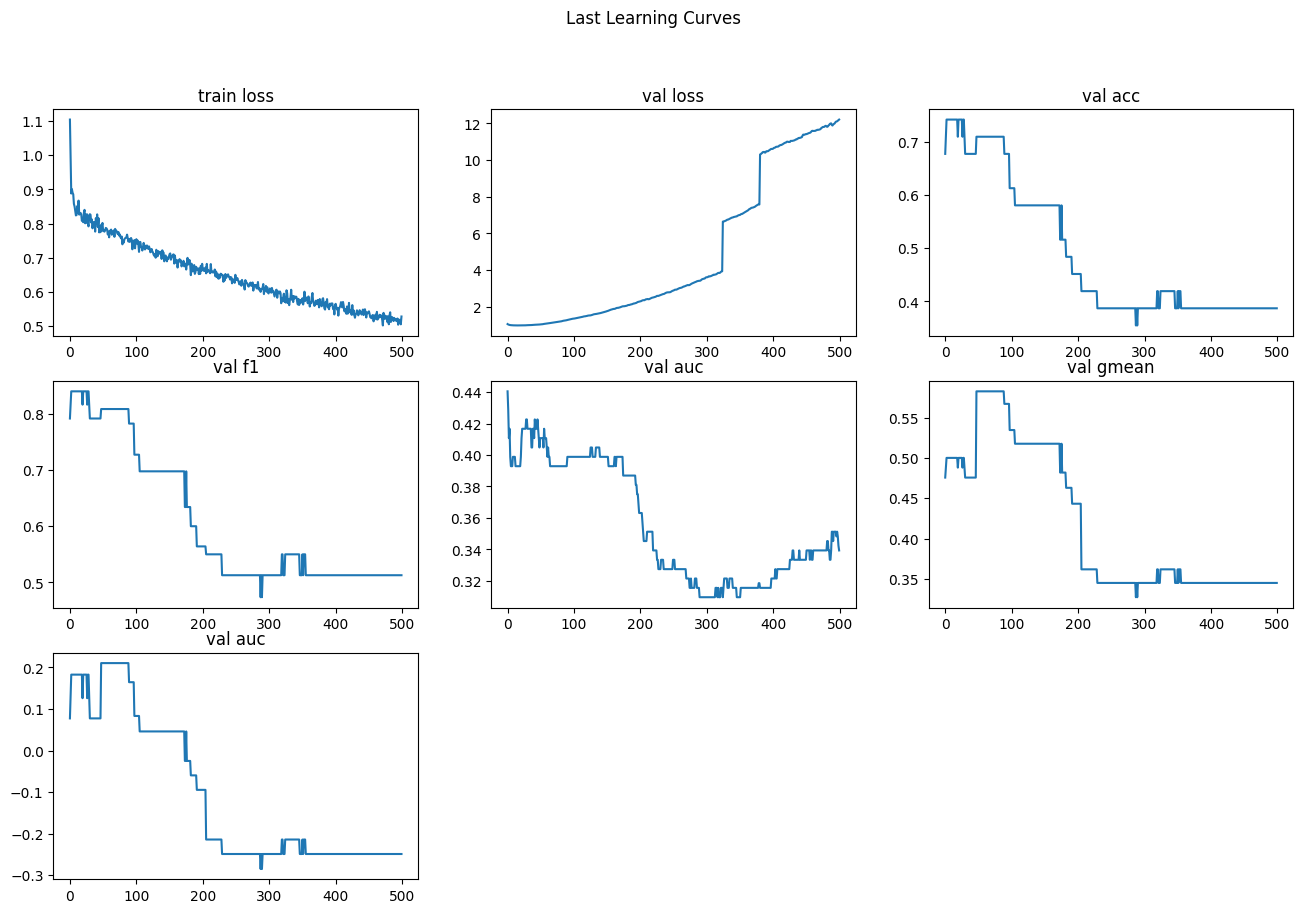

In [20]:
plt.figure(figsize=(16,10))

plt.subplot(331)
plt.plot(loss_buf)
plt.title("train loss")

plt.subplot(332)
plt.plot(val_loss_buf)
plt.title("val loss")

plt.subplot(333)
plt.plot(val_acc_buf)
plt.title("val acc")

plt.subplot(334)
plt.plot(val_f1_buf)
plt.title("val f1")

plt.subplot(335)
plt.plot(val_auc_buf)
plt.title("val auc")

plt.subplot(336)
plt.plot(val_gmean_buf)
plt.title("val gmean")

plt.subplot(337)
plt.plot(val_mcc_buf)
plt.title("val auc")

plt.suptitle("Last Learning Curves")
plt.show()

In [21]:
val_acc_mean = []
val_f1_mean = []
val_auc_mean = []
val_gmean_mean = []
val_mcc_mean = []

for i in range(10):
    
    val_acc_i = np.load("./results/CoV-AbDab/{}/val_acc_{}_best.npy".format(model_name, i))
    val_acc_mean.append(val_acc_i)
    
    val_f1_i = np.load("./results/CoV-AbDab/{}/val_f1_{}_best.npy".format(model_name, i))
    val_f1_mean.append(val_f1_i)
    
    val_auc_i = np.load("./results/CoV-AbDab/{}/val_auc_{}_best.npy".format(model_name, i))
    val_auc_mean.append(val_auc_i)
    
    val_gmean_i = np.load("./results/CoV-AbDab/{}/val_gmean_{}_best.npy".format(model_name, i))
    val_gmean_mean.append(val_gmean_i)
    
    val_mcc_i = np.load("./results/CoV-AbDab/{}/val_mcc_{}_best.npy".format(model_name, i))
    val_mcc_mean.append(val_mcc_i)
    
print("model: {}".format(model_name))
print("val acc mean: ", np.mean(val_acc_mean))
print("val f1 mean: ", np.mean(val_f1_mean))
print("val auc mean: ", np.mean(val_auc_mean))
print("val gmean mean: ", np.mean(val_gmean_mean))
print("val mcc mean: ", np.mean(val_mcc_mean))

model: PESI_ft
val acc mean:  0.6129032258064516
val f1 mean:  0.7267589316962282
val auc mean:  0.5019817458756078
val gmean mean:  0.46310214588198306
val mcc mean:  0.03777970650972913


model: PESI

1. de novo
- val acc mean:  0.7548387096774194
- val f1 mean:  0.8472360344258647
- val auc mean:  0.6364248905399801
- val gmean mean:  0.12137665014671031
- val mcc mean:  0.06637028519834769


- val acc mean:  0.7451612903225807
- val f1 mean:  0.8450983571639433
- val auc mean:  0.5999908666213013
- val gmean mean:  0.1544552971674015
- val mcc mean:  0.0980278804259509

2. fine-tune

fixed Frame/Set feature extractor
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5784537830739878
- val gmean mean:  0.0
- val mcc mean:  0.0

L2 + pre-train
- val acc mean:  0.6129032258064516
- val f1 mean:  0.7267589316962282
- val auc mean:  0.5019817458756078
- val gmean mean:  0.46310214588198306
- val mcc mean:  0.03777970650972913

EnsembleModel1

1. de novo

- val acc mean:  0.7258064516129032
- val f1 mean:  0.8357809829448485
- val auc mean:  0.5863614324010744
- val gmean mean:  0.04364357804719847
- val mcc mean:  -0.00243360941090478


model: EnsembleModel1 (based on DeepAAI hyperparameters)
- val acc mean:  0.735483870967742
- val f1 mean:  0.8426296329094451
- val auc mean:  0.576874495354035
- val gmean mean:  0.026726124191242435
- val mcc mean:  0.016785362070740578


model: EnsembleModel1 (based on DeepAAI hyperparameters) + L2 loss
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.6850925941066606
- val gmean mean:  0.0
- val mcc mean:  0.0


2. finetune

model: EnsembleModel1 (based on DeepAAI hyperparameters) + L2 loss
- val acc mean:  0.7258064516129032
- val f1 mean:  0.8368535348629104
- val auc mean:  0.6183667442248005
- val gmean mean:  0.13486832980505137
- val mcc mean:  0.05979789537418943

EnsembleModel

1. de novo

- val acc mean:  0.7225806451612903
- val f1 mean:  0.80938251651044
- val auc mean:  0.6277278343991899
- val gmean mean:  0.20839957350649357
- val mcc mean:  0.1381022811013694

2. finetune

- val acc mean:  0.7451612903225807
- val f1 mean:  0.8468587022064271
- val auc mean:  0.5173764489275998
- val gmean mean:  0.09929549764864425
- val mcc mean:  0.07493838512158786

MasonsCNN
1. de novo
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5409950281318567

flipping
- val acc mean:  0.735483870967742
- val f1 mean:  0.8427516133925679
- val auc mean:  0.5455146192256166

0209
- val acc mean:  0.732258064516129
- val f1 mean:  0.8411225407108635
- val auc mean:  0.5413395687858604
- val gmean mean:  0.0
- val mcc mean:  -0.003333333333333333

2. finetune
- val acc mean:  0.7193548387096775
- val f1 mean:  0.8280684455906437
- val auc mean:  0.5564490021203576
- val gmean mean:  0.1475625995769564
- val mcc mean:  0.04446577910427487


Feature Extractor fixed
- val acc mean:  0.7322580645161291
- val f1 mean:  0.8338451090661441
- val auc mean:  0.634319673790262
- val gmean mean:  0.24199404771340785
- val mcc mean:  0.12252410865664765

0216
- val acc mean:  0.7322580645161291
- val f1 mean:  0.834695438627144
- val auc mean:  0.6693377090371975
- val gmean mean:  0.2087328313765909
- val mcc mean:  0.11147883124012761

BiLSTM

1. De novo
- val acc mean:  0.7064516129032258
- val f1 mean:  0.819065850000514
- val auc mean:  0.44001247005339084


- val acc mean:  0.7193548387096774
- val f1 mean:  0.8286013119221826
- val auc mean:  0.5272626716846667
- val gmean mean:  0.08176287840460057
- val mcc mean:  0.00657602704451053

2. Finetune - full
- val acc mean:  0.2838709677419355
- val f1 mean:  0.06804597701149426
- val auc mean:  0.524349864826847
- val gmean mean:  0.08231242234049345
- val mcc mean:  -0.003441800331963846

FE Fixed
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5305428632180551
- val gmean mean:  0.0
- val mcc mean:  0.0

0216
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5296878848630767
- val gmean mean:  0.0
- val mcc mean:  0.0

InteractTransformer

1. De novo
- val acc mean:  0.7419354838709677
- val f1 mean:  0.8460928830582551
- val auc mean:  0.5697268280171094

left/right flipping
- val acc mean:  0.6741935483870967
- val f1 mean:  0.7933415428025153
- val auc mean:  0.5941512822216147

0209
- val acc mean:  0.7387096774193548
- val f1 mean:  0.8444456024636061
- val auc mean:  0.5559159858328655
- val gmean mean:  0.0447213595499958
- val mcc mean:  0.04163331998932266

2. Finetune - full
- val acc mean:  0.7387096774193549
- val f1 mean:  0.837479640502948
- val auc mean:  0.5373362548221883
- val gmean mean:  0.11956972115904681
- val mcc mean:  0.05274808166803078

FE Fixed
- val acc mean:  0.7096774193548387
- val f1 mean:  0.8192963769848788
- val auc mean:  0.5437163596562574
- val gmean mean:  0.18894861461152904
- val mcc mean:  0.043908331255973564

InteractCoattnTransformer

1. De novo

coattn after embed
- val acc mean:  0.7322580645161291
- val f1 mean:  0.8384620373723942
- val auc mean:  0.5792465999473672

coattn after transformer
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8389562234502067
- val auc mean:  0.5215266408783032

two coattn
dropout0.3
- val acc mean:  0.6645161290322581
- val f1 mean:  0.7577206864384995
- val auc mean:  0.4894495640761625

dropout0.5
- val acc mean:  0.7032258064516129
- val f1 mean:  0.8148800008196817
- val auc mean:  0.5601084965049159

0209
- val acc mean:  0.7064516129032258
- val f1 mean:  0.8065533962654705
- val auc mean:  0.53074342679202
- val gmean mean:  0.08783456377261516
- val mcc mean:  -0.03089614519177042

0210
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8333675745553654
- val auc mean:  0.5629656307034825
- val gmean mean:  0.19967351371222142
- val mcc mean:  0.08859651752472261

2. Finetune
- val acc mean:  0.7419354838709677
- val f1 mean:  0.8295161019309971
- val auc mean:  0.6776508588030327
- val gmean mean:  0.41048764045233976
- val mcc mean:  0.23726058068617323

0210
- val acc mean:  0.7032258064516129
- val f1 mean:  0.7529802738432863
- val auc mean:  0.5843740140223517
- val gmean mean:  0.11863970769085672
- val mcc mean:  -0.02494321880367

use final model rather than best
- val acc mean:  0.5903225806451613
- val f1 mean:  0.6981662591680293
- val auc mean:  0.5202095768681446
- val gmean mean:  0.43529770732374456
- val mcc mean:  0.035015078636667016

FE Fixed FT
- val acc mean:  0.735483870967742
- val f1 mean:  0.8323679177395693
- val auc mean:  0.5757738855347552
- val gmean mean:  0.1772604277248653
- val mcc mean:  0.051826896161838866

SetModel
1. de novo

dropout0.3
- val acc mean:  0.7258064516129032
- val f1 mean:  0.8364886835455663
- val auc mean:  0.6504661560377674

dropout0.5 + CoAttnSkipConnection
- val acc mean:  0.7225806451612904
- val f1 mean:  0.7678373423027144
- val auc mean:  0.649160663150433

dropout0.3 + CoAttn ahead
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8331830945361233
- val auc mean:  0.6217202631128462

dropout0.3 + CoAttn ahead + left/right flipping
- val acc mean:  0.7548387096774194
- val f1 mean:  0.8390957431282627
- val auc mean:  0.566890947358978

0209
- val acc mean:  0.7419354838709677
- val f1 mean:  0.8385743405122875
- val auc mean:  0.646844740510981
- val gmean mean:  0.3499641605118257
- val mcc mean:  0.16989948824073764

2. finetune
- val acc mean:  0.6548387096774194
- val f1 mean:  0.7614356955971864
- val auc mean:  0.5850305370957545
- val gmean mean:  0.4690008572794017
- val mcc mean:  0.09590317756829693

FX Fixed FT
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8304804775765957
- val auc mean:  0.6118961087221957
- val gmean mean:  0.325372891932986
- val mcc mean:  0.1376242188288149

SetCoAttnModel

1. de novo
- val acc mean:  0.7129032258064516
- val f1 mean:  0.8283774426716478
- val auc mean:  0.6031828529526739
- val gmean mean:  0.11381713711118394
- val mcc mean:  0.05107581130651245

2. finetune
- val acc mean:  0.735483870967742
- val f1 mean:  0.8255950018544915
- val auc mean:  0.5836535310384415
- val gmean mean:  0.19683955427239194
- val mcc mean:  0.060401168945660236

FE Fixed FT
- val acc mean:  0.7451612903225807
- val f1 mean:  0.840554625019997
- val auc mean:  0.5332801356075013
- val gmean mean:  0.06351073488299558
- val mcc mean:  0.02796710598995068

SetTransformer

1. de novo
- val acc mean:  0.7387096774193549
- val f1 mean:  0.8361401746369017
- val auc mean:  0.6567989579332291
- val gmean mean:  0.22237169691743341
- val mcc mean:  0.11689544381896444

bi-tower
- val acc mean:  0.7322580645161291
- val f1 mean:  0.8304782251291887
- val auc mean:  0.6367931102713712
- val gmean mean:  0.2632115309684307
- val mcc mean:  0.12791443324565496

2. finetune
- val acc mean:  0.7096774193548387
- val f1 mean:  0.8221135340407786
- val auc mean:  0.6275436241791741
- val gmean mean:  0.2348251415923123
- val mcc mean:  0.09602992408332747


FE Fixed FT
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017
- val auc mean:  0.5436637051496387
- val gmean mean:  0.0
- val mcc mean:  0.0

SetCoAttnTransformer

1. de novo
- val acc mean:  0.7290322580645162
- val f1 mean:  0.8371426812951388
- val auc mean:  0.6973226134479332
- val gmean mean:  0.08283199089454711
- val mcc mean:  0.03612682646386498

2. finetune
- val acc mean:  0.7548387096774194
- val f1 mean:  0.8381884843645546
- val auc mean:  0.7171163618989707
- val gmean mean:  0.6158503375322386
- val mcc mean:  0.34239057721353133

- val acc mean:  0.7451612903225807
- val f1 mean:  0.8258364526202552
- val auc mean:  0.667494606842433
- val gmean mean:  0.598600578762371
- val mcc mean:  0.327257546356814

FE Fixed FT
- val acc mean:  0.7387096774193549
- val f1 mean:  0.839985269566902
- val auc mean:  0.641870172027461
- val gmean mean:  0.15255182247968152
- val mcc mean:  0.08206384239742148

InteractTransformerLSTM
1. de novo
- ?

2. finetune
- ?

3. finetune - full
- ?

InteractTransformerLSTM + CoAttn
1. de novo
- ?

FTransformer + CoATtn
1. de novo

1layer + kmer5
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.48571428571428565

2layers + kmer5
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.6238095238095238

2layers + kmer3
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.6428571428571429

2layers + kmer4
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.3476190476190476

2layers + kmer3 + lr3e-5
- val acc mean:  0.6451612903225806
- val f1 mean:  0.7755102040816326
- val auc mean:  0.3952380952380952

FTransformer
1. de novo

2layers + kmer3
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.5285714285714286

2layers + kmer5
- val acc mean:  0.6774193548387096
- val f1 mean:  0.8076923076923077
- val auc mean:  0.5619047619047619